In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # Disable DecompressionBombError
import pandas as pd
import os
import matplotlib.pyplot as plt
from skimage import io, transform
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#### 可以使用torchvision中提供的API快速的创建一个reader实现在训练的过程中不断地读取图像和类别信息
**transform** 表示把读取的图像resize到227 * 227并转换为PyTorch中的tensor类型，同时将其标准化到\[ -1 , 1 \]之间。

In [5]:
def read_csv_file():


    DATASET_MEDIUM_DIR = 'can_be_train.csv'
    Image.MAX_IMAGE_PIXELS = None

    imgs_dirs = []
    dataset_read_result = pd.read_csv(DATASET_MEDIUM_DIR)
    i = 0
    for each_img_dir, \
        each_landmarks_dir, \
        each_target_image, \
        each_target_landmarks, \
        each_status in zip(dataset_read_result['Source image'],
                           dataset_read_result['Source landmarks'],
                           dataset_read_result['Target image'],
                           dataset_read_result['Target landmarks'],
                           dataset_read_result['status']):
        each_img_dir = 'images/' + each_img_dir
        each_landmarks_dir = 'landmarks/' + each_landmarks_dir
        each_target_image = 'images/' + each_target_image
        each_target_landmarks = 'landmarks/' + each_target_landmarks

        dataset_read_result.set_value(index=i, col='Source image', value=each_img_dir)
        dataset_read_result.set_value(index=i, col='Source landmarks', value=each_landmarks_dir)
        dataset_read_result.set_value(index=i, col='Target image', value=each_target_image)
        dataset_read_result.set_value(index=i, col='Target landmarks', value=each_target_landmarks)

        imgs_dirs.append(each_img_dir)
        i = i + 1

    print(dataset_read_result['Source image'][1])
    print(imgs_dirs[1])
    return dataset_read_result


dataset_read_result = read_csv_file()

# the first 10
source_image_array = dataset_read_result['Source image']
target_image_array = dataset_read_result['Target image']
source_image_landmarks = dataset_read_result['Source landmarks']
target_image_landmarks = dataset_read_result['Target landmarks']

images/lung-lesion_2/scale-25pc/29-041-Izd2-w35-He-les2.jpg
images/lung-lesion_2/scale-25pc/29-041-Izd2-w35-He-les2.jpg


C:\Users\Administrator\Anaconda3\envs\pytouch\lib\site-packages\ipykernel_launcher.py:24: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Administrator\Anaconda3\envs\pytouch\lib\site-packages\ipykernel_launcher.py:25: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Administrator\Anaconda3\envs\pytouch\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
C:\Users\Administrator\Anaconda3\envs\pytouch\lib\site-packages\ipykernel_launcher.py:27: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [3]:
transform = transforms.Compose(
    [transforms.Resize([227,227]),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

loader = torch.utils.data.DataLoader(source_image_array, batch_size=1,shuffle=True, num_workers=2)

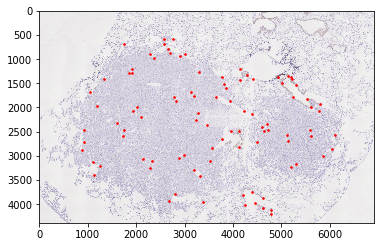

In [4]:
def show_landmarks(image, X,Y):
    plt.imshow(image)
    plt.scatter(X, Y, s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
source_image_1 = source_image_array[0]
source_image_landmark = source_image_landmarks[0]
current = pd.read_csv(source_image_landmark)
X = current['X']
Y = current['Y']

show_landmarks(io.imread(source_image_1),X,Y)
plt.show()

#### 训练
由于开始PIL读取图片导致图片过大，改了PIL文件Image.py中的MAX_IMAGE_PIXELS=none

计算 output size feature size
output = int((in_size - kernel_size + 2*(padding)) / stride) + 1

In [5]:
def outputSize(in_size, kernel_size, stride, padding):
    output = int((in_size - kernel_size + 2*(padding)) / stride)+1 
    return output
print(outputSize(512,3,2,0))
print(outputSize(255,2,1,0))

255
254


In [17]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

class regNet_2D(nn.Module):
    def __init__(self):
        #使用super()方法调用基类的构造器，即nn.Module.__init__(self)
        super(regNet_2D,self).__init__()
        # The first layer 
        # Input channels = 3, output channels = 6 ,,5x5 square convolution kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1) 
        self.bn1=nn.BatchNorm2d(32)
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2=nn.BatchNorm2d(64)
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        
        
        self.reg_1 = torch.nn.Linear(128 * 16 * 16, 70)
        self.reg_1_1 = torch.nn.Linear(70, 70)
        # self.reg_1_2 = torch.nn.Linear(70, 70)
        
        
        self.deconv1=nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        self.bn_deconv1=nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn4=nn.BatchNorm2d(64)
        self.reg_2 = torch.nn.Linear(64 * 17 * 17, 70)
        self.reg_2_1 = torch.nn.Linear(70, 70)
        # self.reg_2_2 = torch.nn.Linear(70, 70)
        #64 input features, 10 output features for our 10 defined classes
        # self.fc2 = torch.nn.Linear(78, 78)
        
        ########### end of the first
        self.conv1_y = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1) 
        self.bn1_y=nn.BatchNorm2d(32)
        self.pool_1_y = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        
        self.conv2_y = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.bn2_y = nn.BatchNorm2d(64)
        self.pool_2_y  = torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
        self.conv3_y = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        
        self.reg_1_y = torch.nn.Linear(128 * 16 * 16, 70)
        self.reg_1_1_y = torch.nn.Linear(70, 70)
        
        self.deconv1_y = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2)
        self.bn_deconv1_y = nn.BatchNorm2d(64)
        self.conv4_y = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1)
        self.bn4_y=nn.BatchNorm2d(64)
        self.reg_2_y = torch.nn.Linear(64 * 17 * 17, 70)
        self.reg_2_1_y = torch.nn.Linear(70, 70)
        
        
    def forward(self,x,y):
        #Size changes from (3, height, weight) to (6, height, weight)
        x = F.relu(self.bn1(self.conv1(x)))
        #Size changes from (6, height, weight) to (6, height/2, weight/2)
        x = self.pool_1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool_2(x)
        x = F.relu(self.conv3(x))
        #Reshape data to input to the input layer of the neural net
        #Size changes from (6, height/2, weight/2) to (1, 6*height/2*weight/2)
        #Recall that the -1 infers this dimension from the other given dimension
        x_1 = x.view(-1, 128 * 16 * 16)
        #Computes the activation of the first fully connected layer
        #Size changes from (1, 4608) to (1, 78)
        x_1 = self.reg_1(x_1)
        x_1 = self.reg_1_1(x_1)
        
        x = F.relu(self.bn_deconv1(self.deconv1(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x_2 = x.view(-1, 64 * 17 * 17)
        x_2 = self.reg_2(x_2)
        x_2 = self.reg_2_1(x_2)
        #### end of the first image
        
        ### the first guess using the samiliar network
        y = F.relu(self.bn1(self.conv1(y)))
        y = self.pool_1(y)
        y = F.relu(self.bn2(self.conv2(y)))
        y = self.pool_2(y)
        y = F.relu(self.conv3(y))
        
        y_1 = y.view(-1, 128 * 16 * 16)
        y_1 = self.reg_1(y_1)
        y_1 = self.reg_1_1(y_1)
        
        y = F.relu(self.bn_deconv1(self.deconv1(y)))
        y = F.relu(self.bn4(self.conv4(y)))
        y_2 = y.view(-1, 64 * 17 * 17)
        y_2 = self.reg_2(y_2)
        y_2 = self.reg_2_1(y_2)
        
        
        # x = F.relu(self.fc2(x))
        return x_1,x_2,y_1,y_2
        

In [41]:
# transform_1 = transforms.Compose([transforms.Resize([512,512]),transforms.ToTensor()""",transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))"""]) 

transform_1 = transforms.Compose([transforms.Resize([512,512]),
                                  transforms.ToTensor()])


reg_net=regNet_2D()

from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = optim.Adam(reg_net.parameters(), lr=1e-4)
loss = nn.MSELoss()# MSELoss可换为
for epoch in range(1000):
    for i, data in enumerate(loader, 0):
        inputs = data
        # source_image = plt.imread(inputs[0])
        
        optimizer.zero_grad()
        source_image = Image.open(inputs[0]).convert('RGB')
        # image = transform_1(source_image).unsqueeze(0)
        # width, height = source_image.size
        source_image1 = transform_1(source_image)
        # image_tensor = source_image1.to(device, torch.float)
        # source_image1 = torch.from_numpy(source_image).float()
        # source_image1 = source_image1.type(torch.FloatTensor)
        image_tensor= source_image1.unsqueeze(0)
        
        image_tensor = Variable(image_tensor)
        
        
        
        target_image = Image.open(target_image_array[i]).convert('RGB')
        # image = transform_1(target_image).unsqueeze(0)
        target_image1 = transform_1(target_image)
        target_image_tensor= target_image1.unsqueeze(0)
        target_image_tensor = Variable(target_image_tensor)
        
        optimizer.zero_grad()
        
        
        
        x_1,x_2,y_1,y_2 = reg_net(image_tensor,target_image_tensor)
        # plt.imshow(image)
        # plt.imshow(target_image)
        source_image_landmark = source_image_landmarks[i]
        current = pd.read_csv(source_image_landmark)
        X = current['X']
        Y = current['Y']
        # X = X.transpose()
        X = torch.FloatTensor(X[:70])
        X = X.unsqueeze(0)
        
        Y = torch.FloatTensor(Y[:70])
        Y = Y.unsqueeze(0)
        loss_1 = loss(x_1, X)
        loss_2 = loss(x_2, Y)
        
        ######
        target_image_landmark = target_image_landmarks[i]
        current = pd.read_csv(target_image_landmark)
        X = current['X']
        Y = current['Y']
        
        X = torch.FloatTensor(X[:70])
        X = X.unsqueeze(0)
        
        Y = torch.FloatTensor(Y[:70])
        Y = Y.unsqueeze(0)
        
        loss_3 = loss(y_1, X)
        loss_4 = loss(y_2, Y)
        
        
        loss_all = loss_1+loss_2+loss_3+loss_4
        loss_all.backward()
        
        optimizer.step()
        print("The loss is ",loss_all)
        
    
print(x_1)


The loss is  tensor(50787896., grad_fn=<AddBackward0>)
The loss is  tensor(51339972., grad_fn=<AddBackward0>)
The loss is  tensor(50990900., grad_fn=<AddBackward0>)
The loss is  tensor(50078088., grad_fn=<AddBackward0>)
The loss is  tensor(48119200., grad_fn=<AddBackward0>)
The loss is  tensor(47758352., grad_fn=<AddBackward0>)
The loss is  tensor(46838344., grad_fn=<AddBackward0>)
The loss is  tensor(48244520., grad_fn=<AddBackward0>)
The loss is  tensor(47296096., grad_fn=<AddBackward0>)
The loss is  tensor(46909072., grad_fn=<AddBackward0>)
The loss is  tensor(84083000., grad_fn=<AddBackward0>)
The loss is  tensor(79631896., grad_fn=<AddBackward0>)
The loss is  tensor(77762736., grad_fn=<AddBackward0>)
The loss is  tensor(84000352., grad_fn=<AddBackward0>)
The loss is  tensor(74682072., grad_fn=<AddBackward0>)
The loss is  tensor(72756144., grad_fn=<AddBackward0>)
The loss is  tensor(79034480., grad_fn=<AddBackward0>)
The loss is  tensor(68107768., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(8121378.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8718249., grad_fn=<AddBackward0>)
The loss is  tensor(6742435., grad_fn=<AddBackward0>)
The loss is  tensor(6609720., grad_fn=<AddBackward0>)
The loss is  tensor(6098130., grad_fn=<AddBackward0>)
The loss is  tensor(6371500., grad_fn=<AddBackward0>)
The loss is  tensor(6151122., grad_fn=<AddBackward0>)
The loss is  tensor(6214158., grad_fn=<AddBackward0>)
The loss is  tensor(10624502., grad_fn=<AddBackward0>)
The loss is  tensor(10357350., grad_fn=<AddBackward0>)
The loss is  tensor(10949023., grad_fn=<AddBackward0>)
The loss is  tensor(9739949., grad_fn=<AddBackward0>)
The loss is  tensor(9653371., grad_fn=<AddBackward0>)
The loss is  tensor(10233045., grad_fn=<AddBackward0>)
The loss is  tensor(9095182., grad_fn=<AddBackward0>)
The loss is  tensor(9999548., grad_fn=<AddBackward0>)
The loss is  tensor(8904117., grad_fn=<AddBackward0>)
The loss is  tensor(9249032., grad_fn=<AddBackward0>)
The loss is  tensor(

The loss is  tensor(35739536., grad_fn=<AddBackward0>)
The loss is  tensor(34360760., grad_fn=<AddBackward0>)
The loss is  tensor(30865872., grad_fn=<AddBackward0>)
The loss is  tensor(32142794., grad_fn=<AddBackward0>)
The loss is  tensor(22063108., grad_fn=<AddBackward0>)
The loss is  tensor(20065732., grad_fn=<AddBackward0>)
The loss is  tensor(18327748., grad_fn=<AddBackward0>)
The loss is  tensor(19687340., grad_fn=<AddBackward0>)
The loss is  tensor(17982146., grad_fn=<AddBackward0>)
The loss is  tensor(16723517., grad_fn=<AddBackward0>)
The loss is  tensor(14780805., grad_fn=<AddBackward0>)
The loss is  tensor(18657300., grad_fn=<AddBackward0>)
The loss is  tensor(18249102., grad_fn=<AddBackward0>)
The loss is  tensor(15719616., grad_fn=<AddBackward0>)
The loss is  tensor(11648826., grad_fn=<AddBackward0>)
The loss is  tensor(11173045., grad_fn=<AddBackward0>)
The loss is  tensor(7271904.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8285678., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(14691650., grad_fn=<AddBackward0>)
The loss is  tensor(16266552., grad_fn=<AddBackward0>)
The loss is  tensor(13967234., grad_fn=<AddBackward0>)
The loss is  tensor(13702075., grad_fn=<AddBackward0>)
The loss is  tensor(13918006., grad_fn=<AddBackward0>)
The loss is  tensor(16658642., grad_fn=<AddBackward0>)
The loss is  tensor(19052428., grad_fn=<AddBackward0>)
The loss is  tensor(15936460., grad_fn=<AddBackward0>)
The loss is  tensor(16480532., grad_fn=<AddBackward0>)
The loss is  tensor(17869382., grad_fn=<AddBackward0>)
The loss is  tensor(16758669., grad_fn=<AddBackward0>)
The loss is  tensor(17193564., grad_fn=<AddBackward0>)
The loss is  tensor(15184316., grad_fn=<AddBackward0>)
The loss is  tensor(15597099., grad_fn=<AddBackward0>)
The loss is  tensor(14177144., grad_fn=<AddBackward0>)
The loss is  tensor(20093954., grad_fn=<AddBackward0>)
The loss is  tensor(20055792., grad_fn=<AddBackward0>)
The loss is  tensor(14891666., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(3236768.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2695151.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2546694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2227146.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2531905.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1884020.3750, grad_fn=<AddBackward0>)
The loss is  tensor(1806581.6250, grad_fn=<AddBackward0>)
The loss is  tensor(1659925.6250, grad_fn=<AddBackward0>)
The loss is  tensor(1488544.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1857657.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1627624.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1766503.3750, grad_fn=<AddBackward0>)
The loss is  tensor(1527794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1555882.6250, grad_fn=<AddBackward0>)
The loss is  tensor(1525435.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8075229., grad_fn=<AddBackward0>)
The loss is  tensor(10664319., grad_fn=<AddBackward0>)
The loss is  tensor(9

The loss is  tensor(17877748., grad_fn=<AddBackward0>)
The loss is  tensor(17575574., grad_fn=<AddBackward0>)
The loss is  tensor(13372454., grad_fn=<AddBackward0>)
The loss is  tensor(13257251., grad_fn=<AddBackward0>)
The loss is  tensor(8424584., grad_fn=<AddBackward0>)
The loss is  tensor(12373088., grad_fn=<AddBackward0>)
The loss is  tensor(10822528., grad_fn=<AddBackward0>)
The loss is  tensor(10851270., grad_fn=<AddBackward0>)
The loss is  tensor(6962041., grad_fn=<AddBackward0>)
The loss is  tensor(10493983., grad_fn=<AddBackward0>)
The loss is  tensor(8054030., grad_fn=<AddBackward0>)
The loss is  tensor(5097941., grad_fn=<AddBackward0>)
The loss is  tensor(4415304.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7982195.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4545191., grad_fn=<AddBackward0>)
The loss is  tensor(3895874.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3897751.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4075338.5000, grad_fn=<AddBackward0>)


The loss is  tensor(14689533., grad_fn=<AddBackward0>)
The loss is  tensor(14225091., grad_fn=<AddBackward0>)
The loss is  tensor(13572952., grad_fn=<AddBackward0>)
The loss is  tensor(13347708., grad_fn=<AddBackward0>)
The loss is  tensor(22047362., grad_fn=<AddBackward0>)
The loss is  tensor(14513242., grad_fn=<AddBackward0>)
The loss is  tensor(23641978., grad_fn=<AddBackward0>)
The loss is  tensor(15068540., grad_fn=<AddBackward0>)
The loss is  tensor(12190155., grad_fn=<AddBackward0>)
The loss is  tensor(12398266., grad_fn=<AddBackward0>)
The loss is  tensor(16547100., grad_fn=<AddBackward0>)
The loss is  tensor(10099466., grad_fn=<AddBackward0>)
The loss is  tensor(13171034., grad_fn=<AddBackward0>)
The loss is  tensor(7158600., grad_fn=<AddBackward0>)
The loss is  tensor(6528945., grad_fn=<AddBackward0>)
The loss is  tensor(5548307.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4995195.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8053744., grad_fn=<AddBackward0>)
The los

The loss is  tensor(2030734., grad_fn=<AddBackward0>)
The loss is  tensor(1958517.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1211593.8750, grad_fn=<AddBackward0>)
The loss is  tensor(7970953.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11055866., grad_fn=<AddBackward0>)
The loss is  tensor(9654432., grad_fn=<AddBackward0>)
The loss is  tensor(9620663., grad_fn=<AddBackward0>)
The loss is  tensor(6423291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11048767., grad_fn=<AddBackward0>)
The loss is  tensor(9511000., grad_fn=<AddBackward0>)
The loss is  tensor(6803604., grad_fn=<AddBackward0>)
The loss is  tensor(9830920., grad_fn=<AddBackward0>)
The loss is  tensor(8170477.5000, grad_fn=<AddBackward0>)
The loss is  tensor(24572968., grad_fn=<AddBackward0>)
The loss is  tensor(25911242., grad_fn=<AddBackward0>)
The loss is  tensor(25258568., grad_fn=<AddBackward0>)
The loss is  tensor(22593892., grad_fn=<AddBackward0>)
The loss is  tensor(23335024., grad_fn=<AddBackward0>)
T

The loss is  tensor(3461977.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5866351.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4833640.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5750297., grad_fn=<AddBackward0>)
The loss is  tensor(4128347.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6214130., grad_fn=<AddBackward0>)
The loss is  tensor(5944336.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3848378., grad_fn=<AddBackward0>)
The loss is  tensor(3707254., grad_fn=<AddBackward0>)
The loss is  tensor(3855381.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8492511., grad_fn=<AddBackward0>)
The loss is  tensor(20625574., grad_fn=<AddBackward0>)
The loss is  tensor(13137932., grad_fn=<AddBackward0>)
The loss is  tensor(13233620., grad_fn=<AddBackward0>)
The loss is  tensor(14801256., grad_fn=<AddBackward0>)
The loss is  tensor(11979630., grad_fn=<AddBackward0>)
The loss is  tensor(13257550., grad_fn=<AddBackward0>)
The loss is  tensor(14026256., grad_fn=<AddBackward0

The loss is  tensor(18917588., grad_fn=<AddBackward0>)
The loss is  tensor(9127871., grad_fn=<AddBackward0>)
The loss is  tensor(5082841., grad_fn=<AddBackward0>)
The loss is  tensor(13281086., grad_fn=<AddBackward0>)
The loss is  tensor(6097078., grad_fn=<AddBackward0>)
The loss is  tensor(6099144.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7360415., grad_fn=<AddBackward0>)
The loss is  tensor(3909041.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6421131., grad_fn=<AddBackward0>)
The loss is  tensor(3454060.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3688731., grad_fn=<AddBackward0>)
The loss is  tensor(3410381., grad_fn=<AddBackward0>)
The loss is  tensor(6269377., grad_fn=<AddBackward0>)
The loss is  tensor(6768555.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3216358., grad_fn=<AddBackward0>)
The loss is  tensor(3107979.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3224376., grad_fn=<AddBackward0>)
The loss is  tensor(5043509., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(11413715., grad_fn=<AddBackward0>)
The loss is  tensor(15296272., grad_fn=<AddBackward0>)
The loss is  tensor(27630890., grad_fn=<AddBackward0>)
The loss is  tensor(24009430., grad_fn=<AddBackward0>)
The loss is  tensor(20543222., grad_fn=<AddBackward0>)
The loss is  tensor(17732908., grad_fn=<AddBackward0>)
The loss is  tensor(24095120., grad_fn=<AddBackward0>)
The loss is  tensor(27883608., grad_fn=<AddBackward0>)
The loss is  tensor(22528952., grad_fn=<AddBackward0>)
The loss is  tensor(17373730., grad_fn=<AddBackward0>)
The loss is  tensor(20336332., grad_fn=<AddBackward0>)
The loss is  tensor(20049684., grad_fn=<AddBackward0>)
The loss is  tensor(11427624., grad_fn=<AddBackward0>)
The loss is  tensor(17780506., grad_fn=<AddBackward0>)
The loss is  tensor(19919046., grad_fn=<AddBackward0>)
The loss is  tensor(18821880., grad_fn=<AddBackward0>)
The loss is  tensor(11581837., grad_fn=<AddBackward0>)
The loss is  tensor(15045559., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(16185810., grad_fn=<AddBackward0>)
The loss is  tensor(12907020., grad_fn=<AddBackward0>)
The loss is  tensor(18073138., grad_fn=<AddBackward0>)
The loss is  tensor(11699621., grad_fn=<AddBackward0>)
The loss is  tensor(11889238., grad_fn=<AddBackward0>)
The loss is  tensor(12608188., grad_fn=<AddBackward0>)
The loss is  tensor(11157514., grad_fn=<AddBackward0>)
The loss is  tensor(16192144., grad_fn=<AddBackward0>)
The loss is  tensor(12254843., grad_fn=<AddBackward0>)
The loss is  tensor(14218964., grad_fn=<AddBackward0>)
The loss is  tensor(24686184., grad_fn=<AddBackward0>)
The loss is  tensor(13329308., grad_fn=<AddBackward0>)
The loss is  tensor(12764730., grad_fn=<AddBackward0>)
The loss is  tensor(15682807., grad_fn=<AddBackward0>)
The loss is  tensor(13389070., grad_fn=<AddBackward0>)
The loss is  tensor(14128498., grad_fn=<AddBackward0>)
The loss is  tensor(13023617., grad_fn=<AddBackward0>)
The loss is  tensor(13954911., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(3812217., grad_fn=<AddBackward0>)
The loss is  tensor(3675124., grad_fn=<AddBackward0>)
The loss is  tensor(3827293.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3948943.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3988865., grad_fn=<AddBackward0>)
The loss is  tensor(3318210.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5745969.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2055524.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2649740.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2716919.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1666973.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3171991.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2027722.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3652681.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2860940.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2274022.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1479363.5000, grad_fn=<AddBackward0>)
The loss is  tensor(206338

The loss is  tensor(18804408., grad_fn=<AddBackward0>)
The loss is  tensor(18541656., grad_fn=<AddBackward0>)
The loss is  tensor(17537738., grad_fn=<AddBackward0>)
The loss is  tensor(17666132., grad_fn=<AddBackward0>)
The loss is  tensor(23686892., grad_fn=<AddBackward0>)
The loss is  tensor(16752072., grad_fn=<AddBackward0>)
The loss is  tensor(15329176., grad_fn=<AddBackward0>)
The loss is  tensor(7540231., grad_fn=<AddBackward0>)
The loss is  tensor(12554435., grad_fn=<AddBackward0>)
The loss is  tensor(12878003., grad_fn=<AddBackward0>)
The loss is  tensor(12482317., grad_fn=<AddBackward0>)
The loss is  tensor(11367016., grad_fn=<AddBackward0>)
The loss is  tensor(16949942., grad_fn=<AddBackward0>)
The loss is  tensor(13930775., grad_fn=<AddBackward0>)
The loss is  tensor(2679841.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3492155., grad_fn=<AddBackward0>)
The loss is  tensor(13458492., grad_fn=<AddBackward0>)
The loss is  tensor(5327408., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(12903978., grad_fn=<AddBackward0>)
The loss is  tensor(17845460., grad_fn=<AddBackward0>)
The loss is  tensor(13194082., grad_fn=<AddBackward0>)
The loss is  tensor(13391252., grad_fn=<AddBackward0>)
The loss is  tensor(18620752., grad_fn=<AddBackward0>)
The loss is  tensor(17309734., grad_fn=<AddBackward0>)
The loss is  tensor(17294778., grad_fn=<AddBackward0>)
The loss is  tensor(10124381., grad_fn=<AddBackward0>)
The loss is  tensor(9627295., grad_fn=<AddBackward0>)
The loss is  tensor(16134205., grad_fn=<AddBackward0>)
The loss is  tensor(13448804., grad_fn=<AddBackward0>)
The loss is  tensor(15815341., grad_fn=<AddBackward0>)
The loss is  tensor(13431515., grad_fn=<AddBackward0>)
The loss is  tensor(11972100., grad_fn=<AddBackward0>)
The loss is  tensor(19928772., grad_fn=<AddBackward0>)
The loss is  tensor(6281698., grad_fn=<AddBackward0>)
The loss is  tensor(14464225., grad_fn=<AddBackward0>)
The loss is  tensor(9617995., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(2874025.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4384197.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2625954.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5418568.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1849160.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3037694.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3671522., grad_fn=<AddBackward0>)
The loss is  tensor(6382591.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8931527., grad_fn=<AddBackward0>)
The loss is  tensor(9434661., grad_fn=<AddBackward0>)
The loss is  tensor(7368057.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9969304., grad_fn=<AddBackward0>)
The loss is  tensor(8661432., grad_fn=<AddBackward0>)
The loss is  tensor(11265355., grad_fn=<AddBackward0>)
The loss is  tensor(7986883.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5693629., grad_fn=<AddBackward0>)
The loss is  tensor(11374640., grad_fn=<AddBackward0>)
The loss is  tensor(20879564., grad_fn=<AddB

The loss is  tensor(9919919., grad_fn=<AddBackward0>)
The loss is  tensor(11480727., grad_fn=<AddBackward0>)
The loss is  tensor(8716725., grad_fn=<AddBackward0>)
The loss is  tensor(10008614., grad_fn=<AddBackward0>)
The loss is  tensor(3058736., grad_fn=<AddBackward0>)
The loss is  tensor(4165951.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6260316., grad_fn=<AddBackward0>)
The loss is  tensor(4414724.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4434718., grad_fn=<AddBackward0>)
The loss is  tensor(5313463., grad_fn=<AddBackward0>)
The loss is  tensor(4080302., grad_fn=<AddBackward0>)
The loss is  tensor(3613136.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4601579., grad_fn=<AddBackward0>)
The loss is  tensor(5947580., grad_fn=<AddBackward0>)
The loss is  tensor(5230626.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20100918., grad_fn=<AddBackward0>)
The loss is  tensor(20111208., grad_fn=<AddBackward0>)
The loss is  tensor(12036945., grad_fn=<AddBackward0>)
The los

The loss is  tensor(9739137., grad_fn=<AddBackward0>)
The loss is  tensor(28400832., grad_fn=<AddBackward0>)
The loss is  tensor(29224708., grad_fn=<AddBackward0>)
The loss is  tensor(13225358., grad_fn=<AddBackward0>)
The loss is  tensor(12313662., grad_fn=<AddBackward0>)
The loss is  tensor(6234639.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5665072., grad_fn=<AddBackward0>)
The loss is  tensor(15064578., grad_fn=<AddBackward0>)
The loss is  tensor(4378421.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6695351.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5795694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6162631.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2772808.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4553739., grad_fn=<AddBackward0>)
The loss is  tensor(3857855.7500, grad_fn=<AddBackward0>)
The loss is  tensor(13063776., grad_fn=<AddBackward0>)
The loss is  tensor(4974730., grad_fn=<AddBackward0>)
The loss is  tensor(4245562.5000, grad_fn=<AddBa

The loss is  tensor(4941742., grad_fn=<AddBackward0>)
The loss is  tensor(8163286.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7117929.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7380058., grad_fn=<AddBackward0>)
The loss is  tensor(5306482.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20363870., grad_fn=<AddBackward0>)
The loss is  tensor(21954832., grad_fn=<AddBackward0>)
The loss is  tensor(19694722., grad_fn=<AddBackward0>)
The loss is  tensor(16792268., grad_fn=<AddBackward0>)
The loss is  tensor(21300390., grad_fn=<AddBackward0>)
The loss is  tensor(13993031., grad_fn=<AddBackward0>)
The loss is  tensor(12660910., grad_fn=<AddBackward0>)
The loss is  tensor(22801164., grad_fn=<AddBackward0>)
The loss is  tensor(14460521., grad_fn=<AddBackward0>)
The loss is  tensor(10315084., grad_fn=<AddBackward0>)
The loss is  tensor(18535598., grad_fn=<AddBackward0>)
The loss is  tensor(7523837.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12102314., grad_fn=<AddBackward0>)


The loss is  tensor(7283488., grad_fn=<AddBackward0>)
The loss is  tensor(3867421., grad_fn=<AddBackward0>)
The loss is  tensor(3566738.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17036978., grad_fn=<AddBackward0>)
The loss is  tensor(14997295., grad_fn=<AddBackward0>)
The loss is  tensor(12015538., grad_fn=<AddBackward0>)
The loss is  tensor(19303318., grad_fn=<AddBackward0>)
The loss is  tensor(12143270., grad_fn=<AddBackward0>)
The loss is  tensor(17644054., grad_fn=<AddBackward0>)
The loss is  tensor(15558013., grad_fn=<AddBackward0>)
The loss is  tensor(10526007., grad_fn=<AddBackward0>)
The loss is  tensor(15804594., grad_fn=<AddBackward0>)
The loss is  tensor(12118066., grad_fn=<AddBackward0>)
The loss is  tensor(13813892., grad_fn=<AddBackward0>)
The loss is  tensor(16141862., grad_fn=<AddBackward0>)
The loss is  tensor(11641194., grad_fn=<AddBackward0>)
The loss is  tensor(11770056., grad_fn=<AddBackward0>)
The loss is  tensor(16432447., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(13111200., grad_fn=<AddBackward0>)
The loss is  tensor(9531802., grad_fn=<AddBackward0>)
The loss is  tensor(6614734., grad_fn=<AddBackward0>)
The loss is  tensor(6055038.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5208200.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4619829., grad_fn=<AddBackward0>)
The loss is  tensor(4215980.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11131295., grad_fn=<AddBackward0>)
The loss is  tensor(3885119.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8123295., grad_fn=<AddBackward0>)
The loss is  tensor(5979889., grad_fn=<AddBackward0>)
The loss is  tensor(5604707., grad_fn=<AddBackward0>)
The loss is  tensor(3023321.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4603965., grad_fn=<AddBackward0>)
The loss is  tensor(1954909., grad_fn=<AddBackward0>)
The loss is  tensor(2851133.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1920933., grad_fn=<AddBackward0>)
The loss is  tensor(1757530.6250, grad_fn=<AddBackward0>

The loss is  tensor(16142548., grad_fn=<AddBackward0>)
The loss is  tensor(12125903., grad_fn=<AddBackward0>)
The loss is  tensor(29500966., grad_fn=<AddBackward0>)
The loss is  tensor(28215490., grad_fn=<AddBackward0>)
The loss is  tensor(18707962., grad_fn=<AddBackward0>)
The loss is  tensor(14979119., grad_fn=<AddBackward0>)
The loss is  tensor(17774256., grad_fn=<AddBackward0>)
The loss is  tensor(20801814., grad_fn=<AddBackward0>)
The loss is  tensor(9395339., grad_fn=<AddBackward0>)
The loss is  tensor(10579162., grad_fn=<AddBackward0>)
The loss is  tensor(12817475., grad_fn=<AddBackward0>)
The loss is  tensor(7421540.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9126445., grad_fn=<AddBackward0>)
The loss is  tensor(14706156., grad_fn=<AddBackward0>)
The loss is  tensor(10471457., grad_fn=<AddBackward0>)
The loss is  tensor(12306311., grad_fn=<AddBackward0>)
The loss is  tensor(15019748., grad_fn=<AddBackward0>)
The loss is  tensor(1808292.2500, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(13107064., grad_fn=<AddBackward0>)
The loss is  tensor(18378922., grad_fn=<AddBackward0>)
The loss is  tensor(11682897., grad_fn=<AddBackward0>)
The loss is  tensor(12168749., grad_fn=<AddBackward0>)
The loss is  tensor(11398938., grad_fn=<AddBackward0>)
The loss is  tensor(18643980., grad_fn=<AddBackward0>)
The loss is  tensor(12484722., grad_fn=<AddBackward0>)
The loss is  tensor(20253114., grad_fn=<AddBackward0>)
The loss is  tensor(12558929., grad_fn=<AddBackward0>)
The loss is  tensor(14902223., grad_fn=<AddBackward0>)
The loss is  tensor(20665814., grad_fn=<AddBackward0>)
The loss is  tensor(31018352., grad_fn=<AddBackward0>)
The loss is  tensor(18195934., grad_fn=<AddBackward0>)
The loss is  tensor(31531788., grad_fn=<AddBackward0>)
The loss is  tensor(17404078., grad_fn=<AddBackward0>)
The loss is  tensor(16861042., grad_fn=<AddBackward0>)
The loss is  tensor(20353322., grad_fn=<AddBackward0>)
The loss is  tensor(9586160., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(2733276.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6037241., grad_fn=<AddBackward0>)
The loss is  tensor(1886396.6250, grad_fn=<AddBackward0>)
The loss is  tensor(7745518.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2440270.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2777211.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1288605.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2446714.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4656243.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5667408., grad_fn=<AddBackward0>)
The loss is  tensor(7599855.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3032996.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8837308., grad_fn=<AddBackward0>)
The loss is  tensor(8579443., grad_fn=<AddBackward0>)
The loss is  tensor(3597525.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3040237., grad_fn=<AddBackward0>)
The loss is  tensor(6723618.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7045827.5000, 

The loss is  tensor(18025614., grad_fn=<AddBackward0>)
The loss is  tensor(24582472., grad_fn=<AddBackward0>)
The loss is  tensor(4306013., grad_fn=<AddBackward0>)
The loss is  tensor(15555317., grad_fn=<AddBackward0>)
The loss is  tensor(3386460.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2160524., grad_fn=<AddBackward0>)
The loss is  tensor(10840104., grad_fn=<AddBackward0>)
The loss is  tensor(4334626.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9143268., grad_fn=<AddBackward0>)
The loss is  tensor(4130301.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4854351.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5973224.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3667484.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4204545.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4090175.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3640817.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4950086., grad_fn=<AddBackward0>)
The loss is  tensor(16218198., grad_fn=<Ad

The loss is  tensor(24607056., grad_fn=<AddBackward0>)
The loss is  tensor(16348052., grad_fn=<AddBackward0>)
The loss is  tensor(26035580., grad_fn=<AddBackward0>)
The loss is  tensor(18204726., grad_fn=<AddBackward0>)
The loss is  tensor(19163954., grad_fn=<AddBackward0>)
The loss is  tensor(13217375., grad_fn=<AddBackward0>)
The loss is  tensor(20781404., grad_fn=<AddBackward0>)
The loss is  tensor(4441405., grad_fn=<AddBackward0>)
The loss is  tensor(6910531.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12142582., grad_fn=<AddBackward0>)
The loss is  tensor(7613893.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5085182., grad_fn=<AddBackward0>)
The loss is  tensor(8358609., grad_fn=<AddBackward0>)
The loss is  tensor(3476236.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6014161., grad_fn=<AddBackward0>)
The loss is  tensor(4935357.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6130078., grad_fn=<AddBackward0>)
The loss is  tensor(4721736.5000, grad_fn=<AddBackward0>)


The loss is  tensor(3872319.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10130672., grad_fn=<AddBackward0>)
The loss is  tensor(7846142.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9047925., grad_fn=<AddBackward0>)
The loss is  tensor(8024041.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3527261.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6040898.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18224804., grad_fn=<AddBackward0>)
The loss is  tensor(20998024., grad_fn=<AddBackward0>)
The loss is  tensor(17227258., grad_fn=<AddBackward0>)
The loss is  tensor(15544426., grad_fn=<AddBackward0>)
The loss is  tensor(20791466., grad_fn=<AddBackward0>)
The loss is  tensor(19205072., grad_fn=<AddBackward0>)
The loss is  tensor(22206212., grad_fn=<AddBackward0>)
The loss is  tensor(17657118., grad_fn=<AddBackward0>)
The loss is  tensor(15960579., grad_fn=<AddBackward0>)
The loss is  tensor(10152913., grad_fn=<AddBackward0>)
The loss is  tensor(19658200., grad_fn=<AddBackward

The loss is  tensor(3721918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3673211.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3563789., grad_fn=<AddBackward0>)
The loss is  tensor(6679254., grad_fn=<AddBackward0>)
The loss is  tensor(6525948.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12808832., grad_fn=<AddBackward0>)
The loss is  tensor(11895262., grad_fn=<AddBackward0>)
The loss is  tensor(11894218., grad_fn=<AddBackward0>)
The loss is  tensor(18911218., grad_fn=<AddBackward0>)
The loss is  tensor(14740256., grad_fn=<AddBackward0>)
The loss is  tensor(10275378., grad_fn=<AddBackward0>)
The loss is  tensor(14031966., grad_fn=<AddBackward0>)
The loss is  tensor(17086652., grad_fn=<AddBackward0>)
The loss is  tensor(18243470., grad_fn=<AddBackward0>)
The loss is  tensor(10763880., grad_fn=<AddBackward0>)
The loss is  tensor(12360170., grad_fn=<AddBackward0>)
The loss is  tensor(16146338., grad_fn=<AddBackward0>)
The loss is  tensor(14579176., grad_fn=<AddBackward0>)
The

The loss is  tensor(8742322., grad_fn=<AddBackward0>)
The loss is  tensor(9310540., grad_fn=<AddBackward0>)
The loss is  tensor(13334343., grad_fn=<AddBackward0>)
The loss is  tensor(5658562.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14863234., grad_fn=<AddBackward0>)
The loss is  tensor(15873250., grad_fn=<AddBackward0>)
The loss is  tensor(14735847., grad_fn=<AddBackward0>)
The loss is  tensor(4420348.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3533344.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4155574., grad_fn=<AddBackward0>)
The loss is  tensor(4154542.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5868480., grad_fn=<AddBackward0>)
The loss is  tensor(9181205., grad_fn=<AddBackward0>)
The loss is  tensor(2866716.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2800584.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3188268.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8310590., grad_fn=<AddBackward0>)
The loss is  tensor(1980401., grad_fn=<AddBackward

The loss is  tensor(19188704., grad_fn=<AddBackward0>)
The loss is  tensor(21990926., grad_fn=<AddBackward0>)
The loss is  tensor(10301846., grad_fn=<AddBackward0>)
The loss is  tensor(16720117., grad_fn=<AddBackward0>)
The loss is  tensor(7992877., grad_fn=<AddBackward0>)
The loss is  tensor(16328536., grad_fn=<AddBackward0>)
The loss is  tensor(12050636., grad_fn=<AddBackward0>)
The loss is  tensor(14048490., grad_fn=<AddBackward0>)
The loss is  tensor(19970526., grad_fn=<AddBackward0>)
The loss is  tensor(9858497., grad_fn=<AddBackward0>)
The loss is  tensor(18944280., grad_fn=<AddBackward0>)
The loss is  tensor(15035414., grad_fn=<AddBackward0>)
The loss is  tensor(7835642., grad_fn=<AddBackward0>)
The loss is  tensor(14512880., grad_fn=<AddBackward0>)
The loss is  tensor(5574826., grad_fn=<AddBackward0>)
The loss is  tensor(13972679., grad_fn=<AddBackward0>)
The loss is  tensor(7087691.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6251393.5000, grad_fn=<AddBackward0>)
The loss

The loss is  tensor(11304020., grad_fn=<AddBackward0>)
The loss is  tensor(10162318., grad_fn=<AddBackward0>)
The loss is  tensor(14552298., grad_fn=<AddBackward0>)
The loss is  tensor(18154078., grad_fn=<AddBackward0>)
The loss is  tensor(19240394., grad_fn=<AddBackward0>)
The loss is  tensor(20233506., grad_fn=<AddBackward0>)
The loss is  tensor(16213827., grad_fn=<AddBackward0>)
The loss is  tensor(15563348., grad_fn=<AddBackward0>)
The loss is  tensor(13460186., grad_fn=<AddBackward0>)
The loss is  tensor(10690176., grad_fn=<AddBackward0>)
The loss is  tensor(12638238., grad_fn=<AddBackward0>)
The loss is  tensor(11759809., grad_fn=<AddBackward0>)
The loss is  tensor(16588943., grad_fn=<AddBackward0>)
The loss is  tensor(10035780., grad_fn=<AddBackward0>)
The loss is  tensor(17429768., grad_fn=<AddBackward0>)
The loss is  tensor(5117562., grad_fn=<AddBackward0>)
The loss is  tensor(8021808.5000, grad_fn=<AddBackward0>)
The loss is  tensor(32090968., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(4954685., grad_fn=<AddBackward0>)
The loss is  tensor(4715895., grad_fn=<AddBackward0>)
The loss is  tensor(3082615.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9985242., grad_fn=<AddBackward0>)
The loss is  tensor(4522524.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4587892.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4961997., grad_fn=<AddBackward0>)
The loss is  tensor(6063412., grad_fn=<AddBackward0>)
The loss is  tensor(3881909.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7232862., grad_fn=<AddBackward0>)
The loss is  tensor(2409426.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2011090.1250, grad_fn=<AddBackward0>)
The loss is  tensor(1551966.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3445143.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3164127.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6925149., grad_fn=<AddBackward0>)
The loss is  tensor(7636693., grad_fn=<AddBackward0>)
The loss is  tensor(2832101.7500, grad_fn=<Add

The loss is  tensor(5755873., grad_fn=<AddBackward0>)
The loss is  tensor(21314620., grad_fn=<AddBackward0>)
The loss is  tensor(13296825., grad_fn=<AddBackward0>)
The loss is  tensor(11365167., grad_fn=<AddBackward0>)
The loss is  tensor(6224928.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13884054., grad_fn=<AddBackward0>)
The loss is  tensor(11715712., grad_fn=<AddBackward0>)
The loss is  tensor(12686658., grad_fn=<AddBackward0>)
The loss is  tensor(8586982., grad_fn=<AddBackward0>)
The loss is  tensor(8578537., grad_fn=<AddBackward0>)
The loss is  tensor(6321568., grad_fn=<AddBackward0>)
The loss is  tensor(12226426., grad_fn=<AddBackward0>)
The loss is  tensor(6817617., grad_fn=<AddBackward0>)
The loss is  tensor(5461867., grad_fn=<AddBackward0>)
The loss is  tensor(5091357.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11153515., grad_fn=<AddBackward0>)
The loss is  tensor(3471882.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4366215., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(20005976., grad_fn=<AddBackward0>)
The loss is  tensor(13601606., grad_fn=<AddBackward0>)
The loss is  tensor(31693878., grad_fn=<AddBackward0>)
The loss is  tensor(16821930., grad_fn=<AddBackward0>)
The loss is  tensor(22150090., grad_fn=<AddBackward0>)
The loss is  tensor(20700952., grad_fn=<AddBackward0>)
The loss is  tensor(12681720., grad_fn=<AddBackward0>)
The loss is  tensor(19073686., grad_fn=<AddBackward0>)
The loss is  tensor(16325104., grad_fn=<AddBackward0>)
The loss is  tensor(15941635., grad_fn=<AddBackward0>)
The loss is  tensor(14165292., grad_fn=<AddBackward0>)
The loss is  tensor(14812715., grad_fn=<AddBackward0>)
The loss is  tensor(5079214.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9506921., grad_fn=<AddBackward0>)
The loss is  tensor(1878690.6250, grad_fn=<AddBackward0>)
The loss is  tensor(10416819., grad_fn=<AddBackward0>)
The loss is  tensor(9223363., grad_fn=<AddBackward0>)
The loss is  tensor(10996031., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(1451135., grad_fn=<AddBackward0>)
The loss is  tensor(2851075.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2799072.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2208086., grad_fn=<AddBackward0>)
The loss is  tensor(4148188.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6027329.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2639758.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8066618., grad_fn=<AddBackward0>)
The loss is  tensor(4023095., grad_fn=<AddBackward0>)
The loss is  tensor(11459208., grad_fn=<AddBackward0>)
The loss is  tensor(9434513., grad_fn=<AddBackward0>)
The loss is  tensor(8076604., grad_fn=<AddBackward0>)
The loss is  tensor(20063394., grad_fn=<AddBackward0>)
The loss is  tensor(16066545., grad_fn=<AddBackward0>)
The loss is  tensor(17296754., grad_fn=<AddBackward0>)
The loss is  tensor(21613368., grad_fn=<AddBackward0>)
The loss is  tensor(18615278., grad_fn=<AddBackward0>)
The loss is  tensor(17167484., grad_fn=<AddBackward0>)
T

The loss is  tensor(3804653.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6727438., grad_fn=<AddBackward0>)
The loss is  tensor(4431319., grad_fn=<AddBackward0>)
The loss is  tensor(4349864., grad_fn=<AddBackward0>)
The loss is  tensor(5684537.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5159777.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2725386., grad_fn=<AddBackward0>)
The loss is  tensor(4604327.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4918363., grad_fn=<AddBackward0>)
The loss is  tensor(5680777.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12401398., grad_fn=<AddBackward0>)
The loss is  tensor(14121940., grad_fn=<AddBackward0>)
The loss is  tensor(13442711., grad_fn=<AddBackward0>)
The loss is  tensor(12311201., grad_fn=<AddBackward0>)
The loss is  tensor(11233134., grad_fn=<AddBackward0>)
The loss is  tensor(15654862., grad_fn=<AddBackward0>)
The loss is  tensor(11013315., grad_fn=<AddBackward0>)
The loss is  tensor(8573014., grad_fn=<AddBackward0>)
T

The loss is  tensor(8392541., grad_fn=<AddBackward0>)
The loss is  tensor(5478094., grad_fn=<AddBackward0>)
The loss is  tensor(7954732., grad_fn=<AddBackward0>)
The loss is  tensor(9031254., grad_fn=<AddBackward0>)
The loss is  tensor(2943967.7500, grad_fn=<AddBackward0>)
The loss is  tensor(14320848., grad_fn=<AddBackward0>)
The loss is  tensor(8956706., grad_fn=<AddBackward0>)
The loss is  tensor(1809240.3750, grad_fn=<AddBackward0>)
The loss is  tensor(7341190.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6875919.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4685596., grad_fn=<AddBackward0>)
The loss is  tensor(6426991., grad_fn=<AddBackward0>)
The loss is  tensor(5529356.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5285519., grad_fn=<AddBackward0>)
The loss is  tensor(4281229., grad_fn=<AddBackward0>)
The loss is  tensor(12990992., grad_fn=<AddBackward0>)
The loss is  tensor(10096455., grad_fn=<AddBackward0>)
The loss is  tensor(4330790.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(21920398., grad_fn=<AddBackward0>)
The loss is  tensor(19059408., grad_fn=<AddBackward0>)
The loss is  tensor(16058779., grad_fn=<AddBackward0>)
The loss is  tensor(17699848., grad_fn=<AddBackward0>)
The loss is  tensor(9657593., grad_fn=<AddBackward0>)
The loss is  tensor(12787586., grad_fn=<AddBackward0>)
The loss is  tensor(16956044., grad_fn=<AddBackward0>)
The loss is  tensor(7282164., grad_fn=<AddBackward0>)
The loss is  tensor(15980850., grad_fn=<AddBackward0>)
The loss is  tensor(19421108., grad_fn=<AddBackward0>)
The loss is  tensor(10238102., grad_fn=<AddBackward0>)
The loss is  tensor(9566238., grad_fn=<AddBackward0>)
The loss is  tensor(16265450., grad_fn=<AddBackward0>)
The loss is  tensor(14059726., grad_fn=<AddBackward0>)
The loss is  tensor(13863960., grad_fn=<AddBackward0>)
The loss is  tensor(19817760., grad_fn=<AddBackward0>)
The loss is  tensor(13709640., grad_fn=<AddBackward0>)
The loss is  tensor(6433988.5000, grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(12323707., grad_fn=<AddBackward0>)
The loss is  tensor(10977700., grad_fn=<AddBackward0>)
The loss is  tensor(21846610., grad_fn=<AddBackward0>)
The loss is  tensor(9525391., grad_fn=<AddBackward0>)
The loss is  tensor(9785500., grad_fn=<AddBackward0>)
The loss is  tensor(12623011., grad_fn=<AddBackward0>)
The loss is  tensor(11136867., grad_fn=<AddBackward0>)
The loss is  tensor(14583489., grad_fn=<AddBackward0>)
The loss is  tensor(12608443., grad_fn=<AddBackward0>)
The loss is  tensor(10833583., grad_fn=<AddBackward0>)
The loss is  tensor(9804566., grad_fn=<AddBackward0>)
The loss is  tensor(9202169., grad_fn=<AddBackward0>)
The loss is  tensor(13251175., grad_fn=<AddBackward0>)
The loss is  tensor(12620838., grad_fn=<AddBackward0>)
The loss is  tensor(11546054., grad_fn=<AddBackward0>)
The loss is  tensor(9727884., grad_fn=<AddBackward0>)
The loss is  tensor(17645118., grad_fn=<AddBackward0>)
The loss is  tensor(12071989., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(17908468., grad_fn=<AddBackward0>)
The loss is  tensor(14556719., grad_fn=<AddBackward0>)
The loss is  tensor(4680623., grad_fn=<AddBackward0>)
The loss is  tensor(2333354., grad_fn=<AddBackward0>)
The loss is  tensor(4441226., grad_fn=<AddBackward0>)
The loss is  tensor(4303656.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2934555.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4192983., grad_fn=<AddBackward0>)
The loss is  tensor(2428095., grad_fn=<AddBackward0>)
The loss is  tensor(1819036., grad_fn=<AddBackward0>)
The loss is  tensor(3226557.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3720273., grad_fn=<AddBackward0>)
The loss is  tensor(3427317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3549300., grad_fn=<AddBackward0>)
The loss is  tensor(3184268.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3402404.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2438898., grad_fn=<AddBackward0>)
The loss is  tensor(1718776.1250, grad_fn=<AddBackward0>

The loss is  tensor(7723715.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17621580., grad_fn=<AddBackward0>)
The loss is  tensor(18936638., grad_fn=<AddBackward0>)
The loss is  tensor(13260110., grad_fn=<AddBackward0>)
The loss is  tensor(14287107., grad_fn=<AddBackward0>)
The loss is  tensor(8487486., grad_fn=<AddBackward0>)
The loss is  tensor(12671785., grad_fn=<AddBackward0>)
The loss is  tensor(11345942., grad_fn=<AddBackward0>)
The loss is  tensor(10423120., grad_fn=<AddBackward0>)
The loss is  tensor(15392304., grad_fn=<AddBackward0>)
The loss is  tensor(4561022.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8439675., grad_fn=<AddBackward0>)
The loss is  tensor(9667905., grad_fn=<AddBackward0>)
The loss is  tensor(9079503., grad_fn=<AddBackward0>)
The loss is  tensor(4659655., grad_fn=<AddBackward0>)
The loss is  tensor(5007968.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5391224., grad_fn=<AddBackward0>)
The loss is  tensor(6954392., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(10912023., grad_fn=<AddBackward0>)
The loss is  tensor(10460954., grad_fn=<AddBackward0>)
The loss is  tensor(16285275., grad_fn=<AddBackward0>)
The loss is  tensor(9842497., grad_fn=<AddBackward0>)
The loss is  tensor(18376588., grad_fn=<AddBackward0>)
The loss is  tensor(25881470., grad_fn=<AddBackward0>)
The loss is  tensor(15111327., grad_fn=<AddBackward0>)
The loss is  tensor(15869494., grad_fn=<AddBackward0>)
The loss is  tensor(16815476., grad_fn=<AddBackward0>)
The loss is  tensor(15709699., grad_fn=<AddBackward0>)
The loss is  tensor(13735290., grad_fn=<AddBackward0>)
The loss is  tensor(13921408., grad_fn=<AddBackward0>)
The loss is  tensor(9654250., grad_fn=<AddBackward0>)
The loss is  tensor(15641927., grad_fn=<AddBackward0>)
The loss is  tensor(3628305.7500, grad_fn=<AddBackward0>)
The loss is  tensor(18251460., grad_fn=<AddBackward0>)
The loss is  tensor(7518559.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11784843., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(1778675.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1024247.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3675936.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5554541.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6063429., grad_fn=<AddBackward0>)
The loss is  tensor(3809283.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5652012.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3387015., grad_fn=<AddBackward0>)
The loss is  tensor(6520496.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5635953.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8625103., grad_fn=<AddBackward0>)
The loss is  tensor(9007279., grad_fn=<AddBackward0>)
The loss is  tensor(7128111.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8557292., grad_fn=<AddBackward0>)
The loss is  tensor(20974750., grad_fn=<AddBackward0>)
The loss is  tensor(17713006., grad_fn=<AddBackward0>)
The loss is  tensor(8234025., grad_fn=<AddBackward0>)
The loss is  tensor(8112464.5000, grad_fn=<A

The loss is  tensor(8272750., grad_fn=<AddBackward0>)
The loss is  tensor(19244606., grad_fn=<AddBackward0>)
The loss is  tensor(4832120.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4875265., grad_fn=<AddBackward0>)
The loss is  tensor(5058816.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4249717., grad_fn=<AddBackward0>)
The loss is  tensor(5626399.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5571016.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5767909., grad_fn=<AddBackward0>)
The loss is  tensor(4580126.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6018121.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4231864., grad_fn=<AddBackward0>)
The loss is  tensor(18291420., grad_fn=<AddBackward0>)
The loss is  tensor(10762086., grad_fn=<AddBackward0>)
The loss is  tensor(12763784., grad_fn=<AddBackward0>)
The loss is  tensor(12787494., grad_fn=<AddBackward0>)
The loss is  tensor(9839021., grad_fn=<AddBackward0>)
The loss is  tensor(13384271., grad_fn=<AddBackward0>

The loss is  tensor(13820921., grad_fn=<AddBackward0>)
The loss is  tensor(26368198., grad_fn=<AddBackward0>)
The loss is  tensor(5963407.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8487704., grad_fn=<AddBackward0>)
The loss is  tensor(7786350., grad_fn=<AddBackward0>)
The loss is  tensor(8058718.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5500328., grad_fn=<AddBackward0>)
The loss is  tensor(5636837.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6133459.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3972221.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5420675.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5866435., grad_fn=<AddBackward0>)
The loss is  tensor(6290297., grad_fn=<AddBackward0>)
The loss is  tensor(7395575.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13597898., grad_fn=<AddBackward0>)
The loss is  tensor(5916850., grad_fn=<AddBackward0>)
The loss is  tensor(2992751.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8474694., grad_fn=<AddBackw

The loss is  tensor(4075168.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9314492., grad_fn=<AddBackward0>)
The loss is  tensor(20120618., grad_fn=<AddBackward0>)
The loss is  tensor(9722859., grad_fn=<AddBackward0>)
The loss is  tensor(13452020., grad_fn=<AddBackward0>)
The loss is  tensor(9865055., grad_fn=<AddBackward0>)
The loss is  tensor(18850054., grad_fn=<AddBackward0>)
The loss is  tensor(12378392., grad_fn=<AddBackward0>)
The loss is  tensor(21722048., grad_fn=<AddBackward0>)
The loss is  tensor(18602546., grad_fn=<AddBackward0>)
The loss is  tensor(15493231., grad_fn=<AddBackward0>)
The loss is  tensor(18061048., grad_fn=<AddBackward0>)
The loss is  tensor(12531020., grad_fn=<AddBackward0>)
The loss is  tensor(24003610., grad_fn=<AddBackward0>)
The loss is  tensor(11915856., grad_fn=<AddBackward0>)
The loss is  tensor(11590860., grad_fn=<AddBackward0>)
The loss is  tensor(8561519., grad_fn=<AddBackward0>)
The loss is  tensor(6304871., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(14669717., grad_fn=<AddBackward0>)
The loss is  tensor(12419918., grad_fn=<AddBackward0>)
The loss is  tensor(11742462., grad_fn=<AddBackward0>)
The loss is  tensor(13820919., grad_fn=<AddBackward0>)
The loss is  tensor(11691437., grad_fn=<AddBackward0>)
The loss is  tensor(12068128., grad_fn=<AddBackward0>)
The loss is  tensor(11324063., grad_fn=<AddBackward0>)
The loss is  tensor(8294159., grad_fn=<AddBackward0>)
The loss is  tensor(16701829., grad_fn=<AddBackward0>)
The loss is  tensor(13783754., grad_fn=<AddBackward0>)
The loss is  tensor(12908478., grad_fn=<AddBackward0>)
The loss is  tensor(6323343.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15289478., grad_fn=<AddBackward0>)
The loss is  tensor(10802616., grad_fn=<AddBackward0>)
The loss is  tensor(10189090., grad_fn=<AddBackward0>)
The loss is  tensor(10534296., grad_fn=<AddBackward0>)
The loss is  tensor(10426098., grad_fn=<AddBackward0>)
The loss is  tensor(10762733., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(4247693.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3148886.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5364036.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11536424., grad_fn=<AddBackward0>)
The loss is  tensor(12082640., grad_fn=<AddBackward0>)
The loss is  tensor(6813757., grad_fn=<AddBackward0>)
The loss is  tensor(4440028.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4096548., grad_fn=<AddBackward0>)
The loss is  tensor(4005235.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4660973., grad_fn=<AddBackward0>)
The loss is  tensor(2952401.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4467752.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1956749.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1767667., grad_fn=<AddBackward0>)
The loss is  tensor(5419559., grad_fn=<AddBackward0>)
The loss is  tensor(2611271.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3959992.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1711522.3750, grad_f

The loss is  tensor(20555304., grad_fn=<AddBackward0>)
The loss is  tensor(11163518., grad_fn=<AddBackward0>)
The loss is  tensor(15616385., grad_fn=<AddBackward0>)
The loss is  tensor(19741670., grad_fn=<AddBackward0>)
The loss is  tensor(8621213., grad_fn=<AddBackward0>)
The loss is  tensor(7094815., grad_fn=<AddBackward0>)
The loss is  tensor(13265781., grad_fn=<AddBackward0>)
The loss is  tensor(14129794., grad_fn=<AddBackward0>)
The loss is  tensor(12833767., grad_fn=<AddBackward0>)
The loss is  tensor(8195828.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10516201., grad_fn=<AddBackward0>)
The loss is  tensor(9509471., grad_fn=<AddBackward0>)
The loss is  tensor(15457951., grad_fn=<AddBackward0>)
The loss is  tensor(23291284., grad_fn=<AddBackward0>)
The loss is  tensor(12453367., grad_fn=<AddBackward0>)
The loss is  tensor(9564004., grad_fn=<AddBackward0>)
The loss is  tensor(4456917., grad_fn=<AddBackward0>)
The loss is  tensor(2914183.5000, grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(11236574., grad_fn=<AddBackward0>)
The loss is  tensor(11377618., grad_fn=<AddBackward0>)
The loss is  tensor(15141794., grad_fn=<AddBackward0>)
The loss is  tensor(11089954., grad_fn=<AddBackward0>)
The loss is  tensor(12700676., grad_fn=<AddBackward0>)
The loss is  tensor(15634060., grad_fn=<AddBackward0>)
The loss is  tensor(10250530., grad_fn=<AddBackward0>)
The loss is  tensor(17270116., grad_fn=<AddBackward0>)
The loss is  tensor(12323336., grad_fn=<AddBackward0>)
The loss is  tensor(26909334., grad_fn=<AddBackward0>)
The loss is  tensor(14377835., grad_fn=<AddBackward0>)
The loss is  tensor(15170895., grad_fn=<AddBackward0>)
The loss is  tensor(17792566., grad_fn=<AddBackward0>)
The loss is  tensor(14271951., grad_fn=<AddBackward0>)
The loss is  tensor(18394268., grad_fn=<AddBackward0>)
The loss is  tensor(11649776., grad_fn=<AddBackward0>)
The loss is  tensor(10829316., grad_fn=<AddBackward0>)
The loss is  tensor(11741679., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(5306792.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2985372., grad_fn=<AddBackward0>)
The loss is  tensor(11424220., grad_fn=<AddBackward0>)
The loss is  tensor(8904772., grad_fn=<AddBackward0>)
The loss is  tensor(2771405., grad_fn=<AddBackward0>)
The loss is  tensor(6808397., grad_fn=<AddBackward0>)
The loss is  tensor(6728103.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1278387.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2280935., grad_fn=<AddBackward0>)
The loss is  tensor(4240092., grad_fn=<AddBackward0>)
The loss is  tensor(4613907., grad_fn=<AddBackward0>)
The loss is  tensor(2594157.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3567432.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8163170., grad_fn=<AddBackward0>)
The loss is  tensor(5567728.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2851263.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6865826.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5754224., grad_fn=<AddBackwar

The loss is  tensor(4253112.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9521916., grad_fn=<AddBackward0>)
The loss is  tensor(15408947., grad_fn=<AddBackward0>)
The loss is  tensor(10814534., grad_fn=<AddBackward0>)
The loss is  tensor(9286136., grad_fn=<AddBackward0>)
The loss is  tensor(9847784., grad_fn=<AddBackward0>)
The loss is  tensor(3663425., grad_fn=<AddBackward0>)
The loss is  tensor(11650519., grad_fn=<AddBackward0>)
The loss is  tensor(3379346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3318227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4768944.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3992700.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3778219.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2617133.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4320062.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3821365.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11578164., grad_fn=<AddBackward0>)
The loss is  tensor(16377373., grad_fn=<Ad

The loss is  tensor(26233682., grad_fn=<AddBackward0>)
The loss is  tensor(15459144., grad_fn=<AddBackward0>)
The loss is  tensor(13048983., grad_fn=<AddBackward0>)
The loss is  tensor(10901336., grad_fn=<AddBackward0>)
The loss is  tensor(15339540., grad_fn=<AddBackward0>)
The loss is  tensor(13309719., grad_fn=<AddBackward0>)
The loss is  tensor(10269891., grad_fn=<AddBackward0>)
The loss is  tensor(9465184., grad_fn=<AddBackward0>)
The loss is  tensor(1887543.6250, grad_fn=<AddBackward0>)
The loss is  tensor(8918224., grad_fn=<AddBackward0>)
The loss is  tensor(5974840., grad_fn=<AddBackward0>)
The loss is  tensor(3833602., grad_fn=<AddBackward0>)
The loss is  tensor(6468855.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4516397.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3750471.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10673452., grad_fn=<AddBackward0>)
The loss is  tensor(7246249., grad_fn=<AddBackward0>)
The loss is  tensor(3825299.7500, grad_fn=<AddBackward0>)


The loss is  tensor(3253668.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3125052.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3290313., grad_fn=<AddBackward0>)
The loss is  tensor(2502660.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2280929.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6866540.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5674306.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8652744., grad_fn=<AddBackward0>)
The loss is  tensor(12974910., grad_fn=<AddBackward0>)
The loss is  tensor(6338605.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13763937., grad_fn=<AddBackward0>)
The loss is  tensor(13960343., grad_fn=<AddBackward0>)
The loss is  tensor(12935801., grad_fn=<AddBackward0>)
The loss is  tensor(10019764., grad_fn=<AddBackward0>)
The loss is  tensor(14111782., grad_fn=<AddBackward0>)
The loss is  tensor(16722603., grad_fn=<AddBackward0>)
The loss is  tensor(17763342., grad_fn=<AddBackward0>)
The loss is  tensor(20313658., grad_fn=<AddBac

The loss is  tensor(5531260., grad_fn=<AddBackward0>)
The loss is  tensor(3712935.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5275232., grad_fn=<AddBackward0>)
The loss is  tensor(7681015.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2817553.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16865610., grad_fn=<AddBackward0>)
The loss is  tensor(9355638., grad_fn=<AddBackward0>)
The loss is  tensor(10115960., grad_fn=<AddBackward0>)
The loss is  tensor(6661929., grad_fn=<AddBackward0>)
The loss is  tensor(11667240., grad_fn=<AddBackward0>)
The loss is  tensor(11610299., grad_fn=<AddBackward0>)
The loss is  tensor(10121782., grad_fn=<AddBackward0>)
The loss is  tensor(9423376., grad_fn=<AddBackward0>)
The loss is  tensor(18573000., grad_fn=<AddBackward0>)
The loss is  tensor(10860330., grad_fn=<AddBackward0>)
The loss is  tensor(19902292., grad_fn=<AddBackward0>)
The loss is  tensor(9665130., grad_fn=<AddBackward0>)
The loss is  tensor(15134694., grad_fn=<AddBackward0>)
The los

The loss is  tensor(16340842., grad_fn=<AddBackward0>)
The loss is  tensor(10492719., grad_fn=<AddBackward0>)
The loss is  tensor(13297136., grad_fn=<AddBackward0>)
The loss is  tensor(6338117.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8684474., grad_fn=<AddBackward0>)
The loss is  tensor(6738085., grad_fn=<AddBackward0>)
The loss is  tensor(2012399.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3136833.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2121441., grad_fn=<AddBackward0>)
The loss is  tensor(5031081.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6261014., grad_fn=<AddBackward0>)
The loss is  tensor(3526436.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5811461.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4758999., grad_fn=<AddBackward0>)
The loss is  tensor(6416266., grad_fn=<AddBackward0>)
The loss is  tensor(4576302.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4385728.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1543525., grad_fn=<AddBackw

The loss is  tensor(16124438., grad_fn=<AddBackward0>)
The loss is  tensor(15543481., grad_fn=<AddBackward0>)
The loss is  tensor(19431612., grad_fn=<AddBackward0>)
The loss is  tensor(6633684., grad_fn=<AddBackward0>)
The loss is  tensor(20289368., grad_fn=<AddBackward0>)
The loss is  tensor(12610362., grad_fn=<AddBackward0>)
The loss is  tensor(19123184., grad_fn=<AddBackward0>)
The loss is  tensor(7150674.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16602127., grad_fn=<AddBackward0>)
The loss is  tensor(11983403., grad_fn=<AddBackward0>)
The loss is  tensor(17181416., grad_fn=<AddBackward0>)
The loss is  tensor(12823003., grad_fn=<AddBackward0>)
The loss is  tensor(14679314., grad_fn=<AddBackward0>)
The loss is  tensor(11728441., grad_fn=<AddBackward0>)
The loss is  tensor(13424333., grad_fn=<AddBackward0>)
The loss is  tensor(13366195., grad_fn=<AddBackward0>)
The loss is  tensor(8168251., grad_fn=<AddBackward0>)
The loss is  tensor(5221227.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(9686621., grad_fn=<AddBackward0>)
The loss is  tensor(15390398., grad_fn=<AddBackward0>)
The loss is  tensor(12086822., grad_fn=<AddBackward0>)
The loss is  tensor(12118069., grad_fn=<AddBackward0>)
The loss is  tensor(10906408., grad_fn=<AddBackward0>)
The loss is  tensor(12354285., grad_fn=<AddBackward0>)
The loss is  tensor(9548042., grad_fn=<AddBackward0>)
The loss is  tensor(11080261., grad_fn=<AddBackward0>)
The loss is  tensor(10556339., grad_fn=<AddBackward0>)
The loss is  tensor(7097413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10580305., grad_fn=<AddBackward0>)
The loss is  tensor(12763943., grad_fn=<AddBackward0>)
The loss is  tensor(12794203., grad_fn=<AddBackward0>)
The loss is  tensor(16084781., grad_fn=<AddBackward0>)
The loss is  tensor(2847359.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4179976.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10973079., grad_fn=<AddBackward0>)
The loss is  tensor(15185538., grad_fn=<AddBackward0>)
The

The loss is  tensor(5849189., grad_fn=<AddBackward0>)
The loss is  tensor(4958396., grad_fn=<AddBackward0>)
The loss is  tensor(5937232., grad_fn=<AddBackward0>)
The loss is  tensor(4199324.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1745618., grad_fn=<AddBackward0>)
The loss is  tensor(2386554.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2483102.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2539303., grad_fn=<AddBackward0>)
The loss is  tensor(3810706.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4128623.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3659179.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1469437.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2700590.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1000116.8125, grad_fn=<AddBackward0>)
The loss is  tensor(5827437.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3110285., grad_fn=<AddBackward0>)
The loss is  tensor(7097798.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5692989., grad_fn=

The loss is  tensor(10250386., grad_fn=<AddBackward0>)
The loss is  tensor(7573027.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9739829., grad_fn=<AddBackward0>)
The loss is  tensor(12273764., grad_fn=<AddBackward0>)
The loss is  tensor(8524818., grad_fn=<AddBackward0>)
The loss is  tensor(14638765., grad_fn=<AddBackward0>)
The loss is  tensor(6027795.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9827566., grad_fn=<AddBackward0>)
The loss is  tensor(8040657.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12099847., grad_fn=<AddBackward0>)
The loss is  tensor(10044027., grad_fn=<AddBackward0>)
The loss is  tensor(4627695.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4807308.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6862349.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3386177.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6367328., grad_fn=<AddBackward0>)
The loss is  tensor(3542660., grad_fn=<AddBackward0>)
The loss is  tensor(3911743.2500, grad_fn=<AddBac

The loss is  tensor(15455752., grad_fn=<AddBackward0>)
The loss is  tensor(16242575., grad_fn=<AddBackward0>)
The loss is  tensor(14469248., grad_fn=<AddBackward0>)
The loss is  tensor(14806115., grad_fn=<AddBackward0>)
The loss is  tensor(16401775., grad_fn=<AddBackward0>)
The loss is  tensor(14859485., grad_fn=<AddBackward0>)
The loss is  tensor(14531646., grad_fn=<AddBackward0>)
The loss is  tensor(15898616., grad_fn=<AddBackward0>)
The loss is  tensor(2648892.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14713208., grad_fn=<AddBackward0>)
The loss is  tensor(29377342., grad_fn=<AddBackward0>)
The loss is  tensor(9493533., grad_fn=<AddBackward0>)
The loss is  tensor(14037022., grad_fn=<AddBackward0>)
The loss is  tensor(8971571., grad_fn=<AddBackward0>)
The loss is  tensor(5128185., grad_fn=<AddBackward0>)
The loss is  tensor(6120452.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6453044.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13889886., grad_fn=<AddBackward0>)
The 

The loss is  tensor(3713642., grad_fn=<AddBackward0>)
The loss is  tensor(3476582., grad_fn=<AddBackward0>)
The loss is  tensor(1943944.8750, grad_fn=<AddBackward0>)
The loss is  tensor(6177521., grad_fn=<AddBackward0>)
The loss is  tensor(7004342., grad_fn=<AddBackward0>)
The loss is  tensor(2250320.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6798196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1611903.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4514906.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4132675.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9468779., grad_fn=<AddBackward0>)
The loss is  tensor(12473328., grad_fn=<AddBackward0>)
The loss is  tensor(8007922.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14004114., grad_fn=<AddBackward0>)
The loss is  tensor(19507720., grad_fn=<AddBackward0>)
The loss is  tensor(25563060., grad_fn=<AddBackward0>)
The loss is  tensor(14209986., grad_fn=<AddBackward0>)
The loss is  tensor(14846411., grad_fn=<AddBackwa

The loss is  tensor(3860361., grad_fn=<AddBackward0>)
The loss is  tensor(4437761., grad_fn=<AddBackward0>)
The loss is  tensor(3112304., grad_fn=<AddBackward0>)
The loss is  tensor(2894749.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1764170.3750, grad_fn=<AddBackward0>)
The loss is  tensor(3440658.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5698771., grad_fn=<AddBackward0>)
The loss is  tensor(3356533., grad_fn=<AddBackward0>)
The loss is  tensor(2822915.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9096758., grad_fn=<AddBackward0>)
The loss is  tensor(9382532., grad_fn=<AddBackward0>)
The loss is  tensor(6469882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11975187., grad_fn=<AddBackward0>)
The loss is  tensor(9800121., grad_fn=<AddBackward0>)
The loss is  tensor(12276250., grad_fn=<AddBackward0>)
The loss is  tensor(12195532., grad_fn=<AddBackward0>)
The loss is  tensor(13345970., grad_fn=<AddBackward0>)
The loss is  tensor(12321544., grad_fn=<AddBackward0>)
The

The loss is  tensor(10251516., grad_fn=<AddBackward0>)
The loss is  tensor(8924969., grad_fn=<AddBackward0>)
The loss is  tensor(11278049., grad_fn=<AddBackward0>)
The loss is  tensor(9357410., grad_fn=<AddBackward0>)
The loss is  tensor(16909324., grad_fn=<AddBackward0>)
The loss is  tensor(3327577.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12864467., grad_fn=<AddBackward0>)
The loss is  tensor(6349836.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5738396., grad_fn=<AddBackward0>)
The loss is  tensor(3381688.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7009195., grad_fn=<AddBackward0>)
The loss is  tensor(6773926.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4559530., grad_fn=<AddBackward0>)
The loss is  tensor(7138758., grad_fn=<AddBackward0>)
The loss is  tensor(6664133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5087371., grad_fn=<AddBackward0>)
The loss is  tensor(6245093., grad_fn=<AddBackward0>)
The loss is  tensor(5000894., grad_fn=<AddBackward0>)
The 

The loss is  tensor(15224282., grad_fn=<AddBackward0>)
The loss is  tensor(13577175., grad_fn=<AddBackward0>)
The loss is  tensor(14050079., grad_fn=<AddBackward0>)
The loss is  tensor(9843700., grad_fn=<AddBackward0>)
The loss is  tensor(15066582., grad_fn=<AddBackward0>)
The loss is  tensor(12177333., grad_fn=<AddBackward0>)
The loss is  tensor(17171450., grad_fn=<AddBackward0>)
The loss is  tensor(8929500., grad_fn=<AddBackward0>)
The loss is  tensor(8787240., grad_fn=<AddBackward0>)
The loss is  tensor(8441540., grad_fn=<AddBackward0>)
The loss is  tensor(23073122., grad_fn=<AddBackward0>)
The loss is  tensor(12190900., grad_fn=<AddBackward0>)
The loss is  tensor(9541733., grad_fn=<AddBackward0>)
The loss is  tensor(13042910., grad_fn=<AddBackward0>)
The loss is  tensor(12514465., grad_fn=<AddBackward0>)
The loss is  tensor(11723611., grad_fn=<AddBackward0>)
The loss is  tensor(12599341., grad_fn=<AddBackward0>)
The loss is  tensor(14528915., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(10853225., grad_fn=<AddBackward0>)
The loss is  tensor(13466129., grad_fn=<AddBackward0>)
The loss is  tensor(9320242., grad_fn=<AddBackward0>)
The loss is  tensor(15067677., grad_fn=<AddBackward0>)
The loss is  tensor(8995392., grad_fn=<AddBackward0>)
The loss is  tensor(11874596., grad_fn=<AddBackward0>)
The loss is  tensor(11426667., grad_fn=<AddBackward0>)
The loss is  tensor(11724082., grad_fn=<AddBackward0>)
The loss is  tensor(10297428., grad_fn=<AddBackward0>)
The loss is  tensor(12138230., grad_fn=<AddBackward0>)
The loss is  tensor(11351472., grad_fn=<AddBackward0>)
The loss is  tensor(7170008., grad_fn=<AddBackward0>)
The loss is  tensor(10108435., grad_fn=<AddBackward0>)
The loss is  tensor(11124921., grad_fn=<AddBackward0>)
The loss is  tensor(14045263., grad_fn=<AddBackward0>)
The loss is  tensor(12081604., grad_fn=<AddBackward0>)
The loss is  tensor(10400536., grad_fn=<AddBackward0>)
The loss is  tensor(18688030., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(6058312.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12287852., grad_fn=<AddBackward0>)
The loss is  tensor(14551367., grad_fn=<AddBackward0>)
The loss is  tensor(4984820.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2265123.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4578466.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2718545.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4160981.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7101074., grad_fn=<AddBackward0>)
The loss is  tensor(4573146., grad_fn=<AddBackward0>)
The loss is  tensor(3518656., grad_fn=<AddBackward0>)
The loss is  tensor(2135126.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2455486.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4972301., grad_fn=<AddBackward0>)
The loss is  tensor(1438228.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2983573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2970254.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4451061., grad_f

The loss is  tensor(15114820., grad_fn=<AddBackward0>)
The loss is  tensor(15846440., grad_fn=<AddBackward0>)
The loss is  tensor(5652493.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13077648., grad_fn=<AddBackward0>)
The loss is  tensor(13442763., grad_fn=<AddBackward0>)
The loss is  tensor(10200731., grad_fn=<AddBackward0>)
The loss is  tensor(10071919., grad_fn=<AddBackward0>)
The loss is  tensor(12250077., grad_fn=<AddBackward0>)
The loss is  tensor(20741696., grad_fn=<AddBackward0>)
The loss is  tensor(9314990., grad_fn=<AddBackward0>)
The loss is  tensor(7669871.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10565148., grad_fn=<AddBackward0>)
The loss is  tensor(4609693., grad_fn=<AddBackward0>)
The loss is  tensor(7986627., grad_fn=<AddBackward0>)
The loss is  tensor(9888726., grad_fn=<AddBackward0>)
The loss is  tensor(11685679., grad_fn=<AddBackward0>)
The loss is  tensor(5166742.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2517854.5000, grad_fn=<AddBackward0>)
Th

The loss is  tensor(10366648., grad_fn=<AddBackward0>)
The loss is  tensor(14084129., grad_fn=<AddBackward0>)
The loss is  tensor(13512482., grad_fn=<AddBackward0>)
The loss is  tensor(12826742., grad_fn=<AddBackward0>)
The loss is  tensor(9924352., grad_fn=<AddBackward0>)
The loss is  tensor(11697008., grad_fn=<AddBackward0>)
The loss is  tensor(18563146., grad_fn=<AddBackward0>)
The loss is  tensor(18098384., grad_fn=<AddBackward0>)
The loss is  tensor(16098626., grad_fn=<AddBackward0>)
The loss is  tensor(25645314., grad_fn=<AddBackward0>)
The loss is  tensor(16775394., grad_fn=<AddBackward0>)
The loss is  tensor(13773248., grad_fn=<AddBackward0>)
The loss is  tensor(14507319., grad_fn=<AddBackward0>)
The loss is  tensor(2927378.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14372117., grad_fn=<AddBackward0>)
The loss is  tensor(25307424., grad_fn=<AddBackward0>)
The loss is  tensor(5699835.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8559505., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(6239774.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5954571., grad_fn=<AddBackward0>)
The loss is  tensor(8918690., grad_fn=<AddBackward0>)
The loss is  tensor(4462181.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3369829.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3797763.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2695907., grad_fn=<AddBackward0>)
The loss is  tensor(4271745.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2858833.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4118100.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1297150., grad_fn=<AddBackward0>)
The loss is  tensor(5995494., grad_fn=<AddBackward0>)
The loss is  tensor(6387855.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5712240.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4700083.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4311161., grad_fn=<AddBackward0>)
The loss is  tensor(4070573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12210041., grad_fn

The loss is  tensor(3982636., grad_fn=<AddBackward0>)
The loss is  tensor(20490316., grad_fn=<AddBackward0>)
The loss is  tensor(14486266., grad_fn=<AddBackward0>)
The loss is  tensor(8540293., grad_fn=<AddBackward0>)
The loss is  tensor(3564280.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4506368., grad_fn=<AddBackward0>)
The loss is  tensor(3944509.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3100214., grad_fn=<AddBackward0>)
The loss is  tensor(1767533.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2638069., grad_fn=<AddBackward0>)
The loss is  tensor(2738289.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4100581.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3268985., grad_fn=<AddBackward0>)
The loss is  tensor(5273892., grad_fn=<AddBackward0>)
The loss is  tensor(9661700., grad_fn=<AddBackward0>)
The loss is  tensor(14812190., grad_fn=<AddBackward0>)
The loss is  tensor(9704058., grad_fn=<AddBackward0>)
The loss is  tensor(5337642., grad_fn=<AddBackward0>)
The l

The loss is  tensor(14762829., grad_fn=<AddBackward0>)
The loss is  tensor(11459272., grad_fn=<AddBackward0>)
The loss is  tensor(13099991., grad_fn=<AddBackward0>)
The loss is  tensor(14484503., grad_fn=<AddBackward0>)
The loss is  tensor(7191522., grad_fn=<AddBackward0>)
The loss is  tensor(6827875.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7945730.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5887904.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7742485., grad_fn=<AddBackward0>)
The loss is  tensor(14127733., grad_fn=<AddBackward0>)
The loss is  tensor(6488920., grad_fn=<AddBackward0>)
The loss is  tensor(6071080.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4717946., grad_fn=<AddBackward0>)
The loss is  tensor(7066044., grad_fn=<AddBackward0>)
The loss is  tensor(5515254.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3812431.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4153319.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8113698.5000, grad_fn=<AddBac

The loss is  tensor(3875256.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5349920., grad_fn=<AddBackward0>)
The loss is  tensor(5245413., grad_fn=<AddBackward0>)
The loss is  tensor(4989770., grad_fn=<AddBackward0>)
The loss is  tensor(7240462.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11256053., grad_fn=<AddBackward0>)
The loss is  tensor(20125158., grad_fn=<AddBackward0>)
The loss is  tensor(14604988., grad_fn=<AddBackward0>)
The loss is  tensor(14620071., grad_fn=<AddBackward0>)
The loss is  tensor(16056381., grad_fn=<AddBackward0>)
The loss is  tensor(23331508., grad_fn=<AddBackward0>)
The loss is  tensor(19348878., grad_fn=<AddBackward0>)
The loss is  tensor(10064025., grad_fn=<AddBackward0>)
The loss is  tensor(5938660., grad_fn=<AddBackward0>)
The loss is  tensor(12569125., grad_fn=<AddBackward0>)
The loss is  tensor(7390496.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14780585., grad_fn=<AddBackward0>)
The loss is  tensor(13307963., grad_fn=<AddBackward0>)
The l

The loss is  tensor(5872808., grad_fn=<AddBackward0>)
The loss is  tensor(2917656.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11182522., grad_fn=<AddBackward0>)
The loss is  tensor(9636646., grad_fn=<AddBackward0>)
The loss is  tensor(11313417., grad_fn=<AddBackward0>)
The loss is  tensor(12726836., grad_fn=<AddBackward0>)
The loss is  tensor(9714476., grad_fn=<AddBackward0>)
The loss is  tensor(11605078., grad_fn=<AddBackward0>)
The loss is  tensor(14300430., grad_fn=<AddBackward0>)
The loss is  tensor(8674395., grad_fn=<AddBackward0>)
The loss is  tensor(11462411., grad_fn=<AddBackward0>)
The loss is  tensor(11506224., grad_fn=<AddBackward0>)
The loss is  tensor(9723451., grad_fn=<AddBackward0>)
The loss is  tensor(15073844., grad_fn=<AddBackward0>)
The loss is  tensor(13484826., grad_fn=<AddBackward0>)
The loss is  tensor(12170151., grad_fn=<AddBackward0>)
The loss is  tensor(6714332., grad_fn=<AddBackward0>)
The loss is  tensor(10215604., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(4105646.2500, grad_fn=<AddBackward0>)
The loss is  tensor(13626807., grad_fn=<AddBackward0>)
The loss is  tensor(6960422.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9566915., grad_fn=<AddBackward0>)
The loss is  tensor(6431644., grad_fn=<AddBackward0>)
The loss is  tensor(12816478., grad_fn=<AddBackward0>)
The loss is  tensor(9759940., grad_fn=<AddBackward0>)
The loss is  tensor(5035927., grad_fn=<AddBackward0>)
The loss is  tensor(5852096.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5190249., grad_fn=<AddBackward0>)
The loss is  tensor(5554863.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5428624., grad_fn=<AddBackward0>)
The loss is  tensor(5478148.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3701448.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1347895.6250, grad_fn=<AddBackward0>)
The loss is  tensor(6871227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7591955.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1780072.6250, grad_fn=<A

The loss is  tensor(5555128.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9162883., grad_fn=<AddBackward0>)
The loss is  tensor(12711545., grad_fn=<AddBackward0>)
The loss is  tensor(5940150., grad_fn=<AddBackward0>)
The loss is  tensor(11286337., grad_fn=<AddBackward0>)
The loss is  tensor(15431631., grad_fn=<AddBackward0>)
The loss is  tensor(8772642., grad_fn=<AddBackward0>)
The loss is  tensor(15940487., grad_fn=<AddBackward0>)
The loss is  tensor(7215428., grad_fn=<AddBackward0>)
The loss is  tensor(10980113., grad_fn=<AddBackward0>)
The loss is  tensor(12103696., grad_fn=<AddBackward0>)
The loss is  tensor(15465669., grad_fn=<AddBackward0>)
The loss is  tensor(12441193., grad_fn=<AddBackward0>)
The loss is  tensor(10570743., grad_fn=<AddBackward0>)
The loss is  tensor(11901179., grad_fn=<AddBackward0>)
The loss is  tensor(8993959., grad_fn=<AddBackward0>)
The loss is  tensor(14850264., grad_fn=<AddBackward0>)
The loss is  tensor(11997298., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(8827304., grad_fn=<AddBackward0>)
The loss is  tensor(9857734., grad_fn=<AddBackward0>)
The loss is  tensor(8294365.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11121982., grad_fn=<AddBackward0>)
The loss is  tensor(11061416., grad_fn=<AddBackward0>)
The loss is  tensor(15027316., grad_fn=<AddBackward0>)
The loss is  tensor(9580429., grad_fn=<AddBackward0>)
The loss is  tensor(12643411., grad_fn=<AddBackward0>)
The loss is  tensor(13833615., grad_fn=<AddBackward0>)
The loss is  tensor(11659818., grad_fn=<AddBackward0>)
The loss is  tensor(21209248., grad_fn=<AddBackward0>)
The loss is  tensor(6382399.5000, grad_fn=<AddBackward0>)
The loss is  tensor(30461932., grad_fn=<AddBackward0>)
The loss is  tensor(11527375., grad_fn=<AddBackward0>)
The loss is  tensor(10774435., grad_fn=<AddBackward0>)
The loss is  tensor(13979200., grad_fn=<AddBackward0>)
The loss is  tensor(13843136., grad_fn=<AddBackward0>)
The loss is  tensor(5678210.5000, grad_fn=<AddBackward0>)
The 

The loss is  tensor(3544364.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14374768., grad_fn=<AddBackward0>)
The loss is  tensor(1927436.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3215090.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5680653., grad_fn=<AddBackward0>)
The loss is  tensor(4746259., grad_fn=<AddBackward0>)
The loss is  tensor(7628565.5000, grad_fn=<AddBackward0>)
The loss is  tensor(691390.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5195414.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2824739.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4626908.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2249715.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2755685.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4192758., grad_fn=<AddBackward0>)
The loss is  tensor(5857990.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5588038., grad_fn=<AddBackward0>)
The loss is  tensor(6013168., grad_fn=<AddBackward0>)
The loss is  tensor(4750117.5000, grad

The loss is  tensor(4666256.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9111725., grad_fn=<AddBackward0>)
The loss is  tensor(15689576., grad_fn=<AddBackward0>)
The loss is  tensor(9670808., grad_fn=<AddBackward0>)
The loss is  tensor(5614392.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8665996., grad_fn=<AddBackward0>)
The loss is  tensor(5273088.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18150278., grad_fn=<AddBackward0>)
The loss is  tensor(5562712., grad_fn=<AddBackward0>)
The loss is  tensor(4069573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4174744., grad_fn=<AddBackward0>)
The loss is  tensor(3950561.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3265854.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1865523.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2923640.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1548928.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3272178., grad_fn=<AddBackward0>)
The loss is  tensor(2725782.5000, grad_fn=<A

The loss is  tensor(13708326., grad_fn=<AddBackward0>)
The loss is  tensor(14686262., grad_fn=<AddBackward0>)
The loss is  tensor(9744557., grad_fn=<AddBackward0>)
The loss is  tensor(2268800., grad_fn=<AddBackward0>)
The loss is  tensor(9623685., grad_fn=<AddBackward0>)
The loss is  tensor(12569273., grad_fn=<AddBackward0>)
The loss is  tensor(10657854., grad_fn=<AddBackward0>)
The loss is  tensor(14062744., grad_fn=<AddBackward0>)
The loss is  tensor(18083184., grad_fn=<AddBackward0>)
The loss is  tensor(8989092., grad_fn=<AddBackward0>)
The loss is  tensor(3067608.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6993800., grad_fn=<AddBackward0>)
The loss is  tensor(8522846., grad_fn=<AddBackward0>)
The loss is  tensor(7960199.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8247984.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9658268., grad_fn=<AddBackward0>)
The loss is  tensor(4304774.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6379630.5000, grad_fn=<AddBackward0>)
Th

The loss is  tensor(1795754.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12030375., grad_fn=<AddBackward0>)
The loss is  tensor(6786003.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7623745.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5145608., grad_fn=<AddBackward0>)
The loss is  tensor(4887276.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5209756.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2660125.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7092927.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10815560., grad_fn=<AddBackward0>)
The loss is  tensor(20495348., grad_fn=<AddBackward0>)
The loss is  tensor(19233306., grad_fn=<AddBackward0>)
The loss is  tensor(11515134., grad_fn=<AddBackward0>)
The loss is  tensor(12830919., grad_fn=<AddBackward0>)
The loss is  tensor(12049165., grad_fn=<AddBackward0>)
The loss is  tensor(6018781., grad_fn=<AddBackward0>)
The loss is  tensor(15124889., grad_fn=<AddBackward0>)
The loss is  tensor(9196236., grad_fn=<AddBack

The loss is  tensor(4348723., grad_fn=<AddBackward0>)
The loss is  tensor(5309366., grad_fn=<AddBackward0>)
The loss is  tensor(5974503., grad_fn=<AddBackward0>)
The loss is  tensor(4227344.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4409704., grad_fn=<AddBackward0>)
The loss is  tensor(5215513., grad_fn=<AddBackward0>)
The loss is  tensor(2729407.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11344833., grad_fn=<AddBackward0>)
The loss is  tensor(13827674., grad_fn=<AddBackward0>)
The loss is  tensor(9311981., grad_fn=<AddBackward0>)
The loss is  tensor(9931830., grad_fn=<AddBackward0>)
The loss is  tensor(6169355.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7865632., grad_fn=<AddBackward0>)
The loss is  tensor(14306712., grad_fn=<AddBackward0>)
The loss is  tensor(8632012., grad_fn=<AddBackward0>)
The loss is  tensor(11488857., grad_fn=<AddBackward0>)
The loss is  tensor(13773641., grad_fn=<AddBackward0>)
The loss is  tensor(10612927., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(6492685.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5416855., grad_fn=<AddBackward0>)
The loss is  tensor(5404632., grad_fn=<AddBackward0>)
The loss is  tensor(16473678., grad_fn=<AddBackward0>)
The loss is  tensor(7643056., grad_fn=<AddBackward0>)
The loss is  tensor(6969353., grad_fn=<AddBackward0>)
The loss is  tensor(3684105., grad_fn=<AddBackward0>)
The loss is  tensor(4307475., grad_fn=<AddBackward0>)
The loss is  tensor(6338897.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10443854., grad_fn=<AddBackward0>)
The loss is  tensor(2929675.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5566865., grad_fn=<AddBackward0>)
The loss is  tensor(6469871.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5700591., grad_fn=<AddBackward0>)
The loss is  tensor(4161457.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5988242.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12379148., grad_fn=<AddBackward0>)
The loss is  tensor(5427686.5000, grad_fn=<AddBackward0

The loss is  tensor(12133999., grad_fn=<AddBackward0>)
The loss is  tensor(11413083., grad_fn=<AddBackward0>)
The loss is  tensor(17796706., grad_fn=<AddBackward0>)
The loss is  tensor(9272705., grad_fn=<AddBackward0>)
The loss is  tensor(10158894., grad_fn=<AddBackward0>)
The loss is  tensor(13542744., grad_fn=<AddBackward0>)
The loss is  tensor(13811543., grad_fn=<AddBackward0>)
The loss is  tensor(13225663., grad_fn=<AddBackward0>)
The loss is  tensor(7464832.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9456505., grad_fn=<AddBackward0>)
The loss is  tensor(19702000., grad_fn=<AddBackward0>)
The loss is  tensor(8459003., grad_fn=<AddBackward0>)
The loss is  tensor(10807417., grad_fn=<AddBackward0>)
The loss is  tensor(5366034., grad_fn=<AddBackward0>)
The loss is  tensor(5312020.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4901128., grad_fn=<AddBackward0>)
The loss is  tensor(13112463., grad_fn=<AddBackward0>)
The loss is  tensor(9386481., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(10673863., grad_fn=<AddBackward0>)
The loss is  tensor(11657207., grad_fn=<AddBackward0>)
The loss is  tensor(21161932., grad_fn=<AddBackward0>)
The loss is  tensor(11860786., grad_fn=<AddBackward0>)
The loss is  tensor(13446089., grad_fn=<AddBackward0>)
The loss is  tensor(14124932., grad_fn=<AddBackward0>)
The loss is  tensor(8010986.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9250997., grad_fn=<AddBackward0>)
The loss is  tensor(15471280., grad_fn=<AddBackward0>)
The loss is  tensor(9226341., grad_fn=<AddBackward0>)
The loss is  tensor(10686936., grad_fn=<AddBackward0>)
The loss is  tensor(14471088., grad_fn=<AddBackward0>)
The loss is  tensor(12111178., grad_fn=<AddBackward0>)
The loss is  tensor(12222814., grad_fn=<AddBackward0>)
The loss is  tensor(11662726., grad_fn=<AddBackward0>)
The loss is  tensor(11552573., grad_fn=<AddBackward0>)
The loss is  tensor(30336748., grad_fn=<AddBackward0>)
The loss is  tensor(14344705., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(3442807., grad_fn=<AddBackward0>)
The loss is  tensor(6958282., grad_fn=<AddBackward0>)
The loss is  tensor(15377135., grad_fn=<AddBackward0>)
The loss is  tensor(4750350.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8355489.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2233790., grad_fn=<AddBackward0>)
The loss is  tensor(6002962.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5639147.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1819681.8750, grad_fn=<AddBackward0>)
The loss is  tensor(1252578.1250, grad_fn=<AddBackward0>)
The loss is  tensor(9304081., grad_fn=<AddBackward0>)
The loss is  tensor(1201565.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2029435.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2824639.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2185492.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7952541., grad_fn=<AddBackward0>)
The loss is  tensor(6811139.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2051061., grad_fn

The loss is  tensor(11789242., grad_fn=<AddBackward0>)
The loss is  tensor(5291674.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12960369., grad_fn=<AddBackward0>)
The loss is  tensor(11208903., grad_fn=<AddBackward0>)
The loss is  tensor(13616383., grad_fn=<AddBackward0>)
The loss is  tensor(10019772., grad_fn=<AddBackward0>)
The loss is  tensor(7349500., grad_fn=<AddBackward0>)
The loss is  tensor(10960756., grad_fn=<AddBackward0>)
The loss is  tensor(12932694., grad_fn=<AddBackward0>)
The loss is  tensor(9557977., grad_fn=<AddBackward0>)
The loss is  tensor(11732383., grad_fn=<AddBackward0>)
The loss is  tensor(10091823., grad_fn=<AddBackward0>)
The loss is  tensor(4064002.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3439605., grad_fn=<AddBackward0>)
The loss is  tensor(2822672.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3750484.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3277352., grad_fn=<AddBackward0>)
The loss is  tensor(3465171.5000, grad_fn=<AddBackward0>)

The loss is  tensor(6760818.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10683880., grad_fn=<AddBackward0>)
The loss is  tensor(9878175., grad_fn=<AddBackward0>)
The loss is  tensor(15848297., grad_fn=<AddBackward0>)
The loss is  tensor(15005879., grad_fn=<AddBackward0>)
The loss is  tensor(13828703., grad_fn=<AddBackward0>)
The loss is  tensor(16608203., grad_fn=<AddBackward0>)
The loss is  tensor(11640375., grad_fn=<AddBackward0>)
The loss is  tensor(23262300., grad_fn=<AddBackward0>)
The loss is  tensor(11288811., grad_fn=<AddBackward0>)
The loss is  tensor(14520601., grad_fn=<AddBackward0>)
The loss is  tensor(5243290., grad_fn=<AddBackward0>)
The loss is  tensor(5656495., grad_fn=<AddBackward0>)
The loss is  tensor(9777084., grad_fn=<AddBackward0>)
The loss is  tensor(7065324., grad_fn=<AddBackward0>)
The loss is  tensor(6027543.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3461314.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2243141.7500, grad_fn=<AddBackward0>)
The

The loss is  tensor(9782845., grad_fn=<AddBackward0>)
The loss is  tensor(2407473.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5467455.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4981502., grad_fn=<AddBackward0>)
The loss is  tensor(7419902., grad_fn=<AddBackward0>)
The loss is  tensor(6868421., grad_fn=<AddBackward0>)
The loss is  tensor(2622094., grad_fn=<AddBackward0>)
The loss is  tensor(5734755.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2727820.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2485443., grad_fn=<AddBackward0>)
The loss is  tensor(5786477.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7462810., grad_fn=<AddBackward0>)
The loss is  tensor(9441604., grad_fn=<AddBackward0>)
The loss is  tensor(11868284., grad_fn=<AddBackward0>)
The loss is  tensor(9408747., grad_fn=<AddBackward0>)
The loss is  tensor(15138096., grad_fn=<AddBackward0>)
The loss is  tensor(20760316., grad_fn=<AddBackward0>)
The loss is  tensor(10809763., grad_fn=<AddBackward0>)
The 

The loss is  tensor(3588532.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3400108.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3841901.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3345683.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2965426.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2387717.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4541668.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4094320., grad_fn=<AddBackward0>)
The loss is  tensor(4129469., grad_fn=<AddBackward0>)
The loss is  tensor(3004274.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11018224., grad_fn=<AddBackward0>)
The loss is  tensor(13837587., grad_fn=<AddBackward0>)
The loss is  tensor(10147131., grad_fn=<AddBackward0>)
The loss is  tensor(3958734.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8447595., grad_fn=<AddBackward0>)
The loss is  tensor(8326805.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10464868., grad_fn=<AddBackward0>)
The loss is  tensor(17917870., grad_fn

The loss is  tensor(7239881., grad_fn=<AddBackward0>)
The loss is  tensor(5197409., grad_fn=<AddBackward0>)
The loss is  tensor(6478365.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4573454., grad_fn=<AddBackward0>)
The loss is  tensor(9020738., grad_fn=<AddBackward0>)
The loss is  tensor(6546848.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7269943., grad_fn=<AddBackward0>)
The loss is  tensor(8538625., grad_fn=<AddBackward0>)
The loss is  tensor(3342585.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7274019., grad_fn=<AddBackward0>)
The loss is  tensor(1788525.1250, grad_fn=<AddBackward0>)
The loss is  tensor(5841843., grad_fn=<AddBackward0>)
The loss is  tensor(2840182.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2445339.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6235067.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6786005.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4870833., grad_fn=<AddBackward0>)
The loss is  tensor(5836915.5000, grad_fn=<AddBack

The loss is  tensor(9773829., grad_fn=<AddBackward0>)
The loss is  tensor(17097148., grad_fn=<AddBackward0>)
The loss is  tensor(9842470., grad_fn=<AddBackward0>)
The loss is  tensor(9892579., grad_fn=<AddBackward0>)
The loss is  tensor(5409938., grad_fn=<AddBackward0>)
The loss is  tensor(4699244.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4744426., grad_fn=<AddBackward0>)
The loss is  tensor(12790887., grad_fn=<AddBackward0>)
The loss is  tensor(8279267.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7453063., grad_fn=<AddBackward0>)
The loss is  tensor(11877764., grad_fn=<AddBackward0>)
The loss is  tensor(6745589., grad_fn=<AddBackward0>)
The loss is  tensor(11353161., grad_fn=<AddBackward0>)
The loss is  tensor(9287319., grad_fn=<AddBackward0>)
The loss is  tensor(20730844., grad_fn=<AddBackward0>)
The loss is  tensor(21249324., grad_fn=<AddBackward0>)
The loss is  tensor(11419917., grad_fn=<AddBackward0>)
The loss is  tensor(11709764., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(8132936., grad_fn=<AddBackward0>)
The loss is  tensor(10759943., grad_fn=<AddBackward0>)
The loss is  tensor(8142418.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7552076., grad_fn=<AddBackward0>)
The loss is  tensor(12076181., grad_fn=<AddBackward0>)
The loss is  tensor(11545256., grad_fn=<AddBackward0>)
The loss is  tensor(9116044., grad_fn=<AddBackward0>)
The loss is  tensor(12234373., grad_fn=<AddBackward0>)
The loss is  tensor(8554050., grad_fn=<AddBackward0>)
The loss is  tensor(9905893., grad_fn=<AddBackward0>)
The loss is  tensor(8210075., grad_fn=<AddBackward0>)
The loss is  tensor(8938758., grad_fn=<AddBackward0>)
The loss is  tensor(15324109., grad_fn=<AddBackward0>)
The loss is  tensor(7268813., grad_fn=<AddBackward0>)
The loss is  tensor(9909552., grad_fn=<AddBackward0>)
The loss is  tensor(11015579., grad_fn=<AddBackward0>)
The loss is  tensor(15278636., grad_fn=<AddBackward0>)
The loss is  tensor(9730484., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(6323132., grad_fn=<AddBackward0>)
The loss is  tensor(8826753., grad_fn=<AddBackward0>)
The loss is  tensor(3987980.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4069980., grad_fn=<AddBackward0>)
The loss is  tensor(4901220., grad_fn=<AddBackward0>)
The loss is  tensor(6243802., grad_fn=<AddBackward0>)
The loss is  tensor(4525204., grad_fn=<AddBackward0>)
The loss is  tensor(5010143., grad_fn=<AddBackward0>)
The loss is  tensor(2314335.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5744766., grad_fn=<AddBackward0>)
The loss is  tensor(3315840.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3552398.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4825946., grad_fn=<AddBackward0>)
The loss is  tensor(5117201., grad_fn=<AddBackward0>)
The loss is  tensor(4143654., grad_fn=<AddBackward0>)
The loss is  tensor(4759238., grad_fn=<AddBackward0>)
The loss is  tensor(3895651., grad_fn=<AddBackward0>)
The loss is  tensor(3110786.5000, grad_fn=<AddBackward0>)
The loss

The loss is  tensor(13762130., grad_fn=<AddBackward0>)
The loss is  tensor(8621406., grad_fn=<AddBackward0>)
The loss is  tensor(4988424.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11161123., grad_fn=<AddBackward0>)
The loss is  tensor(10140948., grad_fn=<AddBackward0>)
The loss is  tensor(11520059., grad_fn=<AddBackward0>)
The loss is  tensor(4448147., grad_fn=<AddBackward0>)
The loss is  tensor(10304161., grad_fn=<AddBackward0>)
The loss is  tensor(10873281., grad_fn=<AddBackward0>)
The loss is  tensor(1841746.2500, grad_fn=<AddBackward0>)
The loss is  tensor(21866984., grad_fn=<AddBackward0>)
The loss is  tensor(12632855., grad_fn=<AddBackward0>)
The loss is  tensor(9308294., grad_fn=<AddBackward0>)
The loss is  tensor(17543628., grad_fn=<AddBackward0>)
The loss is  tensor(10938674., grad_fn=<AddBackward0>)
The loss is  tensor(10452364., grad_fn=<AddBackward0>)
The loss is  tensor(3927530.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6447663.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(12532052., grad_fn=<AddBackward0>)
The loss is  tensor(13126410., grad_fn=<AddBackward0>)
The loss is  tensor(9957352., grad_fn=<AddBackward0>)
The loss is  tensor(12210967., grad_fn=<AddBackward0>)
The loss is  tensor(10778891., grad_fn=<AddBackward0>)
The loss is  tensor(10605473., grad_fn=<AddBackward0>)
The loss is  tensor(9911119., grad_fn=<AddBackward0>)
The loss is  tensor(10186329., grad_fn=<AddBackward0>)
The loss is  tensor(15027921., grad_fn=<AddBackward0>)
The loss is  tensor(14243336., grad_fn=<AddBackward0>)
The loss is  tensor(19828434., grad_fn=<AddBackward0>)
The loss is  tensor(11277515., grad_fn=<AddBackward0>)
The loss is  tensor(20003722., grad_fn=<AddBackward0>)
The loss is  tensor(16757324., grad_fn=<AddBackward0>)
The loss is  tensor(18324102., grad_fn=<AddBackward0>)
The loss is  tensor(18567388., grad_fn=<AddBackward0>)
The loss is  tensor(7096266.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11922636., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(4074568.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1694251.3750, grad_fn=<AddBackward0>)
The loss is  tensor(9589013., grad_fn=<AddBackward0>)
The loss is  tensor(3560025.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3741188., grad_fn=<AddBackward0>)
The loss is  tensor(4180602.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2319666.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1733487.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8853574., grad_fn=<AddBackward0>)
The loss is  tensor(3318510.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4249137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4525895.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4848616.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2902597.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7973256., grad_fn=<AddBackward0>)
The loss is  tensor(7822775.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7460977., grad_fn=<AddBackward0>)
The loss is  tensor(5530203., grad

The loss is  tensor(8071776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5728723., grad_fn=<AddBackward0>)
The loss is  tensor(13031073., grad_fn=<AddBackward0>)
The loss is  tensor(10688242., grad_fn=<AddBackward0>)
The loss is  tensor(10579767., grad_fn=<AddBackward0>)
The loss is  tensor(3995984.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4382692., grad_fn=<AddBackward0>)
The loss is  tensor(4277596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3588752.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5844135.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3329570.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4957268.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4740238.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3546508., grad_fn=<AddBackward0>)
The loss is  tensor(3916132.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10794083., grad_fn=<AddBackward0>)
The loss is  tensor(12476585., grad_fn=<AddBackward0>)
The loss is  tensor(8573321., grad_fn=<Ad

The loss is  tensor(8866983., grad_fn=<AddBackward0>)
The loss is  tensor(14179380., grad_fn=<AddBackward0>)
The loss is  tensor(21281936., grad_fn=<AddBackward0>)
The loss is  tensor(15052818., grad_fn=<AddBackward0>)
The loss is  tensor(17856284., grad_fn=<AddBackward0>)
The loss is  tensor(8508707., grad_fn=<AddBackward0>)
The loss is  tensor(10689047., grad_fn=<AddBackward0>)
The loss is  tensor(7441754.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2784428.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7147371., grad_fn=<AddBackward0>)
The loss is  tensor(1936431.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5998902.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7756851.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7006895., grad_fn=<AddBackward0>)
The loss is  tensor(8367162., grad_fn=<AddBackward0>)
The loss is  tensor(2143348.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7585448., grad_fn=<AddBackward0>)
The loss is  tensor(6391809.5000, grad_fn=<AddBackwar

The loss is  tensor(9932530., grad_fn=<AddBackward0>)
The loss is  tensor(6243890.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3190410., grad_fn=<AddBackward0>)
The loss is  tensor(4052593., grad_fn=<AddBackward0>)
The loss is  tensor(8122367.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6075565.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8684763., grad_fn=<AddBackward0>)
The loss is  tensor(7041409., grad_fn=<AddBackward0>)
The loss is  tensor(8986055., grad_fn=<AddBackward0>)
The loss is  tensor(16412383., grad_fn=<AddBackward0>)
The loss is  tensor(11549802., grad_fn=<AddBackward0>)
The loss is  tensor(19602054., grad_fn=<AddBackward0>)
The loss is  tensor(12197671., grad_fn=<AddBackward0>)
The loss is  tensor(13995012., grad_fn=<AddBackward0>)
The loss is  tensor(12203294., grad_fn=<AddBackward0>)
The loss is  tensor(10785068., grad_fn=<AddBackward0>)
The loss is  tensor(11955551., grad_fn=<AddBackward0>)
The loss is  tensor(12989886., grad_fn=<AddBackward0>)
The los

The loss is  tensor(3910102.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3958636.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3751891.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3380661.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10707846., grad_fn=<AddBackward0>)
The loss is  tensor(9312452., grad_fn=<AddBackward0>)
The loss is  tensor(10140425., grad_fn=<AddBackward0>)
The loss is  tensor(10448446., grad_fn=<AddBackward0>)
The loss is  tensor(8955883., grad_fn=<AddBackward0>)
The loss is  tensor(9244719., grad_fn=<AddBackward0>)
The loss is  tensor(10474172., grad_fn=<AddBackward0>)
The loss is  tensor(11032222., grad_fn=<AddBackward0>)
The loss is  tensor(11516592., grad_fn=<AddBackward0>)
The loss is  tensor(9635711., grad_fn=<AddBackward0>)
The loss is  tensor(13303176., grad_fn=<AddBackward0>)
The loss is  tensor(9423252., grad_fn=<AddBackward0>)
The loss is  tensor(8503027., grad_fn=<AddBackward0>)
The loss is  tensor(14240086., grad_fn=<AddBackward0>)
The 

The loss is  tensor(9110749., grad_fn=<AddBackward0>)
The loss is  tensor(14955798., grad_fn=<AddBackward0>)
The loss is  tensor(3279883., grad_fn=<AddBackward0>)
The loss is  tensor(8375259.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6805267., grad_fn=<AddBackward0>)
The loss is  tensor(6159511.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6705827., grad_fn=<AddBackward0>)
The loss is  tensor(4310758., grad_fn=<AddBackward0>)
The loss is  tensor(19757906., grad_fn=<AddBackward0>)
The loss is  tensor(6053054., grad_fn=<AddBackward0>)
The loss is  tensor(5046291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7066506., grad_fn=<AddBackward0>)
The loss is  tensor(7505635., grad_fn=<AddBackward0>)
The loss is  tensor(4820580.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5731165., grad_fn=<AddBackward0>)
The loss is  tensor(1186245.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6313865.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4188149.2500, grad_fn=<AddBackward0>

The loss is  tensor(14312687., grad_fn=<AddBackward0>)
The loss is  tensor(11864526., grad_fn=<AddBackward0>)
The loss is  tensor(4112227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20244202., grad_fn=<AddBackward0>)
The loss is  tensor(3163880.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9975092., grad_fn=<AddBackward0>)
The loss is  tensor(13655553., grad_fn=<AddBackward0>)
The loss is  tensor(9645687., grad_fn=<AddBackward0>)
The loss is  tensor(11533839., grad_fn=<AddBackward0>)
The loss is  tensor(18892188., grad_fn=<AddBackward0>)
The loss is  tensor(10699875., grad_fn=<AddBackward0>)
The loss is  tensor(11441018., grad_fn=<AddBackward0>)
The loss is  tensor(12919417., grad_fn=<AddBackward0>)
The loss is  tensor(10605023., grad_fn=<AddBackward0>)
The loss is  tensor(9754072., grad_fn=<AddBackward0>)
The loss is  tensor(12607098., grad_fn=<AddBackward0>)
The loss is  tensor(18602770., grad_fn=<AddBackward0>)
The loss is  tensor(9778267., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(11214514., grad_fn=<AddBackward0>)
The loss is  tensor(11949598., grad_fn=<AddBackward0>)
The loss is  tensor(15088338., grad_fn=<AddBackward0>)
The loss is  tensor(8658495., grad_fn=<AddBackward0>)
The loss is  tensor(11813113., grad_fn=<AddBackward0>)
The loss is  tensor(9954362., grad_fn=<AddBackward0>)
The loss is  tensor(18647086., grad_fn=<AddBackward0>)
The loss is  tensor(9105897., grad_fn=<AddBackward0>)
The loss is  tensor(12760068., grad_fn=<AddBackward0>)
The loss is  tensor(11065560., grad_fn=<AddBackward0>)
The loss is  tensor(10194317., grad_fn=<AddBackward0>)
The loss is  tensor(10884808., grad_fn=<AddBackward0>)
The loss is  tensor(12237808., grad_fn=<AddBackward0>)
The loss is  tensor(13652786., grad_fn=<AddBackward0>)
The loss is  tensor(12773363., grad_fn=<AddBackward0>)
The loss is  tensor(13956319., grad_fn=<AddBackward0>)
The loss is  tensor(12742691., grad_fn=<AddBackward0>)
The loss is  tensor(17073454., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(3399868.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7582638., grad_fn=<AddBackward0>)
The loss is  tensor(5232430.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1499186.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8291696., grad_fn=<AddBackward0>)
The loss is  tensor(2863988.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6079226.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2906299., grad_fn=<AddBackward0>)
The loss is  tensor(3803483.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4231448., grad_fn=<AddBackward0>)
The loss is  tensor(4215949., grad_fn=<AddBackward0>)
The loss is  tensor(10172937., grad_fn=<AddBackward0>)
The loss is  tensor(3317192.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3605081.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7367246.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2886200.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2171060., grad_fn=<AddBackward0>)
The loss is  tensor(4317752.5000, grad_fn

The loss is  tensor(13906510., grad_fn=<AddBackward0>)
The loss is  tensor(16267523., grad_fn=<AddBackward0>)
The loss is  tensor(10077961., grad_fn=<AddBackward0>)
The loss is  tensor(20751536., grad_fn=<AddBackward0>)
The loss is  tensor(8583856., grad_fn=<AddBackward0>)
The loss is  tensor(12142391., grad_fn=<AddBackward0>)
The loss is  tensor(7695911.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9937112., grad_fn=<AddBackward0>)
The loss is  tensor(12312653., grad_fn=<AddBackward0>)
The loss is  tensor(6095611.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4210775.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4485895.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3645607., grad_fn=<AddBackward0>)
The loss is  tensor(3464312.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4523607., grad_fn=<AddBackward0>)
The loss is  tensor(6632767.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3811707.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3453405.5000, grad_fn=<AddBa

The loss is  tensor(9756723., grad_fn=<AddBackward0>)
The loss is  tensor(14899161., grad_fn=<AddBackward0>)
The loss is  tensor(5389913.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18120182., grad_fn=<AddBackward0>)
The loss is  tensor(4961585.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8048950.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16685207., grad_fn=<AddBackward0>)
The loss is  tensor(18268738., grad_fn=<AddBackward0>)
The loss is  tensor(15934501., grad_fn=<AddBackward0>)
The loss is  tensor(17101592., grad_fn=<AddBackward0>)
The loss is  tensor(11002984., grad_fn=<AddBackward0>)
The loss is  tensor(17433018., grad_fn=<AddBackward0>)
The loss is  tensor(9126279., grad_fn=<AddBackward0>)
The loss is  tensor(2059470.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8011747., grad_fn=<AddBackward0>)
The loss is  tensor(8648495., grad_fn=<AddBackward0>)
The loss is  tensor(6848357.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9496384., grad_fn=<AddBackward0>)


The loss is  tensor(6531918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10202550., grad_fn=<AddBackward0>)
The loss is  tensor(4669147., grad_fn=<AddBackward0>)
The loss is  tensor(3105666.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4630608.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5332206.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2380328.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7424483.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4224932., grad_fn=<AddBackward0>)
The loss is  tensor(10311039., grad_fn=<AddBackward0>)
The loss is  tensor(13935813., grad_fn=<AddBackward0>)
The loss is  tensor(13278557., grad_fn=<AddBackward0>)
The loss is  tensor(11483504., grad_fn=<AddBackward0>)
The loss is  tensor(12314888., grad_fn=<AddBackward0>)
The loss is  tensor(6514446., grad_fn=<AddBackward0>)
The loss is  tensor(10552047., grad_fn=<AddBackward0>)
The loss is  tensor(9177070., grad_fn=<AddBackward0>)
The loss is  tensor(12128122., grad_fn=<AddBackward

The loss is  tensor(6707721., grad_fn=<AddBackward0>)
The loss is  tensor(5346620., grad_fn=<AddBackward0>)
The loss is  tensor(4179857., grad_fn=<AddBackward0>)
The loss is  tensor(4022401., grad_fn=<AddBackward0>)
The loss is  tensor(3343646.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3792853.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4433029., grad_fn=<AddBackward0>)
The loss is  tensor(3352832.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8123281.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9602102., grad_fn=<AddBackward0>)
The loss is  tensor(13453399., grad_fn=<AddBackward0>)
The loss is  tensor(11089232., grad_fn=<AddBackward0>)
The loss is  tensor(8506770., grad_fn=<AddBackward0>)
The loss is  tensor(7426815., grad_fn=<AddBackward0>)
The loss is  tensor(8440818., grad_fn=<AddBackward0>)
The loss is  tensor(12067123., grad_fn=<AddBackward0>)
The loss is  tensor(9326074., grad_fn=<AddBackward0>)
The loss is  tensor(13202683., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(13163689., grad_fn=<AddBackward0>)
The loss is  tensor(11979177., grad_fn=<AddBackward0>)
The loss is  tensor(8081991.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3344921.7500, grad_fn=<AddBackward0>)
The loss is  tensor(17899044., grad_fn=<AddBackward0>)
The loss is  tensor(6989369., grad_fn=<AddBackward0>)
The loss is  tensor(9361661., grad_fn=<AddBackward0>)
The loss is  tensor(11937521., grad_fn=<AddBackward0>)
The loss is  tensor(6993427.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6661029., grad_fn=<AddBackward0>)
The loss is  tensor(7970130.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9896064., grad_fn=<AddBackward0>)
The loss is  tensor(6143512.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7695485., grad_fn=<AddBackward0>)
The loss is  tensor(4895417., grad_fn=<AddBackward0>)
The loss is  tensor(7508023.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6113743., grad_fn=<AddBackward0>)
The loss is  tensor(17635518., grad_fn=<AddBackward0>)

The loss is  tensor(12735525., grad_fn=<AddBackward0>)
The loss is  tensor(8251560.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12070507., grad_fn=<AddBackward0>)
The loss is  tensor(12385325., grad_fn=<AddBackward0>)
The loss is  tensor(10729152., grad_fn=<AddBackward0>)
The loss is  tensor(14635309., grad_fn=<AddBackward0>)
The loss is  tensor(15316459., grad_fn=<AddBackward0>)
The loss is  tensor(10469188., grad_fn=<AddBackward0>)
The loss is  tensor(12849788., grad_fn=<AddBackward0>)
The loss is  tensor(10703581., grad_fn=<AddBackward0>)
The loss is  tensor(6019196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18813204., grad_fn=<AddBackward0>)
The loss is  tensor(14873980., grad_fn=<AddBackward0>)
The loss is  tensor(10395004., grad_fn=<AddBackward0>)
The loss is  tensor(4839245., grad_fn=<AddBackward0>)
The loss is  tensor(7178616.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11278216., grad_fn=<AddBackward0>)
The loss is  tensor(22614160., grad_fn=<AddBackward0>)
Th

The loss is  tensor(13516189., grad_fn=<AddBackward0>)
The loss is  tensor(14172564., grad_fn=<AddBackward0>)
The loss is  tensor(8928828., grad_fn=<AddBackward0>)
The loss is  tensor(10405715., grad_fn=<AddBackward0>)
The loss is  tensor(9285216., grad_fn=<AddBackward0>)
The loss is  tensor(14856207., grad_fn=<AddBackward0>)
The loss is  tensor(9642925., grad_fn=<AddBackward0>)
The loss is  tensor(12515006., grad_fn=<AddBackward0>)
The loss is  tensor(18348030., grad_fn=<AddBackward0>)
The loss is  tensor(8761222., grad_fn=<AddBackward0>)
The loss is  tensor(10382969., grad_fn=<AddBackward0>)
The loss is  tensor(11516367., grad_fn=<AddBackward0>)
The loss is  tensor(10066100., grad_fn=<AddBackward0>)
The loss is  tensor(11156471., grad_fn=<AddBackward0>)
The loss is  tensor(12436694., grad_fn=<AddBackward0>)
The loss is  tensor(10295939., grad_fn=<AddBackward0>)
The loss is  tensor(13974032., grad_fn=<AddBackward0>)
The loss is  tensor(9878136., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(4922897., grad_fn=<AddBackward0>)
The loss is  tensor(5745888., grad_fn=<AddBackward0>)
The loss is  tensor(8203425., grad_fn=<AddBackward0>)
The loss is  tensor(7607853.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7332119.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5798934., grad_fn=<AddBackward0>)
The loss is  tensor(4466554., grad_fn=<AddBackward0>)
The loss is  tensor(3071610.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3795983.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3694841.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2716454.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5244471.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5098162.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7991676.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4681940.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4251954., grad_fn=<AddBackward0>)
The loss is  tensor(4720368.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3534992.5000, grad

The loss is  tensor(8409046., grad_fn=<AddBackward0>)
The loss is  tensor(9676615., grad_fn=<AddBackward0>)
The loss is  tensor(15193464., grad_fn=<AddBackward0>)
The loss is  tensor(21538796., grad_fn=<AddBackward0>)
The loss is  tensor(11152418., grad_fn=<AddBackward0>)
The loss is  tensor(9139620., grad_fn=<AddBackward0>)
The loss is  tensor(12749910., grad_fn=<AddBackward0>)
The loss is  tensor(7555090.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6709401.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10559353., grad_fn=<AddBackward0>)
The loss is  tensor(11086399., grad_fn=<AddBackward0>)
The loss is  tensor(10447840., grad_fn=<AddBackward0>)
The loss is  tensor(7106317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6191859.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9423954., grad_fn=<AddBackward0>)
The loss is  tensor(10980420., grad_fn=<AddBackward0>)
The loss is  tensor(3619050.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6999959.5000, grad_fn=<AddBackward

The loss is  tensor(14096329., grad_fn=<AddBackward0>)
The loss is  tensor(10247596., grad_fn=<AddBackward0>)
The loss is  tensor(11173566., grad_fn=<AddBackward0>)
The loss is  tensor(14426019., grad_fn=<AddBackward0>)
The loss is  tensor(15904652., grad_fn=<AddBackward0>)
The loss is  tensor(12101048., grad_fn=<AddBackward0>)
The loss is  tensor(5627864.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10809574., grad_fn=<AddBackward0>)
The loss is  tensor(10426183., grad_fn=<AddBackward0>)
The loss is  tensor(15260206., grad_fn=<AddBackward0>)
The loss is  tensor(12693256., grad_fn=<AddBackward0>)
The loss is  tensor(10465771., grad_fn=<AddBackward0>)
The loss is  tensor(20096188., grad_fn=<AddBackward0>)
The loss is  tensor(4219045.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13505163., grad_fn=<AddBackward0>)
The loss is  tensor(34041944., grad_fn=<AddBackward0>)
The loss is  tensor(8691444., grad_fn=<AddBackward0>)
The loss is  tensor(9355257., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(9103408., grad_fn=<AddBackward0>)
The loss is  tensor(6094114.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4888869., grad_fn=<AddBackward0>)
The loss is  tensor(7560485.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2711164.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2969211.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3752806.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4293181.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8196039., grad_fn=<AddBackward0>)
The loss is  tensor(2870461.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2754160.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6065597., grad_fn=<AddBackward0>)
The loss is  tensor(2831694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7566737., grad_fn=<AddBackward0>)
The loss is  tensor(4755437., grad_fn=<AddBackward0>)
The loss is  tensor(3496971.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7476746.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15033790., grad_fn

The loss is  tensor(16304446., grad_fn=<AddBackward0>)
The loss is  tensor(6864438.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4525427., grad_fn=<AddBackward0>)
The loss is  tensor(13324405., grad_fn=<AddBackward0>)
The loss is  tensor(3998249.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3482904.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8273587.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3052283.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4373847.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2697254.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3966293.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6120072., grad_fn=<AddBackward0>)
The loss is  tensor(6328769., grad_fn=<AddBackward0>)
The loss is  tensor(2109921.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9939027., grad_fn=<AddBackward0>)
The loss is  tensor(12922242., grad_fn=<AddBackward0>)
The loss is  tensor(8769519., grad_fn=<AddBackward0>)
The loss is  tensor(5832403.5000, grad_fn=<

The loss is  tensor(11736384., grad_fn=<AddBackward0>)
The loss is  tensor(8645644., grad_fn=<AddBackward0>)
The loss is  tensor(22760168., grad_fn=<AddBackward0>)
The loss is  tensor(16701984., grad_fn=<AddBackward0>)
The loss is  tensor(10367251., grad_fn=<AddBackward0>)
The loss is  tensor(6748282., grad_fn=<AddBackward0>)
The loss is  tensor(4874332., grad_fn=<AddBackward0>)
The loss is  tensor(5141644.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13111406., grad_fn=<AddBackward0>)
The loss is  tensor(6651750.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2585688., grad_fn=<AddBackward0>)
The loss is  tensor(4159609.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6301926.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8180208., grad_fn=<AddBackward0>)
The loss is  tensor(2469431.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3355464., grad_fn=<AddBackward0>)
The loss is  tensor(11348534., grad_fn=<AddBackward0>)
The loss is  tensor(1632727.6250, grad_fn=<AddBackward0>

The loss is  tensor(10977892., grad_fn=<AddBackward0>)
The loss is  tensor(5896172., grad_fn=<AddBackward0>)
The loss is  tensor(3920278.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4599944., grad_fn=<AddBackward0>)
The loss is  tensor(6864396.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18586660., grad_fn=<AddBackward0>)
The loss is  tensor(9115035., grad_fn=<AddBackward0>)
The loss is  tensor(10645785., grad_fn=<AddBackward0>)
The loss is  tensor(20217822., grad_fn=<AddBackward0>)
The loss is  tensor(11034276., grad_fn=<AddBackward0>)
The loss is  tensor(12906485., grad_fn=<AddBackward0>)
The loss is  tensor(5301030., grad_fn=<AddBackward0>)
The loss is  tensor(3267581.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14477750., grad_fn=<AddBackward0>)
The loss is  tensor(19994616., grad_fn=<AddBackward0>)
The loss is  tensor(9757925., grad_fn=<AddBackward0>)
The loss is  tensor(21019038., grad_fn=<AddBackward0>)
The loss is  tensor(10334846., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(3424173.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4794216., grad_fn=<AddBackward0>)
The loss is  tensor(10747658., grad_fn=<AddBackward0>)
The loss is  tensor(9500027., grad_fn=<AddBackward0>)
The loss is  tensor(10787510., grad_fn=<AddBackward0>)
The loss is  tensor(10762700., grad_fn=<AddBackward0>)
The loss is  tensor(6878030., grad_fn=<AddBackward0>)
The loss is  tensor(8447332., grad_fn=<AddBackward0>)
The loss is  tensor(9867692., grad_fn=<AddBackward0>)
The loss is  tensor(17503818., grad_fn=<AddBackward0>)
The loss is  tensor(11127478., grad_fn=<AddBackward0>)
The loss is  tensor(6839129., grad_fn=<AddBackward0>)
The loss is  tensor(7513561.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12541266., grad_fn=<AddBackward0>)
The loss is  tensor(9093009., grad_fn=<AddBackward0>)
The loss is  tensor(9801959., grad_fn=<AddBackward0>)
The loss is  tensor(10428018., grad_fn=<AddBackward0>)
The loss is  tensor(7852031., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(7404540., grad_fn=<AddBackward0>)
The loss is  tensor(9031599., grad_fn=<AddBackward0>)
The loss is  tensor(6018282., grad_fn=<AddBackward0>)
The loss is  tensor(7062823., grad_fn=<AddBackward0>)
The loss is  tensor(6556561.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10826452., grad_fn=<AddBackward0>)
The loss is  tensor(21692850., grad_fn=<AddBackward0>)
The loss is  tensor(7530474.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7927839.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3745133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15878701., grad_fn=<AddBackward0>)
The loss is  tensor(8543854., grad_fn=<AddBackward0>)
The loss is  tensor(3245409.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3201216.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3053731.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1057808.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5203483.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5428588., grad_fn=<AddB

The loss is  tensor(3625628.2500, grad_fn=<AddBackward0>)
The loss is  tensor(17422142., grad_fn=<AddBackward0>)
The loss is  tensor(15342350., grad_fn=<AddBackward0>)
The loss is  tensor(10408436., grad_fn=<AddBackward0>)
The loss is  tensor(6357128.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10494178., grad_fn=<AddBackward0>)
The loss is  tensor(8275811., grad_fn=<AddBackward0>)
The loss is  tensor(15117442., grad_fn=<AddBackward0>)
The loss is  tensor(11968468., grad_fn=<AddBackward0>)
The loss is  tensor(13630137., grad_fn=<AddBackward0>)
The loss is  tensor(10545704., grad_fn=<AddBackward0>)
The loss is  tensor(14425265., grad_fn=<AddBackward0>)
The loss is  tensor(9794632., grad_fn=<AddBackward0>)
The loss is  tensor(18736252., grad_fn=<AddBackward0>)
The loss is  tensor(10584756., grad_fn=<AddBackward0>)
The loss is  tensor(8835479., grad_fn=<AddBackward0>)
The loss is  tensor(11267853., grad_fn=<AddBackward0>)
The loss is  tensor(10434088., grad_fn=<AddBackward0>)
The los

The loss is  tensor(1616601.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11691837., grad_fn=<AddBackward0>)
The loss is  tensor(7306133., grad_fn=<AddBackward0>)
The loss is  tensor(11278246., grad_fn=<AddBackward0>)
The loss is  tensor(10127984., grad_fn=<AddBackward0>)
The loss is  tensor(9705581., grad_fn=<AddBackward0>)
The loss is  tensor(13374430., grad_fn=<AddBackward0>)
The loss is  tensor(12265447., grad_fn=<AddBackward0>)
The loss is  tensor(14845016., grad_fn=<AddBackward0>)
The loss is  tensor(6706012.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8213176., grad_fn=<AddBackward0>)
The loss is  tensor(12399974., grad_fn=<AddBackward0>)
The loss is  tensor(13674108., grad_fn=<AddBackward0>)
The loss is  tensor(11335604., grad_fn=<AddBackward0>)
The loss is  tensor(11120900., grad_fn=<AddBackward0>)
The loss is  tensor(14673091., grad_fn=<AddBackward0>)
The loss is  tensor(13759677., grad_fn=<AddBackward0>)
The loss is  tensor(14003256., grad_fn=<AddBackward0>)
The los

The loss is  tensor(9346422., grad_fn=<AddBackward0>)
The loss is  tensor(3943556.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3222550., grad_fn=<AddBackward0>)
The loss is  tensor(3476129.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3693772.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4227156., grad_fn=<AddBackward0>)
The loss is  tensor(6470776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3789155.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5317535., grad_fn=<AddBackward0>)
The loss is  tensor(4892931.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2636627.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3047817.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2227872., grad_fn=<AddBackward0>)
The loss is  tensor(2179365.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4706681.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3607257., grad_fn=<AddBackward0>)
The loss is  tensor(4919438., grad_fn=<AddBackward0>)
The loss is  tensor(7475704.5000, grad_fn=

The loss is  tensor(7032039., grad_fn=<AddBackward0>)
The loss is  tensor(9431380., grad_fn=<AddBackward0>)
The loss is  tensor(14842591., grad_fn=<AddBackward0>)
The loss is  tensor(10626895., grad_fn=<AddBackward0>)
The loss is  tensor(11675008., grad_fn=<AddBackward0>)
The loss is  tensor(9535336., grad_fn=<AddBackward0>)
The loss is  tensor(18588722., grad_fn=<AddBackward0>)
The loss is  tensor(5880973., grad_fn=<AddBackward0>)
The loss is  tensor(3956900., grad_fn=<AddBackward0>)
The loss is  tensor(3897090.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2749779.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2686554.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6713883.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3736859.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3469311.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3745644.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1783267.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2882443., grad_fn=<AddBack

The loss is  tensor(3976068., grad_fn=<AddBackward0>)
The loss is  tensor(6155735., grad_fn=<AddBackward0>)
The loss is  tensor(13782338., grad_fn=<AddBackward0>)
The loss is  tensor(14868336., grad_fn=<AddBackward0>)
The loss is  tensor(2324102., grad_fn=<AddBackward0>)
The loss is  tensor(12243273., grad_fn=<AddBackward0>)
The loss is  tensor(14490677., grad_fn=<AddBackward0>)
The loss is  tensor(18224296., grad_fn=<AddBackward0>)
The loss is  tensor(17046948., grad_fn=<AddBackward0>)
The loss is  tensor(8152486., grad_fn=<AddBackward0>)
The loss is  tensor(2561398.5000, grad_fn=<AddBackward0>)
The loss is  tensor(24001184., grad_fn=<AddBackward0>)
The loss is  tensor(7527573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7575067.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12679099., grad_fn=<AddBackward0>)
The loss is  tensor(4309285.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4790788., grad_fn=<AddBackward0>)
The loss is  tensor(23640968., grad_fn=<AddBackward0>)
The

The loss is  tensor(2873509., grad_fn=<AddBackward0>)
The loss is  tensor(4348847., grad_fn=<AddBackward0>)
The loss is  tensor(3970289.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8411940., grad_fn=<AddBackward0>)
The loss is  tensor(4558153., grad_fn=<AddBackward0>)
The loss is  tensor(5531495., grad_fn=<AddBackward0>)
The loss is  tensor(5334756., grad_fn=<AddBackward0>)
The loss is  tensor(10422657., grad_fn=<AddBackward0>)
The loss is  tensor(9633239., grad_fn=<AddBackward0>)
The loss is  tensor(12181911., grad_fn=<AddBackward0>)
The loss is  tensor(6310274., grad_fn=<AddBackward0>)
The loss is  tensor(21090994., grad_fn=<AddBackward0>)
The loss is  tensor(11322141., grad_fn=<AddBackward0>)
The loss is  tensor(11304931., grad_fn=<AddBackward0>)
The loss is  tensor(14636989., grad_fn=<AddBackward0>)
The loss is  tensor(15431020., grad_fn=<AddBackward0>)
The loss is  tensor(15241499., grad_fn=<AddBackward0>)
The loss is  tensor(19099632., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(3598634.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4032921., grad_fn=<AddBackward0>)
The loss is  tensor(5401882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6277612., grad_fn=<AddBackward0>)
The loss is  tensor(4258271., grad_fn=<AddBackward0>)
The loss is  tensor(8858586., grad_fn=<AddBackward0>)
The loss is  tensor(9081415., grad_fn=<AddBackward0>)
The loss is  tensor(8725205., grad_fn=<AddBackward0>)
The loss is  tensor(7487278.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9687220., grad_fn=<AddBackward0>)
The loss is  tensor(8611187., grad_fn=<AddBackward0>)
The loss is  tensor(7678718., grad_fn=<AddBackward0>)
The loss is  tensor(6332498.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10645595., grad_fn=<AddBackward0>)
The loss is  tensor(11305356., grad_fn=<AddBackward0>)
The loss is  tensor(10934152., grad_fn=<AddBackward0>)
The loss is  tensor(9517338., grad_fn=<AddBackward0>)
The loss is  tensor(9541750., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(1666728.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9687241., grad_fn=<AddBackward0>)
The loss is  tensor(1349590.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3635885.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2395381.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8973588., grad_fn=<AddBackward0>)
The loss is  tensor(10491980., grad_fn=<AddBackward0>)
The loss is  tensor(5694600.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7029151.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6613913., grad_fn=<AddBackward0>)
The loss is  tensor(1508950.3750, grad_fn=<AddBackward0>)
The loss is  tensor(6781548., grad_fn=<AddBackward0>)
The loss is  tensor(5659469.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12456311., grad_fn=<AddBackward0>)
The loss is  tensor(2372994.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7081093.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10503703., grad_fn=<AddBackward0>)
The loss is  tensor(3078968.5000, grad_

The loss is  tensor(4831310.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11702584., grad_fn=<AddBackward0>)
The loss is  tensor(18853576., grad_fn=<AddBackward0>)
The loss is  tensor(7897597.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4547392., grad_fn=<AddBackward0>)
The loss is  tensor(3545413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9755816., grad_fn=<AddBackward0>)
The loss is  tensor(14647957., grad_fn=<AddBackward0>)
The loss is  tensor(6451711., grad_fn=<AddBackward0>)
The loss is  tensor(17102504., grad_fn=<AddBackward0>)
The loss is  tensor(8730485., grad_fn=<AddBackward0>)
The loss is  tensor(11636484., grad_fn=<AddBackward0>)
The loss is  tensor(7211026., grad_fn=<AddBackward0>)
The loss is  tensor(18993022., grad_fn=<AddBackward0>)
The loss is  tensor(6828888.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13233300., grad_fn=<AddBackward0>)
The loss is  tensor(3835175.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8762898., grad_fn=<AddBackward0>)
T

The loss is  tensor(12884628., grad_fn=<AddBackward0>)
The loss is  tensor(11517617., grad_fn=<AddBackward0>)
The loss is  tensor(12551959., grad_fn=<AddBackward0>)
The loss is  tensor(11799315., grad_fn=<AddBackward0>)
The loss is  tensor(11493150., grad_fn=<AddBackward0>)
The loss is  tensor(8091741.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18292844., grad_fn=<AddBackward0>)
The loss is  tensor(9088906., grad_fn=<AddBackward0>)
The loss is  tensor(10115450., grad_fn=<AddBackward0>)
The loss is  tensor(12416784., grad_fn=<AddBackward0>)
The loss is  tensor(9207993., grad_fn=<AddBackward0>)
The loss is  tensor(11968707., grad_fn=<AddBackward0>)
The loss is  tensor(10860185., grad_fn=<AddBackward0>)
The loss is  tensor(11445102., grad_fn=<AddBackward0>)
The loss is  tensor(14472913., grad_fn=<AddBackward0>)
The loss is  tensor(13424091., grad_fn=<AddBackward0>)
The loss is  tensor(9338735., grad_fn=<AddBackward0>)
The loss is  tensor(10243457., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(3458463.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8121085., grad_fn=<AddBackward0>)
The loss is  tensor(5494660.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6895705., grad_fn=<AddBackward0>)
The loss is  tensor(7267337., grad_fn=<AddBackward0>)
The loss is  tensor(10016279., grad_fn=<AddBackward0>)
The loss is  tensor(5407313., grad_fn=<AddBackward0>)
The loss is  tensor(2836375.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5701853.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6225526.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3047710.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4035404.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5126953.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1785614.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6288093., grad_fn=<AddBackward0>)
The loss is  tensor(3699424., grad_fn=<AddBackward0>)
The loss is  tensor(3908711.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4075539.2500, grad_fn

The loss is  tensor(5922311.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14091879., grad_fn=<AddBackward0>)
The loss is  tensor(11471637., grad_fn=<AddBackward0>)
The loss is  tensor(11019030., grad_fn=<AddBackward0>)
The loss is  tensor(10386686., grad_fn=<AddBackward0>)
The loss is  tensor(11944722., grad_fn=<AddBackward0>)
The loss is  tensor(10149984., grad_fn=<AddBackward0>)
The loss is  tensor(10331067., grad_fn=<AddBackward0>)
The loss is  tensor(7625343.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11272801., grad_fn=<AddBackward0>)
The loss is  tensor(12261417., grad_fn=<AddBackward0>)
The loss is  tensor(9102824., grad_fn=<AddBackward0>)
The loss is  tensor(12543367., grad_fn=<AddBackward0>)
The loss is  tensor(6395196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2675930.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2461046.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5591220., grad_fn=<AddBackward0>)
The loss is  tensor(3321303.5000, grad_fn=<AddBackwa

The loss is  tensor(10418299., grad_fn=<AddBackward0>)
The loss is  tensor(12253992., grad_fn=<AddBackward0>)
The loss is  tensor(12077275., grad_fn=<AddBackward0>)
The loss is  tensor(11282580., grad_fn=<AddBackward0>)
The loss is  tensor(5259156.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8524406., grad_fn=<AddBackward0>)
The loss is  tensor(9512252., grad_fn=<AddBackward0>)
The loss is  tensor(6025149., grad_fn=<AddBackward0>)
The loss is  tensor(7681298., grad_fn=<AddBackward0>)
The loss is  tensor(1904010.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14997654., grad_fn=<AddBackward0>)
The loss is  tensor(21242146., grad_fn=<AddBackward0>)
The loss is  tensor(7877834.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7077086.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16306774., grad_fn=<AddBackward0>)
The loss is  tensor(7752822., grad_fn=<AddBackward0>)
The loss is  tensor(8930946., grad_fn=<AddBackward0>)
The loss is  tensor(7960663., grad_fn=<AddBackward0>)
The l

The loss is  tensor(2032023.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3719226.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2125884., grad_fn=<AddBackward0>)
The loss is  tensor(3801561.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2871230., grad_fn=<AddBackward0>)
The loss is  tensor(4125256.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6370333., grad_fn=<AddBackward0>)
The loss is  tensor(6713437.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2941958.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4014116.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5054843., grad_fn=<AddBackward0>)
The loss is  tensor(2709999.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6295923.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8986269., grad_fn=<AddBackward0>)
The loss is  tensor(13993340., grad_fn=<AddBackward0>)
The loss is  tensor(9532013., grad_fn=<AddBackward0>)
The loss is  tensor(10773128., grad_fn=<AddBackward0>)
The loss is  tensor(12527585., grad_fn=<AddB

The loss is  tensor(11057724., grad_fn=<AddBackward0>)
The loss is  tensor(3136250.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3969681.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3296081.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3089344.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3260973.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3669918., grad_fn=<AddBackward0>)
The loss is  tensor(2972035.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3594008.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6910841., grad_fn=<AddBackward0>)
The loss is  tensor(1938354.3750, grad_fn=<AddBackward0>)
The loss is  tensor(11863420., grad_fn=<AddBackward0>)
The loss is  tensor(7634250., grad_fn=<AddBackward0>)
The loss is  tensor(7469432.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10093754., grad_fn=<AddBackward0>)
The loss is  tensor(4555510.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8445507., grad_fn=<AddBackward0>)
The loss is  tensor(8640371., grad_fn=<

The loss is  tensor(16488992., grad_fn=<AddBackward0>)
The loss is  tensor(6915087.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8832892., grad_fn=<AddBackward0>)
The loss is  tensor(7584373., grad_fn=<AddBackward0>)
The loss is  tensor(6619749., grad_fn=<AddBackward0>)
The loss is  tensor(6547413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3243432.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7181500.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6287944., grad_fn=<AddBackward0>)
The loss is  tensor(6087792.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7357443.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8839242., grad_fn=<AddBackward0>)
The loss is  tensor(8358113., grad_fn=<AddBackward0>)
The loss is  tensor(4212464., grad_fn=<AddBackward0>)
The loss is  tensor(5823492., grad_fn=<AddBackward0>)
The loss is  tensor(5630139., grad_fn=<AddBackward0>)
The loss is  tensor(5856774.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2875213.5000, grad_fn=<AddBackwar

The loss is  tensor(5562688.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6152299., grad_fn=<AddBackward0>)
The loss is  tensor(13062083., grad_fn=<AddBackward0>)
The loss is  tensor(10042777., grad_fn=<AddBackward0>)
The loss is  tensor(11622440., grad_fn=<AddBackward0>)
The loss is  tensor(11473979., grad_fn=<AddBackward0>)
The loss is  tensor(10251651., grad_fn=<AddBackward0>)
The loss is  tensor(19146232., grad_fn=<AddBackward0>)
The loss is  tensor(12024631., grad_fn=<AddBackward0>)
The loss is  tensor(9812250., grad_fn=<AddBackward0>)
The loss is  tensor(11076563., grad_fn=<AddBackward0>)
The loss is  tensor(21236772., grad_fn=<AddBackward0>)
The loss is  tensor(10346931., grad_fn=<AddBackward0>)
The loss is  tensor(5541597., grad_fn=<AddBackward0>)
The loss is  tensor(9899560., grad_fn=<AddBackward0>)
The loss is  tensor(11584872., grad_fn=<AddBackward0>)
The loss is  tensor(18743642., grad_fn=<AddBackward0>)
The loss is  tensor(12043564., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(7996830.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7668300.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10855971., grad_fn=<AddBackward0>)
The loss is  tensor(8656060., grad_fn=<AddBackward0>)
The loss is  tensor(7763205.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10115262., grad_fn=<AddBackward0>)
The loss is  tensor(8403792., grad_fn=<AddBackward0>)
The loss is  tensor(11504032., grad_fn=<AddBackward0>)
The loss is  tensor(13984795., grad_fn=<AddBackward0>)
The loss is  tensor(8572498., grad_fn=<AddBackward0>)
The loss is  tensor(9590968., grad_fn=<AddBackward0>)
The loss is  tensor(7695493.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8129802., grad_fn=<AddBackward0>)
The loss is  tensor(11278789., grad_fn=<AddBackward0>)
The loss is  tensor(12127085., grad_fn=<AddBackward0>)
The loss is  tensor(9503679., grad_fn=<AddBackward0>)
The loss is  tensor(11207179., grad_fn=<AddBackward0>)
The loss is  tensor(12268922., grad_fn=<AddBackward0>)
The 

The loss is  tensor(10639205., grad_fn=<AddBackward0>)
The loss is  tensor(6091939., grad_fn=<AddBackward0>)
The loss is  tensor(14179781., grad_fn=<AddBackward0>)
The loss is  tensor(6715087.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8106723., grad_fn=<AddBackward0>)
The loss is  tensor(3813724., grad_fn=<AddBackward0>)
The loss is  tensor(9325218., grad_fn=<AddBackward0>)
The loss is  tensor(6554936.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6055935.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8023234., grad_fn=<AddBackward0>)
The loss is  tensor(4765347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1976226., grad_fn=<AddBackward0>)
The loss is  tensor(6678098., grad_fn=<AddBackward0>)
The loss is  tensor(1457208.1250, grad_fn=<AddBackward0>)
The loss is  tensor(2444669., grad_fn=<AddBackward0>)
The loss is  tensor(3641364.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4205951., grad_fn=<AddBackward0>)
The loss is  tensor(5571953.5000, grad_fn=<AddBackward0>

The loss is  tensor(12194149., grad_fn=<AddBackward0>)
The loss is  tensor(10628227., grad_fn=<AddBackward0>)
The loss is  tensor(2533818.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16004068., grad_fn=<AddBackward0>)
The loss is  tensor(8678902., grad_fn=<AddBackward0>)
The loss is  tensor(11166158., grad_fn=<AddBackward0>)
The loss is  tensor(20646540., grad_fn=<AddBackward0>)
The loss is  tensor(7305409.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10663403., grad_fn=<AddBackward0>)
The loss is  tensor(10451203., grad_fn=<AddBackward0>)
The loss is  tensor(2465217.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9498770., grad_fn=<AddBackward0>)
The loss is  tensor(10492051., grad_fn=<AddBackward0>)
The loss is  tensor(15272755., grad_fn=<AddBackward0>)
The loss is  tensor(10088288., grad_fn=<AddBackward0>)
The loss is  tensor(7803384.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12244753., grad_fn=<AddBackward0>)
The loss is  tensor(10479798., grad_fn=<AddBackward0>)


The loss is  tensor(7966194.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8679376., grad_fn=<AddBackward0>)
The loss is  tensor(9679597., grad_fn=<AddBackward0>)
The loss is  tensor(9906775., grad_fn=<AddBackward0>)
The loss is  tensor(8686044., grad_fn=<AddBackward0>)
The loss is  tensor(10233387., grad_fn=<AddBackward0>)
The loss is  tensor(12529369., grad_fn=<AddBackward0>)
The loss is  tensor(11784537., grad_fn=<AddBackward0>)
The loss is  tensor(12059673., grad_fn=<AddBackward0>)
The loss is  tensor(14239952., grad_fn=<AddBackward0>)
The loss is  tensor(14506471., grad_fn=<AddBackward0>)
The loss is  tensor(8895383., grad_fn=<AddBackward0>)
The loss is  tensor(14659865., grad_fn=<AddBackward0>)
The loss is  tensor(11103192., grad_fn=<AddBackward0>)
The loss is  tensor(9432565., grad_fn=<AddBackward0>)
The loss is  tensor(13903142., grad_fn=<AddBackward0>)
The loss is  tensor(5415247., grad_fn=<AddBackward0>)
The loss is  tensor(9736713., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(10942177., grad_fn=<AddBackward0>)
The loss is  tensor(14285921., grad_fn=<AddBackward0>)
The loss is  tensor(3958617.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5183741., grad_fn=<AddBackward0>)
The loss is  tensor(2166471.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6505757., grad_fn=<AddBackward0>)
The loss is  tensor(2800938.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6891279.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2393604., grad_fn=<AddBackward0>)
The loss is  tensor(1866951.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5706100., grad_fn=<AddBackward0>)
The loss is  tensor(4585990.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3488388.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4472446., grad_fn=<AddBackward0>)
The loss is  tensor(3024248., grad_fn=<AddBackward0>)
The loss is  tensor(3490244.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1648081.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3700873.7500, grad_fn=<A

The loss is  tensor(11284542., grad_fn=<AddBackward0>)
The loss is  tensor(10168351., grad_fn=<AddBackward0>)
The loss is  tensor(4772902.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19696090., grad_fn=<AddBackward0>)
The loss is  tensor(16180012., grad_fn=<AddBackward0>)
The loss is  tensor(12475814., grad_fn=<AddBackward0>)
The loss is  tensor(10201943., grad_fn=<AddBackward0>)
The loss is  tensor(13496800., grad_fn=<AddBackward0>)
The loss is  tensor(2914874.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6783441., grad_fn=<AddBackward0>)
The loss is  tensor(3149669.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3228533.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6429569.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3945730.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2934057.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3515088.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4401931., grad_fn=<AddBackward0>)
The loss is  tensor(4487467., grad_fn=<AddB

The loss is  tensor(4223629., grad_fn=<AddBackward0>)
The loss is  tensor(9480094., grad_fn=<AddBackward0>)
The loss is  tensor(11355644., grad_fn=<AddBackward0>)
The loss is  tensor(4823943.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15139473., grad_fn=<AddBackward0>)
The loss is  tensor(3112261.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11457922., grad_fn=<AddBackward0>)
The loss is  tensor(14482096., grad_fn=<AddBackward0>)
The loss is  tensor(12676311., grad_fn=<AddBackward0>)
The loss is  tensor(23179636., grad_fn=<AddBackward0>)
The loss is  tensor(10149188., grad_fn=<AddBackward0>)
The loss is  tensor(4995798., grad_fn=<AddBackward0>)
The loss is  tensor(8989357., grad_fn=<AddBackward0>)
The loss is  tensor(7002045., grad_fn=<AddBackward0>)
The loss is  tensor(8412954., grad_fn=<AddBackward0>)
The loss is  tensor(14841681., grad_fn=<AddBackward0>)
The loss is  tensor(6743839., grad_fn=<AddBackward0>)
The loss is  tensor(10291273., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(2179716.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4147170.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3121674.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7029695., grad_fn=<AddBackward0>)
The loss is  tensor(2685377., grad_fn=<AddBackward0>)
The loss is  tensor(6743997., grad_fn=<AddBackward0>)
The loss is  tensor(4532178.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3822185.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6313851., grad_fn=<AddBackward0>)
The loss is  tensor(11914885., grad_fn=<AddBackward0>)
The loss is  tensor(7373495.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12859011., grad_fn=<AddBackward0>)
The loss is  tensor(9958953., grad_fn=<AddBackward0>)
The loss is  tensor(9149284., grad_fn=<AddBackward0>)
The loss is  tensor(6531915.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13910503., grad_fn=<AddBackward0>)
The loss is  tensor(8275080.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9536281., grad_fn=<AddBackw

The loss is  tensor(3302249., grad_fn=<AddBackward0>)
The loss is  tensor(5212338., grad_fn=<AddBackward0>)
The loss is  tensor(4185424.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9033416., grad_fn=<AddBackward0>)
The loss is  tensor(1296210.6250, grad_fn=<AddBackward0>)
The loss is  tensor(7654647., grad_fn=<AddBackward0>)
The loss is  tensor(8942293., grad_fn=<AddBackward0>)
The loss is  tensor(8591942., grad_fn=<AddBackward0>)
The loss is  tensor(9268773., grad_fn=<AddBackward0>)
The loss is  tensor(8812213., grad_fn=<AddBackward0>)
The loss is  tensor(8071435., grad_fn=<AddBackward0>)
The loss is  tensor(9645435., grad_fn=<AddBackward0>)
The loss is  tensor(8082163.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8490235., grad_fn=<AddBackward0>)
The loss is  tensor(10404347., grad_fn=<AddBackward0>)
The loss is  tensor(12105338., grad_fn=<AddBackward0>)
The loss is  tensor(11987168., grad_fn=<AddBackward0>)
The loss is  tensor(8705777., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(16244243., grad_fn=<AddBackward0>)
The loss is  tensor(6756813.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7223916.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14255158., grad_fn=<AddBackward0>)
The loss is  tensor(8931984., grad_fn=<AddBackward0>)
The loss is  tensor(9866168., grad_fn=<AddBackward0>)
The loss is  tensor(4963136.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1874429.8750, grad_fn=<AddBackward0>)
The loss is  tensor(7880086.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7143464.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6187330.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4701101.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6924336., grad_fn=<AddBackward0>)
The loss is  tensor(19078304., grad_fn=<AddBackward0>)
The loss is  tensor(7642096., grad_fn=<AddBackward0>)
The loss is  tensor(3400438.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9097570., grad_fn=<AddBackward0>)
The loss is  tensor(2878844., grad_fn=<AddB

The loss is  tensor(4996671., grad_fn=<AddBackward0>)
The loss is  tensor(2003261.6250, grad_fn=<AddBackward0>)
The loss is  tensor(7662814., grad_fn=<AddBackward0>)
The loss is  tensor(8482078., grad_fn=<AddBackward0>)
The loss is  tensor(18167552., grad_fn=<AddBackward0>)
The loss is  tensor(18760426., grad_fn=<AddBackward0>)
The loss is  tensor(11998304., grad_fn=<AddBackward0>)
The loss is  tensor(10154896., grad_fn=<AddBackward0>)
The loss is  tensor(14449940., grad_fn=<AddBackward0>)
The loss is  tensor(12812925., grad_fn=<AddBackward0>)
The loss is  tensor(10209745., grad_fn=<AddBackward0>)
The loss is  tensor(9281244., grad_fn=<AddBackward0>)
The loss is  tensor(9566833., grad_fn=<AddBackward0>)
The loss is  tensor(19350820., grad_fn=<AddBackward0>)
The loss is  tensor(9844509., grad_fn=<AddBackward0>)
The loss is  tensor(8716479., grad_fn=<AddBackward0>)
The loss is  tensor(10804120., grad_fn=<AddBackward0>)
The loss is  tensor(5072774., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(8485222., grad_fn=<AddBackward0>)
The loss is  tensor(19268526., grad_fn=<AddBackward0>)
The loss is  tensor(14014530., grad_fn=<AddBackward0>)
The loss is  tensor(11486594., grad_fn=<AddBackward0>)
The loss is  tensor(7954875.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11051686., grad_fn=<AddBackward0>)
The loss is  tensor(11813812., grad_fn=<AddBackward0>)
The loss is  tensor(10586512., grad_fn=<AddBackward0>)
The loss is  tensor(13661010., grad_fn=<AddBackward0>)
The loss is  tensor(11603102., grad_fn=<AddBackward0>)
The loss is  tensor(12348511., grad_fn=<AddBackward0>)
The loss is  tensor(15225953., grad_fn=<AddBackward0>)
The loss is  tensor(10212362., grad_fn=<AddBackward0>)
The loss is  tensor(5657428., grad_fn=<AddBackward0>)
The loss is  tensor(10780062., grad_fn=<AddBackward0>)
The loss is  tensor(11181086., grad_fn=<AddBackward0>)
The loss is  tensor(15803023., grad_fn=<AddBackward0>)
The loss is  tensor(9407778., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(7008187., grad_fn=<AddBackward0>)
The loss is  tensor(4289692., grad_fn=<AddBackward0>)
The loss is  tensor(4533255.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3960556., grad_fn=<AddBackward0>)
The loss is  tensor(2978153.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2787356.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2020293.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3517289.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4990952.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5682871.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5058147., grad_fn=<AddBackward0>)
The loss is  tensor(10878771., grad_fn=<AddBackward0>)
The loss is  tensor(5507828., grad_fn=<AddBackward0>)
The loss is  tensor(3478029.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7053820.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3812732.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2527295.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4534476.5000, gra

The loss is  tensor(9207732., grad_fn=<AddBackward0>)
The loss is  tensor(10471985., grad_fn=<AddBackward0>)
The loss is  tensor(12422409., grad_fn=<AddBackward0>)
The loss is  tensor(5110497.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5231068.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9936999., grad_fn=<AddBackward0>)
The loss is  tensor(11404977., grad_fn=<AddBackward0>)
The loss is  tensor(17173458., grad_fn=<AddBackward0>)
The loss is  tensor(10518920., grad_fn=<AddBackward0>)
The loss is  tensor(10803560., grad_fn=<AddBackward0>)
The loss is  tensor(3013746.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3393239.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2623584., grad_fn=<AddBackward0>)
The loss is  tensor(1226606.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3910408.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1191915.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3612982.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5075098., grad_fn=<AddBa

The loss is  tensor(13644233., grad_fn=<AddBackward0>)
The loss is  tensor(4530651., grad_fn=<AddBackward0>)
The loss is  tensor(10861310., grad_fn=<AddBackward0>)
The loss is  tensor(10782774., grad_fn=<AddBackward0>)
The loss is  tensor(8400606., grad_fn=<AddBackward0>)
The loss is  tensor(13797355., grad_fn=<AddBackward0>)
The loss is  tensor(12720292., grad_fn=<AddBackward0>)
The loss is  tensor(7118965.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11592282., grad_fn=<AddBackward0>)
The loss is  tensor(5723653.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12995295., grad_fn=<AddBackward0>)
The loss is  tensor(6752279.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11758750., grad_fn=<AddBackward0>)
The loss is  tensor(10437093., grad_fn=<AddBackward0>)
The loss is  tensor(10154730., grad_fn=<AddBackward0>)
The loss is  tensor(2394446.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9253033., grad_fn=<AddBackward0>)
The loss is  tensor(6767704., grad_fn=<AddBackward0>)
Th

The loss is  tensor(3710912., grad_fn=<AddBackward0>)
The loss is  tensor(6850082.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2546208., grad_fn=<AddBackward0>)
The loss is  tensor(3609792.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3949955.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4210191.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4703757., grad_fn=<AddBackward0>)
The loss is  tensor(4367906.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5818310.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9994840., grad_fn=<AddBackward0>)
The loss is  tensor(17947506., grad_fn=<AddBackward0>)
The loss is  tensor(7787879., grad_fn=<AddBackward0>)
The loss is  tensor(10612130., grad_fn=<AddBackward0>)
The loss is  tensor(9754171., grad_fn=<AddBackward0>)
The loss is  tensor(10059897., grad_fn=<AddBackward0>)
The loss is  tensor(18692028., grad_fn=<AddBackward0>)
The loss is  tensor(11081020., grad_fn=<AddBackward0>)
The loss is  tensor(5557120.5000, grad_fn=<AddBackwar

The loss is  tensor(2526408.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4147347.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8690596., grad_fn=<AddBackward0>)
The loss is  tensor(5948539.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2284895.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7459109., grad_fn=<AddBackward0>)
The loss is  tensor(3648931.2500, grad_fn=<AddBackward0>)
The loss is  tensor(13294385., grad_fn=<AddBackward0>)
The loss is  tensor(8542382., grad_fn=<AddBackward0>)
The loss is  tensor(8014227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8941702., grad_fn=<AddBackward0>)
The loss is  tensor(9830478., grad_fn=<AddBackward0>)
The loss is  tensor(10571166., grad_fn=<AddBackward0>)
The loss is  tensor(15050049., grad_fn=<AddBackward0>)
The loss is  tensor(9884702., grad_fn=<AddBackward0>)
The loss is  tensor(16426908., grad_fn=<AddBackward0>)
The loss is  tensor(11692458., grad_fn=<AddBackward0>)
The loss is  tensor(9366889., grad_fn=<AddBackward0>)

The loss is  tensor(3613171.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5897238.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10314253., grad_fn=<AddBackward0>)
The loss is  tensor(6689876., grad_fn=<AddBackward0>)
The loss is  tensor(4073940.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6751319., grad_fn=<AddBackward0>)
The loss is  tensor(14286901., grad_fn=<AddBackward0>)
The loss is  tensor(13972685., grad_fn=<AddBackward0>)
The loss is  tensor(5252900.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8040628.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8247318., grad_fn=<AddBackward0>)
The loss is  tensor(8687810., grad_fn=<AddBackward0>)
The loss is  tensor(7062184., grad_fn=<AddBackward0>)
The loss is  tensor(4687199.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3905936.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8540498., grad_fn=<AddBackward0>)
The loss is  tensor(5066012.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2348616.5000, grad_fn=<AddB

The loss is  tensor(9169878., grad_fn=<AddBackward0>)
The loss is  tensor(11968285., grad_fn=<AddBackward0>)
The loss is  tensor(12991559., grad_fn=<AddBackward0>)
The loss is  tensor(14133610., grad_fn=<AddBackward0>)
The loss is  tensor(10315373., grad_fn=<AddBackward0>)
The loss is  tensor(7643226., grad_fn=<AddBackward0>)
The loss is  tensor(9388361., grad_fn=<AddBackward0>)
The loss is  tensor(7467439., grad_fn=<AddBackward0>)
The loss is  tensor(5374687., grad_fn=<AddBackward0>)
The loss is  tensor(10316319., grad_fn=<AddBackward0>)
The loss is  tensor(10763486., grad_fn=<AddBackward0>)
The loss is  tensor(9232015., grad_fn=<AddBackward0>)
The loss is  tensor(9574592., grad_fn=<AddBackward0>)
The loss is  tensor(11563940., grad_fn=<AddBackward0>)
The loss is  tensor(10411034., grad_fn=<AddBackward0>)
The loss is  tensor(10611311., grad_fn=<AddBackward0>)
The loss is  tensor(4427838.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11502030., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(8383333.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8071982., grad_fn=<AddBackward0>)
The loss is  tensor(9582979., grad_fn=<AddBackward0>)
The loss is  tensor(9635151., grad_fn=<AddBackward0>)
The loss is  tensor(9128681., grad_fn=<AddBackward0>)
The loss is  tensor(12130389., grad_fn=<AddBackward0>)
The loss is  tensor(8289808., grad_fn=<AddBackward0>)
The loss is  tensor(12348800., grad_fn=<AddBackward0>)
The loss is  tensor(10325121., grad_fn=<AddBackward0>)
The loss is  tensor(9906146., grad_fn=<AddBackward0>)
The loss is  tensor(4722186., grad_fn=<AddBackward0>)
The loss is  tensor(8727505., grad_fn=<AddBackward0>)
The loss is  tensor(11388387., grad_fn=<AddBackward0>)
The loss is  tensor(16570043., grad_fn=<AddBackward0>)
The loss is  tensor(9514054., grad_fn=<AddBackward0>)
The loss is  tensor(13392644., grad_fn=<AddBackward0>)
The loss is  tensor(14223561., grad_fn=<AddBackward0>)
The loss is  tensor(9300886., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(5605884.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2514601.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6070864., grad_fn=<AddBackward0>)
The loss is  tensor(5803874., grad_fn=<AddBackward0>)
The loss is  tensor(6648108., grad_fn=<AddBackward0>)
The loss is  tensor(5823870., grad_fn=<AddBackward0>)
The loss is  tensor(7948772.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1162896.1250, grad_fn=<AddBackward0>)
The loss is  tensor(5301365., grad_fn=<AddBackward0>)
The loss is  tensor(3801290.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3472690.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3719855.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6156967.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5024099.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7859835., grad_fn=<AddBackward0>)
The loss is  tensor(3019459.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3453429.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5097961., grad_fn=

The loss is  tensor(11607500., grad_fn=<AddBackward0>)
The loss is  tensor(10966424., grad_fn=<AddBackward0>)
The loss is  tensor(9971663., grad_fn=<AddBackward0>)
The loss is  tensor(11240469., grad_fn=<AddBackward0>)
The loss is  tensor(7347299., grad_fn=<AddBackward0>)
The loss is  tensor(14140521., grad_fn=<AddBackward0>)
The loss is  tensor(12726444., grad_fn=<AddBackward0>)
The loss is  tensor(18117900., grad_fn=<AddBackward0>)
The loss is  tensor(5105433.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11477487., grad_fn=<AddBackward0>)
The loss is  tensor(10617467., grad_fn=<AddBackward0>)
The loss is  tensor(5604052., grad_fn=<AddBackward0>)
The loss is  tensor(7074494., grad_fn=<AddBackward0>)
The loss is  tensor(17690748., grad_fn=<AddBackward0>)
The loss is  tensor(3755215.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2761194.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3033185.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3640513.7500, grad_fn=<AddBackward0>)

The loss is  tensor(16362970., grad_fn=<AddBackward0>)
The loss is  tensor(10592336., grad_fn=<AddBackward0>)
The loss is  tensor(11989749., grad_fn=<AddBackward0>)
The loss is  tensor(4805112.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13960555., grad_fn=<AddBackward0>)
The loss is  tensor(9100952., grad_fn=<AddBackward0>)
The loss is  tensor(10791350., grad_fn=<AddBackward0>)
The loss is  tensor(14844667., grad_fn=<AddBackward0>)
The loss is  tensor(18813176., grad_fn=<AddBackward0>)
The loss is  tensor(20013694., grad_fn=<AddBackward0>)
The loss is  tensor(18977936., grad_fn=<AddBackward0>)
The loss is  tensor(5303226., grad_fn=<AddBackward0>)
The loss is  tensor(13757338., grad_fn=<AddBackward0>)
The loss is  tensor(9215694., grad_fn=<AddBackward0>)
The loss is  tensor(7361475.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6139646.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3850595., grad_fn=<AddBackward0>)
The loss is  tensor(6907204.5000, grad_fn=<AddBackward0>)
Th

The loss is  tensor(4380190.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9588649., grad_fn=<AddBackward0>)
The loss is  tensor(7354461., grad_fn=<AddBackward0>)
The loss is  tensor(2471262.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3529244.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3864116.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3524808.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4070842.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3915435.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3712591., grad_fn=<AddBackward0>)
The loss is  tensor(4553980., grad_fn=<AddBackward0>)
The loss is  tensor(2558242.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3745699., grad_fn=<AddBackward0>)
The loss is  tensor(9960380., grad_fn=<AddBackward0>)
The loss is  tensor(17853278., grad_fn=<AddBackward0>)
The loss is  tensor(2221194.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7783191.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11788425., grad_fn=<A

The loss is  tensor(20880304., grad_fn=<AddBackward0>)
The loss is  tensor(2955321.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6007042., grad_fn=<AddBackward0>)
The loss is  tensor(3018174.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2521388.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3112649.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3879952.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2850006.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3118203.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4556722.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3372830.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8796337., grad_fn=<AddBackward0>)
The loss is  tensor(7598344.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7237598.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7600630.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9871332., grad_fn=<AddBackward0>)
The loss is  tensor(10662946., grad_fn=<AddBackward0>)
The loss is  tensor(12696114., g

The loss is  tensor(7845282.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6642745., grad_fn=<AddBackward0>)
The loss is  tensor(6518695.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8487552., grad_fn=<AddBackward0>)
The loss is  tensor(6527057., grad_fn=<AddBackward0>)
The loss is  tensor(8693588., grad_fn=<AddBackward0>)
The loss is  tensor(9262688., grad_fn=<AddBackward0>)
The loss is  tensor(6638235., grad_fn=<AddBackward0>)
The loss is  tensor(22667522., grad_fn=<AddBackward0>)
The loss is  tensor(8758747., grad_fn=<AddBackward0>)
The loss is  tensor(10388005., grad_fn=<AddBackward0>)
The loss is  tensor(5806555.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7161984., grad_fn=<AddBackward0>)
The loss is  tensor(10412196., grad_fn=<AddBackward0>)
The loss is  tensor(4993628.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5384218.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8186804.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3640735.5000, grad_fn=<AddBackward0

The loss is  tensor(3291490.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5846295., grad_fn=<AddBackward0>)
The loss is  tensor(8747277., grad_fn=<AddBackward0>)
The loss is  tensor(20702270., grad_fn=<AddBackward0>)
The loss is  tensor(7911490., grad_fn=<AddBackward0>)
The loss is  tensor(16265833., grad_fn=<AddBackward0>)
The loss is  tensor(11141183., grad_fn=<AddBackward0>)
The loss is  tensor(11213559., grad_fn=<AddBackward0>)
The loss is  tensor(10586792., grad_fn=<AddBackward0>)
The loss is  tensor(8340548., grad_fn=<AddBackward0>)
The loss is  tensor(11186616., grad_fn=<AddBackward0>)
The loss is  tensor(7585220., grad_fn=<AddBackward0>)
The loss is  tensor(17644850., grad_fn=<AddBackward0>)
The loss is  tensor(18294030., grad_fn=<AddBackward0>)
The loss is  tensor(17161954., grad_fn=<AddBackward0>)
The loss is  tensor(9235925., grad_fn=<AddBackward0>)
The loss is  tensor(9601042., grad_fn=<AddBackward0>)
The loss is  tensor(10559788., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(4242179., grad_fn=<AddBackward0>)
The loss is  tensor(13881992., grad_fn=<AddBackward0>)
The loss is  tensor(7883239., grad_fn=<AddBackward0>)
The loss is  tensor(8109101.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12271592., grad_fn=<AddBackward0>)
The loss is  tensor(7584201.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6748681.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11502175., grad_fn=<AddBackward0>)
The loss is  tensor(9933212., grad_fn=<AddBackward0>)
The loss is  tensor(17555024., grad_fn=<AddBackward0>)
The loss is  tensor(11403841., grad_fn=<AddBackward0>)
The loss is  tensor(9852958., grad_fn=<AddBackward0>)
The loss is  tensor(8868279., grad_fn=<AddBackward0>)
The loss is  tensor(9289200., grad_fn=<AddBackward0>)
The loss is  tensor(4396563., grad_fn=<AddBackward0>)
The loss is  tensor(9585845., grad_fn=<AddBackward0>)
The loss is  tensor(9053645., grad_fn=<AddBackward0>)
The loss is  tensor(10854995., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(9265146., grad_fn=<AddBackward0>)
The loss is  tensor(7178117.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8724424., grad_fn=<AddBackward0>)
The loss is  tensor(6684753.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5775628.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8253642.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6638074.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10899484., grad_fn=<AddBackward0>)
The loss is  tensor(8867647., grad_fn=<AddBackward0>)
The loss is  tensor(3022418., grad_fn=<AddBackward0>)
The loss is  tensor(6303560., grad_fn=<AddBackward0>)
The loss is  tensor(6920631., grad_fn=<AddBackward0>)
The loss is  tensor(8271371.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2465123., grad_fn=<AddBackward0>)
The loss is  tensor(4805091., grad_fn=<AddBackward0>)
The loss is  tensor(3890260.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11639553., grad_fn=<AddBackward0>)
The loss is  tensor(3057552.5000, grad_fn=<AddBackwa

The loss is  tensor(12993189., grad_fn=<AddBackward0>)
The loss is  tensor(11521991., grad_fn=<AddBackward0>)
The loss is  tensor(9348009., grad_fn=<AddBackward0>)
The loss is  tensor(7097698.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9424838., grad_fn=<AddBackward0>)
The loss is  tensor(11066919., grad_fn=<AddBackward0>)
The loss is  tensor(4984820., grad_fn=<AddBackward0>)
The loss is  tensor(12007348., grad_fn=<AddBackward0>)
The loss is  tensor(7064170.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10663642., grad_fn=<AddBackward0>)
The loss is  tensor(21389474., grad_fn=<AddBackward0>)
The loss is  tensor(6394639., grad_fn=<AddBackward0>)
The loss is  tensor(9256678., grad_fn=<AddBackward0>)
The loss is  tensor(11007532., grad_fn=<AddBackward0>)
The loss is  tensor(2943872.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9491585., grad_fn=<AddBackward0>)
The loss is  tensor(12161439., grad_fn=<AddBackward0>)
The loss is  tensor(6451698.5000, grad_fn=<AddBackward0>)
The 

The loss is  tensor(9191169., grad_fn=<AddBackward0>)
The loss is  tensor(8582750., grad_fn=<AddBackward0>)
The loss is  tensor(15432602., grad_fn=<AddBackward0>)
The loss is  tensor(9769848., grad_fn=<AddBackward0>)
The loss is  tensor(12613504., grad_fn=<AddBackward0>)
The loss is  tensor(8430284., grad_fn=<AddBackward0>)
The loss is  tensor(19902374., grad_fn=<AddBackward0>)
The loss is  tensor(11728779., grad_fn=<AddBackward0>)
The loss is  tensor(11133318., grad_fn=<AddBackward0>)
The loss is  tensor(13253501., grad_fn=<AddBackward0>)
The loss is  tensor(9691185., grad_fn=<AddBackward0>)
The loss is  tensor(14077651., grad_fn=<AddBackward0>)
The loss is  tensor(2400514.2500, grad_fn=<AddBackward0>)
The loss is  tensor(22410080., grad_fn=<AddBackward0>)
The loss is  tensor(10194539., grad_fn=<AddBackward0>)
The loss is  tensor(20217312., grad_fn=<AddBackward0>)
The loss is  tensor(9711089., grad_fn=<AddBackward0>)
The loss is  tensor(6295062., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(4868845., grad_fn=<AddBackward0>)
The loss is  tensor(6676729., grad_fn=<AddBackward0>)
The loss is  tensor(3288920.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4350896.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5829715.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2888757.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4489410., grad_fn=<AddBackward0>)
The loss is  tensor(9515342., grad_fn=<AddBackward0>)
The loss is  tensor(7932321.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4265608., grad_fn=<AddBackward0>)
The loss is  tensor(2488075., grad_fn=<AddBackward0>)
The loss is  tensor(5775126., grad_fn=<AddBackward0>)
The loss is  tensor(3261507.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8218306., grad_fn=<AddBackward0>)
The loss is  tensor(4086144.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7539469.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4417832., grad_fn=<AddBackward0>)
The loss is  tensor(3806673.5000, grad_fn=<AddBack

The loss is  tensor(9819117., grad_fn=<AddBackward0>)
The loss is  tensor(10396310., grad_fn=<AddBackward0>)
The loss is  tensor(9391897., grad_fn=<AddBackward0>)
The loss is  tensor(9519278., grad_fn=<AddBackward0>)
The loss is  tensor(14189264., grad_fn=<AddBackward0>)
The loss is  tensor(12109219., grad_fn=<AddBackward0>)
The loss is  tensor(10484108., grad_fn=<AddBackward0>)
The loss is  tensor(1809184.3750, grad_fn=<AddBackward0>)
The loss is  tensor(2758996.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2449310.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5013913., grad_fn=<AddBackward0>)
The loss is  tensor(3037305.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2910963.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2475064.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3013889., grad_fn=<AddBackward0>)
The loss is  tensor(6252580.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6083634.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8341366., grad_fn=<AddBack

The loss is  tensor(7690960.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13994200., grad_fn=<AddBackward0>)
The loss is  tensor(10076192., grad_fn=<AddBackward0>)
The loss is  tensor(10696887., grad_fn=<AddBackward0>)
The loss is  tensor(5602367., grad_fn=<AddBackward0>)
The loss is  tensor(22856488., grad_fn=<AddBackward0>)
The loss is  tensor(14019133., grad_fn=<AddBackward0>)
The loss is  tensor(9084011., grad_fn=<AddBackward0>)
The loss is  tensor(9882348., grad_fn=<AddBackward0>)
The loss is  tensor(6850341.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6281108., grad_fn=<AddBackward0>)
The loss is  tensor(6355605., grad_fn=<AddBackward0>)
The loss is  tensor(6423204.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6400271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7322747.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4148950.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8196642., grad_fn=<AddBackward0>)
The loss is  tensor(9259819., grad_fn=<AddBackward0>)

The loss is  tensor(3683915., grad_fn=<AddBackward0>)
The loss is  tensor(3055538., grad_fn=<AddBackward0>)
The loss is  tensor(4425661., grad_fn=<AddBackward0>)
The loss is  tensor(3170493.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4055082., grad_fn=<AddBackward0>)
The loss is  tensor(4501903., grad_fn=<AddBackward0>)
The loss is  tensor(5737704., grad_fn=<AddBackward0>)
The loss is  tensor(6138773., grad_fn=<AddBackward0>)
The loss is  tensor(3977862.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7713856.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10745218., grad_fn=<AddBackward0>)
The loss is  tensor(9242546., grad_fn=<AddBackward0>)
The loss is  tensor(3826679.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10337687., grad_fn=<AddBackward0>)
The loss is  tensor(16151233., grad_fn=<AddBackward0>)
The loss is  tensor(7638201.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9481508., grad_fn=<AddBackward0>)
The loss is  tensor(7676536., grad_fn=<AddBackward0>)
The l

The loss is  tensor(3439962.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2988028., grad_fn=<AddBackward0>)
The loss is  tensor(4200631.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3386507.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1673961.3750, grad_fn=<AddBackward0>)
The loss is  tensor(9259395., grad_fn=<AddBackward0>)
The loss is  tensor(6996461., grad_fn=<AddBackward0>)
The loss is  tensor(7580821., grad_fn=<AddBackward0>)
The loss is  tensor(10091572., grad_fn=<AddBackward0>)
The loss is  tensor(7162853.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8785798., grad_fn=<AddBackward0>)
The loss is  tensor(10148782., grad_fn=<AddBackward0>)
The loss is  tensor(8333278., grad_fn=<AddBackward0>)
The loss is  tensor(11180059., grad_fn=<AddBackward0>)
The loss is  tensor(13054131., grad_fn=<AddBackward0>)
The loss is  tensor(8473379., grad_fn=<AddBackward0>)
The loss is  tensor(9106750., grad_fn=<AddBackward0>)
The loss is  tensor(11813296., grad_fn=<AddBackward0>)
The

The loss is  tensor(13453545., grad_fn=<AddBackward0>)
The loss is  tensor(9762140., grad_fn=<AddBackward0>)
The loss is  tensor(7008072., grad_fn=<AddBackward0>)
The loss is  tensor(6863049.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6200225., grad_fn=<AddBackward0>)
The loss is  tensor(5679231.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7886976.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6984428.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13306226., grad_fn=<AddBackward0>)
The loss is  tensor(5349911., grad_fn=<AddBackward0>)
The loss is  tensor(5602046.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5385549.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20647898., grad_fn=<AddBackward0>)
The loss is  tensor(4582200.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6819563., grad_fn=<AddBackward0>)
The loss is  tensor(3972644.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4088513.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5243227., grad_fn=<AddB

The loss is  tensor(9634871., grad_fn=<AddBackward0>)
The loss is  tensor(7612739.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12450813., grad_fn=<AddBackward0>)
The loss is  tensor(7662208.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9771517., grad_fn=<AddBackward0>)
The loss is  tensor(7674043., grad_fn=<AddBackward0>)
The loss is  tensor(9739986., grad_fn=<AddBackward0>)
The loss is  tensor(9613731., grad_fn=<AddBackward0>)
The loss is  tensor(8214862., grad_fn=<AddBackward0>)
The loss is  tensor(9260043., grad_fn=<AddBackward0>)
The loss is  tensor(13591590., grad_fn=<AddBackward0>)
The loss is  tensor(9039600., grad_fn=<AddBackward0>)
The loss is  tensor(9312888., grad_fn=<AddBackward0>)
The loss is  tensor(17504804., grad_fn=<AddBackward0>)
The loss is  tensor(9503054., grad_fn=<AddBackward0>)
The loss is  tensor(20332310., grad_fn=<AddBackward0>)
The loss is  tensor(10534422., grad_fn=<AddBackward0>)
The loss is  tensor(17818642., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(9401810., grad_fn=<AddBackward0>)
The loss is  tensor(10312784., grad_fn=<AddBackward0>)
The loss is  tensor(11550218., grad_fn=<AddBackward0>)
The loss is  tensor(8883971., grad_fn=<AddBackward0>)
The loss is  tensor(12354398., grad_fn=<AddBackward0>)
The loss is  tensor(8830352., grad_fn=<AddBackward0>)
The loss is  tensor(9776539., grad_fn=<AddBackward0>)
The loss is  tensor(9014704., grad_fn=<AddBackward0>)
The loss is  tensor(8071441., grad_fn=<AddBackward0>)
The loss is  tensor(5910626., grad_fn=<AddBackward0>)
The loss is  tensor(14107103., grad_fn=<AddBackward0>)
The loss is  tensor(12226702., grad_fn=<AddBackward0>)
The loss is  tensor(8554214., grad_fn=<AddBackward0>)
The loss is  tensor(8626330., grad_fn=<AddBackward0>)
The loss is  tensor(10893158., grad_fn=<AddBackward0>)
The loss is  tensor(8735379., grad_fn=<AddBackward0>)
The loss is  tensor(11473990., grad_fn=<AddBackward0>)
The loss is  tensor(10322338., grad_fn=<AddBackward0>)
The loss is  tensor(

The loss is  tensor(4160151.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4428519., grad_fn=<AddBackward0>)
The loss is  tensor(4152860.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4123509., grad_fn=<AddBackward0>)
The loss is  tensor(5566663.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4803597., grad_fn=<AddBackward0>)
The loss is  tensor(5462529., grad_fn=<AddBackward0>)
The loss is  tensor(4656904.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4150475.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9434425., grad_fn=<AddBackward0>)
The loss is  tensor(10348267., grad_fn=<AddBackward0>)
The loss is  tensor(4232184.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6630900., grad_fn=<AddBackward0>)
The loss is  tensor(2102340., grad_fn=<AddBackward0>)
The loss is  tensor(5675196., grad_fn=<AddBackward0>)
The loss is  tensor(3620834.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2042454.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3397430., grad_fn=<AddBackwar

The loss is  tensor(17425784., grad_fn=<AddBackward0>)
The loss is  tensor(2817264.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8695452., grad_fn=<AddBackward0>)
The loss is  tensor(5749985., grad_fn=<AddBackward0>)
The loss is  tensor(12177684., grad_fn=<AddBackward0>)
The loss is  tensor(10997348., grad_fn=<AddBackward0>)
The loss is  tensor(4937048.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10889568., grad_fn=<AddBackward0>)
The loss is  tensor(12256917., grad_fn=<AddBackward0>)
The loss is  tensor(10632044., grad_fn=<AddBackward0>)
The loss is  tensor(3032792.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2760800.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6078504., grad_fn=<AddBackward0>)
The loss is  tensor(4145942.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2852488.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3204178.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2387126.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3573464.5000, grad_fn=<A

The loss is  tensor(19482604., grad_fn=<AddBackward0>)
The loss is  tensor(13863896., grad_fn=<AddBackward0>)
The loss is  tensor(13357362., grad_fn=<AddBackward0>)
The loss is  tensor(9794874., grad_fn=<AddBackward0>)
The loss is  tensor(1918348.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4793764., grad_fn=<AddBackward0>)
The loss is  tensor(12588750., grad_fn=<AddBackward0>)
The loss is  tensor(10287909., grad_fn=<AddBackward0>)
The loss is  tensor(13345258., grad_fn=<AddBackward0>)
The loss is  tensor(14153827., grad_fn=<AddBackward0>)
The loss is  tensor(6274730., grad_fn=<AddBackward0>)
The loss is  tensor(9070701., grad_fn=<AddBackward0>)
The loss is  tensor(9654658., grad_fn=<AddBackward0>)
The loss is  tensor(3162884.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6392918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6343575., grad_fn=<AddBackward0>)
The loss is  tensor(5408302.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13674512., grad_fn=<AddBackward0>)
The 

The loss is  tensor(1745150.6250, grad_fn=<AddBackward0>)
The loss is  tensor(5881019.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7594761., grad_fn=<AddBackward0>)
The loss is  tensor(4057329.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3358859.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6433614., grad_fn=<AddBackward0>)
The loss is  tensor(5400107.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4535010., grad_fn=<AddBackward0>)
The loss is  tensor(7297253., grad_fn=<AddBackward0>)
The loss is  tensor(10012126., grad_fn=<AddBackward0>)
The loss is  tensor(4672952.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8612055., grad_fn=<AddBackward0>)
The loss is  tensor(16395625., grad_fn=<AddBackward0>)
The loss is  tensor(6331368., grad_fn=<AddBackward0>)
The loss is  tensor(17963782., grad_fn=<AddBackward0>)
The loss is  tensor(7384551., grad_fn=<AddBackward0>)
The loss is  tensor(7741347., grad_fn=<AddBackward0>)
The loss is  tensor(2414119.5000, grad_fn=<AddBackward0

The loss is  tensor(2404734.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2978459., grad_fn=<AddBackward0>)
The loss is  tensor(8052416.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3673967.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2893974.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4096095.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3795235.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3946534.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11476426., grad_fn=<AddBackward0>)
The loss is  tensor(6040970.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8429684., grad_fn=<AddBackward0>)
The loss is  tensor(8553956., grad_fn=<AddBackward0>)
The loss is  tensor(8421698., grad_fn=<AddBackward0>)
The loss is  tensor(7873343.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14315750., grad_fn=<AddBackward0>)
The loss is  tensor(10359075., grad_fn=<AddBackward0>)
The loss is  tensor(9800444., grad_fn=<AddBackward0>)
The loss is  tensor(13243779., grad_fn=<Add

The loss is  tensor(8691858., grad_fn=<AddBackward0>)
The loss is  tensor(7753403.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9346384., grad_fn=<AddBackward0>)
The loss is  tensor(6020176., grad_fn=<AddBackward0>)
The loss is  tensor(20386542., grad_fn=<AddBackward0>)
The loss is  tensor(6430954.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3211874.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10356696., grad_fn=<AddBackward0>)
The loss is  tensor(10186770., grad_fn=<AddBackward0>)
The loss is  tensor(7553141., grad_fn=<AddBackward0>)
The loss is  tensor(3918014.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5005269., grad_fn=<AddBackward0>)
The loss is  tensor(19505308., grad_fn=<AddBackward0>)
The loss is  tensor(2883176.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5617249.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7443276., grad_fn=<AddBackward0>)
The loss is  tensor(5432803.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8912700., grad_fn=<AddBackward

The loss is  tensor(5187061.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9519921., grad_fn=<AddBackward0>)
The loss is  tensor(7319487.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3700717., grad_fn=<AddBackward0>)
The loss is  tensor(9290973., grad_fn=<AddBackward0>)
The loss is  tensor(10269734., grad_fn=<AddBackward0>)
The loss is  tensor(5279979.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5721651., grad_fn=<AddBackward0>)
The loss is  tensor(10723661., grad_fn=<AddBackward0>)
The loss is  tensor(10090816., grad_fn=<AddBackward0>)
The loss is  tensor(3875899.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8806507., grad_fn=<AddBackward0>)
The loss is  tensor(3729786.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9352119., grad_fn=<AddBackward0>)
The loss is  tensor(7476061., grad_fn=<AddBackward0>)
The loss is  tensor(1329675.6250, grad_fn=<AddBackward0>)
The loss is  tensor(11761919., grad_fn=<AddBackward0>)
The loss is  tensor(10681430., grad_fn=<AddBackward0>)

The loss is  tensor(6036989.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8278809., grad_fn=<AddBackward0>)
The loss is  tensor(9469547., grad_fn=<AddBackward0>)
The loss is  tensor(9948153., grad_fn=<AddBackward0>)
The loss is  tensor(10728079., grad_fn=<AddBackward0>)
The loss is  tensor(12018433., grad_fn=<AddBackward0>)
The loss is  tensor(12037031., grad_fn=<AddBackward0>)
The loss is  tensor(10778225., grad_fn=<AddBackward0>)
The loss is  tensor(18130608., grad_fn=<AddBackward0>)
The loss is  tensor(9663869., grad_fn=<AddBackward0>)
The loss is  tensor(10313495., grad_fn=<AddBackward0>)
The loss is  tensor(11654447., grad_fn=<AddBackward0>)
The loss is  tensor(11359161., grad_fn=<AddBackward0>)
The loss is  tensor(10210538., grad_fn=<AddBackward0>)
The loss is  tensor(11658896., grad_fn=<AddBackward0>)
The loss is  tensor(18118616., grad_fn=<AddBackward0>)
The loss is  tensor(13222456., grad_fn=<AddBackward0>)
The loss is  tensor(9365516., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(2557728., grad_fn=<AddBackward0>)
The loss is  tensor(3598169., grad_fn=<AddBackward0>)
The loss is  tensor(6299193., grad_fn=<AddBackward0>)
The loss is  tensor(4596451.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6925328., grad_fn=<AddBackward0>)
The loss is  tensor(7396413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6060533., grad_fn=<AddBackward0>)
The loss is  tensor(987383.4375, grad_fn=<AddBackward0>)
The loss is  tensor(3927080., grad_fn=<AddBackward0>)
The loss is  tensor(4250463., grad_fn=<AddBackward0>)
The loss is  tensor(1481904.3750, grad_fn=<AddBackward0>)
The loss is  tensor(3333697.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5879923., grad_fn=<AddBackward0>)
The loss is  tensor(2838130.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4298807.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4143596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9813519., grad_fn=<AddBackward0>)
The loss is  tensor(2841751.5000, grad_fn=<AddBackw

The loss is  tensor(10830548., grad_fn=<AddBackward0>)
The loss is  tensor(5934136., grad_fn=<AddBackward0>)
The loss is  tensor(9674874., grad_fn=<AddBackward0>)
The loss is  tensor(11259933., grad_fn=<AddBackward0>)
The loss is  tensor(10469022., grad_fn=<AddBackward0>)
The loss is  tensor(3799543.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11602988., grad_fn=<AddBackward0>)
The loss is  tensor(7101892.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9043372., grad_fn=<AddBackward0>)
The loss is  tensor(14647684., grad_fn=<AddBackward0>)
The loss is  tensor(7063364.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9813667., grad_fn=<AddBackward0>)
The loss is  tensor(11736424., grad_fn=<AddBackward0>)
The loss is  tensor(5632202., grad_fn=<AddBackward0>)
The loss is  tensor(14130948., grad_fn=<AddBackward0>)
The loss is  tensor(2275530.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5836753.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2541610.7500, grad_fn=<AddBackward0

The loss is  tensor(13894460., grad_fn=<AddBackward0>)
The loss is  tensor(20490062., grad_fn=<AddBackward0>)
The loss is  tensor(10874976., grad_fn=<AddBackward0>)
The loss is  tensor(12176409., grad_fn=<AddBackward0>)
The loss is  tensor(13407079., grad_fn=<AddBackward0>)
The loss is  tensor(14967231., grad_fn=<AddBackward0>)
The loss is  tensor(22168640., grad_fn=<AddBackward0>)
The loss is  tensor(9647704., grad_fn=<AddBackward0>)
The loss is  tensor(12786568., grad_fn=<AddBackward0>)
The loss is  tensor(9610945., grad_fn=<AddBackward0>)
The loss is  tensor(9712106., grad_fn=<AddBackward0>)
The loss is  tensor(5513058.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9395807., grad_fn=<AddBackward0>)
The loss is  tensor(5572219.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6026532.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10986233., grad_fn=<AddBackward0>)
The loss is  tensor(8121426.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6919224., grad_fn=<AddBackward0>)
The

The loss is  tensor(3885910.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4199493., grad_fn=<AddBackward0>)
The loss is  tensor(3795477.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7067346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2648216.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3077416.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5104391., grad_fn=<AddBackward0>)
The loss is  tensor(4448644.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6388499., grad_fn=<AddBackward0>)
The loss is  tensor(2071541.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3799356.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3719327.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1631717.3750, grad_fn=<AddBackward0>)
The loss is  tensor(4109796.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4012351.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7501292., grad_fn=<AddBackward0>)
The loss is  tensor(15629481., grad_fn=<AddBackward0>)
The loss is  tensor(1051289.5000,

The loss is  tensor(6529557.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8022305., grad_fn=<AddBackward0>)
The loss is  tensor(17892486., grad_fn=<AddBackward0>)
The loss is  tensor(7513963., grad_fn=<AddBackward0>)
The loss is  tensor(3490517.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2347636.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6239093.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4437596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1445129.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2955388.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2919599.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4631015.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2942394.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9543091., grad_fn=<AddBackward0>)
The loss is  tensor(9173514., grad_fn=<AddBackward0>)
The loss is  tensor(6400792., grad_fn=<AddBackward0>)
The loss is  tensor(7637445.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6860539., grad_fn

The loss is  tensor(5304421., grad_fn=<AddBackward0>)
The loss is  tensor(27684488., grad_fn=<AddBackward0>)
The loss is  tensor(20422466., grad_fn=<AddBackward0>)
The loss is  tensor(5967037.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7720810., grad_fn=<AddBackward0>)
The loss is  tensor(4094878.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7324347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6172367.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5806430., grad_fn=<AddBackward0>)
The loss is  tensor(16414915., grad_fn=<AddBackward0>)
The loss is  tensor(10418386., grad_fn=<AddBackward0>)
The loss is  tensor(7057533., grad_fn=<AddBackward0>)
The loss is  tensor(8104317., grad_fn=<AddBackward0>)
The loss is  tensor(7584253., grad_fn=<AddBackward0>)
The loss is  tensor(2886293.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5698713., grad_fn=<AddBackward0>)
The loss is  tensor(5032564., grad_fn=<AddBackward0>)
The loss is  tensor(6007897., grad_fn=<AddBackward0>)
The 

The loss is  tensor(5001447., grad_fn=<AddBackward0>)
The loss is  tensor(4245422.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3576621.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6868126.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1609141.3750, grad_fn=<AddBackward0>)
The loss is  tensor(6039655., grad_fn=<AddBackward0>)
The loss is  tensor(17843334., grad_fn=<AddBackward0>)
The loss is  tensor(3768051., grad_fn=<AddBackward0>)
The loss is  tensor(14586402., grad_fn=<AddBackward0>)
The loss is  tensor(10095154., grad_fn=<AddBackward0>)
The loss is  tensor(6702126.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7911920.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11346850., grad_fn=<AddBackward0>)
The loss is  tensor(18981794., grad_fn=<AddBackward0>)
The loss is  tensor(9361258., grad_fn=<AddBackward0>)
The loss is  tensor(1556799.8750, grad_fn=<AddBackward0>)
The loss is  tensor(8416844., grad_fn=<AddBackward0>)
The loss is  tensor(20988550., grad_fn=<AddBackwa

The loss is  tensor(6343496., grad_fn=<AddBackward0>)
The loss is  tensor(6561578., grad_fn=<AddBackward0>)
The loss is  tensor(11563400., grad_fn=<AddBackward0>)
The loss is  tensor(6685484.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9962326., grad_fn=<AddBackward0>)
The loss is  tensor(8634283., grad_fn=<AddBackward0>)
The loss is  tensor(5973513.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6860098., grad_fn=<AddBackward0>)
The loss is  tensor(8685736., grad_fn=<AddBackward0>)
The loss is  tensor(9707448., grad_fn=<AddBackward0>)
The loss is  tensor(10742947., grad_fn=<AddBackward0>)
The loss is  tensor(12337932., grad_fn=<AddBackward0>)
The loss is  tensor(7834859.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11920491., grad_fn=<AddBackward0>)
The loss is  tensor(2988567.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9687631., grad_fn=<AddBackward0>)
The loss is  tensor(8256121., grad_fn=<AddBackward0>)
The loss is  tensor(8705670., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(6891648., grad_fn=<AddBackward0>)
The loss is  tensor(3523511.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9986618., grad_fn=<AddBackward0>)
The loss is  tensor(2064971.2500, grad_fn=<AddBackward0>)
The loss is  tensor(20507358., grad_fn=<AddBackward0>)
The loss is  tensor(8576413., grad_fn=<AddBackward0>)
The loss is  tensor(7925751., grad_fn=<AddBackward0>)
The loss is  tensor(2114532.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8789187., grad_fn=<AddBackward0>)
The loss is  tensor(12469938., grad_fn=<AddBackward0>)
The loss is  tensor(5943977., grad_fn=<AddBackward0>)
The loss is  tensor(7714976.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10392472., grad_fn=<AddBackward0>)
The loss is  tensor(4162730.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1200087.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5224495., grad_fn=<AddBackward0>)
The loss is  tensor(3968863.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4439900.5000, grad_fn=<AddBackw

The loss is  tensor(9927992., grad_fn=<AddBackward0>)
The loss is  tensor(7552702., grad_fn=<AddBackward0>)
The loss is  tensor(9144189., grad_fn=<AddBackward0>)
The loss is  tensor(7351528.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7389317., grad_fn=<AddBackward0>)
The loss is  tensor(10147114., grad_fn=<AddBackward0>)
The loss is  tensor(1434127.6250, grad_fn=<AddBackward0>)
The loss is  tensor(8769915., grad_fn=<AddBackward0>)
The loss is  tensor(9503419., grad_fn=<AddBackward0>)
The loss is  tensor(8147692., grad_fn=<AddBackward0>)
The loss is  tensor(12745782., grad_fn=<AddBackward0>)
The loss is  tensor(9565666., grad_fn=<AddBackward0>)
The loss is  tensor(6182201., grad_fn=<AddBackward0>)
The loss is  tensor(8342328., grad_fn=<AddBackward0>)
The loss is  tensor(8915567., grad_fn=<AddBackward0>)
The loss is  tensor(7605386.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8734190., grad_fn=<AddBackward0>)
The loss is  tensor(10263639., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(13540119., grad_fn=<AddBackward0>)
The loss is  tensor(8266237.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9848135., grad_fn=<AddBackward0>)
The loss is  tensor(10479255., grad_fn=<AddBackward0>)
The loss is  tensor(13870951., grad_fn=<AddBackward0>)
The loss is  tensor(10531639., grad_fn=<AddBackward0>)
The loss is  tensor(8163077.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14915379., grad_fn=<AddBackward0>)
The loss is  tensor(10199737., grad_fn=<AddBackward0>)
The loss is  tensor(9762743., grad_fn=<AddBackward0>)
The loss is  tensor(14151006., grad_fn=<AddBackward0>)
The loss is  tensor(11322357., grad_fn=<AddBackward0>)
The loss is  tensor(6925927.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10751820., grad_fn=<AddBackward0>)
The loss is  tensor(9529397., grad_fn=<AddBackward0>)
The loss is  tensor(12987632., grad_fn=<AddBackward0>)
The loss is  tensor(17586072., grad_fn=<AddBackward0>)
The loss is  tensor(10521268., grad_fn=<AddBackward0>)
The 

The loss is  tensor(7552810.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5136091., grad_fn=<AddBackward0>)
The loss is  tensor(6969821.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4398633.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2864861.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2456708., grad_fn=<AddBackward0>)
The loss is  tensor(3970012.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1589746.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5462708., grad_fn=<AddBackward0>)
The loss is  tensor(4380609., grad_fn=<AddBackward0>)
The loss is  tensor(8394525., grad_fn=<AddBackward0>)
The loss is  tensor(2608942.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2656742.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3941375.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5321969.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3363576., grad_fn=<AddBackward0>)
The loss is  tensor(4110972., grad_fn=<AddBackward0>)
The loss is  tensor(4924832.5000, grad_fn=

The loss is  tensor(9371252., grad_fn=<AddBackward0>)
The loss is  tensor(1631874.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4175013.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10914949., grad_fn=<AddBackward0>)
The loss is  tensor(7370078.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9597680., grad_fn=<AddBackward0>)
The loss is  tensor(10636252., grad_fn=<AddBackward0>)
The loss is  tensor(8464013., grad_fn=<AddBackward0>)
The loss is  tensor(11167812., grad_fn=<AddBackward0>)
The loss is  tensor(4257269.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8655822., grad_fn=<AddBackward0>)
The loss is  tensor(10231860., grad_fn=<AddBackward0>)
The loss is  tensor(2182763., grad_fn=<AddBackward0>)
The loss is  tensor(5992344., grad_fn=<AddBackward0>)
The loss is  tensor(2619151.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2794776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3961264.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3912009.5000, grad_fn=<AddBack

The loss is  tensor(9308488., grad_fn=<AddBackward0>)
The loss is  tensor(3326542.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4538271., grad_fn=<AddBackward0>)
The loss is  tensor(18053692., grad_fn=<AddBackward0>)
The loss is  tensor(9136631., grad_fn=<AddBackward0>)
The loss is  tensor(3957387.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9506651., grad_fn=<AddBackward0>)
The loss is  tensor(11263957., grad_fn=<AddBackward0>)
The loss is  tensor(30881056., grad_fn=<AddBackward0>)
The loss is  tensor(5963227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6530980.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6390354.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9354797., grad_fn=<AddBackward0>)
The loss is  tensor(2998832.7500, grad_fn=<AddBackward0>)
The loss is  tensor(14878252., grad_fn=<AddBackward0>)
The loss is  tensor(4386596., grad_fn=<AddBackward0>)
The loss is  tensor(3164054.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5409101., grad_fn=<AddBackward

The loss is  tensor(3415633.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1673606.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3505270.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4437391., grad_fn=<AddBackward0>)
The loss is  tensor(3762769., grad_fn=<AddBackward0>)
The loss is  tensor(1337610.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6645924.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4038703.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2741212.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5861055.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5852893., grad_fn=<AddBackward0>)
The loss is  tensor(11326798., grad_fn=<AddBackward0>)
The loss is  tensor(7584335., grad_fn=<AddBackward0>)
The loss is  tensor(9145022., grad_fn=<AddBackward0>)
The loss is  tensor(15805468., grad_fn=<AddBackward0>)
The loss is  tensor(3444893.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10667675., grad_fn=<AddBackward0>)
The loss is  tensor(11859090., grad_fn=<Add

The loss is  tensor(2049502.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2677986.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8477018., grad_fn=<AddBackward0>)
The loss is  tensor(4646066.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2827093.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7267292.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3214129.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4005331., grad_fn=<AddBackward0>)
The loss is  tensor(8094813., grad_fn=<AddBackward0>)
The loss is  tensor(6832273.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7634827.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9772604., grad_fn=<AddBackward0>)
The loss is  tensor(7150673., grad_fn=<AddBackward0>)
The loss is  tensor(8291979., grad_fn=<AddBackward0>)
The loss is  tensor(8978413., grad_fn=<AddBackward0>)
The loss is  tensor(11981757., grad_fn=<AddBackward0>)
The loss is  tensor(9894024., grad_fn=<AddBackward0>)
The loss is  tensor(10000900., grad_fn=<AddBackwa

The loss is  tensor(8068504.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7906647.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6132137., grad_fn=<AddBackward0>)
The loss is  tensor(8234570.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5939601.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13016898., grad_fn=<AddBackward0>)
The loss is  tensor(8117161., grad_fn=<AddBackward0>)
The loss is  tensor(7002454.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2530911.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5112274., grad_fn=<AddBackward0>)
The loss is  tensor(8244843.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6229175., grad_fn=<AddBackward0>)
The loss is  tensor(2314931.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8112565.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7559349.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6275463., grad_fn=<AddBackward0>)
The loss is  tensor(5859935., grad_fn=<AddBackward0>)
The loss is  tensor(6865669., grad_fn=<Ad

The loss is  tensor(10825812., grad_fn=<AddBackward0>)
The loss is  tensor(7998933.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10545231., grad_fn=<AddBackward0>)
The loss is  tensor(10374937., grad_fn=<AddBackward0>)
The loss is  tensor(8510398., grad_fn=<AddBackward0>)
The loss is  tensor(10848705., grad_fn=<AddBackward0>)
The loss is  tensor(10479376., grad_fn=<AddBackward0>)
The loss is  tensor(10525931., grad_fn=<AddBackward0>)
The loss is  tensor(10829425., grad_fn=<AddBackward0>)
The loss is  tensor(7856065.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17408508., grad_fn=<AddBackward0>)
The loss is  tensor(10286138., grad_fn=<AddBackward0>)
The loss is  tensor(8039801.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10178242., grad_fn=<AddBackward0>)
The loss is  tensor(10576548., grad_fn=<AddBackward0>)
The loss is  tensor(9510159., grad_fn=<AddBackward0>)
The loss is  tensor(8174164., grad_fn=<AddBackward0>)
The loss is  tensor(15244506., grad_fn=<AddBackward0>)
The 

The loss is  tensor(6468124.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7423726., grad_fn=<AddBackward0>)
The loss is  tensor(7685033.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14470659., grad_fn=<AddBackward0>)
The loss is  tensor(9330727., grad_fn=<AddBackward0>)
The loss is  tensor(13243649., grad_fn=<AddBackward0>)
The loss is  tensor(11999048., grad_fn=<AddBackward0>)
The loss is  tensor(8987213., grad_fn=<AddBackward0>)
The loss is  tensor(8208906.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8770811., grad_fn=<AddBackward0>)
The loss is  tensor(3121279.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10526518., grad_fn=<AddBackward0>)
The loss is  tensor(13491262., grad_fn=<AddBackward0>)
The loss is  tensor(10454971., grad_fn=<AddBackward0>)
The loss is  tensor(11912656., grad_fn=<AddBackward0>)
The loss is  tensor(15492640., grad_fn=<AddBackward0>)
The loss is  tensor(12092732., grad_fn=<AddBackward0>)
The loss is  tensor(10066704., grad_fn=<AddBackward0>)
Th

The loss is  tensor(5721878.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7626621.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5956877., grad_fn=<AddBackward0>)
The loss is  tensor(6017248.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7379553.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6224463., grad_fn=<AddBackward0>)
The loss is  tensor(8831791., grad_fn=<AddBackward0>)
The loss is  tensor(4232695.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4321685.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2487537.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3853766.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5412957., grad_fn=<AddBackward0>)
The loss is  tensor(2585306.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6987850.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8655762., grad_fn=<AddBackward0>)
The loss is  tensor(4724655., grad_fn=<AddBackward0>)
The loss is  tensor(16700011., grad_fn=<AddBackward0>)
The loss is  tensor(2319058.5000, grad_fn

The loss is  tensor(12399047., grad_fn=<AddBackward0>)
The loss is  tensor(10313919., grad_fn=<AddBackward0>)
The loss is  tensor(2079593.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8966595., grad_fn=<AddBackward0>)
The loss is  tensor(16919648., grad_fn=<AddBackward0>)
The loss is  tensor(9726231., grad_fn=<AddBackward0>)
The loss is  tensor(9591116., grad_fn=<AddBackward0>)
The loss is  tensor(11848338., grad_fn=<AddBackward0>)
The loss is  tensor(4297822.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10397547., grad_fn=<AddBackward0>)
The loss is  tensor(9448953., grad_fn=<AddBackward0>)
The loss is  tensor(9687715., grad_fn=<AddBackward0>)
The loss is  tensor(10640240., grad_fn=<AddBackward0>)
The loss is  tensor(7398368., grad_fn=<AddBackward0>)
The loss is  tensor(11069185., grad_fn=<AddBackward0>)
The loss is  tensor(2948595.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3225628.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3317133.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(8959130., grad_fn=<AddBackward0>)
The loss is  tensor(9169285., grad_fn=<AddBackward0>)
The loss is  tensor(9888772., grad_fn=<AddBackward0>)
The loss is  tensor(11593071., grad_fn=<AddBackward0>)
The loss is  tensor(17678632., grad_fn=<AddBackward0>)
The loss is  tensor(11593155., grad_fn=<AddBackward0>)
The loss is  tensor(11250976., grad_fn=<AddBackward0>)
The loss is  tensor(7452376.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6835791., grad_fn=<AddBackward0>)
The loss is  tensor(11670046., grad_fn=<AddBackward0>)
The loss is  tensor(9330457., grad_fn=<AddBackward0>)
The loss is  tensor(2968664.7500, grad_fn=<AddBackward0>)
The loss is  tensor(15027567., grad_fn=<AddBackward0>)
The loss is  tensor(11659723., grad_fn=<AddBackward0>)
The loss is  tensor(14607935., grad_fn=<AddBackward0>)
The loss is  tensor(6537962., grad_fn=<AddBackward0>)
The loss is  tensor(8908611., grad_fn=<AddBackward0>)
The loss is  tensor(6652227., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(3407796.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4558973.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5338898., grad_fn=<AddBackward0>)
The loss is  tensor(2520228., grad_fn=<AddBackward0>)
The loss is  tensor(8123418., grad_fn=<AddBackward0>)
The loss is  tensor(4827962., grad_fn=<AddBackward0>)
The loss is  tensor(1792918.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4679378.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3003783.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5074914.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5617988., grad_fn=<AddBackward0>)
The loss is  tensor(1852875.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1909088.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7355105., grad_fn=<AddBackward0>)
The loss is  tensor(4233195., grad_fn=<AddBackward0>)
The loss is  tensor(11304909., grad_fn=<AddBackward0>)
The loss is  tensor(22888756., grad_fn=<AddBackward0>)
The loss is  tensor(7262295., grad_fn=<AddBackwa

The loss is  tensor(11169872., grad_fn=<AddBackward0>)
The loss is  tensor(5249496., grad_fn=<AddBackward0>)
The loss is  tensor(10695297., grad_fn=<AddBackward0>)
The loss is  tensor(3967799., grad_fn=<AddBackward0>)
The loss is  tensor(659338.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3823719.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3463115.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7103299.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4764801., grad_fn=<AddBackward0>)
The loss is  tensor(3367399.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4042838.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4805937., grad_fn=<AddBackward0>)
The loss is  tensor(3817324.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8804876., grad_fn=<AddBackward0>)
The loss is  tensor(7211188.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7043980., grad_fn=<AddBackward0>)
The loss is  tensor(12253577., grad_fn=<AddBackward0>)
The loss is  tensor(4969297.5000, grad_fn=<AddBa

The loss is  tensor(14159277., grad_fn=<AddBackward0>)
The loss is  tensor(14444760., grad_fn=<AddBackward0>)
The loss is  tensor(14574575., grad_fn=<AddBackward0>)
The loss is  tensor(9431473., grad_fn=<AddBackward0>)
The loss is  tensor(2232970.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6909529.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10120342., grad_fn=<AddBackward0>)
The loss is  tensor(6270292.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2044786.6250, grad_fn=<AddBackward0>)
The loss is  tensor(8257038., grad_fn=<AddBackward0>)
The loss is  tensor(12799072., grad_fn=<AddBackward0>)
The loss is  tensor(8154498.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14545831., grad_fn=<AddBackward0>)
The loss is  tensor(2310767., grad_fn=<AddBackward0>)
The loss is  tensor(17031610., grad_fn=<AddBackward0>)
The loss is  tensor(5570722.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1990878.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6759925.5000, grad_fn=<AddB

The loss is  tensor(3626617.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5473713.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2255452.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5631644.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15258425., grad_fn=<AddBackward0>)
The loss is  tensor(14993840., grad_fn=<AddBackward0>)
The loss is  tensor(7078047.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9203811., grad_fn=<AddBackward0>)
The loss is  tensor(4238480., grad_fn=<AddBackward0>)
The loss is  tensor(8903588., grad_fn=<AddBackward0>)
The loss is  tensor(15810730., grad_fn=<AddBackward0>)
The loss is  tensor(16847366., grad_fn=<AddBackward0>)
The loss is  tensor(14019128., grad_fn=<AddBackward0>)
The loss is  tensor(8298410.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14156832., grad_fn=<AddBackward0>)
The loss is  tensor(8947189., grad_fn=<AddBackward0>)
The loss is  tensor(6808334.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10411141., grad_fn=<AddBackw

The loss is  tensor(3592844.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3698310.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5782305.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7904271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9777904., grad_fn=<AddBackward0>)
The loss is  tensor(11921154., grad_fn=<AddBackward0>)
The loss is  tensor(7937159., grad_fn=<AddBackward0>)
The loss is  tensor(7387850.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9854370., grad_fn=<AddBackward0>)
The loss is  tensor(7565579.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10379607., grad_fn=<AddBackward0>)
The loss is  tensor(13038338., grad_fn=<AddBackward0>)
The loss is  tensor(9303008., grad_fn=<AddBackward0>)
The loss is  tensor(9713903., grad_fn=<AddBackward0>)
The loss is  tensor(10328710., grad_fn=<AddBackward0>)
The loss is  tensor(9735706., grad_fn=<AddBackward0>)
The loss is  tensor(7888612.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8379408., grad_fn=<AddBackward

The loss is  tensor(7572619., grad_fn=<AddBackward0>)
The loss is  tensor(11827148., grad_fn=<AddBackward0>)
The loss is  tensor(3967116.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3115955.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3929439., grad_fn=<AddBackward0>)
The loss is  tensor(609271.5625, grad_fn=<AddBackward0>)
The loss is  tensor(8266864., grad_fn=<AddBackward0>)
The loss is  tensor(5576659., grad_fn=<AddBackward0>)
The loss is  tensor(5825120.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8061719., grad_fn=<AddBackward0>)
The loss is  tensor(5111652., grad_fn=<AddBackward0>)
The loss is  tensor(6415173., grad_fn=<AddBackward0>)
The loss is  tensor(7979318.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4793415.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4189017.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1308212., grad_fn=<AddBackward0>)
The loss is  tensor(7049945.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6226409.5000, grad_fn=<AddBack

The loss is  tensor(12664154., grad_fn=<AddBackward0>)
The loss is  tensor(10113238., grad_fn=<AddBackward0>)
The loss is  tensor(7574528.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6672360., grad_fn=<AddBackward0>)
The loss is  tensor(9898094., grad_fn=<AddBackward0>)
The loss is  tensor(14692456., grad_fn=<AddBackward0>)
The loss is  tensor(3138049., grad_fn=<AddBackward0>)
The loss is  tensor(4217924.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9541272., grad_fn=<AddBackward0>)
The loss is  tensor(4455716.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9337819., grad_fn=<AddBackward0>)
The loss is  tensor(9483619., grad_fn=<AddBackward0>)
The loss is  tensor(6445627., grad_fn=<AddBackward0>)
The loss is  tensor(9628112., grad_fn=<AddBackward0>)
The loss is  tensor(9161954., grad_fn=<AddBackward0>)
The loss is  tensor(9682133., grad_fn=<AddBackward0>)
The loss is  tensor(10482880., grad_fn=<AddBackward0>)
The loss is  tensor(6808429., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(13859726., grad_fn=<AddBackward0>)
The loss is  tensor(13622210., grad_fn=<AddBackward0>)
The loss is  tensor(10473002., grad_fn=<AddBackward0>)
The loss is  tensor(13237705., grad_fn=<AddBackward0>)
The loss is  tensor(10752106., grad_fn=<AddBackward0>)
The loss is  tensor(8468383., grad_fn=<AddBackward0>)
The loss is  tensor(12116905., grad_fn=<AddBackward0>)
The loss is  tensor(12973129., grad_fn=<AddBackward0>)
The loss is  tensor(11774611., grad_fn=<AddBackward0>)
The loss is  tensor(12421843., grad_fn=<AddBackward0>)
The loss is  tensor(18360110., grad_fn=<AddBackward0>)
The loss is  tensor(13282271., grad_fn=<AddBackward0>)
The loss is  tensor(2425955.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2255393.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8873221., grad_fn=<AddBackward0>)
The loss is  tensor(10131738., grad_fn=<AddBackward0>)
The loss is  tensor(10325806., grad_fn=<AddBackward0>)
The loss is  tensor(9512970., grad_fn=<AddBackward0>)
The los

The loss is  tensor(4306032., grad_fn=<AddBackward0>)
The loss is  tensor(844382.8750, grad_fn=<AddBackward0>)
The loss is  tensor(15408365., grad_fn=<AddBackward0>)
The loss is  tensor(6248042., grad_fn=<AddBackward0>)
The loss is  tensor(2764089.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4442802., grad_fn=<AddBackward0>)
The loss is  tensor(6422647., grad_fn=<AddBackward0>)
The loss is  tensor(6280577., grad_fn=<AddBackward0>)
The loss is  tensor(3386037.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6904840.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2865282., grad_fn=<AddBackward0>)
The loss is  tensor(5798064., grad_fn=<AddBackward0>)
The loss is  tensor(3036987.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3491385.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4305725.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3594624.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3636260.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3525708.5000, grad_fn=<Add

The loss is  tensor(4548660., grad_fn=<AddBackward0>)
The loss is  tensor(8352353., grad_fn=<AddBackward0>)
The loss is  tensor(3245294., grad_fn=<AddBackward0>)
The loss is  tensor(8243860., grad_fn=<AddBackward0>)
The loss is  tensor(9649504., grad_fn=<AddBackward0>)
The loss is  tensor(8846024., grad_fn=<AddBackward0>)
The loss is  tensor(9806698., grad_fn=<AddBackward0>)
The loss is  tensor(11621179., grad_fn=<AddBackward0>)
The loss is  tensor(7652752., grad_fn=<AddBackward0>)
The loss is  tensor(6123919.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2437796., grad_fn=<AddBackward0>)
The loss is  tensor(2261826., grad_fn=<AddBackward0>)
The loss is  tensor(3492787.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4069055.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5465376.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6469656., grad_fn=<AddBackward0>)
The loss is  tensor(4687072.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3287535.2500, grad_fn=<AddBackward0>)
The

The loss is  tensor(17596876., grad_fn=<AddBackward0>)
The loss is  tensor(3418151.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9678117., grad_fn=<AddBackward0>)
The loss is  tensor(7371830.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7165347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9873866., grad_fn=<AddBackward0>)
The loss is  tensor(9629949., grad_fn=<AddBackward0>)
The loss is  tensor(13418445., grad_fn=<AddBackward0>)
The loss is  tensor(16375611., grad_fn=<AddBackward0>)
The loss is  tensor(6245228.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4391842., grad_fn=<AddBackward0>)
The loss is  tensor(14155791., grad_fn=<AddBackward0>)
The loss is  tensor(1586625., grad_fn=<AddBackward0>)
The loss is  tensor(3782886.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8836148., grad_fn=<AddBackward0>)
The loss is  tensor(5512295., grad_fn=<AddBackward0>)
The loss is  tensor(8879306., grad_fn=<AddBackward0>)
The loss is  tensor(8663348., grad_fn=<AddBackward0>)
The 

The loss is  tensor(3407050.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1753293., grad_fn=<AddBackward0>)
The loss is  tensor(3697879.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3117413., grad_fn=<AddBackward0>)
The loss is  tensor(5279696.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4052616.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3825928., grad_fn=<AddBackward0>)
The loss is  tensor(4713827.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6640773., grad_fn=<AddBackward0>)
The loss is  tensor(12542600., grad_fn=<AddBackward0>)
The loss is  tensor(5983683., grad_fn=<AddBackward0>)
The loss is  tensor(10691314., grad_fn=<AddBackward0>)
The loss is  tensor(7521197.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17077602., grad_fn=<AddBackward0>)
The loss is  tensor(9955106., grad_fn=<AddBackward0>)
The loss is  tensor(9294806., grad_fn=<AddBackward0>)
The loss is  tensor(10978321., grad_fn=<AddBackward0>)
The loss is  tensor(10264269., grad_fn=<AddBackward0>)

The loss is  tensor(4989975., grad_fn=<AddBackward0>)
The loss is  tensor(2295626.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4651212., grad_fn=<AddBackward0>)
The loss is  tensor(3651325.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3251492.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3939848.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4209441.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6470734.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10119928., grad_fn=<AddBackward0>)
The loss is  tensor(7539690., grad_fn=<AddBackward0>)
The loss is  tensor(6379967.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11308225., grad_fn=<AddBackward0>)
The loss is  tensor(13581329., grad_fn=<AddBackward0>)
The loss is  tensor(6989960., grad_fn=<AddBackward0>)
The loss is  tensor(8170653., grad_fn=<AddBackward0>)
The loss is  tensor(9914664., grad_fn=<AddBackward0>)
The loss is  tensor(12117041., grad_fn=<AddBackward0>)
The loss is  tensor(11819377., grad_fn=<AddBackwar

The loss is  tensor(6536032., grad_fn=<AddBackward0>)
The loss is  tensor(7791666., grad_fn=<AddBackward0>)
The loss is  tensor(7206075.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9305703., grad_fn=<AddBackward0>)
The loss is  tensor(12474090., grad_fn=<AddBackward0>)
The loss is  tensor(14597854., grad_fn=<AddBackward0>)
The loss is  tensor(7324720.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8106657.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7070035.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7579580., grad_fn=<AddBackward0>)
The loss is  tensor(7356440., grad_fn=<AddBackward0>)
The loss is  tensor(5752280., grad_fn=<AddBackward0>)
The loss is  tensor(10175657., grad_fn=<AddBackward0>)
The loss is  tensor(2710493.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6233859., grad_fn=<AddBackward0>)
The loss is  tensor(6739233.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5026013.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11706172., grad_fn=<AddBackward

The loss is  tensor(18366510., grad_fn=<AddBackward0>)
The loss is  tensor(8253187., grad_fn=<AddBackward0>)
The loss is  tensor(12691715., grad_fn=<AddBackward0>)
The loss is  tensor(13500924., grad_fn=<AddBackward0>)
The loss is  tensor(18085078., grad_fn=<AddBackward0>)
The loss is  tensor(16120274., grad_fn=<AddBackward0>)
The loss is  tensor(22694686., grad_fn=<AddBackward0>)
The loss is  tensor(2282815.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1506683.1250, grad_fn=<AddBackward0>)
The loss is  tensor(9886381., grad_fn=<AddBackward0>)
The loss is  tensor(13127134., grad_fn=<AddBackward0>)
The loss is  tensor(15570783., grad_fn=<AddBackward0>)
The loss is  tensor(4317674., grad_fn=<AddBackward0>)
The loss is  tensor(12145228., grad_fn=<AddBackward0>)
The loss is  tensor(15996973., grad_fn=<AddBackward0>)
The loss is  tensor(4236568.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10641824., grad_fn=<AddBackward0>)
The loss is  tensor(7337145.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(16651627., grad_fn=<AddBackward0>)
The loss is  tensor(6374885., grad_fn=<AddBackward0>)
The loss is  tensor(7698326.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8814016., grad_fn=<AddBackward0>)
The loss is  tensor(9535122., grad_fn=<AddBackward0>)
The loss is  tensor(11504658., grad_fn=<AddBackward0>)
The loss is  tensor(12476091., grad_fn=<AddBackward0>)
The loss is  tensor(7758962.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8833295., grad_fn=<AddBackward0>)
The loss is  tensor(8861157., grad_fn=<AddBackward0>)
The loss is  tensor(9517619., grad_fn=<AddBackward0>)
The loss is  tensor(11582801., grad_fn=<AddBackward0>)
The loss is  tensor(8115776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9948032., grad_fn=<AddBackward0>)
The loss is  tensor(9738660., grad_fn=<AddBackward0>)
The loss is  tensor(11718702., grad_fn=<AddBackward0>)
The loss is  tensor(12215165., grad_fn=<AddBackward0>)
The loss is  tensor(4956614.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(6253490.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5707225.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11634323., grad_fn=<AddBackward0>)
The loss is  tensor(3428033.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6818645., grad_fn=<AddBackward0>)
The loss is  tensor(19426558., grad_fn=<AddBackward0>)
The loss is  tensor(12360752., grad_fn=<AddBackward0>)
The loss is  tensor(4508131., grad_fn=<AddBackward0>)
The loss is  tensor(4466552.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5168625.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5974495., grad_fn=<AddBackward0>)
The loss is  tensor(5290150., grad_fn=<AddBackward0>)
The loss is  tensor(6258398.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4233257., grad_fn=<AddBackward0>)
The loss is  tensor(1283767., grad_fn=<AddBackward0>)
The loss is  tensor(5527180.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6369538., grad_fn=<AddBackward0>)
The loss is  tensor(2895075., grad_fn=<AddBackward0

The loss is  tensor(5967147.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20163566., grad_fn=<AddBackward0>)
The loss is  tensor(10027423., grad_fn=<AddBackward0>)
The loss is  tensor(11597643., grad_fn=<AddBackward0>)
The loss is  tensor(12812699., grad_fn=<AddBackward0>)
The loss is  tensor(9473814., grad_fn=<AddBackward0>)
The loss is  tensor(4862035.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8146801.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5059273.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11116864., grad_fn=<AddBackward0>)
The loss is  tensor(12123650., grad_fn=<AddBackward0>)
The loss is  tensor(10569158., grad_fn=<AddBackward0>)
The loss is  tensor(10659377., grad_fn=<AddBackward0>)
The loss is  tensor(12558755., grad_fn=<AddBackward0>)
The loss is  tensor(14501068., grad_fn=<AddBackward0>)
The loss is  tensor(2659773.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3054344.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2825495.2500, grad_fn=<AddBa

The loss is  tensor(10116856., grad_fn=<AddBackward0>)
The loss is  tensor(11057518., grad_fn=<AddBackward0>)
The loss is  tensor(15963446., grad_fn=<AddBackward0>)
The loss is  tensor(11092483., grad_fn=<AddBackward0>)
The loss is  tensor(11962563., grad_fn=<AddBackward0>)
The loss is  tensor(10149410., grad_fn=<AddBackward0>)
The loss is  tensor(5009845., grad_fn=<AddBackward0>)
The loss is  tensor(8627442., grad_fn=<AddBackward0>)
The loss is  tensor(11725741., grad_fn=<AddBackward0>)
The loss is  tensor(7060169., grad_fn=<AddBackward0>)
The loss is  tensor(14254237., grad_fn=<AddBackward0>)
The loss is  tensor(8449007., grad_fn=<AddBackward0>)
The loss is  tensor(8862337., grad_fn=<AddBackward0>)
The loss is  tensor(10987573., grad_fn=<AddBackward0>)
The loss is  tensor(14685444., grad_fn=<AddBackward0>)
The loss is  tensor(6442454.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8185848., grad_fn=<AddBackward0>)
The loss is  tensor(4621517., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(5657723.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2985255.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3209783.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4901974.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11823792., grad_fn=<AddBackward0>)
The loss is  tensor(2483600.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4746497., grad_fn=<AddBackward0>)
The loss is  tensor(3762135.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3658099., grad_fn=<AddBackward0>)
The loss is  tensor(3628138.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3495114.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3526530., grad_fn=<AddBackward0>)
The loss is  tensor(5736624.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3965284., grad_fn=<AddBackward0>)
The loss is  tensor(8655464., grad_fn=<AddBackward0>)
The loss is  tensor(5931777.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9723785., grad_fn=<AddBackward0>)
The loss is  tensor(10569013., grad_fn=<A

The loss is  tensor(10386847., grad_fn=<AddBackward0>)
The loss is  tensor(10601493., grad_fn=<AddBackward0>)
The loss is  tensor(19415640., grad_fn=<AddBackward0>)
The loss is  tensor(2327861.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6139238., grad_fn=<AddBackward0>)
The loss is  tensor(2504088., grad_fn=<AddBackward0>)
The loss is  tensor(2494879.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3774683., grad_fn=<AddBackward0>)
The loss is  tensor(3171545.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4865609.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3323256.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3253406.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3296005.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11420020., grad_fn=<AddBackward0>)
The loss is  tensor(7257886., grad_fn=<AddBackward0>)
The loss is  tensor(3909548.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10415445., grad_fn=<AddBackward0>)
The loss is  tensor(9425683., grad_fn=<AddBac

The loss is  tensor(9084118., grad_fn=<AddBackward0>)
The loss is  tensor(11763518., grad_fn=<AddBackward0>)
The loss is  tensor(12194563., grad_fn=<AddBackward0>)
The loss is  tensor(3324536.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5470672., grad_fn=<AddBackward0>)
The loss is  tensor(1860739.3750, grad_fn=<AddBackward0>)
The loss is  tensor(7277887., grad_fn=<AddBackward0>)
The loss is  tensor(6180865.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6661998.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7399016.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2678550.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5502557., grad_fn=<AddBackward0>)
The loss is  tensor(9070151., grad_fn=<AddBackward0>)
The loss is  tensor(7240312.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5727214.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3896987.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6042803., grad_fn=<AddBackward0>)
The loss is  tensor(6878258., grad_fn=<AddBa

The loss is  tensor(2705840., grad_fn=<AddBackward0>)
The loss is  tensor(3774388.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5709378.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5630120., grad_fn=<AddBackward0>)
The loss is  tensor(2016642.3750, grad_fn=<AddBackward0>)
The loss is  tensor(7309880.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3419390., grad_fn=<AddBackward0>)
The loss is  tensor(12393651., grad_fn=<AddBackward0>)
The loss is  tensor(8815081., grad_fn=<AddBackward0>)
The loss is  tensor(21460832., grad_fn=<AddBackward0>)
The loss is  tensor(5917115.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5551429., grad_fn=<AddBackward0>)
The loss is  tensor(9098494., grad_fn=<AddBackward0>)
The loss is  tensor(9525144., grad_fn=<AddBackward0>)
The loss is  tensor(8341752.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16488376., grad_fn=<AddBackward0>)
The loss is  tensor(13485566., grad_fn=<AddBackward0>)
The loss is  tensor(8445268., grad_fn=<AddBackward0>)


The loss is  tensor(3369944.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4131731., grad_fn=<AddBackward0>)
The loss is  tensor(8284850.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6762406., grad_fn=<AddBackward0>)
The loss is  tensor(8449538., grad_fn=<AddBackward0>)
The loss is  tensor(9711951., grad_fn=<AddBackward0>)
The loss is  tensor(9643168., grad_fn=<AddBackward0>)
The loss is  tensor(10424119., grad_fn=<AddBackward0>)
The loss is  tensor(8485075., grad_fn=<AddBackward0>)
The loss is  tensor(12603650., grad_fn=<AddBackward0>)
The loss is  tensor(16749375., grad_fn=<AddBackward0>)
The loss is  tensor(10640882., grad_fn=<AddBackward0>)
The loss is  tensor(8878601., grad_fn=<AddBackward0>)
The loss is  tensor(4391159.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8280393., grad_fn=<AddBackward0>)
The loss is  tensor(8590392., grad_fn=<AddBackward0>)
The loss is  tensor(8905408., grad_fn=<AddBackward0>)
The loss is  tensor(8480795., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(8606575., grad_fn=<AddBackward0>)
The loss is  tensor(6418691., grad_fn=<AddBackward0>)
The loss is  tensor(3148910., grad_fn=<AddBackward0>)
The loss is  tensor(7280161.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1407978.1250, grad_fn=<AddBackward0>)
The loss is  tensor(6673559., grad_fn=<AddBackward0>)
The loss is  tensor(5409892., grad_fn=<AddBackward0>)
The loss is  tensor(13093487., grad_fn=<AddBackward0>)
The loss is  tensor(6716922.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8991781., grad_fn=<AddBackward0>)
The loss is  tensor(6926115., grad_fn=<AddBackward0>)
The loss is  tensor(5896137., grad_fn=<AddBackward0>)
The loss is  tensor(3941398.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2404735.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4535203.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1300411., grad_fn=<AddBackward0>)
The loss is  tensor(4386076.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6929397.5000, grad_fn=<AddBackwar

The loss is  tensor(1059191.3750, grad_fn=<AddBackward0>)
The loss is  tensor(9083961., grad_fn=<AddBackward0>)
The loss is  tensor(9882840., grad_fn=<AddBackward0>)
The loss is  tensor(12916232., grad_fn=<AddBackward0>)
The loss is  tensor(6980936., grad_fn=<AddBackward0>)
The loss is  tensor(7365365., grad_fn=<AddBackward0>)
The loss is  tensor(17851212., grad_fn=<AddBackward0>)
The loss is  tensor(3316116.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7821582., grad_fn=<AddBackward0>)
The loss is  tensor(9312448., grad_fn=<AddBackward0>)
The loss is  tensor(17920086., grad_fn=<AddBackward0>)
The loss is  tensor(11998847., grad_fn=<AddBackward0>)
The loss is  tensor(4056003.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11393691., grad_fn=<AddBackward0>)
The loss is  tensor(9558517., grad_fn=<AddBackward0>)
The loss is  tensor(9356930., grad_fn=<AddBackward0>)
The loss is  tensor(12265124., grad_fn=<AddBackward0>)
The loss is  tensor(10761297., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(9624275., grad_fn=<AddBackward0>)
The loss is  tensor(9231556., grad_fn=<AddBackward0>)
The loss is  tensor(8243763.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9076319., grad_fn=<AddBackward0>)
The loss is  tensor(4484165.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9533493., grad_fn=<AddBackward0>)
The loss is  tensor(17926612., grad_fn=<AddBackward0>)
The loss is  tensor(10908921., grad_fn=<AddBackward0>)
The loss is  tensor(12305229., grad_fn=<AddBackward0>)
The loss is  tensor(6332722.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9556267., grad_fn=<AddBackward0>)
The loss is  tensor(8304199., grad_fn=<AddBackward0>)
The loss is  tensor(10259328., grad_fn=<AddBackward0>)
The loss is  tensor(9087859., grad_fn=<AddBackward0>)
The loss is  tensor(16684985., grad_fn=<AddBackward0>)
The loss is  tensor(10271772., grad_fn=<AddBackward0>)
The loss is  tensor(7770720.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13712326., grad_fn=<AddBackward0>)
The l

The loss is  tensor(3187217.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5989688.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4461448., grad_fn=<AddBackward0>)
The loss is  tensor(7646912.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12160859., grad_fn=<AddBackward0>)
The loss is  tensor(4395972., grad_fn=<AddBackward0>)
The loss is  tensor(3053883.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1071177.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5672201.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2599775.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2218454.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1960185.6250, grad_fn=<AddBackward0>)
The loss is  tensor(6054793., grad_fn=<AddBackward0>)
The loss is  tensor(3195280., grad_fn=<AddBackward0>)
The loss is  tensor(8757539., grad_fn=<AddBackward0>)
The loss is  tensor(6004733., grad_fn=<AddBackward0>)
The loss is  tensor(5824782., grad_fn=<AddBackward0>)
The loss is  tensor(2437697., grad_fn=<AddBac

The loss is  tensor(12988193., grad_fn=<AddBackward0>)
The loss is  tensor(11521959., grad_fn=<AddBackward0>)
The loss is  tensor(3229392.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9779561., grad_fn=<AddBackward0>)
The loss is  tensor(6536515.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10066986., grad_fn=<AddBackward0>)
The loss is  tensor(14249141., grad_fn=<AddBackward0>)
The loss is  tensor(2363566.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3031259.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3679589.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2336890.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3666788.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3097972.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3588064.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3431137., grad_fn=<AddBackward0>)
The loss is  tensor(3764739.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3816494., grad_fn=<AddBackward0>)
The loss is  tensor(7503900.5000, grad

The loss is  tensor(11108080., grad_fn=<AddBackward0>)
The loss is  tensor(10763569., grad_fn=<AddBackward0>)
The loss is  tensor(27134112., grad_fn=<AddBackward0>)
The loss is  tensor(8716170., grad_fn=<AddBackward0>)
The loss is  tensor(10526383., grad_fn=<AddBackward0>)
The loss is  tensor(7455034.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10587563., grad_fn=<AddBackward0>)
The loss is  tensor(7996524., grad_fn=<AddBackward0>)
The loss is  tensor(6607789., grad_fn=<AddBackward0>)
The loss is  tensor(6749128., grad_fn=<AddBackward0>)
The loss is  tensor(10825909., grad_fn=<AddBackward0>)
The loss is  tensor(4110929.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10025525., grad_fn=<AddBackward0>)
The loss is  tensor(7332507., grad_fn=<AddBackward0>)
The loss is  tensor(7870777., grad_fn=<AddBackward0>)
The loss is  tensor(19922338., grad_fn=<AddBackward0>)
The loss is  tensor(4965485.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13842616., grad_fn=<AddBackward0>)
The los

The loss is  tensor(2602396.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4005939.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3341225., grad_fn=<AddBackward0>)
The loss is  tensor(5413471.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2476111.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4201044.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2247855.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5649065., grad_fn=<AddBackward0>)
The loss is  tensor(5032839., grad_fn=<AddBackward0>)
The loss is  tensor(11580190., grad_fn=<AddBackward0>)
The loss is  tensor(7757643.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9019365., grad_fn=<AddBackward0>)
The loss is  tensor(8837781., grad_fn=<AddBackward0>)
The loss is  tensor(12079647., grad_fn=<AddBackward0>)
The loss is  tensor(16464127., grad_fn=<AddBackward0>)
The loss is  tensor(9026355., grad_fn=<AddBackward0>)
The loss is  tensor(1202398.7500, grad_fn=<AddBackward0>)
The loss is  tensor(15245825., grad_fn=<AddBack

The loss is  tensor(3053252.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2711886.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2967551.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4324882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3268998.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10570992., grad_fn=<AddBackward0>)
The loss is  tensor(9924941., grad_fn=<AddBackward0>)
The loss is  tensor(11789828., grad_fn=<AddBackward0>)
The loss is  tensor(8919146., grad_fn=<AddBackward0>)
The loss is  tensor(7756101., grad_fn=<AddBackward0>)
The loss is  tensor(11630005., grad_fn=<AddBackward0>)
The loss is  tensor(9739019., grad_fn=<AddBackward0>)
The loss is  tensor(14280975., grad_fn=<AddBackward0>)
The loss is  tensor(10202406., grad_fn=<AddBackward0>)
The loss is  tensor(11411878., grad_fn=<AddBackward0>)
The loss is  tensor(8122120.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8352370., grad_fn=<AddBackward0>)
The loss is  tensor(10875290., grad_fn=<AddBackward0

The loss is  tensor(2744971.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5972859., grad_fn=<AddBackward0>)
The loss is  tensor(8567764., grad_fn=<AddBackward0>)
The loss is  tensor(9728107., grad_fn=<AddBackward0>)
The loss is  tensor(6287985., grad_fn=<AddBackward0>)
The loss is  tensor(4122203., grad_fn=<AddBackward0>)
The loss is  tensor(12297130., grad_fn=<AddBackward0>)
The loss is  tensor(6029082.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6774521.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3820652., grad_fn=<AddBackward0>)
The loss is  tensor(7956754.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5077887., grad_fn=<AddBackward0>)
The loss is  tensor(7580392., grad_fn=<AddBackward0>)
The loss is  tensor(3699207., grad_fn=<AddBackward0>)
The loss is  tensor(6853777., grad_fn=<AddBackward0>)
The loss is  tensor(4500263.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6921409.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2191732.7500, grad_fn=<AddBackward0>)

The loss is  tensor(8628807., grad_fn=<AddBackward0>)
The loss is  tensor(8109184., grad_fn=<AddBackward0>)
The loss is  tensor(12847578., grad_fn=<AddBackward0>)
The loss is  tensor(9705818., grad_fn=<AddBackward0>)
The loss is  tensor(1930032.8750, grad_fn=<AddBackward0>)
The loss is  tensor(11846297., grad_fn=<AddBackward0>)
The loss is  tensor(21807118., grad_fn=<AddBackward0>)
The loss is  tensor(11352713., grad_fn=<AddBackward0>)
The loss is  tensor(8409468., grad_fn=<AddBackward0>)
The loss is  tensor(9664564., grad_fn=<AddBackward0>)
The loss is  tensor(8831362., grad_fn=<AddBackward0>)
The loss is  tensor(5507392.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9069992., grad_fn=<AddBackward0>)
The loss is  tensor(13410513., grad_fn=<AddBackward0>)
The loss is  tensor(12030418., grad_fn=<AddBackward0>)
The loss is  tensor(10663091., grad_fn=<AddBackward0>)
The loss is  tensor(11236722., grad_fn=<AddBackward0>)
The loss is  tensor(1436956.5000, grad_fn=<AddBackward0>)
The loss

The loss is  tensor(10017050., grad_fn=<AddBackward0>)
The loss is  tensor(10616978., grad_fn=<AddBackward0>)
The loss is  tensor(10997987., grad_fn=<AddBackward0>)
The loss is  tensor(11909137., grad_fn=<AddBackward0>)
The loss is  tensor(10865534., grad_fn=<AddBackward0>)
The loss is  tensor(12006138., grad_fn=<AddBackward0>)
The loss is  tensor(14217017., grad_fn=<AddBackward0>)
The loss is  tensor(9449418., grad_fn=<AddBackward0>)
The loss is  tensor(10109548., grad_fn=<AddBackward0>)
The loss is  tensor(8908106., grad_fn=<AddBackward0>)
The loss is  tensor(11141951., grad_fn=<AddBackward0>)
The loss is  tensor(9683675., grad_fn=<AddBackward0>)
The loss is  tensor(14130917., grad_fn=<AddBackward0>)
The loss is  tensor(11893578., grad_fn=<AddBackward0>)
The loss is  tensor(10145889., grad_fn=<AddBackward0>)
The loss is  tensor(9326269., grad_fn=<AddBackward0>)
The loss is  tensor(21583846., grad_fn=<AddBackward0>)
The loss is  tensor(5306167., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(10773986., grad_fn=<AddBackward0>)
The loss is  tensor(6820926., grad_fn=<AddBackward0>)
The loss is  tensor(10644286., grad_fn=<AddBackward0>)
The loss is  tensor(9868891., grad_fn=<AddBackward0>)
The loss is  tensor(4207830., grad_fn=<AddBackward0>)
The loss is  tensor(3792917.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2317776., grad_fn=<AddBackward0>)
The loss is  tensor(7120027., grad_fn=<AddBackward0>)
The loss is  tensor(1839602.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4081960.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6535222.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4447704.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5253796.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4165487.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3309854.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5205964.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6078849., grad_fn=<AddBackward0>)
The loss is  tensor(5223558., grad_fn=<AddBa

The loss is  tensor(12031274., grad_fn=<AddBackward0>)
The loss is  tensor(9042256., grad_fn=<AddBackward0>)
The loss is  tensor(9240438., grad_fn=<AddBackward0>)
The loss is  tensor(2131706., grad_fn=<AddBackward0>)
The loss is  tensor(8919640., grad_fn=<AddBackward0>)
The loss is  tensor(5103122., grad_fn=<AddBackward0>)
The loss is  tensor(13691137., grad_fn=<AddBackward0>)
The loss is  tensor(15294751., grad_fn=<AddBackward0>)
The loss is  tensor(22720320., grad_fn=<AddBackward0>)
The loss is  tensor(11303724., grad_fn=<AddBackward0>)
The loss is  tensor(5591884.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3210660.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7623296.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2680428.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2753713.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3173686., grad_fn=<AddBackward0>)
The loss is  tensor(3128976.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2865287., grad_fn=<AddBackward0>)

The loss is  tensor(12691435., grad_fn=<AddBackward0>)
The loss is  tensor(9241556., grad_fn=<AddBackward0>)
The loss is  tensor(3029550.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3658250.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6841400., grad_fn=<AddBackward0>)
The loss is  tensor(10383531., grad_fn=<AddBackward0>)
The loss is  tensor(7605763.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10980159., grad_fn=<AddBackward0>)
The loss is  tensor(10367185., grad_fn=<AddBackward0>)
The loss is  tensor(19491508., grad_fn=<AddBackward0>)
The loss is  tensor(14474110., grad_fn=<AddBackward0>)
The loss is  tensor(6797478.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6758319.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9045996., grad_fn=<AddBackward0>)
The loss is  tensor(5932178.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11469472., grad_fn=<AddBackward0>)
The loss is  tensor(11241940., grad_fn=<AddBackward0>)
The loss is  tensor(13823239., grad_fn=<AddBackwar

The loss is  tensor(4188673., grad_fn=<AddBackward0>)
The loss is  tensor(12346857., grad_fn=<AddBackward0>)
The loss is  tensor(2939854., grad_fn=<AddBackward0>)
The loss is  tensor(3471966.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3764754., grad_fn=<AddBackward0>)
The loss is  tensor(7494781., grad_fn=<AddBackward0>)
The loss is  tensor(5081526.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4669268.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4382912., grad_fn=<AddBackward0>)
The loss is  tensor(2142730.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5723603., grad_fn=<AddBackward0>)
The loss is  tensor(3655196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9929229., grad_fn=<AddBackward0>)
The loss is  tensor(4922297.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10401766., grad_fn=<AddBackward0>)
The loss is  tensor(6783064.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13077859., grad_fn=<AddBackward0>)
The loss is  tensor(9410473., grad_fn=<AddBackward0

The loss is  tensor(4840631.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3555008., grad_fn=<AddBackward0>)
The loss is  tensor(2963381.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1137819.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2987946.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2865564., grad_fn=<AddBackward0>)
The loss is  tensor(10858338., grad_fn=<AddBackward0>)
The loss is  tensor(2879012.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4126044., grad_fn=<AddBackward0>)
The loss is  tensor(8540631., grad_fn=<AddBackward0>)
The loss is  tensor(6405655.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5878701., grad_fn=<AddBackward0>)
The loss is  tensor(11778840., grad_fn=<AddBackward0>)
The loss is  tensor(12805476., grad_fn=<AddBackward0>)
The loss is  tensor(7734822., grad_fn=<AddBackward0>)
The loss is  tensor(9717260., grad_fn=<AddBackward0>)
The loss is  tensor(9244272., grad_fn=<AddBackward0>)
The loss is  tensor(11423022., grad_fn=<AddBackward0>)


The loss is  tensor(6654834., grad_fn=<AddBackward0>)
The loss is  tensor(5967480.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5272858., grad_fn=<AddBackward0>)
The loss is  tensor(4730540., grad_fn=<AddBackward0>)
The loss is  tensor(4938115.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6046155., grad_fn=<AddBackward0>)
The loss is  tensor(9477916., grad_fn=<AddBackward0>)
The loss is  tensor(4084003.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7829936., grad_fn=<AddBackward0>)
The loss is  tensor(4201532.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3627475.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7911949.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5131969., grad_fn=<AddBackward0>)
The loss is  tensor(4379406., grad_fn=<AddBackward0>)
The loss is  tensor(7892333., grad_fn=<AddBackward0>)
The loss is  tensor(5431466., grad_fn=<AddBackward0>)
The loss is  tensor(9260550., grad_fn=<AddBackward0>)
The loss is  tensor(6782243., grad_fn=<AddBackward0>)
The 

The loss is  tensor(7047314., grad_fn=<AddBackward0>)
The loss is  tensor(7768706.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17111634., grad_fn=<AddBackward0>)
The loss is  tensor(13672428., grad_fn=<AddBackward0>)
The loss is  tensor(3215705.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4310707., grad_fn=<AddBackward0>)
The loss is  tensor(7310947., grad_fn=<AddBackward0>)
The loss is  tensor(9310861., grad_fn=<AddBackward0>)
The loss is  tensor(15716632., grad_fn=<AddBackward0>)
The loss is  tensor(9287874., grad_fn=<AddBackward0>)
The loss is  tensor(8538361., grad_fn=<AddBackward0>)
The loss is  tensor(9470938., grad_fn=<AddBackward0>)
The loss is  tensor(7612010.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10880462., grad_fn=<AddBackward0>)
The loss is  tensor(9275870., grad_fn=<AddBackward0>)
The loss is  tensor(8340486.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14264915., grad_fn=<AddBackward0>)
The loss is  tensor(8953422., grad_fn=<AddBackward0>)
The los

The loss is  tensor(8211933., grad_fn=<AddBackward0>)
The loss is  tensor(7249545., grad_fn=<AddBackward0>)
The loss is  tensor(12672604., grad_fn=<AddBackward0>)
The loss is  tensor(9263348., grad_fn=<AddBackward0>)
The loss is  tensor(12198466., grad_fn=<AddBackward0>)
The loss is  tensor(12581976., grad_fn=<AddBackward0>)
The loss is  tensor(11127950., grad_fn=<AddBackward0>)
The loss is  tensor(9625745., grad_fn=<AddBackward0>)
The loss is  tensor(4789398., grad_fn=<AddBackward0>)
The loss is  tensor(8008532.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11696623., grad_fn=<AddBackward0>)
The loss is  tensor(10668505., grad_fn=<AddBackward0>)
The loss is  tensor(9632103., grad_fn=<AddBackward0>)
The loss is  tensor(10891691., grad_fn=<AddBackward0>)
The loss is  tensor(12129794., grad_fn=<AddBackward0>)
The loss is  tensor(14629674., grad_fn=<AddBackward0>)
The loss is  tensor(9751731., grad_fn=<AddBackward0>)
The loss is  tensor(11778974., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(8060689.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2618604., grad_fn=<AddBackward0>)
The loss is  tensor(6732333., grad_fn=<AddBackward0>)
The loss is  tensor(7042120.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4388452.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4215179.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4701239.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8017272., grad_fn=<AddBackward0>)
The loss is  tensor(4225742., grad_fn=<AddBackward0>)
The loss is  tensor(1059091.6250, grad_fn=<AddBackward0>)
The loss is  tensor(5910128.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4066232.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1455630.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2906064.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4975684.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16552022., grad_fn=<AddBackward0>)
The loss is  tensor(2692446.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1656485.6250,

The loss is  tensor(12658876., grad_fn=<AddBackward0>)
The loss is  tensor(9642596., grad_fn=<AddBackward0>)
The loss is  tensor(8229408.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9273122., grad_fn=<AddBackward0>)
The loss is  tensor(9714372., grad_fn=<AddBackward0>)
The loss is  tensor(8278001.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2097671., grad_fn=<AddBackward0>)
The loss is  tensor(6455365., grad_fn=<AddBackward0>)
The loss is  tensor(13750259., grad_fn=<AddBackward0>)
The loss is  tensor(14487406., grad_fn=<AddBackward0>)
The loss is  tensor(13929994., grad_fn=<AddBackward0>)
The loss is  tensor(16305122., grad_fn=<AddBackward0>)
The loss is  tensor(10683978., grad_fn=<AddBackward0>)
The loss is  tensor(8376432.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4014232., grad_fn=<AddBackward0>)
The loss is  tensor(3516256.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2529090.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6967095., grad_fn=<AddBackward0>)
Th

The loss is  tensor(12617331., grad_fn=<AddBackward0>)
The loss is  tensor(11191430., grad_fn=<AddBackward0>)
The loss is  tensor(15952096., grad_fn=<AddBackward0>)
The loss is  tensor(12662124., grad_fn=<AddBackward0>)
The loss is  tensor(8994351., grad_fn=<AddBackward0>)
The loss is  tensor(9451414., grad_fn=<AddBackward0>)
The loss is  tensor(2273631.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10855801., grad_fn=<AddBackward0>)
The loss is  tensor(4671365., grad_fn=<AddBackward0>)
The loss is  tensor(23072654., grad_fn=<AddBackward0>)
The loss is  tensor(15584243., grad_fn=<AddBackward0>)
The loss is  tensor(9562268., grad_fn=<AddBackward0>)
The loss is  tensor(8537074., grad_fn=<AddBackward0>)
The loss is  tensor(14087210., grad_fn=<AddBackward0>)
The loss is  tensor(3450814., grad_fn=<AddBackward0>)
The loss is  tensor(1439874.1250, grad_fn=<AddBackward0>)
The loss is  tensor(5336321., grad_fn=<AddBackward0>)
The loss is  tensor(5629698.5000, grad_fn=<AddBackward0>)
The loss

The loss is  tensor(3559061.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2603426.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6185748.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3180711.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8395673., grad_fn=<AddBackward0>)
The loss is  tensor(490609.1875, grad_fn=<AddBackward0>)
The loss is  tensor(2237449.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3520892.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2253534.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4929851., grad_fn=<AddBackward0>)
The loss is  tensor(2314278.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1867474.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4279251., grad_fn=<AddBackward0>)
The loss is  tensor(9389437., grad_fn=<AddBackward0>)
The loss is  tensor(4729552., grad_fn=<AddBackward0>)
The loss is  tensor(10432071., grad_fn=<AddBackward0>)
The loss is  tensor(8085595.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2883858.5000, grad

The loss is  tensor(10427410., grad_fn=<AddBackward0>)
The loss is  tensor(4177678.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10498238., grad_fn=<AddBackward0>)
The loss is  tensor(7684238., grad_fn=<AddBackward0>)
The loss is  tensor(3620423., grad_fn=<AddBackward0>)
The loss is  tensor(2674913.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2710795.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4195424.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2573077.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3685685.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3056214.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3551085.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3307326., grad_fn=<AddBackward0>)
The loss is  tensor(10985633., grad_fn=<AddBackward0>)
The loss is  tensor(7000513.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7417849.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8940162., grad_fn=<AddBackward0>)
The loss is  tensor(12492844., grad_fn=

The loss is  tensor(13354073., grad_fn=<AddBackward0>)
The loss is  tensor(14695415., grad_fn=<AddBackward0>)
The loss is  tensor(12097423., grad_fn=<AddBackward0>)
The loss is  tensor(5910047., grad_fn=<AddBackward0>)
The loss is  tensor(3619160., grad_fn=<AddBackward0>)
The loss is  tensor(10710058., grad_fn=<AddBackward0>)
The loss is  tensor(5042545., grad_fn=<AddBackward0>)
The loss is  tensor(4087320.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12789787., grad_fn=<AddBackward0>)
The loss is  tensor(6129701.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7133584., grad_fn=<AddBackward0>)
The loss is  tensor(12913944., grad_fn=<AddBackward0>)
The loss is  tensor(11338765., grad_fn=<AddBackward0>)
The loss is  tensor(6534684.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6199030., grad_fn=<AddBackward0>)
The loss is  tensor(2261891.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1796086.6250, grad_fn=<AddBackward0>)
The loss is  tensor(5070999., grad_fn=<AddBackward0>)
T

The loss is  tensor(3411751.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3718025., grad_fn=<AddBackward0>)
The loss is  tensor(4117150.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4150295., grad_fn=<AddBackward0>)
The loss is  tensor(5218774.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8963770., grad_fn=<AddBackward0>)
The loss is  tensor(5312417.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11611565., grad_fn=<AddBackward0>)
The loss is  tensor(19712448., grad_fn=<AddBackward0>)
The loss is  tensor(15218978., grad_fn=<AddBackward0>)
The loss is  tensor(13334823., grad_fn=<AddBackward0>)
The loss is  tensor(13653104., grad_fn=<AddBackward0>)
The loss is  tensor(10039165., grad_fn=<AddBackward0>)
The loss is  tensor(8697247., grad_fn=<AddBackward0>)
The loss is  tensor(11136076., grad_fn=<AddBackward0>)
The loss is  tensor(7909683.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16490476., grad_fn=<AddBackward0>)
The loss is  tensor(6801941., grad_fn=<AddBackward0>)


The loss is  tensor(3083677.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5318423., grad_fn=<AddBackward0>)
The loss is  tensor(5076874.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9324011., grad_fn=<AddBackward0>)
The loss is  tensor(6284334., grad_fn=<AddBackward0>)
The loss is  tensor(2449803.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7296920., grad_fn=<AddBackward0>)
The loss is  tensor(8207548.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4455898.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10100639., grad_fn=<AddBackward0>)
The loss is  tensor(9165021., grad_fn=<AddBackward0>)
The loss is  tensor(10965417., grad_fn=<AddBackward0>)
The loss is  tensor(12484395., grad_fn=<AddBackward0>)
The loss is  tensor(9334938., grad_fn=<AddBackward0>)
The loss is  tensor(9648782., grad_fn=<AddBackward0>)
The loss is  tensor(14814270., grad_fn=<AddBackward0>)
The loss is  tensor(17017968., grad_fn=<AddBackward0>)
The loss is  tensor(9315878., grad_fn=<AddBackward0>)
The

The loss is  tensor(7513016.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7060915.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9585330., grad_fn=<AddBackward0>)
The loss is  tensor(3589525.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4681171., grad_fn=<AddBackward0>)
The loss is  tensor(7762070.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8883954., grad_fn=<AddBackward0>)
The loss is  tensor(6382669.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9399459., grad_fn=<AddBackward0>)
The loss is  tensor(11432029., grad_fn=<AddBackward0>)
The loss is  tensor(6826391.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7551508.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7525846.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2599176., grad_fn=<AddBackward0>)
The loss is  tensor(9051739., grad_fn=<AddBackward0>)
The loss is  tensor(1837290.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4333919., grad_fn=<AddBackward0>)
The loss is  tensor(4508916., grad_fn=<AddBac

The loss is  tensor(6928565., grad_fn=<AddBackward0>)
The loss is  tensor(6609849., grad_fn=<AddBackward0>)
The loss is  tensor(6342014., grad_fn=<AddBackward0>)
The loss is  tensor(5968477.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8079271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8579878., grad_fn=<AddBackward0>)
The loss is  tensor(4708200.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8860183., grad_fn=<AddBackward0>)
The loss is  tensor(9329516., grad_fn=<AddBackward0>)
The loss is  tensor(5317814.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9286017., grad_fn=<AddBackward0>)
The loss is  tensor(8377043., grad_fn=<AddBackward0>)
The loss is  tensor(8865759., grad_fn=<AddBackward0>)
The loss is  tensor(15883544., grad_fn=<AddBackward0>)
The loss is  tensor(9082291., grad_fn=<AddBackward0>)
The loss is  tensor(11951545., grad_fn=<AddBackward0>)
The loss is  tensor(8953147., grad_fn=<AddBackward0>)
The loss is  tensor(6727910., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(13030486., grad_fn=<AddBackward0>)
The loss is  tensor(8801968., grad_fn=<AddBackward0>)
The loss is  tensor(8872418., grad_fn=<AddBackward0>)
The loss is  tensor(9424484., grad_fn=<AddBackward0>)
The loss is  tensor(13763634., grad_fn=<AddBackward0>)
The loss is  tensor(9515223., grad_fn=<AddBackward0>)
The loss is  tensor(9386301., grad_fn=<AddBackward0>)
The loss is  tensor(10834226., grad_fn=<AddBackward0>)
The loss is  tensor(11551756., grad_fn=<AddBackward0>)
The loss is  tensor(17691930., grad_fn=<AddBackward0>)
The loss is  tensor(17200988., grad_fn=<AddBackward0>)
The loss is  tensor(10221871., grad_fn=<AddBackward0>)
The loss is  tensor(9474846., grad_fn=<AddBackward0>)
The loss is  tensor(2990943.2500, grad_fn=<AddBackward0>)
The loss is  tensor(17259490., grad_fn=<AddBackward0>)
The loss is  tensor(8936734., grad_fn=<AddBackward0>)
The loss is  tensor(6392769., grad_fn=<AddBackward0>)
The loss is  tensor(10490740., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(10912892., grad_fn=<AddBackward0>)
The loss is  tensor(5365117., grad_fn=<AddBackward0>)
The loss is  tensor(3567545.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3191773.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4417847.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5317006., grad_fn=<AddBackward0>)
The loss is  tensor(4675784., grad_fn=<AddBackward0>)
The loss is  tensor(2327438.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5071962., grad_fn=<AddBackward0>)
The loss is  tensor(2569882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6055085., grad_fn=<AddBackward0>)
The loss is  tensor(2715688.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2908815., grad_fn=<AddBackward0>)
The loss is  tensor(2175797.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2869759.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4514669., grad_fn=<AddBackward0>)
The loss is  tensor(3672650.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4702963., grad_fn=<AddBac

The loss is  tensor(10892403., grad_fn=<AddBackward0>)
The loss is  tensor(6604717.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8544043., grad_fn=<AddBackward0>)
The loss is  tensor(7108075., grad_fn=<AddBackward0>)
The loss is  tensor(9060508., grad_fn=<AddBackward0>)
The loss is  tensor(10441624., grad_fn=<AddBackward0>)
The loss is  tensor(8494273., grad_fn=<AddBackward0>)
The loss is  tensor(11256381., grad_fn=<AddBackward0>)
The loss is  tensor(12248523., grad_fn=<AddBackward0>)
The loss is  tensor(2148324.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2652326.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2754859.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3754898.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3087009.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1671341.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2937917.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3405452., grad_fn=<AddBackward0>)
The loss is  tensor(3259677.2500, grad_fn=<Add

The loss is  tensor(6211049., grad_fn=<AddBackward0>)
The loss is  tensor(8670461., grad_fn=<AddBackward0>)
The loss is  tensor(11149446., grad_fn=<AddBackward0>)
The loss is  tensor(10418447., grad_fn=<AddBackward0>)
The loss is  tensor(9090326., grad_fn=<AddBackward0>)
The loss is  tensor(4890554.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9289299., grad_fn=<AddBackward0>)
The loss is  tensor(12422916., grad_fn=<AddBackward0>)
The loss is  tensor(12251538., grad_fn=<AddBackward0>)
The loss is  tensor(5454278., grad_fn=<AddBackward0>)
The loss is  tensor(8643172., grad_fn=<AddBackward0>)
The loss is  tensor(9643249., grad_fn=<AddBackward0>)
The loss is  tensor(7660371.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8924834., grad_fn=<AddBackward0>)
The loss is  tensor(20449946., grad_fn=<AddBackward0>)
The loss is  tensor(4717227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6653383., grad_fn=<AddBackward0>)
The loss is  tensor(8970649., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(1590475.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2078585.3750, grad_fn=<AddBackward0>)
The loss is  tensor(2974769.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6357089., grad_fn=<AddBackward0>)
The loss is  tensor(2632668.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3478588., grad_fn=<AddBackward0>)
The loss is  tensor(5240022.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3311766., grad_fn=<AddBackward0>)
The loss is  tensor(5122373., grad_fn=<AddBackward0>)
The loss is  tensor(7081255., grad_fn=<AddBackward0>)
The loss is  tensor(9472534., grad_fn=<AddBackward0>)
The loss is  tensor(7674274., grad_fn=<AddBackward0>)
The loss is  tensor(8043350., grad_fn=<AddBackward0>)
The loss is  tensor(7747080., grad_fn=<AddBackward0>)
The loss is  tensor(8033543.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7475517.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11374250., grad_fn=<AddBackward0>)
The loss is  tensor(9153361., grad_fn=<AddBackward0>)

The loss is  tensor(3881192.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2323151., grad_fn=<AddBackward0>)
The loss is  tensor(3146439.2500, grad_fn=<AddBackward0>)
The loss is  tensor(859752.9375, grad_fn=<AddBackward0>)
The loss is  tensor(2287762.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4445932.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3064290.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4357281., grad_fn=<AddBackward0>)
The loss is  tensor(8730849., grad_fn=<AddBackward0>)
The loss is  tensor(8573799., grad_fn=<AddBackward0>)
The loss is  tensor(8097683., grad_fn=<AddBackward0>)
The loss is  tensor(7409694., grad_fn=<AddBackward0>)
The loss is  tensor(7625286., grad_fn=<AddBackward0>)
The loss is  tensor(7381560.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13497329., grad_fn=<AddBackward0>)
The loss is  tensor(8260809., grad_fn=<AddBackward0>)
The loss is  tensor(15203382., grad_fn=<AddBackward0>)
The loss is  tensor(12158987., grad_fn=<AddBackward0>

The loss is  tensor(8056132.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8303578.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13964071., grad_fn=<AddBackward0>)
The loss is  tensor(1959494.3750, grad_fn=<AddBackward0>)
The loss is  tensor(5811333.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9793937., grad_fn=<AddBackward0>)
The loss is  tensor(6735374.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7471136.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1952392.8750, grad_fn=<AddBackward0>)
The loss is  tensor(7531483.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7471420., grad_fn=<AddBackward0>)
The loss is  tensor(5353793.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5144200., grad_fn=<AddBackward0>)
The loss is  tensor(5922188., grad_fn=<AddBackward0>)
The loss is  tensor(6707131., grad_fn=<AddBackward0>)
The loss is  tensor(11687239., grad_fn=<AddBackward0>)
The loss is  tensor(3874597.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9146495., grad_fn=<A

The loss is  tensor(12361256., grad_fn=<AddBackward0>)
The loss is  tensor(7394868.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9782823., grad_fn=<AddBackward0>)
The loss is  tensor(9233943., grad_fn=<AddBackward0>)
The loss is  tensor(11546617., grad_fn=<AddBackward0>)
The loss is  tensor(12174217., grad_fn=<AddBackward0>)
The loss is  tensor(9828392., grad_fn=<AddBackward0>)
The loss is  tensor(6637789.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9226480., grad_fn=<AddBackward0>)
The loss is  tensor(7793981.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7720338., grad_fn=<AddBackward0>)
The loss is  tensor(16795138., grad_fn=<AddBackward0>)
The loss is  tensor(9661966., grad_fn=<AddBackward0>)
The loss is  tensor(9454160., grad_fn=<AddBackward0>)
The loss is  tensor(2825641.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8388541.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9428912., grad_fn=<AddBackward0>)
The loss is  tensor(9101585., grad_fn=<AddBackward0>)
The 

The loss is  tensor(12517973., grad_fn=<AddBackward0>)
The loss is  tensor(5383235., grad_fn=<AddBackward0>)
The loss is  tensor(7433497.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9410357., grad_fn=<AddBackward0>)
The loss is  tensor(8732057., grad_fn=<AddBackward0>)
The loss is  tensor(11366166., grad_fn=<AddBackward0>)
The loss is  tensor(12389144., grad_fn=<AddBackward0>)
The loss is  tensor(9063303., grad_fn=<AddBackward0>)
The loss is  tensor(8931587., grad_fn=<AddBackward0>)
The loss is  tensor(10875792., grad_fn=<AddBackward0>)
The loss is  tensor(11018389., grad_fn=<AddBackward0>)
The loss is  tensor(9399141., grad_fn=<AddBackward0>)
The loss is  tensor(10321619., grad_fn=<AddBackward0>)
The loss is  tensor(10567931., grad_fn=<AddBackward0>)
The loss is  tensor(9825113., grad_fn=<AddBackward0>)
The loss is  tensor(10894106., grad_fn=<AddBackward0>)
The loss is  tensor(12304433., grad_fn=<AddBackward0>)
The loss is  tensor(10741113., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(7670406., grad_fn=<AddBackward0>)
The loss is  tensor(3050364.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10143972., grad_fn=<AddBackward0>)
The loss is  tensor(5131246.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6503875., grad_fn=<AddBackward0>)
The loss is  tensor(6486585., grad_fn=<AddBackward0>)
The loss is  tensor(8739783., grad_fn=<AddBackward0>)
The loss is  tensor(6554291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4935457., grad_fn=<AddBackward0>)
The loss is  tensor(4061061., grad_fn=<AddBackward0>)
The loss is  tensor(5635424., grad_fn=<AddBackward0>)
The loss is  tensor(4925697.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5449103.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4840718., grad_fn=<AddBackward0>)
The loss is  tensor(2475009.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11743727., grad_fn=<AddBackward0>)
The loss is  tensor(3753560.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2785511.5000, grad_fn=<AddBackwa

The loss is  tensor(9979270., grad_fn=<AddBackward0>)
The loss is  tensor(7198094.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2398988.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9699106., grad_fn=<AddBackward0>)
The loss is  tensor(8466398., grad_fn=<AddBackward0>)
The loss is  tensor(1263655.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6355987.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9607443., grad_fn=<AddBackward0>)
The loss is  tensor(9256747., grad_fn=<AddBackward0>)
The loss is  tensor(12772575., grad_fn=<AddBackward0>)
The loss is  tensor(11012675., grad_fn=<AddBackward0>)
The loss is  tensor(9737313., grad_fn=<AddBackward0>)
The loss is  tensor(20750012., grad_fn=<AddBackward0>)
The loss is  tensor(11567082., grad_fn=<AddBackward0>)
The loss is  tensor(11414060., grad_fn=<AddBackward0>)
The loss is  tensor(11580287., grad_fn=<AddBackward0>)
The loss is  tensor(6995445.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2499165.7500, grad_fn=<AddBackward0>

The loss is  tensor(9214867., grad_fn=<AddBackward0>)
The loss is  tensor(8529153., grad_fn=<AddBackward0>)
The loss is  tensor(5807549.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12160651., grad_fn=<AddBackward0>)
The loss is  tensor(11714390., grad_fn=<AddBackward0>)
The loss is  tensor(12985469., grad_fn=<AddBackward0>)
The loss is  tensor(23101724., grad_fn=<AddBackward0>)
The loss is  tensor(11451058., grad_fn=<AddBackward0>)
The loss is  tensor(9690338., grad_fn=<AddBackward0>)
The loss is  tensor(11142214., grad_fn=<AddBackward0>)
The loss is  tensor(9698149., grad_fn=<AddBackward0>)
The loss is  tensor(13960966., grad_fn=<AddBackward0>)
The loss is  tensor(12538341., grad_fn=<AddBackward0>)
The loss is  tensor(9740277., grad_fn=<AddBackward0>)
The loss is  tensor(11107397., grad_fn=<AddBackward0>)
The loss is  tensor(12782728., grad_fn=<AddBackward0>)
The loss is  tensor(6621376., grad_fn=<AddBackward0>)
The loss is  tensor(8470407., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(6077915., grad_fn=<AddBackward0>)
The loss is  tensor(1715602.6250, grad_fn=<AddBackward0>)
The loss is  tensor(11026825., grad_fn=<AddBackward0>)
The loss is  tensor(1591398.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4864433., grad_fn=<AddBackward0>)
The loss is  tensor(7476877.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3189354.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1696556.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3968803.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3613085.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3070199.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3227843., grad_fn=<AddBackward0>)
The loss is  tensor(2797126.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1936630.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3353194.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4240358., grad_fn=<AddBackward0>)
The loss is  tensor(4937702.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9810093., gra

The loss is  tensor(8492080., grad_fn=<AddBackward0>)
The loss is  tensor(10930307., grad_fn=<AddBackward0>)
The loss is  tensor(10402274., grad_fn=<AddBackward0>)
The loss is  tensor(12270788., grad_fn=<AddBackward0>)
The loss is  tensor(14383870., grad_fn=<AddBackward0>)
The loss is  tensor(2131570.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2644923., grad_fn=<AddBackward0>)
The loss is  tensor(4669692., grad_fn=<AddBackward0>)
The loss is  tensor(2407562.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3873916.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2846815.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5775523.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3443283.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1422775.6250, grad_fn=<AddBackward0>)
The loss is  tensor(4547981., grad_fn=<AddBackward0>)
The loss is  tensor(9135455., grad_fn=<AddBackward0>)
The loss is  tensor(7890105.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8695685., grad_fn=<AddBack

The loss is  tensor(4694413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10239935., grad_fn=<AddBackward0>)
The loss is  tensor(10275092., grad_fn=<AddBackward0>)
The loss is  tensor(20579762., grad_fn=<AddBackward0>)
The loss is  tensor(17740754., grad_fn=<AddBackward0>)
The loss is  tensor(6643155., grad_fn=<AddBackward0>)
The loss is  tensor(6364319., grad_fn=<AddBackward0>)
The loss is  tensor(6322664., grad_fn=<AddBackward0>)
The loss is  tensor(1557921.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13521935., grad_fn=<AddBackward0>)
The loss is  tensor(6432569., grad_fn=<AddBackward0>)
The loss is  tensor(5108038.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6910430.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7173380., grad_fn=<AddBackward0>)
The loss is  tensor(7610691., grad_fn=<AddBackward0>)
The loss is  tensor(6002967.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7462579., grad_fn=<AddBackward0>)
The loss is  tensor(21221708., grad_fn=<AddBackward0>)
Th

The loss is  tensor(2277071.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14225716., grad_fn=<AddBackward0>)
The loss is  tensor(2202884.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2655654., grad_fn=<AddBackward0>)
The loss is  tensor(4240775., grad_fn=<AddBackward0>)
The loss is  tensor(5879902., grad_fn=<AddBackward0>)
The loss is  tensor(5249530.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13640619., grad_fn=<AddBackward0>)
The loss is  tensor(10390871., grad_fn=<AddBackward0>)
The loss is  tensor(9135106., grad_fn=<AddBackward0>)
The loss is  tensor(7151703., grad_fn=<AddBackward0>)
The loss is  tensor(5330570., grad_fn=<AddBackward0>)
The loss is  tensor(9586447., grad_fn=<AddBackward0>)
The loss is  tensor(23028792., grad_fn=<AddBackward0>)
The loss is  tensor(9147382., grad_fn=<AddBackward0>)
The loss is  tensor(15418044., grad_fn=<AddBackward0>)
The loss is  tensor(3066682.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9720876., grad_fn=<AddBackward0>)
The los

The loss is  tensor(3154541., grad_fn=<AddBackward0>)
The loss is  tensor(4473094.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2897799.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7305594., grad_fn=<AddBackward0>)
The loss is  tensor(9279235., grad_fn=<AddBackward0>)
The loss is  tensor(8346689.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9465591., grad_fn=<AddBackward0>)
The loss is  tensor(10704428., grad_fn=<AddBackward0>)
The loss is  tensor(8376172.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7887694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8599750., grad_fn=<AddBackward0>)
The loss is  tensor(8130703., grad_fn=<AddBackward0>)
The loss is  tensor(10601321., grad_fn=<AddBackward0>)
The loss is  tensor(12969024., grad_fn=<AddBackward0>)
The loss is  tensor(8716633., grad_fn=<AddBackward0>)
The loss is  tensor(8829677., grad_fn=<AddBackward0>)
The loss is  tensor(8218372.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15077425., grad_fn=<AddBackward0>)


The loss is  tensor(6303013., grad_fn=<AddBackward0>)
The loss is  tensor(7055250.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9790098., grad_fn=<AddBackward0>)
The loss is  tensor(8055232., grad_fn=<AddBackward0>)
The loss is  tensor(3601837.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5472762.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9589461., grad_fn=<AddBackward0>)
The loss is  tensor(5273071., grad_fn=<AddBackward0>)
The loss is  tensor(2616480.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5184077., grad_fn=<AddBackward0>)
The loss is  tensor(5187347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10530338., grad_fn=<AddBackward0>)
The loss is  tensor(4047917.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7141414.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4254851.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2698499., grad_fn=<AddBackward0>)
The loss is  tensor(2073660.6250, grad_fn=<AddBackward0>)
The loss is  tensor(4414455., grad_fn=<AddBac

The loss is  tensor(6785893.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2636983., grad_fn=<AddBackward0>)
The loss is  tensor(3829251.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7425596., grad_fn=<AddBackward0>)
The loss is  tensor(8608619., grad_fn=<AddBackward0>)
The loss is  tensor(8840928., grad_fn=<AddBackward0>)
The loss is  tensor(2485079., grad_fn=<AddBackward0>)
The loss is  tensor(6269239., grad_fn=<AddBackward0>)
The loss is  tensor(14456992., grad_fn=<AddBackward0>)
The loss is  tensor(6446444.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3810911.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14711734., grad_fn=<AddBackward0>)
The loss is  tensor(8549449., grad_fn=<AddBackward0>)
The loss is  tensor(8023749., grad_fn=<AddBackward0>)
The loss is  tensor(8516011., grad_fn=<AddBackward0>)
The loss is  tensor(8470583., grad_fn=<AddBackward0>)
The loss is  tensor(17082654., grad_fn=<AddBackward0>)
The loss is  tensor(18537016., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(4519252., grad_fn=<AddBackward0>)
The loss is  tensor(10605750., grad_fn=<AddBackward0>)
The loss is  tensor(4472080., grad_fn=<AddBackward0>)
The loss is  tensor(9691977., grad_fn=<AddBackward0>)
The loss is  tensor(15631644., grad_fn=<AddBackward0>)
The loss is  tensor(8100102.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9030449., grad_fn=<AddBackward0>)
The loss is  tensor(11799098., grad_fn=<AddBackward0>)
The loss is  tensor(8339099.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15074019., grad_fn=<AddBackward0>)
The loss is  tensor(9979085., grad_fn=<AddBackward0>)
The loss is  tensor(10921246., grad_fn=<AddBackward0>)
The loss is  tensor(12383103., grad_fn=<AddBackward0>)
The loss is  tensor(6463808., grad_fn=<AddBackward0>)
The loss is  tensor(8472289., grad_fn=<AddBackward0>)
The loss is  tensor(4886903., grad_fn=<AddBackward0>)
The loss is  tensor(8407814., grad_fn=<AddBackward0>)
The loss is  tensor(9464099., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(15979186., grad_fn=<AddBackward0>)
The loss is  tensor(10437452., grad_fn=<AddBackward0>)
The loss is  tensor(7902283.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5353799.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4116292.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4043744.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10972361., grad_fn=<AddBackward0>)
The loss is  tensor(5996089., grad_fn=<AddBackward0>)
The loss is  tensor(3757820.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9094109., grad_fn=<AddBackward0>)
The loss is  tensor(6938525.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6201642., grad_fn=<AddBackward0>)
The loss is  tensor(8660818., grad_fn=<AddBackward0>)
The loss is  tensor(2925566.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5285767.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2276056.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6872887.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3663856., grad_fn=<

The loss is  tensor(10357211., grad_fn=<AddBackward0>)
The loss is  tensor(9916598., grad_fn=<AddBackward0>)
The loss is  tensor(14596847., grad_fn=<AddBackward0>)
The loss is  tensor(8667029., grad_fn=<AddBackward0>)
The loss is  tensor(11643286., grad_fn=<AddBackward0>)
The loss is  tensor(9948512., grad_fn=<AddBackward0>)
The loss is  tensor(7093751.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10021525., grad_fn=<AddBackward0>)
The loss is  tensor(8421999., grad_fn=<AddBackward0>)
The loss is  tensor(10744375., grad_fn=<AddBackward0>)
The loss is  tensor(5459866.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1675026.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2559527.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2616278.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3101645., grad_fn=<AddBackward0>)
The loss is  tensor(3764092.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2869290.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2517936.7500, grad_fn=<AddBac

The loss is  tensor(14857014., grad_fn=<AddBackward0>)
The loss is  tensor(8949514., grad_fn=<AddBackward0>)
The loss is  tensor(9684472., grad_fn=<AddBackward0>)
The loss is  tensor(9214933., grad_fn=<AddBackward0>)
The loss is  tensor(873954.8125, grad_fn=<AddBackward0>)
The loss is  tensor(9542377., grad_fn=<AddBackward0>)
The loss is  tensor(11293720., grad_fn=<AddBackward0>)
The loss is  tensor(12849392., grad_fn=<AddBackward0>)
The loss is  tensor(9661596., grad_fn=<AddBackward0>)
The loss is  tensor(11176831., grad_fn=<AddBackward0>)
The loss is  tensor(9382974., grad_fn=<AddBackward0>)
The loss is  tensor(13310862., grad_fn=<AddBackward0>)
The loss is  tensor(9385915., grad_fn=<AddBackward0>)
The loss is  tensor(6240843.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12748489., grad_fn=<AddBackward0>)
The loss is  tensor(10247499., grad_fn=<AddBackward0>)
The loss is  tensor(6184468., grad_fn=<AddBackward0>)
The loss is  tensor(9728396., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(5456135.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2519100.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3110745.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4320370.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5637848.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3347932.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4372449., grad_fn=<AddBackward0>)
The loss is  tensor(3503564.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3627236.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3353242., grad_fn=<AddBackward0>)
The loss is  tensor(5283063.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1034803.3750, grad_fn=<AddBackward0>)
The loss is  tensor(9638018., grad_fn=<AddBackward0>)
The loss is  tensor(7252182., grad_fn=<AddBackward0>)
The loss is  tensor(9182921., grad_fn=<AddBackward0>)
The loss is  tensor(9399117., grad_fn=<AddBackward0>)
The loss is  tensor(9003017., grad_fn=<AddBackward0>)
The loss is  tensor(4253962., grad_fn=<Add

The loss is  tensor(783084.3750, grad_fn=<AddBackward0>)
The loss is  tensor(3616451.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2754469.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4811168., grad_fn=<AddBackward0>)
The loss is  tensor(10639843., grad_fn=<AddBackward0>)
The loss is  tensor(2313102., grad_fn=<AddBackward0>)
The loss is  tensor(2892666., grad_fn=<AddBackward0>)
The loss is  tensor(5218907.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3404340.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10357233., grad_fn=<AddBackward0>)
The loss is  tensor(8618714., grad_fn=<AddBackward0>)
The loss is  tensor(4481934.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7868804., grad_fn=<AddBackward0>)
The loss is  tensor(7528049.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9013269., grad_fn=<AddBackward0>)
The loss is  tensor(11739966., grad_fn=<AddBackward0>)
The loss is  tensor(9717801., grad_fn=<AddBackward0>)
The loss is  tensor(9952964., grad_fn=<AddBackward0>

The loss is  tensor(6727771., grad_fn=<AddBackward0>)
The loss is  tensor(8868588., grad_fn=<AddBackward0>)
The loss is  tensor(8412502., grad_fn=<AddBackward0>)
The loss is  tensor(10582127., grad_fn=<AddBackward0>)
The loss is  tensor(6280448., grad_fn=<AddBackward0>)
The loss is  tensor(20951092., grad_fn=<AddBackward0>)
The loss is  tensor(7492365., grad_fn=<AddBackward0>)
The loss is  tensor(7577026.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7735408., grad_fn=<AddBackward0>)
The loss is  tensor(18427756., grad_fn=<AddBackward0>)
The loss is  tensor(5881893.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14876245., grad_fn=<AddBackward0>)
The loss is  tensor(5369598.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6305375.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5770678., grad_fn=<AddBackward0>)
The loss is  tensor(6349511., grad_fn=<AddBackward0>)
The loss is  tensor(8966432., grad_fn=<AddBackward0>)
The loss is  tensor(3123077.5000, grad_fn=<AddBackward0>)
The 

The loss is  tensor(9226923., grad_fn=<AddBackward0>)
The loss is  tensor(6746348., grad_fn=<AddBackward0>)
The loss is  tensor(8260291., grad_fn=<AddBackward0>)
The loss is  tensor(7341846., grad_fn=<AddBackward0>)
The loss is  tensor(3436799.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10029062., grad_fn=<AddBackward0>)
The loss is  tensor(7556041., grad_fn=<AddBackward0>)
The loss is  tensor(10767560., grad_fn=<AddBackward0>)
The loss is  tensor(3764785.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1185698.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5112133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8738269., grad_fn=<AddBackward0>)
The loss is  tensor(10427911., grad_fn=<AddBackward0>)
The loss is  tensor(9369195., grad_fn=<AddBackward0>)
The loss is  tensor(9350805., grad_fn=<AddBackward0>)
The loss is  tensor(9298959., grad_fn=<AddBackward0>)
The loss is  tensor(9636588., grad_fn=<AddBackward0>)
The loss is  tensor(8724766., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(7159281.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6150758., grad_fn=<AddBackward0>)
The loss is  tensor(9463502., grad_fn=<AddBackward0>)
The loss is  tensor(10199967., grad_fn=<AddBackward0>)
The loss is  tensor(8985620., grad_fn=<AddBackward0>)
The loss is  tensor(12458299., grad_fn=<AddBackward0>)
The loss is  tensor(12844563., grad_fn=<AddBackward0>)
The loss is  tensor(8715351., grad_fn=<AddBackward0>)
The loss is  tensor(8406344., grad_fn=<AddBackward0>)
The loss is  tensor(8896386., grad_fn=<AddBackward0>)
The loss is  tensor(9964016., grad_fn=<AddBackward0>)
The loss is  tensor(11046750., grad_fn=<AddBackward0>)
The loss is  tensor(8353132., grad_fn=<AddBackward0>)
The loss is  tensor(12581845., grad_fn=<AddBackward0>)
The loss is  tensor(12440536., grad_fn=<AddBackward0>)
The loss is  tensor(12351537., grad_fn=<AddBackward0>)
The loss is  tensor(15949207., grad_fn=<AddBackward0>)
The loss is  tensor(8797141., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(3374839., grad_fn=<AddBackward0>)
The loss is  tensor(6278255.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8086957.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7569962., grad_fn=<AddBackward0>)
The loss is  tensor(7258914.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3189208.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7861931., grad_fn=<AddBackward0>)
The loss is  tensor(3181614., grad_fn=<AddBackward0>)
The loss is  tensor(7774954., grad_fn=<AddBackward0>)
The loss is  tensor(5642994., grad_fn=<AddBackward0>)
The loss is  tensor(3175135.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10115772., grad_fn=<AddBackward0>)
The loss is  tensor(5482491., grad_fn=<AddBackward0>)
The loss is  tensor(5096928., grad_fn=<AddBackward0>)
The loss is  tensor(10506799., grad_fn=<AddBackward0>)
The loss is  tensor(5351779.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6015446.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1741333.5000, grad_fn=<AddBackwa

The loss is  tensor(5782940.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17151600., grad_fn=<AddBackward0>)
The loss is  tensor(3835856.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8353403., grad_fn=<AddBackward0>)
The loss is  tensor(8897747., grad_fn=<AddBackward0>)
The loss is  tensor(8770477., grad_fn=<AddBackward0>)
The loss is  tensor(12094125., grad_fn=<AddBackward0>)
The loss is  tensor(8073742.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8872670., grad_fn=<AddBackward0>)
The loss is  tensor(14291281., grad_fn=<AddBackward0>)
The loss is  tensor(10708255., grad_fn=<AddBackward0>)
The loss is  tensor(9873147., grad_fn=<AddBackward0>)
The loss is  tensor(11902378., grad_fn=<AddBackward0>)
The loss is  tensor(17634714., grad_fn=<AddBackward0>)
The loss is  tensor(13300448., grad_fn=<AddBackward0>)
The loss is  tensor(2140411.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3317130.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5421584., grad_fn=<AddBackward0>)
T

The loss is  tensor(9510677., grad_fn=<AddBackward0>)
The loss is  tensor(9951178., grad_fn=<AddBackward0>)
The loss is  tensor(10402331., grad_fn=<AddBackward0>)
The loss is  tensor(14207872., grad_fn=<AddBackward0>)
The loss is  tensor(17017714., grad_fn=<AddBackward0>)
The loss is  tensor(10114458., grad_fn=<AddBackward0>)
The loss is  tensor(6458788., grad_fn=<AddBackward0>)
The loss is  tensor(12562708., grad_fn=<AddBackward0>)
The loss is  tensor(8852009., grad_fn=<AddBackward0>)
The loss is  tensor(10482415., grad_fn=<AddBackward0>)
The loss is  tensor(15693370., grad_fn=<AddBackward0>)
The loss is  tensor(3847079., grad_fn=<AddBackward0>)
The loss is  tensor(3906680.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18333180., grad_fn=<AddBackward0>)
The loss is  tensor(10608369., grad_fn=<AddBackward0>)
The loss is  tensor(6408065.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6920742.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8955270., grad_fn=<AddBackward0>)
The los

The loss is  tensor(2122869.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8770099., grad_fn=<AddBackward0>)
The loss is  tensor(3746959., grad_fn=<AddBackward0>)
The loss is  tensor(8839802., grad_fn=<AddBackward0>)
The loss is  tensor(6862886.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2767331.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3193528.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2918260., grad_fn=<AddBackward0>)
The loss is  tensor(2144272.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2012296.3750, grad_fn=<AddBackward0>)
The loss is  tensor(2484512.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2883436.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4476617., grad_fn=<AddBackward0>)
The loss is  tensor(3572944.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5198038.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6423400., grad_fn=<AddBackward0>)
The loss is  tensor(9725432., grad_fn=<AddBackward0>)
The loss is  tensor(6851059., grad_fn=<Add

The loss is  tensor(13117349., grad_fn=<AddBackward0>)
The loss is  tensor(17947692., grad_fn=<AddBackward0>)
The loss is  tensor(11161547., grad_fn=<AddBackward0>)
The loss is  tensor(2556562.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7591424., grad_fn=<AddBackward0>)
The loss is  tensor(5542065.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2683993., grad_fn=<AddBackward0>)
The loss is  tensor(3013630.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1899584.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3826298.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2856209.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4987968.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3423971.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10155032., grad_fn=<AddBackward0>)
The loss is  tensor(10219021., grad_fn=<AddBackward0>)
The loss is  tensor(9142755., grad_fn=<AddBackward0>)
The loss is  tensor(8791971., grad_fn=<AddBackward0>)
The loss is  tensor(13545970., grad_fn=<AddBa

The loss is  tensor(11187596., grad_fn=<AddBackward0>)
The loss is  tensor(13661351., grad_fn=<AddBackward0>)
The loss is  tensor(9963356., grad_fn=<AddBackward0>)
The loss is  tensor(14746055., grad_fn=<AddBackward0>)
The loss is  tensor(9433796., grad_fn=<AddBackward0>)
The loss is  tensor(5768264., grad_fn=<AddBackward0>)
The loss is  tensor(7498955.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8398564., grad_fn=<AddBackward0>)
The loss is  tensor(12814362., grad_fn=<AddBackward0>)
The loss is  tensor(8854908., grad_fn=<AddBackward0>)
The loss is  tensor(6101069., grad_fn=<AddBackward0>)
The loss is  tensor(7831941., grad_fn=<AddBackward0>)
The loss is  tensor(9993236., grad_fn=<AddBackward0>)
The loss is  tensor(15096928., grad_fn=<AddBackward0>)
The loss is  tensor(7750575.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6896086.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7052163.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7327943., grad_fn=<AddBackward0>)
The los

The loss is  tensor(5524663.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6903605., grad_fn=<AddBackward0>)
The loss is  tensor(4719102.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5989897., grad_fn=<AddBackward0>)
The loss is  tensor(6031213.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9481784., grad_fn=<AddBackward0>)
The loss is  tensor(10527576., grad_fn=<AddBackward0>)
The loss is  tensor(3190235.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10271516., grad_fn=<AddBackward0>)
The loss is  tensor(8379518., grad_fn=<AddBackward0>)
The loss is  tensor(7346860., grad_fn=<AddBackward0>)
The loss is  tensor(1419640.3750, grad_fn=<AddBackward0>)
The loss is  tensor(8356792.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9693712., grad_fn=<AddBackward0>)
The loss is  tensor(10598199., grad_fn=<AddBackward0>)
The loss is  tensor(8388759., grad_fn=<AddBackward0>)
The loss is  tensor(14468356., grad_fn=<AddBackward0>)
The loss is  tensor(14334285., grad_fn=<AddBackward0>)

The loss is  tensor(5482052., grad_fn=<AddBackward0>)
The loss is  tensor(6911205.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6700816., grad_fn=<AddBackward0>)
The loss is  tensor(7061856.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6952347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6865118.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10544685., grad_fn=<AddBackward0>)
The loss is  tensor(1243558.6250, grad_fn=<AddBackward0>)
The loss is  tensor(6051233., grad_fn=<AddBackward0>)
The loss is  tensor(10060364., grad_fn=<AddBackward0>)
The loss is  tensor(8033038., grad_fn=<AddBackward0>)
The loss is  tensor(11134110., grad_fn=<AddBackward0>)
The loss is  tensor(12258455., grad_fn=<AddBackward0>)
The loss is  tensor(8560335., grad_fn=<AddBackward0>)
The loss is  tensor(8557693., grad_fn=<AddBackward0>)
The loss is  tensor(7918271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10118658., grad_fn=<AddBackward0>)
The loss is  tensor(16701842., grad_fn=<AddBackward0>

The loss is  tensor(5351828.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5565199.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15876229., grad_fn=<AddBackward0>)
The loss is  tensor(7677635., grad_fn=<AddBackward0>)
The loss is  tensor(2845048.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3963468.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5868011., grad_fn=<AddBackward0>)
The loss is  tensor(3532571.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3222111.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1499221.8750, grad_fn=<AddBackward0>)
The loss is  tensor(7595250., grad_fn=<AddBackward0>)
The loss is  tensor(8467913., grad_fn=<AddBackward0>)
The loss is  tensor(4908076.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4713805.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8151033.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1653281.6250, grad_fn=<AddBackward0>)
The loss is  tensor(10200869., grad_fn=<AddBackward0>)
The loss is  tensor(4080852.7500, gr

The loss is  tensor(10629345., grad_fn=<AddBackward0>)
The loss is  tensor(7249263., grad_fn=<AddBackward0>)
The loss is  tensor(12531639., grad_fn=<AddBackward0>)
The loss is  tensor(16990856., grad_fn=<AddBackward0>)
The loss is  tensor(10661077., grad_fn=<AddBackward0>)
The loss is  tensor(7087222.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3099773.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9184059., grad_fn=<AddBackward0>)
The loss is  tensor(12498652., grad_fn=<AddBackward0>)
The loss is  tensor(5001001.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8188289., grad_fn=<AddBackward0>)
The loss is  tensor(3949803.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10058966., grad_fn=<AddBackward0>)
The loss is  tensor(3552980., grad_fn=<AddBackward0>)
The loss is  tensor(9271942., grad_fn=<AddBackward0>)
The loss is  tensor(18181748., grad_fn=<AddBackward0>)
The loss is  tensor(10144545., grad_fn=<AddBackward0>)
The loss is  tensor(9092966., grad_fn=<AddBackward0>)
The 

The loss is  tensor(11274564., grad_fn=<AddBackward0>)
The loss is  tensor(12838039., grad_fn=<AddBackward0>)
The loss is  tensor(5532527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9847272., grad_fn=<AddBackward0>)
The loss is  tensor(9199009., grad_fn=<AddBackward0>)
The loss is  tensor(11093842., grad_fn=<AddBackward0>)
The loss is  tensor(10826741., grad_fn=<AddBackward0>)
The loss is  tensor(10959370., grad_fn=<AddBackward0>)
The loss is  tensor(12828924., grad_fn=<AddBackward0>)
The loss is  tensor(12156857., grad_fn=<AddBackward0>)
The loss is  tensor(13592362., grad_fn=<AddBackward0>)
The loss is  tensor(9416524., grad_fn=<AddBackward0>)
The loss is  tensor(8051147.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7700504.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13584390., grad_fn=<AddBackward0>)
The loss is  tensor(4665810.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9328817., grad_fn=<AddBackward0>)
The loss is  tensor(9400634., grad_fn=<AddBackward0>)
The

The loss is  tensor(8791370., grad_fn=<AddBackward0>)
The loss is  tensor(4940831., grad_fn=<AddBackward0>)
The loss is  tensor(4530780.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3778622.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11860558., grad_fn=<AddBackward0>)
The loss is  tensor(4790473., grad_fn=<AddBackward0>)
The loss is  tensor(4647577.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4737124.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4818029.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5014164.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8945291., grad_fn=<AddBackward0>)
The loss is  tensor(2765079.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1993747.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3409751.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7829962., grad_fn=<AddBackward0>)
The loss is  tensor(3304663.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8295397., grad_fn=<AddBackward0>)
The loss is  tensor(3082389.7500, grad_fn

The loss is  tensor(20695630., grad_fn=<AddBackward0>)
The loss is  tensor(13488463., grad_fn=<AddBackward0>)
The loss is  tensor(8798822., grad_fn=<AddBackward0>)
The loss is  tensor(11009042., grad_fn=<AddBackward0>)
The loss is  tensor(8880349., grad_fn=<AddBackward0>)
The loss is  tensor(10429212., grad_fn=<AddBackward0>)
The loss is  tensor(9523835., grad_fn=<AddBackward0>)
The loss is  tensor(16403945., grad_fn=<AddBackward0>)
The loss is  tensor(11573276., grad_fn=<AddBackward0>)
The loss is  tensor(2596598.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2704776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3604510.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3448248.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3097775.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3289920., grad_fn=<AddBackward0>)
The loss is  tensor(2527596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2918894.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4131288.5000, grad_fn=<AddBa

The loss is  tensor(13462333., grad_fn=<AddBackward0>)
The loss is  tensor(9265542., grad_fn=<AddBackward0>)
The loss is  tensor(8800123., grad_fn=<AddBackward0>)
The loss is  tensor(17403032., grad_fn=<AddBackward0>)
The loss is  tensor(8128691.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15061028., grad_fn=<AddBackward0>)
The loss is  tensor(10238133., grad_fn=<AddBackward0>)
The loss is  tensor(7145275.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13586290., grad_fn=<AddBackward0>)
The loss is  tensor(1672757.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12950160., grad_fn=<AddBackward0>)
The loss is  tensor(4833685.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1681975.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9199624., grad_fn=<AddBackward0>)
The loss is  tensor(3701125., grad_fn=<AddBackward0>)
The loss is  tensor(13121834., grad_fn=<AddBackward0>)
The loss is  tensor(10740950., grad_fn=<AddBackward0>)
The loss is  tensor(6520972., grad_fn=<AddBackward0>)


The loss is  tensor(2144256.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5351757.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3343876.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1709618.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4393292., grad_fn=<AddBackward0>)
The loss is  tensor(5298199., grad_fn=<AddBackward0>)
The loss is  tensor(977600.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4095671.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3612655.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4808228., grad_fn=<AddBackward0>)
The loss is  tensor(6005111., grad_fn=<AddBackward0>)
The loss is  tensor(3907002.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10662383., grad_fn=<AddBackward0>)
The loss is  tensor(8375228.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8989969., grad_fn=<AddBackward0>)
The loss is  tensor(8224398.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9995557., grad_fn=<AddBackward0>)
The loss is  tensor(3455068.2500, grad_fn=

The loss is  tensor(2632605.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3558599., grad_fn=<AddBackward0>)
The loss is  tensor(3258458., grad_fn=<AddBackward0>)
The loss is  tensor(2550150.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7653274.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3485414., grad_fn=<AddBackward0>)
The loss is  tensor(4015793., grad_fn=<AddBackward0>)
The loss is  tensor(3650752.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11957339., grad_fn=<AddBackward0>)
The loss is  tensor(7670118., grad_fn=<AddBackward0>)
The loss is  tensor(10115563., grad_fn=<AddBackward0>)
The loss is  tensor(8795224., grad_fn=<AddBackward0>)
The loss is  tensor(7585317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11757669., grad_fn=<AddBackward0>)
The loss is  tensor(9943270., grad_fn=<AddBackward0>)
The loss is  tensor(8136650., grad_fn=<AddBackward0>)
The loss is  tensor(13531480., grad_fn=<AddBackward0>)
The loss is  tensor(10904462., grad_fn=<AddBackward0>)
The

The loss is  tensor(13526077., grad_fn=<AddBackward0>)
The loss is  tensor(1612567.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6040331., grad_fn=<AddBackward0>)
The loss is  tensor(4170063., grad_fn=<AddBackward0>)
The loss is  tensor(6493975., grad_fn=<AddBackward0>)
The loss is  tensor(8997297., grad_fn=<AddBackward0>)
The loss is  tensor(4515018.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7925826., grad_fn=<AddBackward0>)
The loss is  tensor(6944994., grad_fn=<AddBackward0>)
The loss is  tensor(13073126., grad_fn=<AddBackward0>)
The loss is  tensor(4402735., grad_fn=<AddBackward0>)
The loss is  tensor(5111610.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5639544.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6335785., grad_fn=<AddBackward0>)
The loss is  tensor(11334602., grad_fn=<AddBackward0>)
The loss is  tensor(6996378.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8430022., grad_fn=<AddBackward0>)
The loss is  tensor(17970144., grad_fn=<AddBackward0>)
The 

The loss is  tensor(16857472., grad_fn=<AddBackward0>)
The loss is  tensor(5507365.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9009632., grad_fn=<AddBackward0>)
The loss is  tensor(8921932., grad_fn=<AddBackward0>)
The loss is  tensor(15312397., grad_fn=<AddBackward0>)
The loss is  tensor(12397909., grad_fn=<AddBackward0>)
The loss is  tensor(17814538., grad_fn=<AddBackward0>)
The loss is  tensor(7319024., grad_fn=<AddBackward0>)
The loss is  tensor(15679109., grad_fn=<AddBackward0>)
The loss is  tensor(7428043., grad_fn=<AddBackward0>)
The loss is  tensor(8381159., grad_fn=<AddBackward0>)
The loss is  tensor(13174970., grad_fn=<AddBackward0>)
The loss is  tensor(8083723., grad_fn=<AddBackward0>)
The loss is  tensor(16096987., grad_fn=<AddBackward0>)
The loss is  tensor(21183216., grad_fn=<AddBackward0>)
The loss is  tensor(8668687., grad_fn=<AddBackward0>)
The loss is  tensor(17569224., grad_fn=<AddBackward0>)
The loss is  tensor(9461640., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(9808575., grad_fn=<AddBackward0>)
The loss is  tensor(10791216., grad_fn=<AddBackward0>)
The loss is  tensor(7322882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8205275.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2295612., grad_fn=<AddBackward0>)
The loss is  tensor(11013630., grad_fn=<AddBackward0>)
The loss is  tensor(11517237., grad_fn=<AddBackward0>)
The loss is  tensor(9359453., grad_fn=<AddBackward0>)
The loss is  tensor(8759530., grad_fn=<AddBackward0>)
The loss is  tensor(7820188.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12140759., grad_fn=<AddBackward0>)
The loss is  tensor(9684071., grad_fn=<AddBackward0>)
The loss is  tensor(9088823., grad_fn=<AddBackward0>)
The loss is  tensor(15424824., grad_fn=<AddBackward0>)
The loss is  tensor(11386507., grad_fn=<AddBackward0>)
The loss is  tensor(11326767., grad_fn=<AddBackward0>)
The loss is  tensor(12459544., grad_fn=<AddBackward0>)
The loss is  tensor(17299406., grad_fn=<AddBackward0>)
The los

The loss is  tensor(7460702.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6687135.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8207747., grad_fn=<AddBackward0>)
The loss is  tensor(4757592., grad_fn=<AddBackward0>)
The loss is  tensor(7465946., grad_fn=<AddBackward0>)
The loss is  tensor(6266879., grad_fn=<AddBackward0>)
The loss is  tensor(11034998., grad_fn=<AddBackward0>)
The loss is  tensor(5512111.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3957240.2500, grad_fn=<AddBackward0>)
The loss is  tensor(877313.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3578101.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7148770., grad_fn=<AddBackward0>)
The loss is  tensor(4379708., grad_fn=<AddBackward0>)
The loss is  tensor(5718107.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9322330., grad_fn=<AddBackward0>)
The loss is  tensor(3814656.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10905406., grad_fn=<AddBackward0>)
The loss is  tensor(3079541.5000, grad_fn=<AddBac

The loss is  tensor(17686656., grad_fn=<AddBackward0>)
The loss is  tensor(7329147.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11971712., grad_fn=<AddBackward0>)
The loss is  tensor(7353719., grad_fn=<AddBackward0>)
The loss is  tensor(11288351., grad_fn=<AddBackward0>)
The loss is  tensor(11273822., grad_fn=<AddBackward0>)
The loss is  tensor(8493473., grad_fn=<AddBackward0>)
The loss is  tensor(7871250., grad_fn=<AddBackward0>)
The loss is  tensor(10713171., grad_fn=<AddBackward0>)
The loss is  tensor(15168126., grad_fn=<AddBackward0>)
The loss is  tensor(9993713., grad_fn=<AddBackward0>)
The loss is  tensor(9387400., grad_fn=<AddBackward0>)
The loss is  tensor(6888945., grad_fn=<AddBackward0>)
The loss is  tensor(5208198.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10976084., grad_fn=<AddBackward0>)
The loss is  tensor(10662098., grad_fn=<AddBackward0>)
The loss is  tensor(6498130., grad_fn=<AddBackward0>)
The loss is  tensor(7014264., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(9493975., grad_fn=<AddBackward0>)
The loss is  tensor(11150426., grad_fn=<AddBackward0>)
The loss is  tensor(15569929., grad_fn=<AddBackward0>)
The loss is  tensor(15381622., grad_fn=<AddBackward0>)
The loss is  tensor(12585906., grad_fn=<AddBackward0>)
The loss is  tensor(13377892., grad_fn=<AddBackward0>)
The loss is  tensor(8087712.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10857932., grad_fn=<AddBackward0>)
The loss is  tensor(666294.8750, grad_fn=<AddBackward0>)
The loss is  tensor(4766925., grad_fn=<AddBackward0>)
The loss is  tensor(12073750., grad_fn=<AddBackward0>)
The loss is  tensor(7949269., grad_fn=<AddBackward0>)
The loss is  tensor(11433475., grad_fn=<AddBackward0>)
The loss is  tensor(14038277., grad_fn=<AddBackward0>)
The loss is  tensor(9120011., grad_fn=<AddBackward0>)
The loss is  tensor(17585542., grad_fn=<AddBackward0>)
The loss is  tensor(6456916., grad_fn=<AddBackward0>)
The loss is  tensor(8108057.5000, grad_fn=<AddBackward0>)
The los

The loss is  tensor(1316812.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4834710.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5085262.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5453928., grad_fn=<AddBackward0>)
The loss is  tensor(6873890., grad_fn=<AddBackward0>)
The loss is  tensor(6302992.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2520008.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4614962.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1882607.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2749946.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2121208.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3969358.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2737879.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3002606.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4327466., grad_fn=<AddBackward0>)
The loss is  tensor(5672660., grad_fn=<AddBackward0>)
The loss is  tensor(3623208.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8104928.50

The loss is  tensor(9708493., grad_fn=<AddBackward0>)
The loss is  tensor(9638382., grad_fn=<AddBackward0>)
The loss is  tensor(16392416., grad_fn=<AddBackward0>)
The loss is  tensor(13512429., grad_fn=<AddBackward0>)
The loss is  tensor(9074361., grad_fn=<AddBackward0>)
The loss is  tensor(3571839.7500, grad_fn=<AddBackward0>)
The loss is  tensor(940352.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3774578.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2666962., grad_fn=<AddBackward0>)
The loss is  tensor(3716625.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3688114.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2416433.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3234445.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5384556.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6302522., grad_fn=<AddBackward0>)
The loss is  tensor(15073561., grad_fn=<AddBackward0>)
The loss is  tensor(8744796., grad_fn=<AddBackward0>)
The loss is  tensor(6103945., grad_fn=<AddBackwa

The loss is  tensor(12165679., grad_fn=<AddBackward0>)
The loss is  tensor(9299810., grad_fn=<AddBackward0>)
The loss is  tensor(7266405., grad_fn=<AddBackward0>)
The loss is  tensor(13387550., grad_fn=<AddBackward0>)
The loss is  tensor(18302794., grad_fn=<AddBackward0>)
The loss is  tensor(544761.5625, grad_fn=<AddBackward0>)
The loss is  tensor(3492886.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2548633.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4837074.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3296987., grad_fn=<AddBackward0>)
The loss is  tensor(2032805.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3254048., grad_fn=<AddBackward0>)
The loss is  tensor(10274439., grad_fn=<AddBackward0>)
The loss is  tensor(7082143.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10091276., grad_fn=<AddBackward0>)
The loss is  tensor(12367767., grad_fn=<AddBackward0>)
The loss is  tensor(2295074.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2088887.3750, grad_fn=<AddBac

The loss is  tensor(3443043.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2409559.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4210988., grad_fn=<AddBackward0>)
The loss is  tensor(3579005.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5759038., grad_fn=<AddBackward0>)
The loss is  tensor(5610104.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17421976., grad_fn=<AddBackward0>)
The loss is  tensor(7375759., grad_fn=<AddBackward0>)
The loss is  tensor(15574064., grad_fn=<AddBackward0>)
The loss is  tensor(9826757., grad_fn=<AddBackward0>)
The loss is  tensor(8982267., grad_fn=<AddBackward0>)
The loss is  tensor(10025990., grad_fn=<AddBackward0>)
The loss is  tensor(9773437., grad_fn=<AddBackward0>)
The loss is  tensor(7252240., grad_fn=<AddBackward0>)
The loss is  tensor(8554418., grad_fn=<AddBackward0>)
The loss is  tensor(7189063., grad_fn=<AddBackward0>)
The loss is  tensor(6315752., grad_fn=<AddBackward0>)
The loss is  tensor(17620858., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(11591667., grad_fn=<AddBackward0>)
The loss is  tensor(5841797., grad_fn=<AddBackward0>)
The loss is  tensor(4926160.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10515132., grad_fn=<AddBackward0>)
The loss is  tensor(7328984.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9733935., grad_fn=<AddBackward0>)
The loss is  tensor(8467812., grad_fn=<AddBackward0>)
The loss is  tensor(7349839.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9393149., grad_fn=<AddBackward0>)
The loss is  tensor(12179715., grad_fn=<AddBackward0>)
The loss is  tensor(8332010., grad_fn=<AddBackward0>)
The loss is  tensor(9145014., grad_fn=<AddBackward0>)
The loss is  tensor(14298488., grad_fn=<AddBackward0>)
The loss is  tensor(9763797., grad_fn=<AddBackward0>)
The loss is  tensor(9404570., grad_fn=<AddBackward0>)
The loss is  tensor(7439134., grad_fn=<AddBackward0>)
The loss is  tensor(14092993., grad_fn=<AddBackward0>)
The loss is  tensor(9052518., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(9634826., grad_fn=<AddBackward0>)
The loss is  tensor(9872156., grad_fn=<AddBackward0>)
The loss is  tensor(8054900., grad_fn=<AddBackward0>)
The loss is  tensor(5811206., grad_fn=<AddBackward0>)
The loss is  tensor(7214545.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18514618., grad_fn=<AddBackward0>)
The loss is  tensor(20097402., grad_fn=<AddBackward0>)
The loss is  tensor(5538844.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12183537., grad_fn=<AddBackward0>)
The loss is  tensor(4814060., grad_fn=<AddBackward0>)
The loss is  tensor(12998256., grad_fn=<AddBackward0>)
The loss is  tensor(12275165., grad_fn=<AddBackward0>)
The loss is  tensor(7838173.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7549250., grad_fn=<AddBackward0>)
The loss is  tensor(8934413., grad_fn=<AddBackward0>)
The loss is  tensor(1863554., grad_fn=<AddBackward0>)
The loss is  tensor(2417745., grad_fn=<AddBackward0>)
The loss is  tensor(4665366.5000, grad_fn=<AddBackward0>)
The los

The loss is  tensor(4590825., grad_fn=<AddBackward0>)
The loss is  tensor(7321315., grad_fn=<AddBackward0>)
The loss is  tensor(9481931., grad_fn=<AddBackward0>)
The loss is  tensor(1276964.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7692840.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8143581., grad_fn=<AddBackward0>)
The loss is  tensor(7172359., grad_fn=<AddBackward0>)
The loss is  tensor(5181293.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4334213.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8158147.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3972754., grad_fn=<AddBackward0>)
The loss is  tensor(16177245., grad_fn=<AddBackward0>)
The loss is  tensor(8438323., grad_fn=<AddBackward0>)
The loss is  tensor(13364056., grad_fn=<AddBackward0>)
The loss is  tensor(12122897., grad_fn=<AddBackward0>)
The loss is  tensor(10409969., grad_fn=<AddBackward0>)
The loss is  tensor(13243654., grad_fn=<AddBackward0>)
The loss is  tensor(16513282., grad_fn=<AddBackward0>)
Th

The loss is  tensor(12556709., grad_fn=<AddBackward0>)
The loss is  tensor(4771058., grad_fn=<AddBackward0>)
The loss is  tensor(9186406., grad_fn=<AddBackward0>)
The loss is  tensor(8243928., grad_fn=<AddBackward0>)
The loss is  tensor(11060406., grad_fn=<AddBackward0>)
The loss is  tensor(17325160., grad_fn=<AddBackward0>)
The loss is  tensor(10100798., grad_fn=<AddBackward0>)
The loss is  tensor(11313926., grad_fn=<AddBackward0>)
The loss is  tensor(16001230., grad_fn=<AddBackward0>)
The loss is  tensor(10106373., grad_fn=<AddBackward0>)
The loss is  tensor(12587034., grad_fn=<AddBackward0>)
The loss is  tensor(5930036., grad_fn=<AddBackward0>)
The loss is  tensor(10285616., grad_fn=<AddBackward0>)
The loss is  tensor(12804999., grad_fn=<AddBackward0>)
The loss is  tensor(8704830., grad_fn=<AddBackward0>)
The loss is  tensor(11547612., grad_fn=<AddBackward0>)
The loss is  tensor(8454897., grad_fn=<AddBackward0>)
The loss is  tensor(13601482., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(7870779., grad_fn=<AddBackward0>)
The loss is  tensor(3596820.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3703250.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4846311., grad_fn=<AddBackward0>)
The loss is  tensor(3986851.5000, grad_fn=<AddBackward0>)
The loss is  tensor(975869.5625, grad_fn=<AddBackward0>)
The loss is  tensor(1037379.0625, grad_fn=<AddBackward0>)
The loss is  tensor(5163770., grad_fn=<AddBackward0>)
The loss is  tensor(803873.4375, grad_fn=<AddBackward0>)
The loss is  tensor(4377140., grad_fn=<AddBackward0>)
The loss is  tensor(6069686., grad_fn=<AddBackward0>)
The loss is  tensor(2610692.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3834572., grad_fn=<AddBackward0>)
The loss is  tensor(3408820.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2974816.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3632430., grad_fn=<AddBackward0>)
The loss is  tensor(3147336.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2470942.7500, grad_fn=<A

The loss is  tensor(5857904., grad_fn=<AddBackward0>)
The loss is  tensor(8829132., grad_fn=<AddBackward0>)
The loss is  tensor(21117122., grad_fn=<AddBackward0>)
The loss is  tensor(10358281., grad_fn=<AddBackward0>)
The loss is  tensor(10056050., grad_fn=<AddBackward0>)
The loss is  tensor(13130542., grad_fn=<AddBackward0>)
The loss is  tensor(10995808., grad_fn=<AddBackward0>)
The loss is  tensor(9388637., grad_fn=<AddBackward0>)
The loss is  tensor(14227250., grad_fn=<AddBackward0>)
The loss is  tensor(4045689.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6256895.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2988425., grad_fn=<AddBackward0>)
The loss is  tensor(3705090., grad_fn=<AddBackward0>)
The loss is  tensor(3501314.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1091279.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7328956.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8154770.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3233355.2500, grad_fn=<AddBackwa

The loss is  tensor(8257777.5000, grad_fn=<AddBackward0>)
The loss is  tensor(25182752., grad_fn=<AddBackward0>)
The loss is  tensor(8889001., grad_fn=<AddBackward0>)
The loss is  tensor(11617337., grad_fn=<AddBackward0>)
The loss is  tensor(11433493., grad_fn=<AddBackward0>)
The loss is  tensor(9413866., grad_fn=<AddBackward0>)
The loss is  tensor(7233291., grad_fn=<AddBackward0>)
The loss is  tensor(12984035., grad_fn=<AddBackward0>)
The loss is  tensor(15705546., grad_fn=<AddBackward0>)
The loss is  tensor(5641988.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8496746., grad_fn=<AddBackward0>)
The loss is  tensor(14447015., grad_fn=<AddBackward0>)
The loss is  tensor(5692504., grad_fn=<AddBackward0>)
The loss is  tensor(1862838.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3856879.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3008910.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7030204., grad_fn=<AddBackward0>)
The loss is  tensor(5619641., grad_fn=<AddBackward0>)
Th

The loss is  tensor(3032863., grad_fn=<AddBackward0>)
The loss is  tensor(1100044.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5626790., grad_fn=<AddBackward0>)
The loss is  tensor(3118478., grad_fn=<AddBackward0>)
The loss is  tensor(2649610., grad_fn=<AddBackward0>)
The loss is  tensor(3401296., grad_fn=<AddBackward0>)
The loss is  tensor(5591176., grad_fn=<AddBackward0>)
The loss is  tensor(4809880., grad_fn=<AddBackward0>)
The loss is  tensor(5161001., grad_fn=<AddBackward0>)
The loss is  tensor(4057638., grad_fn=<AddBackward0>)
The loss is  tensor(10164698., grad_fn=<AddBackward0>)
The loss is  tensor(9655769., grad_fn=<AddBackward0>)
The loss is  tensor(8497617., grad_fn=<AddBackward0>)
The loss is  tensor(8920239., grad_fn=<AddBackward0>)
The loss is  tensor(6570121., grad_fn=<AddBackward0>)
The loss is  tensor(9039653., grad_fn=<AddBackward0>)
The loss is  tensor(10255849., grad_fn=<AddBackward0>)
The loss is  tensor(7469631.5000, grad_fn=<AddBackward0>)
The loss is  tenso

The loss is  tensor(3688089.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4068010.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2797965.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6131307.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5713526., grad_fn=<AddBackward0>)
The loss is  tensor(2807330., grad_fn=<AddBackward0>)
The loss is  tensor(3540753., grad_fn=<AddBackward0>)
The loss is  tensor(8845975., grad_fn=<AddBackward0>)
The loss is  tensor(7195547.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16477659., grad_fn=<AddBackward0>)
The loss is  tensor(4731368., grad_fn=<AddBackward0>)
The loss is  tensor(7856881.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12562023., grad_fn=<AddBackward0>)
The loss is  tensor(9575790., grad_fn=<AddBackward0>)
The loss is  tensor(8399969., grad_fn=<AddBackward0>)
The loss is  tensor(11428633., grad_fn=<AddBackward0>)
The loss is  tensor(10561774., grad_fn=<AddBackward0>)
The loss is  tensor(13314250., grad_fn=<AddBackward0>)

The loss is  tensor(7731982.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6240218., grad_fn=<AddBackward0>)
The loss is  tensor(1749714.6250, grad_fn=<AddBackward0>)
The loss is  tensor(6394417., grad_fn=<AddBackward0>)
The loss is  tensor(5515832., grad_fn=<AddBackward0>)
The loss is  tensor(6408612., grad_fn=<AddBackward0>)
The loss is  tensor(8078568.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6942292., grad_fn=<AddBackward0>)
The loss is  tensor(6598593., grad_fn=<AddBackward0>)
The loss is  tensor(6053515.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12348980., grad_fn=<AddBackward0>)
The loss is  tensor(5666261.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5307332., grad_fn=<AddBackward0>)
The loss is  tensor(5442929., grad_fn=<AddBackward0>)
The loss is  tensor(7472776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8634095., grad_fn=<AddBackward0>)
The loss is  tensor(9878114., grad_fn=<AddBackward0>)
The loss is  tensor(956094.4375, grad_fn=<AddBackward0>)


The loss is  tensor(6645333.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4926884., grad_fn=<AddBackward0>)
The loss is  tensor(5172048., grad_fn=<AddBackward0>)
The loss is  tensor(8730502., grad_fn=<AddBackward0>)
The loss is  tensor(8744052., grad_fn=<AddBackward0>)
The loss is  tensor(9292959., grad_fn=<AddBackward0>)
The loss is  tensor(5157325.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8572080., grad_fn=<AddBackward0>)
The loss is  tensor(5096157., grad_fn=<AddBackward0>)
The loss is  tensor(7861553.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11981804., grad_fn=<AddBackward0>)
The loss is  tensor(9635688., grad_fn=<AddBackward0>)
The loss is  tensor(3717060.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9465455., grad_fn=<AddBackward0>)
The loss is  tensor(13968966., grad_fn=<AddBackward0>)
The loss is  tensor(8808398., grad_fn=<AddBackward0>)
The loss is  tensor(8266142., grad_fn=<AddBackward0>)
The loss is  tensor(8822238., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(7416493., grad_fn=<AddBackward0>)
The loss is  tensor(10795967., grad_fn=<AddBackward0>)
The loss is  tensor(9184599., grad_fn=<AddBackward0>)
The loss is  tensor(10008545., grad_fn=<AddBackward0>)
The loss is  tensor(12771889., grad_fn=<AddBackward0>)
The loss is  tensor(11097938., grad_fn=<AddBackward0>)
The loss is  tensor(9088827., grad_fn=<AddBackward0>)
The loss is  tensor(14096959., grad_fn=<AddBackward0>)
The loss is  tensor(12077631., grad_fn=<AddBackward0>)
The loss is  tensor(13455055., grad_fn=<AddBackward0>)
The loss is  tensor(8483552., grad_fn=<AddBackward0>)
The loss is  tensor(9335654., grad_fn=<AddBackward0>)
The loss is  tensor(11445160., grad_fn=<AddBackward0>)
The loss is  tensor(12275515., grad_fn=<AddBackward0>)
The loss is  tensor(10531880., grad_fn=<AddBackward0>)
The loss is  tensor(13131423., grad_fn=<AddBackward0>)
The loss is  tensor(8910263., grad_fn=<AddBackward0>)
The loss is  tensor(9029128., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(3444154.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5503084.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6041957.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13168014., grad_fn=<AddBackward0>)
The loss is  tensor(4123294.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5774023.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5238077., grad_fn=<AddBackward0>)
The loss is  tensor(5222645., grad_fn=<AddBackward0>)
The loss is  tensor(4199879.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4723002.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3133010.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4343185.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5600424.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1376911.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17113104., grad_fn=<AddBackward0>)
The loss is  tensor(6387534.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2663496.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1726191.

The loss is  tensor(9373602., grad_fn=<AddBackward0>)
The loss is  tensor(9950341., grad_fn=<AddBackward0>)
The loss is  tensor(7954372., grad_fn=<AddBackward0>)
The loss is  tensor(9313874., grad_fn=<AddBackward0>)
The loss is  tensor(16678601., grad_fn=<AddBackward0>)
The loss is  tensor(12400447., grad_fn=<AddBackward0>)
The loss is  tensor(8026678.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10840163., grad_fn=<AddBackward0>)
The loss is  tensor(10021246., grad_fn=<AddBackward0>)
The loss is  tensor(11487700., grad_fn=<AddBackward0>)
The loss is  tensor(9870849., grad_fn=<AddBackward0>)
The loss is  tensor(15039954., grad_fn=<AddBackward0>)
The loss is  tensor(9499765., grad_fn=<AddBackward0>)
The loss is  tensor(6418234., grad_fn=<AddBackward0>)
The loss is  tensor(2095877., grad_fn=<AddBackward0>)
The loss is  tensor(2484468.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2159926.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2688886.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(11718796., grad_fn=<AddBackward0>)
The loss is  tensor(10245818., grad_fn=<AddBackward0>)
The loss is  tensor(17380650., grad_fn=<AddBackward0>)
The loss is  tensor(8878726., grad_fn=<AddBackward0>)
The loss is  tensor(8794091., grad_fn=<AddBackward0>)
The loss is  tensor(6687133., grad_fn=<AddBackward0>)
The loss is  tensor(9484194., grad_fn=<AddBackward0>)
The loss is  tensor(9527379., grad_fn=<AddBackward0>)
The loss is  tensor(4864999.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15565784., grad_fn=<AddBackward0>)
The loss is  tensor(8517032., grad_fn=<AddBackward0>)
The loss is  tensor(12955690., grad_fn=<AddBackward0>)
The loss is  tensor(21536882., grad_fn=<AddBackward0>)
The loss is  tensor(6307363., grad_fn=<AddBackward0>)
The loss is  tensor(6049480.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3250883.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4149572.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9497743., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(4198287., grad_fn=<AddBackward0>)
The loss is  tensor(10248714., grad_fn=<AddBackward0>)
The loss is  tensor(5620581.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2620726.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3442491.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4633267.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4644568., grad_fn=<AddBackward0>)
The loss is  tensor(2134095.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3601078.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5775015., grad_fn=<AddBackward0>)
The loss is  tensor(3066643.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3356379.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4976979., grad_fn=<AddBackward0>)
The loss is  tensor(5140737., grad_fn=<AddBackward0>)
The loss is  tensor(9341360., grad_fn=<AddBackward0>)
The loss is  tensor(6859512., grad_fn=<AddBackward0>)
The loss is  tensor(12895285., grad_fn=<AddBackward0>)
The loss is  tensor(9239469., grad_fn=<AddBackwa

The loss is  tensor(11892776., grad_fn=<AddBackward0>)
The loss is  tensor(2693269.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1794682., grad_fn=<AddBackward0>)
The loss is  tensor(6294497.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4297851., grad_fn=<AddBackward0>)
The loss is  tensor(5673585.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3025654.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2555129., grad_fn=<AddBackward0>)
The loss is  tensor(3953036.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4371283., grad_fn=<AddBackward0>)
The loss is  tensor(3624696.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7444519., grad_fn=<AddBackward0>)
The loss is  tensor(8394132., grad_fn=<AddBackward0>)
The loss is  tensor(7995515.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10029467., grad_fn=<AddBackward0>)
The loss is  tensor(6922134., grad_fn=<AddBackward0>)
The loss is  tensor(8180134., grad_fn=<AddBackward0>)
The loss is  tensor(5292340.5000, grad_fn=<AddBackwa

The loss is  tensor(10375922., grad_fn=<AddBackward0>)
The loss is  tensor(572835.0625, grad_fn=<AddBackward0>)
The loss is  tensor(3286314.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6099247.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3277959.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6769174.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7365025.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3837815., grad_fn=<AddBackward0>)
The loss is  tensor(8509445., grad_fn=<AddBackward0>)
The loss is  tensor(8304546., grad_fn=<AddBackward0>)
The loss is  tensor(3793867.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3847382.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6507326., grad_fn=<AddBackward0>)
The loss is  tensor(7233949.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6610170., grad_fn=<AddBackward0>)
The loss is  tensor(11574741., grad_fn=<AddBackward0>)
The loss is  tensor(6993548.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8762451., grad_fn=<Ad

The loss is  tensor(6594887., grad_fn=<AddBackward0>)
The loss is  tensor(8244307., grad_fn=<AddBackward0>)
The loss is  tensor(7496791., grad_fn=<AddBackward0>)
The loss is  tensor(6685609.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6937875.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12995649., grad_fn=<AddBackward0>)
The loss is  tensor(6504132., grad_fn=<AddBackward0>)
The loss is  tensor(9211480., grad_fn=<AddBackward0>)
The loss is  tensor(1317265.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2771924.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8903424., grad_fn=<AddBackward0>)
The loss is  tensor(9417580., grad_fn=<AddBackward0>)
The loss is  tensor(16007241., grad_fn=<AddBackward0>)
The loss is  tensor(8656587., grad_fn=<AddBackward0>)
The loss is  tensor(7792146., grad_fn=<AddBackward0>)
The loss is  tensor(8580964., grad_fn=<AddBackward0>)
The loss is  tensor(9367506., grad_fn=<AddBackward0>)
The loss is  tensor(8235768.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(7119574., grad_fn=<AddBackward0>)
The loss is  tensor(6859794., grad_fn=<AddBackward0>)
The loss is  tensor(8092155.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7357543., grad_fn=<AddBackward0>)
The loss is  tensor(8293267.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9398635., grad_fn=<AddBackward0>)
The loss is  tensor(7909934.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11623916., grad_fn=<AddBackward0>)
The loss is  tensor(10464419., grad_fn=<AddBackward0>)
The loss is  tensor(10178758., grad_fn=<AddBackward0>)
The loss is  tensor(15787244., grad_fn=<AddBackward0>)
The loss is  tensor(11477416., grad_fn=<AddBackward0>)
The loss is  tensor(11086226., grad_fn=<AddBackward0>)
The loss is  tensor(9415721., grad_fn=<AddBackward0>)
The loss is  tensor(12048356., grad_fn=<AddBackward0>)
The loss is  tensor(9461599., grad_fn=<AddBackward0>)
The loss is  tensor(13536335., grad_fn=<AddBackward0>)
The loss is  tensor(17346906., grad_fn=<AddBackward0>)
The los

The loss is  tensor(6157569.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6312214.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5488672.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11041812., grad_fn=<AddBackward0>)
The loss is  tensor(6508040.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5899387., grad_fn=<AddBackward0>)
The loss is  tensor(7888477., grad_fn=<AddBackward0>)
The loss is  tensor(7197145., grad_fn=<AddBackward0>)
The loss is  tensor(7831465., grad_fn=<AddBackward0>)
The loss is  tensor(5529799., grad_fn=<AddBackward0>)
The loss is  tensor(4053598.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4017029.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4283354.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3119572.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1337348.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5110292., grad_fn=<AddBackward0>)
The loss is  tensor(3290288., grad_fn=<AddBackward0>)
The loss is  tensor(4965304., grad_fn=<AddBac

The loss is  tensor(16132138., grad_fn=<AddBackward0>)
The loss is  tensor(8871004., grad_fn=<AddBackward0>)
The loss is  tensor(6765929.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4561151., grad_fn=<AddBackward0>)
The loss is  tensor(8344190.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7842831.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6936133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11808147., grad_fn=<AddBackward0>)
The loss is  tensor(9003939., grad_fn=<AddBackward0>)
The loss is  tensor(10122695., grad_fn=<AddBackward0>)
The loss is  tensor(14643899., grad_fn=<AddBackward0>)
The loss is  tensor(11752038., grad_fn=<AddBackward0>)
The loss is  tensor(8875632., grad_fn=<AddBackward0>)
The loss is  tensor(9713834., grad_fn=<AddBackward0>)
The loss is  tensor(6762667.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6863833., grad_fn=<AddBackward0>)
The loss is  tensor(5437298.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3475714.2500, grad_fn=<AddBackwar

The loss is  tensor(12884515., grad_fn=<AddBackward0>)
The loss is  tensor(10411781., grad_fn=<AddBackward0>)
The loss is  tensor(9285410., grad_fn=<AddBackward0>)
The loss is  tensor(11031369., grad_fn=<AddBackward0>)
The loss is  tensor(10319425., grad_fn=<AddBackward0>)
The loss is  tensor(12261676., grad_fn=<AddBackward0>)
The loss is  tensor(12622188., grad_fn=<AddBackward0>)
The loss is  tensor(23357768., grad_fn=<AddBackward0>)
The loss is  tensor(7948648., grad_fn=<AddBackward0>)
The loss is  tensor(9068395., grad_fn=<AddBackward0>)
The loss is  tensor(10517516., grad_fn=<AddBackward0>)
The loss is  tensor(23149988., grad_fn=<AddBackward0>)
The loss is  tensor(9197324., grad_fn=<AddBackward0>)
The loss is  tensor(14522313., grad_fn=<AddBackward0>)
The loss is  tensor(7223718.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8564583., grad_fn=<AddBackward0>)
The loss is  tensor(13255143., grad_fn=<AddBackward0>)
The loss is  tensor(4211579.5000, grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(4200658., grad_fn=<AddBackward0>)
The loss is  tensor(2993754.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4823946.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5750133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6183513.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2686049.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6621711.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3083064.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3162621.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4034246.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2419910., grad_fn=<AddBackward0>)
The loss is  tensor(3352050.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3859252.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7354860., grad_fn=<AddBackward0>)
The loss is  tensor(4304654.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2127855.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3544619.2500, grad_fn=<AddBackward0>)
The loss is  tensor(508660

The loss is  tensor(11259701., grad_fn=<AddBackward0>)
The loss is  tensor(6817694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16497331., grad_fn=<AddBackward0>)
The loss is  tensor(11175508., grad_fn=<AddBackward0>)
The loss is  tensor(12387038., grad_fn=<AddBackward0>)
The loss is  tensor(10660491., grad_fn=<AddBackward0>)
The loss is  tensor(2484613.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2940584.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3417388.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5353890., grad_fn=<AddBackward0>)
The loss is  tensor(2993141.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2975902.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2390043.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3494552.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8141371.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4778444.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9035829., grad_fn=<AddBackward0>)
The loss is  tensor(5746699.5000, gra

The loss is  tensor(9315294., grad_fn=<AddBackward0>)
The loss is  tensor(5911319., grad_fn=<AddBackward0>)
The loss is  tensor(14591225., grad_fn=<AddBackward0>)
The loss is  tensor(11116826., grad_fn=<AddBackward0>)
The loss is  tensor(10518510., grad_fn=<AddBackward0>)
The loss is  tensor(7610755., grad_fn=<AddBackward0>)
The loss is  tensor(6700413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8313169., grad_fn=<AddBackward0>)
The loss is  tensor(1751201.1250, grad_fn=<AddBackward0>)
The loss is  tensor(6823209., grad_fn=<AddBackward0>)
The loss is  tensor(5977668.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2319793., grad_fn=<AddBackward0>)
The loss is  tensor(3468411.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6538258.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6011968., grad_fn=<AddBackward0>)
The loss is  tensor(8040794., grad_fn=<AddBackward0>)
The loss is  tensor(10988521., grad_fn=<AddBackward0>)
The loss is  tensor(2276272.7500, grad_fn=<AddBackward0>)


The loss is  tensor(4657224., grad_fn=<AddBackward0>)
The loss is  tensor(12275038., grad_fn=<AddBackward0>)
The loss is  tensor(4404110.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1662428., grad_fn=<AddBackward0>)
The loss is  tensor(4943135., grad_fn=<AddBackward0>)
The loss is  tensor(4857473., grad_fn=<AddBackward0>)
The loss is  tensor(3874371.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3360785.7500, grad_fn=<AddBackward0>)
The loss is  tensor(663553.1875, grad_fn=<AddBackward0>)
The loss is  tensor(15839276., grad_fn=<AddBackward0>)
The loss is  tensor(12320017., grad_fn=<AddBackward0>)
The loss is  tensor(8507452., grad_fn=<AddBackward0>)
The loss is  tensor(8787382., grad_fn=<AddBackward0>)
The loss is  tensor(4640184., grad_fn=<AddBackward0>)
The loss is  tensor(7043208.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9269284., grad_fn=<AddBackward0>)
The loss is  tensor(9144024., grad_fn=<AddBackward0>)
The loss is  tensor(7939293., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(2371680., grad_fn=<AddBackward0>)
The loss is  tensor(3334327.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4277118., grad_fn=<AddBackward0>)
The loss is  tensor(5363794., grad_fn=<AddBackward0>)
The loss is  tensor(4777071., grad_fn=<AddBackward0>)
The loss is  tensor(6504021.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7153658., grad_fn=<AddBackward0>)
The loss is  tensor(9082679., grad_fn=<AddBackward0>)
The loss is  tensor(8076320.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9519790., grad_fn=<AddBackward0>)
The loss is  tensor(10587142., grad_fn=<AddBackward0>)
The loss is  tensor(3706935.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11074564., grad_fn=<AddBackward0>)
The loss is  tensor(12294936., grad_fn=<AddBackward0>)
The loss is  tensor(12838733., grad_fn=<AddBackward0>)
The loss is  tensor(8581541., grad_fn=<AddBackward0>)
The loss is  tensor(8647667., grad_fn=<AddBackward0>)
The loss is  tensor(10018879., grad_fn=<AddBackward0>)
The los

The loss is  tensor(696533.6250, grad_fn=<AddBackward0>)
The loss is  tensor(9107277., grad_fn=<AddBackward0>)
The loss is  tensor(8410248., grad_fn=<AddBackward0>)
The loss is  tensor(7537791.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1900928.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8778473., grad_fn=<AddBackward0>)
The loss is  tensor(7814474.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5599665.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8662527., grad_fn=<AddBackward0>)
The loss is  tensor(8908796., grad_fn=<AddBackward0>)
The loss is  tensor(4163500.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6765119.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9127870., grad_fn=<AddBackward0>)
The loss is  tensor(13727418., grad_fn=<AddBackward0>)
The loss is  tensor(1934932.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8777262., grad_fn=<AddBackward0>)
The loss is  tensor(4748170.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4839195.5000, grad_fn=<Add

The loss is  tensor(1441348.5000, grad_fn=<AddBackward0>)
The loss is  tensor(846247.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11034887., grad_fn=<AddBackward0>)
The loss is  tensor(7269865.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8213180., grad_fn=<AddBackward0>)
The loss is  tensor(15351862., grad_fn=<AddBackward0>)
The loss is  tensor(4861580.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2684865.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4078197.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8934633., grad_fn=<AddBackward0>)
The loss is  tensor(18850052., grad_fn=<AddBackward0>)
The loss is  tensor(7871578., grad_fn=<AddBackward0>)
The loss is  tensor(2844452., grad_fn=<AddBackward0>)
The loss is  tensor(1547211.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5586666., grad_fn=<AddBackward0>)
The loss is  tensor(14810529., grad_fn=<AddBackward0>)
The loss is  tensor(8772263., grad_fn=<AddBackward0>)
The loss is  tensor(10258212., grad_fn=<AddBackward

The loss is  tensor(8593429., grad_fn=<AddBackward0>)
The loss is  tensor(12043348., grad_fn=<AddBackward0>)
The loss is  tensor(10634223., grad_fn=<AddBackward0>)
The loss is  tensor(8278139.5000, grad_fn=<AddBackward0>)
The loss is  tensor(835632.8750, grad_fn=<AddBackward0>)
The loss is  tensor(8269671.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15619544., grad_fn=<AddBackward0>)
The loss is  tensor(9212401., grad_fn=<AddBackward0>)
The loss is  tensor(3046615.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10171983., grad_fn=<AddBackward0>)
The loss is  tensor(9918857., grad_fn=<AddBackward0>)
The loss is  tensor(11269600., grad_fn=<AddBackward0>)
The loss is  tensor(16298916., grad_fn=<AddBackward0>)
The loss is  tensor(8032317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(24902890., grad_fn=<AddBackward0>)
The loss is  tensor(2961325.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4159713., grad_fn=<AddBackward0>)
The loss is  tensor(6107190., grad_fn=<AddBackward0>

The loss is  tensor(3880070.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7903823., grad_fn=<AddBackward0>)
The loss is  tensor(4189928., grad_fn=<AddBackward0>)
The loss is  tensor(5048233., grad_fn=<AddBackward0>)
The loss is  tensor(4374883.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5000020.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4501784.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6091676., grad_fn=<AddBackward0>)
The loss is  tensor(4678619.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16880220., grad_fn=<AddBackward0>)
The loss is  tensor(3999147.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1092090.3750, grad_fn=<AddBackward0>)
The loss is  tensor(6134344.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2474877.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2586985., grad_fn=<AddBackward0>)
The loss is  tensor(2892440.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1674376., grad_fn=<AddBackward0>)
The loss is  tensor(6104451.5000, grad_fn

The loss is  tensor(8993112., grad_fn=<AddBackward0>)
The loss is  tensor(9000055., grad_fn=<AddBackward0>)
The loss is  tensor(5814671.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8647555., grad_fn=<AddBackward0>)
The loss is  tensor(6783688.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9611081., grad_fn=<AddBackward0>)
The loss is  tensor(9944573., grad_fn=<AddBackward0>)
The loss is  tensor(9484115., grad_fn=<AddBackward0>)
The loss is  tensor(17837110., grad_fn=<AddBackward0>)
The loss is  tensor(12842752., grad_fn=<AddBackward0>)
The loss is  tensor(4559081.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4044708.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6243593., grad_fn=<AddBackward0>)
The loss is  tensor(2757118.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2558020.7500, grad_fn=<AddBackward0>)
The loss is  tensor(983175.5625, grad_fn=<AddBackward0>)
The loss is  tensor(3649145., grad_fn=<AddBackward0>)
The loss is  tensor(5431758., grad_fn=<AddBackward0>)

The loss is  tensor(17430818., grad_fn=<AddBackward0>)
The loss is  tensor(9314627., grad_fn=<AddBackward0>)
The loss is  tensor(8982339., grad_fn=<AddBackward0>)
The loss is  tensor(10496258., grad_fn=<AddBackward0>)
The loss is  tensor(5723999., grad_fn=<AddBackward0>)
The loss is  tensor(12974653., grad_fn=<AddBackward0>)
The loss is  tensor(5164803., grad_fn=<AddBackward0>)
The loss is  tensor(11254738., grad_fn=<AddBackward0>)
The loss is  tensor(11130225., grad_fn=<AddBackward0>)
The loss is  tensor(9763095., grad_fn=<AddBackward0>)
The loss is  tensor(14082931., grad_fn=<AddBackward0>)
The loss is  tensor(7261587.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8786825., grad_fn=<AddBackward0>)
The loss is  tensor(14749652., grad_fn=<AddBackward0>)
The loss is  tensor(8468155., grad_fn=<AddBackward0>)
The loss is  tensor(2020020.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8765331., grad_fn=<AddBackward0>)
The loss is  tensor(11908846., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(15773546., grad_fn=<AddBackward0>)
The loss is  tensor(2718834.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11922095., grad_fn=<AddBackward0>)
The loss is  tensor(4882840.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3093773.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4655942.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4612285., grad_fn=<AddBackward0>)
The loss is  tensor(4284380.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4029680.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2335786., grad_fn=<AddBackward0>)
The loss is  tensor(5900072., grad_fn=<AddBackward0>)
The loss is  tensor(6378864.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7026197.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3653961.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9304789., grad_fn=<AddBackward0>)
The loss is  tensor(5326148., grad_fn=<AddBackward0>)
The loss is  tensor(8424667., grad_fn=<AddBackward0>)
The loss is  tensor(16296326., grad_fn=<AddB

The loss is  tensor(7681349.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2734219.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7162427., grad_fn=<AddBackward0>)
The loss is  tensor(3178372.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3658423.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2392178.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5957690., grad_fn=<AddBackward0>)
The loss is  tensor(3205745.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2719073.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6718637., grad_fn=<AddBackward0>)
The loss is  tensor(6761679.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6929403.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8440206., grad_fn=<AddBackward0>)
The loss is  tensor(11542915., grad_fn=<AddBackward0>)
The loss is  tensor(6167242., grad_fn=<AddBackward0>)
The loss is  tensor(10661281., grad_fn=<AddBackward0>)
The loss is  tensor(10244384., grad_fn=<AddBackward0>)
The loss is  tensor(10807497., grad_fn=<Add

The loss is  tensor(6691963.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6830999.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2114380., grad_fn=<AddBackward0>)
The loss is  tensor(1895327.6250, grad_fn=<AddBackward0>)
The loss is  tensor(1974049.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6366876.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7395548., grad_fn=<AddBackward0>)
The loss is  tensor(7982796., grad_fn=<AddBackward0>)
The loss is  tensor(5691392.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4549802., grad_fn=<AddBackward0>)
The loss is  tensor(5128227.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7825081.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4966693.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6185632., grad_fn=<AddBackward0>)
The loss is  tensor(6251923.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8829722., grad_fn=<AddBackward0>)
The loss is  tensor(6742203., grad_fn=<AddBackward0>)
The loss is  tensor(3045804., grad_fn=<Add

The loss is  tensor(9166898., grad_fn=<AddBackward0>)
The loss is  tensor(7251033., grad_fn=<AddBackward0>)
The loss is  tensor(9336512., grad_fn=<AddBackward0>)
The loss is  tensor(10362307., grad_fn=<AddBackward0>)
The loss is  tensor(8452545., grad_fn=<AddBackward0>)
The loss is  tensor(3423965.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9285222., grad_fn=<AddBackward0>)
The loss is  tensor(7000003., grad_fn=<AddBackward0>)
The loss is  tensor(8908852., grad_fn=<AddBackward0>)
The loss is  tensor(7072186.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7812640., grad_fn=<AddBackward0>)
The loss is  tensor(9156320., grad_fn=<AddBackward0>)
The loss is  tensor(7154911.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8545366., grad_fn=<AddBackward0>)
The loss is  tensor(2331329.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3780507., grad_fn=<AddBackward0>)
The loss is  tensor(9047332., grad_fn=<AddBackward0>)
The loss is  tensor(4352326., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(9058461., grad_fn=<AddBackward0>)
The loss is  tensor(18276418., grad_fn=<AddBackward0>)
The loss is  tensor(12731208., grad_fn=<AddBackward0>)
The loss is  tensor(10370675., grad_fn=<AddBackward0>)
The loss is  tensor(12329793., grad_fn=<AddBackward0>)
The loss is  tensor(11440592., grad_fn=<AddBackward0>)
The loss is  tensor(13495409., grad_fn=<AddBackward0>)
The loss is  tensor(8707960., grad_fn=<AddBackward0>)
The loss is  tensor(12402644., grad_fn=<AddBackward0>)
The loss is  tensor(8084913.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9686703., grad_fn=<AddBackward0>)
The loss is  tensor(9163263., grad_fn=<AddBackward0>)
The loss is  tensor(10427781., grad_fn=<AddBackward0>)
The loss is  tensor(9838177., grad_fn=<AddBackward0>)
The loss is  tensor(10723557., grad_fn=<AddBackward0>)
The loss is  tensor(11494161., grad_fn=<AddBackward0>)
The loss is  tensor(13012010., grad_fn=<AddBackward0>)
The loss is  tensor(16108072., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(3690774.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4341789., grad_fn=<AddBackward0>)
The loss is  tensor(1895683.1250, grad_fn=<AddBackward0>)
The loss is  tensor(7517458.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9740508., grad_fn=<AddBackward0>)
The loss is  tensor(8606789., grad_fn=<AddBackward0>)
The loss is  tensor(4457329.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4648845., grad_fn=<AddBackward0>)
The loss is  tensor(6868700., grad_fn=<AddBackward0>)
The loss is  tensor(4412593.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3475219.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6770671.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6003659.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6073403., grad_fn=<AddBackward0>)
The loss is  tensor(7177716., grad_fn=<AddBackward0>)
The loss is  tensor(6462666.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2368460., grad_fn=<AddBackward0>)
The loss is  tensor(4019190.7500, grad_fn=<Add

The loss is  tensor(12580138., grad_fn=<AddBackward0>)
The loss is  tensor(9399939., grad_fn=<AddBackward0>)
The loss is  tensor(14018169., grad_fn=<AddBackward0>)
The loss is  tensor(9011203., grad_fn=<AddBackward0>)
The loss is  tensor(16366997., grad_fn=<AddBackward0>)
The loss is  tensor(9915803., grad_fn=<AddBackward0>)
The loss is  tensor(8929545., grad_fn=<AddBackward0>)
The loss is  tensor(12318375., grad_fn=<AddBackward0>)
The loss is  tensor(20239328., grad_fn=<AddBackward0>)
The loss is  tensor(16417947., grad_fn=<AddBackward0>)
The loss is  tensor(10260835., grad_fn=<AddBackward0>)
The loss is  tensor(12155950., grad_fn=<AddBackward0>)
The loss is  tensor(9543658., grad_fn=<AddBackward0>)
The loss is  tensor(11602229., grad_fn=<AddBackward0>)
The loss is  tensor(2486985.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2639989.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2847257., grad_fn=<AddBackward0>)
The loss is  tensor(2548956.2500, grad_fn=<AddBackward0>)
The los

The loss is  tensor(6533230.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10502634., grad_fn=<AddBackward0>)
The loss is  tensor(11950110., grad_fn=<AddBackward0>)
The loss is  tensor(14744285., grad_fn=<AddBackward0>)
The loss is  tensor(12409665., grad_fn=<AddBackward0>)
The loss is  tensor(8596229., grad_fn=<AddBackward0>)
The loss is  tensor(7750140.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16285097., grad_fn=<AddBackward0>)
The loss is  tensor(5216443.5000, grad_fn=<AddBackward0>)
The loss is  tensor(21174026., grad_fn=<AddBackward0>)
The loss is  tensor(26459982., grad_fn=<AddBackward0>)
The loss is  tensor(7740166., grad_fn=<AddBackward0>)
The loss is  tensor(11564836., grad_fn=<AddBackward0>)
The loss is  tensor(12538378., grad_fn=<AddBackward0>)
The loss is  tensor(5871845., grad_fn=<AddBackward0>)
The loss is  tensor(9236052., grad_fn=<AddBackward0>)
The loss is  tensor(6005699.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5911743., grad_fn=<AddBackward0>)
The

The loss is  tensor(2651363.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4546381.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4799705.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7620827.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2664872.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3256906.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3880774., grad_fn=<AddBackward0>)
The loss is  tensor(2454467.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2665045.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3467174.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1878004.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4401366.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3894617.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5026327.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5323660.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9664978., grad_fn=<AddBackward0>)
The loss is  tensor(12775584., grad_fn=<AddBackward0>)
The loss is  tensor(11611

The loss is  tensor(9179355., grad_fn=<AddBackward0>)
The loss is  tensor(11250315., grad_fn=<AddBackward0>)
The loss is  tensor(2483199., grad_fn=<AddBackward0>)
The loss is  tensor(7497595., grad_fn=<AddBackward0>)
The loss is  tensor(2641622.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5392288., grad_fn=<AddBackward0>)
The loss is  tensor(7495600., grad_fn=<AddBackward0>)
The loss is  tensor(2793496., grad_fn=<AddBackward0>)
The loss is  tensor(5754492.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3686741.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4749119.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1806220.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7528701., grad_fn=<AddBackward0>)
The loss is  tensor(6569534., grad_fn=<AddBackward0>)
The loss is  tensor(7185606.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8740353., grad_fn=<AddBackward0>)
The loss is  tensor(7933475., grad_fn=<AddBackward0>)
The loss is  tensor(7646003.5000, grad_fn=<AddBackward0>)

The loss is  tensor(12316676., grad_fn=<AddBackward0>)
The loss is  tensor(16814986., grad_fn=<AddBackward0>)
The loss is  tensor(6688304., grad_fn=<AddBackward0>)
The loss is  tensor(11589708., grad_fn=<AddBackward0>)
The loss is  tensor(9017132., grad_fn=<AddBackward0>)
The loss is  tensor(12068437., grad_fn=<AddBackward0>)
The loss is  tensor(4863879., grad_fn=<AddBackward0>)
The loss is  tensor(6668652., grad_fn=<AddBackward0>)
The loss is  tensor(4894055.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6021437., grad_fn=<AddBackward0>)
The loss is  tensor(5348924., grad_fn=<AddBackward0>)
The loss is  tensor(5550875.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5150573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5397990.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9107633., grad_fn=<AddBackward0>)
The loss is  tensor(3441992.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6727710.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7219350., grad_fn=<AddBackward0>)


The loss is  tensor(3324017.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4820708., grad_fn=<AddBackward0>)
The loss is  tensor(5182573., grad_fn=<AddBackward0>)
The loss is  tensor(9499140., grad_fn=<AddBackward0>)
The loss is  tensor(5770744., grad_fn=<AddBackward0>)
The loss is  tensor(8798252., grad_fn=<AddBackward0>)
The loss is  tensor(6346759.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7555056., grad_fn=<AddBackward0>)
The loss is  tensor(9951578., grad_fn=<AddBackward0>)
The loss is  tensor(17049500., grad_fn=<AddBackward0>)
The loss is  tensor(12621585., grad_fn=<AddBackward0>)
The loss is  tensor(14186518., grad_fn=<AddBackward0>)
The loss is  tensor(7347204.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8647383., grad_fn=<AddBackward0>)
The loss is  tensor(4292140., grad_fn=<AddBackward0>)
The loss is  tensor(7381875., grad_fn=<AddBackward0>)
The loss is  tensor(5694011.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9410595., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(10789981., grad_fn=<AddBackward0>)
The loss is  tensor(7025279., grad_fn=<AddBackward0>)
The loss is  tensor(6919792., grad_fn=<AddBackward0>)
The loss is  tensor(3531766., grad_fn=<AddBackward0>)
The loss is  tensor(6155347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6406569., grad_fn=<AddBackward0>)
The loss is  tensor(10009247., grad_fn=<AddBackward0>)
The loss is  tensor(7754587., grad_fn=<AddBackward0>)
The loss is  tensor(16315507., grad_fn=<AddBackward0>)
The loss is  tensor(12270502., grad_fn=<AddBackward0>)
The loss is  tensor(8851689., grad_fn=<AddBackward0>)
The loss is  tensor(11930918., grad_fn=<AddBackward0>)
The loss is  tensor(7652862., grad_fn=<AddBackward0>)
The loss is  tensor(9857616., grad_fn=<AddBackward0>)
The loss is  tensor(9527036., grad_fn=<AddBackward0>)
The loss is  tensor(9278289., grad_fn=<AddBackward0>)
The loss is  tensor(9608566., grad_fn=<AddBackward0>)
The loss is  tensor(10261690., grad_fn=<AddBackward0>)
The loss is  tenso

The loss is  tensor(9391721., grad_fn=<AddBackward0>)
The loss is  tensor(5519586.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2981355.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5313845.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2753774.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6159550.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2160661.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7055808., grad_fn=<AddBackward0>)
The loss is  tensor(3284351.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5649506.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10048131., grad_fn=<AddBackward0>)
The loss is  tensor(4557335.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5436643., grad_fn=<AddBackward0>)
The loss is  tensor(7456932., grad_fn=<AddBackward0>)
The loss is  tensor(4450113.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4106140.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12424483., grad_fn=<AddBackward0>)
The loss is  tensor(2523472.2500, gr

The loss is  tensor(8093360.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8634514., grad_fn=<AddBackward0>)
The loss is  tensor(5645956., grad_fn=<AddBackward0>)
The loss is  tensor(8744736., grad_fn=<AddBackward0>)
The loss is  tensor(13073633., grad_fn=<AddBackward0>)
The loss is  tensor(7893825.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1348966., grad_fn=<AddBackward0>)
The loss is  tensor(7639204.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9199158., grad_fn=<AddBackward0>)
The loss is  tensor(6675899., grad_fn=<AddBackward0>)
The loss is  tensor(10773810., grad_fn=<AddBackward0>)
The loss is  tensor(8786865., grad_fn=<AddBackward0>)
The loss is  tensor(9275386., grad_fn=<AddBackward0>)
The loss is  tensor(23181294., grad_fn=<AddBackward0>)
The loss is  tensor(9014539., grad_fn=<AddBackward0>)
The loss is  tensor(9710702., grad_fn=<AddBackward0>)
The loss is  tensor(9448896., grad_fn=<AddBackward0>)
The loss is  tensor(7858228.5000, grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(8291812.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4797188., grad_fn=<AddBackward0>)
The loss is  tensor(9614607., grad_fn=<AddBackward0>)
The loss is  tensor(12641646., grad_fn=<AddBackward0>)
The loss is  tensor(10953744., grad_fn=<AddBackward0>)
The loss is  tensor(9274768., grad_fn=<AddBackward0>)
The loss is  tensor(16032916., grad_fn=<AddBackward0>)
The loss is  tensor(11558467., grad_fn=<AddBackward0>)
The loss is  tensor(12532801., grad_fn=<AddBackward0>)
The loss is  tensor(3664568.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10524201., grad_fn=<AddBackward0>)
The loss is  tensor(8149141., grad_fn=<AddBackward0>)
The loss is  tensor(10045953., grad_fn=<AddBackward0>)
The loss is  tensor(10122171., grad_fn=<AddBackward0>)
The loss is  tensor(7369854., grad_fn=<AddBackward0>)
The loss is  tensor(13437945., grad_fn=<AddBackward0>)
The loss is  tensor(4912685.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14191073., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(5740225.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3762237.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1014818.6875, grad_fn=<AddBackward0>)
The loss is  tensor(9441696., grad_fn=<AddBackward0>)
The loss is  tensor(4273338.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4633258.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2172335.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5139771.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6120728., grad_fn=<AddBackward0>)
The loss is  tensor(2468256., grad_fn=<AddBackward0>)
The loss is  tensor(2974535.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4883868.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3113982.5000, grad_fn=<AddBackward0>)
The loss is  tensor(638956.6875, grad_fn=<AddBackward0>)
The loss is  tensor(2962946.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1597626.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5555215.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3472277

The loss is  tensor(21296954., grad_fn=<AddBackward0>)
The loss is  tensor(10187874., grad_fn=<AddBackward0>)
The loss is  tensor(15289166., grad_fn=<AddBackward0>)
The loss is  tensor(10642852., grad_fn=<AddBackward0>)
The loss is  tensor(10958888., grad_fn=<AddBackward0>)
The loss is  tensor(10888057., grad_fn=<AddBackward0>)
The loss is  tensor(14731300., grad_fn=<AddBackward0>)
The loss is  tensor(2360759.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2659236.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4044431., grad_fn=<AddBackward0>)
The loss is  tensor(3872581.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3027429.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3996891.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2721180., grad_fn=<AddBackward0>)
The loss is  tensor(4065768.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4196886., grad_fn=<AddBackward0>)
The loss is  tensor(3876477.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8118472., grad_fn=<AddBackw

The loss is  tensor(15304208., grad_fn=<AddBackward0>)
The loss is  tensor(10859415., grad_fn=<AddBackward0>)
The loss is  tensor(8277542.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17103016., grad_fn=<AddBackward0>)
The loss is  tensor(10303642., grad_fn=<AddBackward0>)
The loss is  tensor(15111533., grad_fn=<AddBackward0>)
The loss is  tensor(12509758., grad_fn=<AddBackward0>)
The loss is  tensor(6204338., grad_fn=<AddBackward0>)
The loss is  tensor(10336977., grad_fn=<AddBackward0>)
The loss is  tensor(3254309., grad_fn=<AddBackward0>)
The loss is  tensor(7055559.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3481477.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9032029., grad_fn=<AddBackward0>)
The loss is  tensor(2469471., grad_fn=<AddBackward0>)
The loss is  tensor(5073241.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3614948.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9163794., grad_fn=<AddBackward0>)
The loss is  tensor(5865782., grad_fn=<AddBackward0>)
T

The loss is  tensor(2753511.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3001981.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3781565.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1859948.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3898720., grad_fn=<AddBackward0>)
The loss is  tensor(3286270.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3366405., grad_fn=<AddBackward0>)
The loss is  tensor(5770095., grad_fn=<AddBackward0>)
The loss is  tensor(12042449., grad_fn=<AddBackward0>)
The loss is  tensor(6840448., grad_fn=<AddBackward0>)
The loss is  tensor(9366672., grad_fn=<AddBackward0>)
The loss is  tensor(18172338., grad_fn=<AddBackward0>)
The loss is  tensor(7797492.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9016780., grad_fn=<AddBackward0>)
The loss is  tensor(12006713., grad_fn=<AddBackward0>)
The loss is  tensor(9505287., grad_fn=<AddBackward0>)
The loss is  tensor(20423672., grad_fn=<AddBackward0>)
The loss is  tensor(9066009., grad_fn=<AddBackward0>)


The loss is  tensor(2299081.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3952275.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2420134.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3021867.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4845932., grad_fn=<AddBackward0>)
The loss is  tensor(3876426.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7844130.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6705937.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7555493., grad_fn=<AddBackward0>)
The loss is  tensor(8299208., grad_fn=<AddBackward0>)
The loss is  tensor(13392249., grad_fn=<AddBackward0>)
The loss is  tensor(6441144., grad_fn=<AddBackward0>)
The loss is  tensor(9612298., grad_fn=<AddBackward0>)
The loss is  tensor(13985287., grad_fn=<AddBackward0>)
The loss is  tensor(10372844., grad_fn=<AddBackward0>)
The loss is  tensor(12691764., grad_fn=<AddBackward0>)
The loss is  tensor(10709394., grad_fn=<AddBackward0>)
The loss is  tensor(8531508., grad_fn=<AddBackwar

The loss is  tensor(6550581., grad_fn=<AddBackward0>)
The loss is  tensor(6642920., grad_fn=<AddBackward0>)
The loss is  tensor(11516961., grad_fn=<AddBackward0>)
The loss is  tensor(1664355.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6095928., grad_fn=<AddBackward0>)
The loss is  tensor(9037509., grad_fn=<AddBackward0>)
The loss is  tensor(5454537.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2528863.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6140120.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9468256., grad_fn=<AddBackward0>)
The loss is  tensor(6625472.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7264075., grad_fn=<AddBackward0>)
The loss is  tensor(5061041.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10958548., grad_fn=<AddBackward0>)
The loss is  tensor(7022307., grad_fn=<AddBackward0>)
The loss is  tensor(9319931., grad_fn=<AddBackward0>)
The loss is  tensor(4142190.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4441633.5000, grad_fn=<AddBackwa

The loss is  tensor(9157414., grad_fn=<AddBackward0>)
The loss is  tensor(11804448., grad_fn=<AddBackward0>)
The loss is  tensor(8080608., grad_fn=<AddBackward0>)
The loss is  tensor(8587568., grad_fn=<AddBackward0>)
The loss is  tensor(9163821., grad_fn=<AddBackward0>)
The loss is  tensor(12982292., grad_fn=<AddBackward0>)
The loss is  tensor(7747697.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12823006., grad_fn=<AddBackward0>)
The loss is  tensor(11351788., grad_fn=<AddBackward0>)
The loss is  tensor(5515830., grad_fn=<AddBackward0>)
The loss is  tensor(9640352., grad_fn=<AddBackward0>)
The loss is  tensor(20353272., grad_fn=<AddBackward0>)
The loss is  tensor(8251548.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5482884.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10906868., grad_fn=<AddBackward0>)
The loss is  tensor(5053737., grad_fn=<AddBackward0>)
The loss is  tensor(12429009., grad_fn=<AddBackward0>)
The loss is  tensor(8872679., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(8688214., grad_fn=<AddBackward0>)
The loss is  tensor(6642828.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9624138., grad_fn=<AddBackward0>)
The loss is  tensor(10252800., grad_fn=<AddBackward0>)
The loss is  tensor(9870442., grad_fn=<AddBackward0>)
The loss is  tensor(22694706., grad_fn=<AddBackward0>)
The loss is  tensor(9271530., grad_fn=<AddBackward0>)
The loss is  tensor(10570957., grad_fn=<AddBackward0>)
The loss is  tensor(7698746., grad_fn=<AddBackward0>)
The loss is  tensor(2992761., grad_fn=<AddBackward0>)
The loss is  tensor(14860697., grad_fn=<AddBackward0>)
The loss is  tensor(8663061., grad_fn=<AddBackward0>)
The loss is  tensor(9352461., grad_fn=<AddBackward0>)
The loss is  tensor(10096999., grad_fn=<AddBackward0>)
The loss is  tensor(11302657., grad_fn=<AddBackward0>)
The loss is  tensor(14828572., grad_fn=<AddBackward0>)
The loss is  tensor(9624298., grad_fn=<AddBackward0>)
The loss is  tensor(7021186.5000, grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(5342208., grad_fn=<AddBackward0>)
The loss is  tensor(7049238., grad_fn=<AddBackward0>)
The loss is  tensor(5177956.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4528992., grad_fn=<AddBackward0>)
The loss is  tensor(3632749.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8757170., grad_fn=<AddBackward0>)
The loss is  tensor(1334991.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3996403.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5989632.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1925047.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7330848., grad_fn=<AddBackward0>)
The loss is  tensor(1193093.6250, grad_fn=<AddBackward0>)
The loss is  tensor(4602668., grad_fn=<AddBackward0>)
The loss is  tensor(5698392., grad_fn=<AddBackward0>)
The loss is  tensor(5107244.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2621535.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2498089.2500, grad_fn=<AddBackward0>)
The loss is  tensor(598655.8125, grad_fn=<

The loss is  tensor(8936535., grad_fn=<AddBackward0>)
The loss is  tensor(15087968., grad_fn=<AddBackward0>)
The loss is  tensor(10661767., grad_fn=<AddBackward0>)
The loss is  tensor(8803450., grad_fn=<AddBackward0>)
The loss is  tensor(8642824., grad_fn=<AddBackward0>)
The loss is  tensor(13397827., grad_fn=<AddBackward0>)
The loss is  tensor(19049920., grad_fn=<AddBackward0>)
The loss is  tensor(5419606., grad_fn=<AddBackward0>)
The loss is  tensor(9021835., grad_fn=<AddBackward0>)
The loss is  tensor(7687694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5281173., grad_fn=<AddBackward0>)
The loss is  tensor(10374650., grad_fn=<AddBackward0>)
The loss is  tensor(10886080., grad_fn=<AddBackward0>)
The loss is  tensor(10102873., grad_fn=<AddBackward0>)
The loss is  tensor(1692444.3750, grad_fn=<AddBackward0>)
The loss is  tensor(2528703.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4455949., grad_fn=<AddBackward0>)
The loss is  tensor(2280619.7500, grad_fn=<AddBackward0>)
The l

The loss is  tensor(13730206., grad_fn=<AddBackward0>)
The loss is  tensor(10964872., grad_fn=<AddBackward0>)
The loss is  tensor(14006690., grad_fn=<AddBackward0>)
The loss is  tensor(14754768., grad_fn=<AddBackward0>)
The loss is  tensor(10180720., grad_fn=<AddBackward0>)
The loss is  tensor(9789858., grad_fn=<AddBackward0>)
The loss is  tensor(8247792., grad_fn=<AddBackward0>)
The loss is  tensor(7492920., grad_fn=<AddBackward0>)
The loss is  tensor(9771206., grad_fn=<AddBackward0>)
The loss is  tensor(5084596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10346495., grad_fn=<AddBackward0>)
The loss is  tensor(10634364., grad_fn=<AddBackward0>)
The loss is  tensor(11714060., grad_fn=<AddBackward0>)
The loss is  tensor(15885948., grad_fn=<AddBackward0>)
The loss is  tensor(9924486., grad_fn=<AddBackward0>)
The loss is  tensor(1441476.8750, grad_fn=<AddBackward0>)
The loss is  tensor(8337061.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5747747.5000, grad_fn=<AddBackward0>)
The

The loss is  tensor(4807761.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4945158., grad_fn=<AddBackward0>)
The loss is  tensor(2346759.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9791164., grad_fn=<AddBackward0>)
The loss is  tensor(2165752.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6799859.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3607064., grad_fn=<AddBackward0>)
The loss is  tensor(3119059.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3155349.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4580394., grad_fn=<AddBackward0>)
The loss is  tensor(2238438., grad_fn=<AddBackward0>)
The loss is  tensor(3925286.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3770080.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6383743., grad_fn=<AddBackward0>)
The loss is  tensor(11613421., grad_fn=<AddBackward0>)
The loss is  tensor(6673245.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6898230.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5275530., grad_fn=<Ad

The loss is  tensor(11082233., grad_fn=<AddBackward0>)
The loss is  tensor(17298244., grad_fn=<AddBackward0>)
The loss is  tensor(4214438.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2628465.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2557366.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2623877., grad_fn=<AddBackward0>)
The loss is  tensor(4659579.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4371207., grad_fn=<AddBackward0>)
The loss is  tensor(3223875.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6052173.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2832540., grad_fn=<AddBackward0>)
The loss is  tensor(7295872., grad_fn=<AddBackward0>)
The loss is  tensor(8925197., grad_fn=<AddBackward0>)
The loss is  tensor(7399018., grad_fn=<AddBackward0>)
The loss is  tensor(11172909., grad_fn=<AddBackward0>)
The loss is  tensor(5723015., grad_fn=<AddBackward0>)
The loss is  tensor(7543422.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7251681., grad_fn=<AddBackward0

The loss is  tensor(10122946., grad_fn=<AddBackward0>)
The loss is  tensor(8234939.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8059855.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6510566.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4315172., grad_fn=<AddBackward0>)
The loss is  tensor(8322581., grad_fn=<AddBackward0>)
The loss is  tensor(8596947., grad_fn=<AddBackward0>)
The loss is  tensor(5530473.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2591576., grad_fn=<AddBackward0>)
The loss is  tensor(6754928., grad_fn=<AddBackward0>)
The loss is  tensor(9690723., grad_fn=<AddBackward0>)
The loss is  tensor(7711920.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4704253., grad_fn=<AddBackward0>)
The loss is  tensor(6124232., grad_fn=<AddBackward0>)
The loss is  tensor(6123515., grad_fn=<AddBackward0>)
The loss is  tensor(19838584., grad_fn=<AddBackward0>)
The loss is  tensor(17999068., grad_fn=<AddBackward0>)
The loss is  tensor(7194974.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(3688355.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5617386.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1836561., grad_fn=<AddBackward0>)
The loss is  tensor(9284657., grad_fn=<AddBackward0>)
The loss is  tensor(7510697., grad_fn=<AddBackward0>)
The loss is  tensor(8891875., grad_fn=<AddBackward0>)
The loss is  tensor(5252799., grad_fn=<AddBackward0>)
The loss is  tensor(4722993.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9667942., grad_fn=<AddBackward0>)
The loss is  tensor(7573553., grad_fn=<AddBackward0>)
The loss is  tensor(7236570.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9220728., grad_fn=<AddBackward0>)
The loss is  tensor(7309625.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3559746.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9050512., grad_fn=<AddBackward0>)
The loss is  tensor(7245836., grad_fn=<AddBackward0>)
The loss is  tensor(11115534., grad_fn=<AddBackward0>)
The loss is  tensor(9194713., grad_fn=<AddBackward0>)
The

The loss is  tensor(15763908., grad_fn=<AddBackward0>)
The loss is  tensor(13347306., grad_fn=<AddBackward0>)
The loss is  tensor(3583104.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10855699., grad_fn=<AddBackward0>)
The loss is  tensor(2935038.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12481933., grad_fn=<AddBackward0>)
The loss is  tensor(8479358., grad_fn=<AddBackward0>)
The loss is  tensor(7991458., grad_fn=<AddBackward0>)
The loss is  tensor(10347865., grad_fn=<AddBackward0>)
The loss is  tensor(22728242., grad_fn=<AddBackward0>)
The loss is  tensor(9445213., grad_fn=<AddBackward0>)
The loss is  tensor(9001053., grad_fn=<AddBackward0>)
The loss is  tensor(10026195., grad_fn=<AddBackward0>)
The loss is  tensor(9278025., grad_fn=<AddBackward0>)
The loss is  tensor(8327613., grad_fn=<AddBackward0>)
The loss is  tensor(8197491., grad_fn=<AddBackward0>)
The loss is  tensor(9772678., grad_fn=<AddBackward0>)
The loss is  tensor(13529330., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(4290596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6161931., grad_fn=<AddBackward0>)
The loss is  tensor(6108873., grad_fn=<AddBackward0>)
The loss is  tensor(20148074., grad_fn=<AddBackward0>)
The loss is  tensor(9378080., grad_fn=<AddBackward0>)
The loss is  tensor(12355272., grad_fn=<AddBackward0>)
The loss is  tensor(8312317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3761000.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8146343.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8452457., grad_fn=<AddBackward0>)
The loss is  tensor(4445556.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3246518., grad_fn=<AddBackward0>)
The loss is  tensor(3868899.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4240180., grad_fn=<AddBackward0>)
The loss is  tensor(5349323.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4685814.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2543315.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4882496., grad_fn=<AddBa

The loss is  tensor(7506014., grad_fn=<AddBackward0>)
The loss is  tensor(2066222., grad_fn=<AddBackward0>)
The loss is  tensor(9070973., grad_fn=<AddBackward0>)
The loss is  tensor(6997033., grad_fn=<AddBackward0>)
The loss is  tensor(15238125., grad_fn=<AddBackward0>)
The loss is  tensor(4259391.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9328519., grad_fn=<AddBackward0>)
The loss is  tensor(7193179., grad_fn=<AddBackward0>)
The loss is  tensor(9449964., grad_fn=<AddBackward0>)
The loss is  tensor(9850573., grad_fn=<AddBackward0>)
The loss is  tensor(7340695., grad_fn=<AddBackward0>)
The loss is  tensor(9039169., grad_fn=<AddBackward0>)
The loss is  tensor(16466532., grad_fn=<AddBackward0>)
The loss is  tensor(9985557., grad_fn=<AddBackward0>)
The loss is  tensor(11889274., grad_fn=<AddBackward0>)
The loss is  tensor(10275077., grad_fn=<AddBackward0>)
The loss is  tensor(8409552., grad_fn=<AddBackward0>)
The loss is  tensor(16872362., grad_fn=<AddBackward0>)
The loss is  tensor

The loss is  tensor(8528281., grad_fn=<AddBackward0>)
The loss is  tensor(8140840., grad_fn=<AddBackward0>)
The loss is  tensor(8826360., grad_fn=<AddBackward0>)
The loss is  tensor(8219470., grad_fn=<AddBackward0>)
The loss is  tensor(9462834., grad_fn=<AddBackward0>)
The loss is  tensor(15201580., grad_fn=<AddBackward0>)
The loss is  tensor(13147908., grad_fn=<AddBackward0>)
The loss is  tensor(13235524., grad_fn=<AddBackward0>)
The loss is  tensor(11487965., grad_fn=<AddBackward0>)
The loss is  tensor(24357100., grad_fn=<AddBackward0>)
The loss is  tensor(8002122., grad_fn=<AddBackward0>)
The loss is  tensor(10350951., grad_fn=<AddBackward0>)
The loss is  tensor(7460440.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4816209.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5440740.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13836181., grad_fn=<AddBackward0>)
The loss is  tensor(5761184.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13043840., grad_fn=<AddBackward0>)
The 

The loss is  tensor(5517347., grad_fn=<AddBackward0>)
The loss is  tensor(12998709., grad_fn=<AddBackward0>)
The loss is  tensor(5379293., grad_fn=<AddBackward0>)
The loss is  tensor(3303714.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4954751., grad_fn=<AddBackward0>)
The loss is  tensor(7529178.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6530194., grad_fn=<AddBackward0>)
The loss is  tensor(6253532., grad_fn=<AddBackward0>)
The loss is  tensor(3641589.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6992644., grad_fn=<AddBackward0>)
The loss is  tensor(2758351.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4703842., grad_fn=<AddBackward0>)
The loss is  tensor(3385511.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1072289.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1735833.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4573215., grad_fn=<AddBackward0>)
The loss is  tensor(1920645.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12427106., grad_fn=<AddBackwa

The loss is  tensor(10285186., grad_fn=<AddBackward0>)
The loss is  tensor(9240857., grad_fn=<AddBackward0>)
The loss is  tensor(13304218., grad_fn=<AddBackward0>)
The loss is  tensor(13846789., grad_fn=<AddBackward0>)
The loss is  tensor(10400561., grad_fn=<AddBackward0>)
The loss is  tensor(22743060., grad_fn=<AddBackward0>)
The loss is  tensor(5066355., grad_fn=<AddBackward0>)
The loss is  tensor(2900571., grad_fn=<AddBackward0>)
The loss is  tensor(5942052., grad_fn=<AddBackward0>)
The loss is  tensor(2421722.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2562992., grad_fn=<AddBackward0>)
The loss is  tensor(867856.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2686371., grad_fn=<AddBackward0>)
The loss is  tensor(3131428.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2956144.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5024896., grad_fn=<AddBackward0>)
The loss is  tensor(8816239., grad_fn=<AddBackward0>)
The loss is  tensor(7315349.5000, grad_fn=<AddBackward0>)
The 

The loss is  tensor(10872862., grad_fn=<AddBackward0>)
The loss is  tensor(9462961., grad_fn=<AddBackward0>)
The loss is  tensor(11232275., grad_fn=<AddBackward0>)
The loss is  tensor(9744589., grad_fn=<AddBackward0>)
The loss is  tensor(9610057., grad_fn=<AddBackward0>)
The loss is  tensor(8551552., grad_fn=<AddBackward0>)
The loss is  tensor(6417912.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13097745., grad_fn=<AddBackward0>)
The loss is  tensor(13006559., grad_fn=<AddBackward0>)
The loss is  tensor(7505502., grad_fn=<AddBackward0>)
The loss is  tensor(6221647., grad_fn=<AddBackward0>)
The loss is  tensor(6131047., grad_fn=<AddBackward0>)
The loss is  tensor(11197985., grad_fn=<AddBackward0>)
The loss is  tensor(2705710.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9543456., grad_fn=<AddBackward0>)
The loss is  tensor(11054575., grad_fn=<AddBackward0>)
The loss is  tensor(6010169., grad_fn=<AddBackward0>)
The loss is  tensor(7213086.5000, grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(1666924.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2702322., grad_fn=<AddBackward0>)
The loss is  tensor(7355326., grad_fn=<AddBackward0>)
The loss is  tensor(6339919., grad_fn=<AddBackward0>)
The loss is  tensor(3356336.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4985297., grad_fn=<AddBackward0>)
The loss is  tensor(14363493., grad_fn=<AddBackward0>)
The loss is  tensor(16514472., grad_fn=<AddBackward0>)
The loss is  tensor(6962393., grad_fn=<AddBackward0>)
The loss is  tensor(8850471., grad_fn=<AddBackward0>)
The loss is  tensor(9337481., grad_fn=<AddBackward0>)
The loss is  tensor(9253532., grad_fn=<AddBackward0>)
The loss is  tensor(5497630., grad_fn=<AddBackward0>)
The loss is  tensor(8906557., grad_fn=<AddBackward0>)
The loss is  tensor(7225804.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5498559., grad_fn=<AddBackward0>)
The loss is  tensor(15502134., grad_fn=<AddBackward0>)
The loss is  tensor(8212287., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(3457181.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3340356., grad_fn=<AddBackward0>)
The loss is  tensor(3653342., grad_fn=<AddBackward0>)
The loss is  tensor(12353871., grad_fn=<AddBackward0>)
The loss is  tensor(4406646., grad_fn=<AddBackward0>)
The loss is  tensor(8131124.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7436587., grad_fn=<AddBackward0>)
The loss is  tensor(6390777., grad_fn=<AddBackward0>)
The loss is  tensor(13480186., grad_fn=<AddBackward0>)
The loss is  tensor(7615466., grad_fn=<AddBackward0>)
The loss is  tensor(8834815., grad_fn=<AddBackward0>)
The loss is  tensor(10772176., grad_fn=<AddBackward0>)
The loss is  tensor(6882578., grad_fn=<AddBackward0>)
The loss is  tensor(8407859., grad_fn=<AddBackward0>)
The loss is  tensor(8612852., grad_fn=<AddBackward0>)
The loss is  tensor(8437104., grad_fn=<AddBackward0>)
The loss is  tensor(9811923., grad_fn=<AddBackward0>)
The loss is  tensor(10344808., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(8985169., grad_fn=<AddBackward0>)
The loss is  tensor(5934454., grad_fn=<AddBackward0>)
The loss is  tensor(7884673., grad_fn=<AddBackward0>)
The loss is  tensor(5038251.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6995662., grad_fn=<AddBackward0>)
The loss is  tensor(8082625.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1606273.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2685589., grad_fn=<AddBackward0>)
The loss is  tensor(6326447., grad_fn=<AddBackward0>)
The loss is  tensor(5850514.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7793491.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4530760., grad_fn=<AddBackward0>)
The loss is  tensor(9229903., grad_fn=<AddBackward0>)
The loss is  tensor(1309553.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8278525., grad_fn=<AddBackward0>)
The loss is  tensor(6533042., grad_fn=<AddBackward0>)
The loss is  tensor(12507078., grad_fn=<AddBackward0>)
The loss is  tensor(5313841.5000, grad_fn=<AddBackward0>)

The loss is  tensor(9014908., grad_fn=<AddBackward0>)
The loss is  tensor(11081841., grad_fn=<AddBackward0>)
The loss is  tensor(6996957.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3358346.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9910636., grad_fn=<AddBackward0>)
The loss is  tensor(6309991., grad_fn=<AddBackward0>)
The loss is  tensor(15713101., grad_fn=<AddBackward0>)
The loss is  tensor(7245054.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8552713., grad_fn=<AddBackward0>)
The loss is  tensor(2289931.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6844527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15829084., grad_fn=<AddBackward0>)
The loss is  tensor(9065828., grad_fn=<AddBackward0>)
The loss is  tensor(9797984., grad_fn=<AddBackward0>)
The loss is  tensor(10475999., grad_fn=<AddBackward0>)
The loss is  tensor(15648141., grad_fn=<AddBackward0>)
The loss is  tensor(9300054., grad_fn=<AddBackward0>)
The loss is  tensor(9738433., grad_fn=<AddBackward0>)
The

The loss is  tensor(10395101., grad_fn=<AddBackward0>)
The loss is  tensor(13613202., grad_fn=<AddBackward0>)
The loss is  tensor(3136561.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9636529., grad_fn=<AddBackward0>)
The loss is  tensor(8364598., grad_fn=<AddBackward0>)
The loss is  tensor(12248255., grad_fn=<AddBackward0>)
The loss is  tensor(9967348., grad_fn=<AddBackward0>)
The loss is  tensor(8225067., grad_fn=<AddBackward0>)
The loss is  tensor(9617496., grad_fn=<AddBackward0>)
The loss is  tensor(13629073., grad_fn=<AddBackward0>)
The loss is  tensor(15494628., grad_fn=<AddBackward0>)
The loss is  tensor(13162474., grad_fn=<AddBackward0>)
The loss is  tensor(8690287., grad_fn=<AddBackward0>)
The loss is  tensor(8558553., grad_fn=<AddBackward0>)
The loss is  tensor(8660198., grad_fn=<AddBackward0>)
The loss is  tensor(1986299.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9464851., grad_fn=<AddBackward0>)
The loss is  tensor(9814572., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(6321862.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12520779., grad_fn=<AddBackward0>)
The loss is  tensor(4439754., grad_fn=<AddBackward0>)
The loss is  tensor(6078787., grad_fn=<AddBackward0>)
The loss is  tensor(4724565.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4987741., grad_fn=<AddBackward0>)
The loss is  tensor(13603238., grad_fn=<AddBackward0>)
The loss is  tensor(4140072., grad_fn=<AddBackward0>)
The loss is  tensor(3816093.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5181797., grad_fn=<AddBackward0>)
The loss is  tensor(4912716., grad_fn=<AddBackward0>)
The loss is  tensor(7585731.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4625979.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2305424.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2217238., grad_fn=<AddBackward0>)
The loss is  tensor(4008878.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1618028., grad_fn=<AddBackward0>)
The loss is  tensor(2410407.2500, grad_fn=<AddBackwa

The loss is  tensor(4820143.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8898095., grad_fn=<AddBackward0>)
The loss is  tensor(8020078.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9750568., grad_fn=<AddBackward0>)
The loss is  tensor(13860915., grad_fn=<AddBackward0>)
The loss is  tensor(9847540., grad_fn=<AddBackward0>)
The loss is  tensor(10714560., grad_fn=<AddBackward0>)
The loss is  tensor(10544508., grad_fn=<AddBackward0>)
The loss is  tensor(18158712., grad_fn=<AddBackward0>)
The loss is  tensor(8952546., grad_fn=<AddBackward0>)
The loss is  tensor(2205786., grad_fn=<AddBackward0>)
The loss is  tensor(3044377., grad_fn=<AddBackward0>)
The loss is  tensor(2781725.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2347384., grad_fn=<AddBackward0>)
The loss is  tensor(4630381., grad_fn=<AddBackward0>)
The loss is  tensor(4437899., grad_fn=<AddBackward0>)
The loss is  tensor(3109587.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2264838., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(9813382., grad_fn=<AddBackward0>)
The loss is  tensor(4706374.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11696607., grad_fn=<AddBackward0>)
The loss is  tensor(16521929., grad_fn=<AddBackward0>)
The loss is  tensor(9041849., grad_fn=<AddBackward0>)
The loss is  tensor(2906760., grad_fn=<AddBackward0>)
The loss is  tensor(13826569., grad_fn=<AddBackward0>)
The loss is  tensor(11328416., grad_fn=<AddBackward0>)
The loss is  tensor(11886691., grad_fn=<AddBackward0>)
The loss is  tensor(21558704., grad_fn=<AddBackward0>)
The loss is  tensor(5954108.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7563262., grad_fn=<AddBackward0>)
The loss is  tensor(18391370., grad_fn=<AddBackward0>)
The loss is  tensor(12024293., grad_fn=<AddBackward0>)
The loss is  tensor(6662048.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6196396., grad_fn=<AddBackward0>)
The loss is  tensor(5824261.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8719028., grad_fn=<AddBackward0>)
The 

The loss is  tensor(2629734., grad_fn=<AddBackward0>)
The loss is  tensor(2694246.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3287934., grad_fn=<AddBackward0>)
The loss is  tensor(3328229.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3030458., grad_fn=<AddBackward0>)
The loss is  tensor(2177069., grad_fn=<AddBackward0>)
The loss is  tensor(2895999.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4357739., grad_fn=<AddBackward0>)
The loss is  tensor(4025852.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8569026., grad_fn=<AddBackward0>)
The loss is  tensor(9121313., grad_fn=<AddBackward0>)
The loss is  tensor(3788686., grad_fn=<AddBackward0>)
The loss is  tensor(6378698., grad_fn=<AddBackward0>)
The loss is  tensor(8503849., grad_fn=<AddBackward0>)
The loss is  tensor(7386018.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1273822.6250, grad_fn=<AddBackward0>)
The loss is  tensor(8682834., grad_fn=<AddBackward0>)
The loss is  tensor(11532323., grad_fn=<AddBackward0>)
The

The loss is  tensor(595385.1250, grad_fn=<AddBackward0>)
The loss is  tensor(738613.9375, grad_fn=<AddBackward0>)
The loss is  tensor(2447984.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2420678., grad_fn=<AddBackward0>)
The loss is  tensor(2425494.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3492104., grad_fn=<AddBackward0>)
The loss is  tensor(4309288.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9548315., grad_fn=<AddBackward0>)
The loss is  tensor(7032060.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8061716., grad_fn=<AddBackward0>)
The loss is  tensor(10958158., grad_fn=<AddBackward0>)
The loss is  tensor(8172024.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12272973., grad_fn=<AddBackward0>)
The loss is  tensor(9778478., grad_fn=<AddBackward0>)
The loss is  tensor(8123538., grad_fn=<AddBackward0>)
The loss is  tensor(11598099., grad_fn=<AddBackward0>)
The loss is  tensor(12509895., grad_fn=<AddBackward0>)
The loss is  tensor(8066218., grad_fn=<AddBackward0>

The loss is  tensor(6009016., grad_fn=<AddBackward0>)
The loss is  tensor(6478129.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3007022., grad_fn=<AddBackward0>)
The loss is  tensor(8877793., grad_fn=<AddBackward0>)
The loss is  tensor(8113755.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6871046.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9409332., grad_fn=<AddBackward0>)
The loss is  tensor(7627771., grad_fn=<AddBackward0>)
The loss is  tensor(9633600., grad_fn=<AddBackward0>)
The loss is  tensor(4579137., grad_fn=<AddBackward0>)
The loss is  tensor(5820647., grad_fn=<AddBackward0>)
The loss is  tensor(7102285., grad_fn=<AddBackward0>)
The loss is  tensor(6199689.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2628136., grad_fn=<AddBackward0>)
The loss is  tensor(7333007., grad_fn=<AddBackward0>)
The loss is  tensor(6802954., grad_fn=<AddBackward0>)
The loss is  tensor(5973549.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10740642., grad_fn=<AddBackward0>)
The los

The loss is  tensor(11225642., grad_fn=<AddBackward0>)
The loss is  tensor(7031066., grad_fn=<AddBackward0>)
The loss is  tensor(10785573., grad_fn=<AddBackward0>)
The loss is  tensor(6524205., grad_fn=<AddBackward0>)
The loss is  tensor(5808081.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7035056.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18977444., grad_fn=<AddBackward0>)
The loss is  tensor(8806067., grad_fn=<AddBackward0>)
The loss is  tensor(8602198., grad_fn=<AddBackward0>)
The loss is  tensor(7316153., grad_fn=<AddBackward0>)
The loss is  tensor(2616202.7500, grad_fn=<AddBackward0>)
The loss is  tensor(15391470., grad_fn=<AddBackward0>)
The loss is  tensor(2027809., grad_fn=<AddBackward0>)
The loss is  tensor(7798214., grad_fn=<AddBackward0>)
The loss is  tensor(4201571., grad_fn=<AddBackward0>)
The loss is  tensor(8293438.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9161347., grad_fn=<AddBackward0>)
The loss is  tensor(8500980., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(8809884., grad_fn=<AddBackward0>)
The loss is  tensor(11478262., grad_fn=<AddBackward0>)
The loss is  tensor(8195448., grad_fn=<AddBackward0>)
The loss is  tensor(11995306., grad_fn=<AddBackward0>)
The loss is  tensor(18086374., grad_fn=<AddBackward0>)
The loss is  tensor(13450180., grad_fn=<AddBackward0>)
The loss is  tensor(8946384., grad_fn=<AddBackward0>)
The loss is  tensor(9467829., grad_fn=<AddBackward0>)
The loss is  tensor(10663563., grad_fn=<AddBackward0>)
The loss is  tensor(9335343., grad_fn=<AddBackward0>)
The loss is  tensor(8622945., grad_fn=<AddBackward0>)
The loss is  tensor(11095185., grad_fn=<AddBackward0>)
The loss is  tensor(15364925., grad_fn=<AddBackward0>)
The loss is  tensor(11120709., grad_fn=<AddBackward0>)
The loss is  tensor(14249508., grad_fn=<AddBackward0>)
The loss is  tensor(19456480., grad_fn=<AddBackward0>)
The loss is  tensor(8847562., grad_fn=<AddBackward0>)
The loss is  tensor(11870718., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(6723309.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2320470., grad_fn=<AddBackward0>)
The loss is  tensor(6466030.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8682912., grad_fn=<AddBackward0>)
The loss is  tensor(15299442., grad_fn=<AddBackward0>)
The loss is  tensor(4658528.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4508940., grad_fn=<AddBackward0>)
The loss is  tensor(5069792., grad_fn=<AddBackward0>)
The loss is  tensor(7802307., grad_fn=<AddBackward0>)
The loss is  tensor(6017069.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4329977.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4853387.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9903382., grad_fn=<AddBackward0>)
The loss is  tensor(3036052.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7348303.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2692102.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3399006.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5401993.5000, grad_fn

The loss is  tensor(9984015., grad_fn=<AddBackward0>)
The loss is  tensor(7470837.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8355869.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4188968., grad_fn=<AddBackward0>)
The loss is  tensor(8839202., grad_fn=<AddBackward0>)
The loss is  tensor(16752368., grad_fn=<AddBackward0>)
The loss is  tensor(9842195., grad_fn=<AddBackward0>)
The loss is  tensor(11028255., grad_fn=<AddBackward0>)
The loss is  tensor(8909606., grad_fn=<AddBackward0>)
The loss is  tensor(7877738., grad_fn=<AddBackward0>)
The loss is  tensor(4110598.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13986586., grad_fn=<AddBackward0>)
The loss is  tensor(11657236., grad_fn=<AddBackward0>)
The loss is  tensor(2362028.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3817605.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2777895., grad_fn=<AddBackward0>)
The loss is  tensor(2679790., grad_fn=<AddBackward0>)
The loss is  tensor(3219902.5000, grad_fn=<AddBackward0>)


The loss is  tensor(11536463., grad_fn=<AddBackward0>)
The loss is  tensor(13724937., grad_fn=<AddBackward0>)
The loss is  tensor(467234.8125, grad_fn=<AddBackward0>)
The loss is  tensor(2313696.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7261700.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8762434., grad_fn=<AddBackward0>)
The loss is  tensor(10262195., grad_fn=<AddBackward0>)
The loss is  tensor(7713391.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14410287., grad_fn=<AddBackward0>)
The loss is  tensor(23959772., grad_fn=<AddBackward0>)
The loss is  tensor(12855031., grad_fn=<AddBackward0>)
The loss is  tensor(12902313., grad_fn=<AddBackward0>)
The loss is  tensor(12729089., grad_fn=<AddBackward0>)
The loss is  tensor(6114975., grad_fn=<AddBackward0>)
The loss is  tensor(5863200.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1559576.1250, grad_fn=<AddBackward0>)
The loss is  tensor(10166721., grad_fn=<AddBackward0>)
The loss is  tensor(5385632.5000, grad_fn=<AddBack

The loss is  tensor(3252280., grad_fn=<AddBackward0>)
The loss is  tensor(4939335., grad_fn=<AddBackward0>)
The loss is  tensor(2179101., grad_fn=<AddBackward0>)
The loss is  tensor(2639200., grad_fn=<AddBackward0>)
The loss is  tensor(5131499., grad_fn=<AddBackward0>)
The loss is  tensor(1916795.1250, grad_fn=<AddBackward0>)
The loss is  tensor(5600419., grad_fn=<AddBackward0>)
The loss is  tensor(2962233., grad_fn=<AddBackward0>)
The loss is  tensor(3278053., grad_fn=<AddBackward0>)
The loss is  tensor(3666551.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4626634., grad_fn=<AddBackward0>)
The loss is  tensor(4752650.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4109183., grad_fn=<AddBackward0>)
The loss is  tensor(12458370., grad_fn=<AddBackward0>)
The loss is  tensor(6971648.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15159446., grad_fn=<AddBackward0>)
The loss is  tensor(9572865., grad_fn=<AddBackward0>)
The loss is  tensor(8404373., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(2490002., grad_fn=<AddBackward0>)
The loss is  tensor(2511816.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3847733.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2671867., grad_fn=<AddBackward0>)
The loss is  tensor(3499005.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2412308.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2511431.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1178243., grad_fn=<AddBackward0>)
The loss is  tensor(2926774., grad_fn=<AddBackward0>)
The loss is  tensor(3888611., grad_fn=<AddBackward0>)
The loss is  tensor(6501190.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2270710.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9418820., grad_fn=<AddBackward0>)
The loss is  tensor(9551672., grad_fn=<AddBackward0>)
The loss is  tensor(12124468., grad_fn=<AddBackward0>)
The loss is  tensor(6707239.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9037364., grad_fn=<AddBackward0>)
The loss is  tensor(8334907.5000, grad_fn=<AddBac

The loss is  tensor(6697950.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6874058., grad_fn=<AddBackward0>)
The loss is  tensor(1773149.6250, grad_fn=<AddBackward0>)
The loss is  tensor(6636164.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6329246., grad_fn=<AddBackward0>)
The loss is  tensor(12543688., grad_fn=<AddBackward0>)
The loss is  tensor(3930166.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9499697., grad_fn=<AddBackward0>)
The loss is  tensor(8150333., grad_fn=<AddBackward0>)
The loss is  tensor(6205146.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2181553.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1576938.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7645364., grad_fn=<AddBackward0>)
The loss is  tensor(11025874., grad_fn=<AddBackward0>)
The loss is  tensor(6003843., grad_fn=<AddBackward0>)
The loss is  tensor(6156571., grad_fn=<AddBackward0>)
The loss is  tensor(6541456., grad_fn=<AddBackward0>)
The loss is  tensor(9815895., grad_fn=<AddBackward0>

The loss is  tensor(6163773., grad_fn=<AddBackward0>)
The loss is  tensor(2621209.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9741360., grad_fn=<AddBackward0>)
The loss is  tensor(12400454., grad_fn=<AddBackward0>)
The loss is  tensor(3018743.2500, grad_fn=<AddBackward0>)
The loss is  tensor(16953380., grad_fn=<AddBackward0>)
The loss is  tensor(8464048., grad_fn=<AddBackward0>)
The loss is  tensor(5422628., grad_fn=<AddBackward0>)
The loss is  tensor(6669062., grad_fn=<AddBackward0>)
The loss is  tensor(7120521.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6124780.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8910437., grad_fn=<AddBackward0>)
The loss is  tensor(6317874.5000, grad_fn=<AddBackward0>)
The loss is  tensor(855942., grad_fn=<AddBackward0>)
The loss is  tensor(6721536., grad_fn=<AddBackward0>)
The loss is  tensor(9019202., grad_fn=<AddBackward0>)
The loss is  tensor(6736171.5000, grad_fn=<AddBackward0>)
The loss is  tensor(22169182., grad_fn=<AddBackward0>)
Th

The loss is  tensor(8574797., grad_fn=<AddBackward0>)
The loss is  tensor(7189225., grad_fn=<AddBackward0>)
The loss is  tensor(5468918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9769950., grad_fn=<AddBackward0>)
The loss is  tensor(8542003., grad_fn=<AddBackward0>)
The loss is  tensor(6980263., grad_fn=<AddBackward0>)
The loss is  tensor(14117832., grad_fn=<AddBackward0>)
The loss is  tensor(12993376., grad_fn=<AddBackward0>)
The loss is  tensor(10372032., grad_fn=<AddBackward0>)
The loss is  tensor(13270757., grad_fn=<AddBackward0>)
The loss is  tensor(10576411., grad_fn=<AddBackward0>)
The loss is  tensor(8055667., grad_fn=<AddBackward0>)
The loss is  tensor(11044648., grad_fn=<AddBackward0>)
The loss is  tensor(9851840., grad_fn=<AddBackward0>)
The loss is  tensor(3250645.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8638452., grad_fn=<AddBackward0>)
The loss is  tensor(9196196., grad_fn=<AddBackward0>)
The loss is  tensor(3097971.2500, grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(6283566., grad_fn=<AddBackward0>)
The loss is  tensor(5414746., grad_fn=<AddBackward0>)
The loss is  tensor(8968362., grad_fn=<AddBackward0>)
The loss is  tensor(6669418.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3767970.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14148389., grad_fn=<AddBackward0>)
The loss is  tensor(6601037.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10558470., grad_fn=<AddBackward0>)
The loss is  tensor(8161737.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7846874., grad_fn=<AddBackward0>)
The loss is  tensor(8185021., grad_fn=<AddBackward0>)
The loss is  tensor(3160072.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1076020.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4463245.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7138212.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4073640., grad_fn=<AddBackward0>)
The loss is  tensor(4574349., grad_fn=<AddBackward0>)
The loss is  tensor(6242128.5000, grad_fn=<AddBa

The loss is  tensor(2901700., grad_fn=<AddBackward0>)
The loss is  tensor(6956687.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15392185., grad_fn=<AddBackward0>)
The loss is  tensor(9476542., grad_fn=<AddBackward0>)
The loss is  tensor(2711975.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9021706., grad_fn=<AddBackward0>)
The loss is  tensor(8972776., grad_fn=<AddBackward0>)
The loss is  tensor(21051966., grad_fn=<AddBackward0>)
The loss is  tensor(16124295., grad_fn=<AddBackward0>)
The loss is  tensor(8862186., grad_fn=<AddBackward0>)
The loss is  tensor(17754974., grad_fn=<AddBackward0>)
The loss is  tensor(8805003., grad_fn=<AddBackward0>)
The loss is  tensor(9348290., grad_fn=<AddBackward0>)
The loss is  tensor(9897516., grad_fn=<AddBackward0>)
The loss is  tensor(8936303., grad_fn=<AddBackward0>)
The loss is  tensor(7018508., grad_fn=<AddBackward0>)
The loss is  tensor(10599214., grad_fn=<AddBackward0>)
The loss is  tensor(16893552., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(8453261., grad_fn=<AddBackward0>)
The loss is  tensor(8437038., grad_fn=<AddBackward0>)
The loss is  tensor(12163681., grad_fn=<AddBackward0>)
The loss is  tensor(10477017., grad_fn=<AddBackward0>)
The loss is  tensor(12451347., grad_fn=<AddBackward0>)
The loss is  tensor(11012259., grad_fn=<AddBackward0>)
The loss is  tensor(9930896., grad_fn=<AddBackward0>)
The loss is  tensor(11147337., grad_fn=<AddBackward0>)
The loss is  tensor(13387400., grad_fn=<AddBackward0>)
The loss is  tensor(9139060., grad_fn=<AddBackward0>)
The loss is  tensor(8321391., grad_fn=<AddBackward0>)
The loss is  tensor(9147474., grad_fn=<AddBackward0>)
The loss is  tensor(9899082., grad_fn=<AddBackward0>)
The loss is  tensor(4105388., grad_fn=<AddBackward0>)
The loss is  tensor(10096443., grad_fn=<AddBackward0>)
The loss is  tensor(9763938., grad_fn=<AddBackward0>)
The loss is  tensor(3121299.2500, grad_fn=<AddBackward0>)
The loss is  tensor(18960034., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(4460298.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7108475., grad_fn=<AddBackward0>)
The loss is  tensor(1220653.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4809917., grad_fn=<AddBackward0>)
The loss is  tensor(1722564.3750, grad_fn=<AddBackward0>)
The loss is  tensor(14279546., grad_fn=<AddBackward0>)
The loss is  tensor(8495938., grad_fn=<AddBackward0>)
The loss is  tensor(4878422.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6116831.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3348388., grad_fn=<AddBackward0>)
The loss is  tensor(2508349.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4318101., grad_fn=<AddBackward0>)
The loss is  tensor(3048632., grad_fn=<AddBackward0>)
The loss is  tensor(6344584., grad_fn=<AddBackward0>)
The loss is  tensor(3513042., grad_fn=<AddBackward0>)
The loss is  tensor(3451293.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3744739.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2235078.7500, grad_fn=<AddBac

The loss is  tensor(7699189., grad_fn=<AddBackward0>)
The loss is  tensor(10375278., grad_fn=<AddBackward0>)
The loss is  tensor(8438694., grad_fn=<AddBackward0>)
The loss is  tensor(8454758., grad_fn=<AddBackward0>)
The loss is  tensor(8151871.5000, grad_fn=<AddBackward0>)
The loss is  tensor(23743498., grad_fn=<AddBackward0>)
The loss is  tensor(19353758., grad_fn=<AddBackward0>)
The loss is  tensor(5317791.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8495460., grad_fn=<AddBackward0>)
The loss is  tensor(2877423., grad_fn=<AddBackward0>)
The loss is  tensor(4366520., grad_fn=<AddBackward0>)
The loss is  tensor(3231320.2500, grad_fn=<AddBackward0>)
The loss is  tensor(453380.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5312736.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4927635.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2876210.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4836971., grad_fn=<AddBackward0>)
The loss is  tensor(9033215., grad_fn=<AddBackward0>

The loss is  tensor(7220181.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9355675., grad_fn=<AddBackward0>)
The loss is  tensor(2124725.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9397439., grad_fn=<AddBackward0>)
The loss is  tensor(9772123., grad_fn=<AddBackward0>)
The loss is  tensor(10586525., grad_fn=<AddBackward0>)
The loss is  tensor(15032320., grad_fn=<AddBackward0>)
The loss is  tensor(13041187., grad_fn=<AddBackward0>)
The loss is  tensor(6248009.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3869188.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7608794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7398752., grad_fn=<AddBackward0>)
The loss is  tensor(5806694., grad_fn=<AddBackward0>)
The loss is  tensor(5444963.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9347073., grad_fn=<AddBackward0>)
The loss is  tensor(6082721., grad_fn=<AddBackward0>)
The loss is  tensor(14022338., grad_fn=<AddBackward0>)
The loss is  tensor(3380533.7500, grad_fn=<AddBackward

The loss is  tensor(5044259.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2038198.3750, grad_fn=<AddBackward0>)
The loss is  tensor(3358083.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3522336., grad_fn=<AddBackward0>)
The loss is  tensor(5147626., grad_fn=<AddBackward0>)
The loss is  tensor(4323633., grad_fn=<AddBackward0>)
The loss is  tensor(2613819.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4415557.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6128616.5000, grad_fn=<AddBackward0>)
The loss is  tensor(21181254., grad_fn=<AddBackward0>)
The loss is  tensor(4461968.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8898933., grad_fn=<AddBackward0>)
The loss is  tensor(8348068., grad_fn=<AddBackward0>)
The loss is  tensor(12048554., grad_fn=<AddBackward0>)
The loss is  tensor(3094393.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6456154., grad_fn=<AddBackward0>)
The loss is  tensor(7240669.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15323264., grad_fn=<AddB

The loss is  tensor(5279219., grad_fn=<AddBackward0>)
The loss is  tensor(4109916., grad_fn=<AddBackward0>)
The loss is  tensor(623459.4375, grad_fn=<AddBackward0>)
The loss is  tensor(2400047.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6031726., grad_fn=<AddBackward0>)
The loss is  tensor(2825237.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3556816.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7794074.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4498247.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6781065.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9682587., grad_fn=<AddBackward0>)
The loss is  tensor(7052629.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6772327.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12007526., grad_fn=<AddBackward0>)
The loss is  tensor(9720575., grad_fn=<AddBackward0>)
The loss is  tensor(14841242., grad_fn=<AddBackward0>)
The loss is  tensor(12760781., grad_fn=<AddBackward0>)
The loss is  tensor(13997413., grad_fn=<AddB

The loss is  tensor(18367372., grad_fn=<AddBackward0>)
The loss is  tensor(9381288., grad_fn=<AddBackward0>)
The loss is  tensor(4653377.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7540715.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5736902., grad_fn=<AddBackward0>)
The loss is  tensor(6575515., grad_fn=<AddBackward0>)
The loss is  tensor(3600199.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10878379., grad_fn=<AddBackward0>)
The loss is  tensor(553084.3750, grad_fn=<AddBackward0>)
The loss is  tensor(6318285.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7685989.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4838221.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7935036.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8562712., grad_fn=<AddBackward0>)
The loss is  tensor(2215507.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7750860.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5857091.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14192071., grad_f

The loss is  tensor(9304561., grad_fn=<AddBackward0>)
The loss is  tensor(6623032., grad_fn=<AddBackward0>)
The loss is  tensor(12429993., grad_fn=<AddBackward0>)
The loss is  tensor(12610796., grad_fn=<AddBackward0>)
The loss is  tensor(8633891., grad_fn=<AddBackward0>)
The loss is  tensor(8446033., grad_fn=<AddBackward0>)
The loss is  tensor(8727370., grad_fn=<AddBackward0>)
The loss is  tensor(6241769.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15017424., grad_fn=<AddBackward0>)
The loss is  tensor(8175351., grad_fn=<AddBackward0>)
The loss is  tensor(7823391., grad_fn=<AddBackward0>)
The loss is  tensor(9354055., grad_fn=<AddBackward0>)
The loss is  tensor(13712449., grad_fn=<AddBackward0>)
The loss is  tensor(8611657., grad_fn=<AddBackward0>)
The loss is  tensor(16110619., grad_fn=<AddBackward0>)
The loss is  tensor(9172632., grad_fn=<AddBackward0>)
The loss is  tensor(20298638., grad_fn=<AddBackward0>)
The loss is  tensor(8461560., grad_fn=<AddBackward0>)
The loss is  tenso

The loss is  tensor(3733066., grad_fn=<AddBackward0>)
The loss is  tensor(8990866., grad_fn=<AddBackward0>)
The loss is  tensor(6904067.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10387020., grad_fn=<AddBackward0>)
The loss is  tensor(12401562., grad_fn=<AddBackward0>)
The loss is  tensor(10662221., grad_fn=<AddBackward0>)
The loss is  tensor(12268375., grad_fn=<AddBackward0>)
The loss is  tensor(13480811., grad_fn=<AddBackward0>)
The loss is  tensor(9598003., grad_fn=<AddBackward0>)
The loss is  tensor(8112664., grad_fn=<AddBackward0>)
The loss is  tensor(9329271., grad_fn=<AddBackward0>)
The loss is  tensor(8800217., grad_fn=<AddBackward0>)
The loss is  tensor(8364988.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10707100., grad_fn=<AddBackward0>)
The loss is  tensor(13256533., grad_fn=<AddBackward0>)
The loss is  tensor(22474024., grad_fn=<AddBackward0>)
The loss is  tensor(13635166., grad_fn=<AddBackward0>)
The loss is  tensor(8988251., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(6299727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5546168.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7591118., grad_fn=<AddBackward0>)
The loss is  tensor(5494006.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8808357., grad_fn=<AddBackward0>)
The loss is  tensor(8162382.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9896444., grad_fn=<AddBackward0>)
The loss is  tensor(4574193., grad_fn=<AddBackward0>)
The loss is  tensor(4016239., grad_fn=<AddBackward0>)
The loss is  tensor(13826468., grad_fn=<AddBackward0>)
The loss is  tensor(5920189., grad_fn=<AddBackward0>)
The loss is  tensor(4857035., grad_fn=<AddBackward0>)
The loss is  tensor(4127840.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3303538., grad_fn=<AddBackward0>)
The loss is  tensor(5412046., grad_fn=<AddBackward0>)
The loss is  tensor(5816711.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3054815.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3391189.5000, grad_fn=<AddBackwar

The loss is  tensor(7864619.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9477765., grad_fn=<AddBackward0>)
The loss is  tensor(8683063., grad_fn=<AddBackward0>)
The loss is  tensor(11776499., grad_fn=<AddBackward0>)
The loss is  tensor(7111011.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9484934., grad_fn=<AddBackward0>)
The loss is  tensor(10471037., grad_fn=<AddBackward0>)
The loss is  tensor(7924135.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8164016., grad_fn=<AddBackward0>)
The loss is  tensor(9737675., grad_fn=<AddBackward0>)
The loss is  tensor(11991238., grad_fn=<AddBackward0>)
The loss is  tensor(6469092.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10578803., grad_fn=<AddBackward0>)
The loss is  tensor(12034324., grad_fn=<AddBackward0>)
The loss is  tensor(11653597., grad_fn=<AddBackward0>)
The loss is  tensor(2273736.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3883861., grad_fn=<AddBackward0>)
The loss is  tensor(2464199.5000, grad_fn=<AddBackward0>

The loss is  tensor(8964848., grad_fn=<AddBackward0>)
The loss is  tensor(14438621., grad_fn=<AddBackward0>)
The loss is  tensor(10037346., grad_fn=<AddBackward0>)
The loss is  tensor(9803270., grad_fn=<AddBackward0>)
The loss is  tensor(12049916., grad_fn=<AddBackward0>)
The loss is  tensor(13832454., grad_fn=<AddBackward0>)
The loss is  tensor(6358606.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8772260., grad_fn=<AddBackward0>)
The loss is  tensor(12501320., grad_fn=<AddBackward0>)
The loss is  tensor(11308675., grad_fn=<AddBackward0>)
The loss is  tensor(8803550., grad_fn=<AddBackward0>)
The loss is  tensor(11148871., grad_fn=<AddBackward0>)
The loss is  tensor(10611780., grad_fn=<AddBackward0>)
The loss is  tensor(10573222., grad_fn=<AddBackward0>)
The loss is  tensor(15596358., grad_fn=<AddBackward0>)
The loss is  tensor(15802262., grad_fn=<AddBackward0>)
The loss is  tensor(6113673., grad_fn=<AddBackward0>)
The loss is  tensor(6325298., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(4910301.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5712744., grad_fn=<AddBackward0>)
The loss is  tensor(10960242., grad_fn=<AddBackward0>)
The loss is  tensor(10610287., grad_fn=<AddBackward0>)
The loss is  tensor(14500592., grad_fn=<AddBackward0>)
The loss is  tensor(6514792.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11908123., grad_fn=<AddBackward0>)
The loss is  tensor(2079731.6250, grad_fn=<AddBackward0>)
The loss is  tensor(6563977., grad_fn=<AddBackward0>)
The loss is  tensor(7475339.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3361540.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3696553.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3271425.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4216717.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5752248.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7393761., grad_fn=<AddBackward0>)
The loss is  tensor(5923930.5000, grad_fn=<AddBackward0>)
The loss is  tensor(930523., grad_fn=<

The loss is  tensor(9638261., grad_fn=<AddBackward0>)
The loss is  tensor(10663118., grad_fn=<AddBackward0>)
The loss is  tensor(10635977., grad_fn=<AddBackward0>)
The loss is  tensor(8082793.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5591834., grad_fn=<AddBackward0>)
The loss is  tensor(2966386., grad_fn=<AddBackward0>)
The loss is  tensor(7417984., grad_fn=<AddBackward0>)
The loss is  tensor(5316039.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3232393.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2732611.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3245558.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3487140.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3244614.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6379389., grad_fn=<AddBackward0>)
The loss is  tensor(12612012., grad_fn=<AddBackward0>)
The loss is  tensor(9139800., grad_fn=<AddBackward0>)
The loss is  tensor(8716384., grad_fn=<AddBackward0>)
The loss is  tensor(9046440., grad_fn=<AddBackward0

The loss is  tensor(8497396., grad_fn=<AddBackward0>)
The loss is  tensor(8997048., grad_fn=<AddBackward0>)
The loss is  tensor(14715742., grad_fn=<AddBackward0>)
The loss is  tensor(8032496., grad_fn=<AddBackward0>)
The loss is  tensor(5845941., grad_fn=<AddBackward0>)
The loss is  tensor(11395118., grad_fn=<AddBackward0>)
The loss is  tensor(6501252., grad_fn=<AddBackward0>)
The loss is  tensor(3747631.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2623155.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6601082., grad_fn=<AddBackward0>)
The loss is  tensor(2970843.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6973278., grad_fn=<AddBackward0>)
The loss is  tensor(8168368., grad_fn=<AddBackward0>)
The loss is  tensor(7655157., grad_fn=<AddBackward0>)
The loss is  tensor(8856082., grad_fn=<AddBackward0>)
The loss is  tensor(3809514.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5937081.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3933333., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(7665298., grad_fn=<AddBackward0>)
The loss is  tensor(4381254.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2528372.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5634525.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7847707.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8026160., grad_fn=<AddBackward0>)
The loss is  tensor(8327857.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9198680., grad_fn=<AddBackward0>)
The loss is  tensor(975552.1250, grad_fn=<AddBackward0>)
The loss is  tensor(7895282.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12385485., grad_fn=<AddBackward0>)
The loss is  tensor(9377681., grad_fn=<AddBackward0>)
The loss is  tensor(7549282.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9217465., grad_fn=<AddBackward0>)
The loss is  tensor(9207463., grad_fn=<AddBackward0>)
The loss is  tensor(8266280., grad_fn=<AddBackward0>)
The loss is  tensor(7666999.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10365800., grad_fn=<AddBac

The loss is  tensor(8056951., grad_fn=<AddBackward0>)
The loss is  tensor(3741981.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9339460., grad_fn=<AddBackward0>)
The loss is  tensor(7819077., grad_fn=<AddBackward0>)
The loss is  tensor(6852636., grad_fn=<AddBackward0>)
The loss is  tensor(10735507., grad_fn=<AddBackward0>)
The loss is  tensor(12280707., grad_fn=<AddBackward0>)
The loss is  tensor(9318144., grad_fn=<AddBackward0>)
The loss is  tensor(10954781., grad_fn=<AddBackward0>)
The loss is  tensor(9045763., grad_fn=<AddBackward0>)
The loss is  tensor(14304710., grad_fn=<AddBackward0>)
The loss is  tensor(12465642., grad_fn=<AddBackward0>)
The loss is  tensor(2649670.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8417124., grad_fn=<AddBackward0>)
The loss is  tensor(13900863., grad_fn=<AddBackward0>)
The loss is  tensor(9858136., grad_fn=<AddBackward0>)
The loss is  tensor(9536992., grad_fn=<AddBackward0>)
The loss is  tensor(8161604., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(6126617., grad_fn=<AddBackward0>)
The loss is  tensor(8538428., grad_fn=<AddBackward0>)
The loss is  tensor(6771130.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2315427.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2802644., grad_fn=<AddBackward0>)
The loss is  tensor(7106336.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6186465., grad_fn=<AddBackward0>)
The loss is  tensor(5960406.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5200406.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7051111., grad_fn=<AddBackward0>)
The loss is  tensor(6313578., grad_fn=<AddBackward0>)
The loss is  tensor(5894897., grad_fn=<AddBackward0>)
The loss is  tensor(8502933., grad_fn=<AddBackward0>)
The loss is  tensor(5130731., grad_fn=<AddBackward0>)
The loss is  tensor(4387784., grad_fn=<AddBackward0>)
The loss is  tensor(4275256., grad_fn=<AddBackward0>)
The loss is  tensor(13151752., grad_fn=<AddBackward0>)
The loss is  tensor(4040905.7500, grad_fn=<AddBackward0>)
The

The loss is  tensor(7103269.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8340777., grad_fn=<AddBackward0>)
The loss is  tensor(10192683., grad_fn=<AddBackward0>)
The loss is  tensor(9458675., grad_fn=<AddBackward0>)
The loss is  tensor(6493554., grad_fn=<AddBackward0>)
The loss is  tensor(6562956., grad_fn=<AddBackward0>)
The loss is  tensor(7756960.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7479823.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8236617.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10025118., grad_fn=<AddBackward0>)
The loss is  tensor(7875066.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3700046.7500, grad_fn=<AddBackward0>)
The loss is  tensor(11032254., grad_fn=<AddBackward0>)
The loss is  tensor(7761564.5000, grad_fn=<AddBackward0>)
The loss is  tensor(21474856., grad_fn=<AddBackward0>)
The loss is  tensor(8234870., grad_fn=<AddBackward0>)
The loss is  tensor(9255735., grad_fn=<AddBackward0>)
The loss is  tensor(9369840., grad_fn=<AddBackward

The loss is  tensor(12531524., grad_fn=<AddBackward0>)
The loss is  tensor(9852542., grad_fn=<AddBackward0>)
The loss is  tensor(8648674., grad_fn=<AddBackward0>)
The loss is  tensor(13699325., grad_fn=<AddBackward0>)
The loss is  tensor(2951852.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8524911., grad_fn=<AddBackward0>)
The loss is  tensor(10755585., grad_fn=<AddBackward0>)
The loss is  tensor(10404406., grad_fn=<AddBackward0>)
The loss is  tensor(13008626., grad_fn=<AddBackward0>)
The loss is  tensor(12682805., grad_fn=<AddBackward0>)
The loss is  tensor(9254556., grad_fn=<AddBackward0>)
The loss is  tensor(7917958.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8610789., grad_fn=<AddBackward0>)
The loss is  tensor(12576247., grad_fn=<AddBackward0>)
The loss is  tensor(9290030., grad_fn=<AddBackward0>)
The loss is  tensor(15712432., grad_fn=<AddBackward0>)
The loss is  tensor(8156053., grad_fn=<AddBackward0>)
The loss is  tensor(24751590., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(9822607., grad_fn=<AddBackward0>)
The loss is  tensor(1139357., grad_fn=<AddBackward0>)
The loss is  tensor(506767.9375, grad_fn=<AddBackward0>)
The loss is  tensor(6567765., grad_fn=<AddBackward0>)
The loss is  tensor(7680014.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1895484.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3441993.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4145379.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2177262.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6574258., grad_fn=<AddBackward0>)
The loss is  tensor(2653476.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2530988.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2957073.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3040344.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2766469.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5694754., grad_fn=<AddBackward0>)
The loss is  tensor(5064672.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3760088., grad_

The loss is  tensor(7681461., grad_fn=<AddBackward0>)
The loss is  tensor(4730310., grad_fn=<AddBackward0>)
The loss is  tensor(13210737., grad_fn=<AddBackward0>)
The loss is  tensor(8673289., grad_fn=<AddBackward0>)
The loss is  tensor(12206670., grad_fn=<AddBackward0>)
The loss is  tensor(5303007., grad_fn=<AddBackward0>)
The loss is  tensor(8200922.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10636044., grad_fn=<AddBackward0>)
The loss is  tensor(2724252., grad_fn=<AddBackward0>)
The loss is  tensor(2633905., grad_fn=<AddBackward0>)
The loss is  tensor(5530415., grad_fn=<AddBackward0>)
The loss is  tensor(2493059., grad_fn=<AddBackward0>)
The loss is  tensor(7192680.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1964667., grad_fn=<AddBackward0>)
The loss is  tensor(3000118.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5364528., grad_fn=<AddBackward0>)
The loss is  tensor(2205038., grad_fn=<AddBackward0>)
The loss is  tensor(4051835.2500, grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(10910141., grad_fn=<AddBackward0>)
The loss is  tensor(19996252., grad_fn=<AddBackward0>)
The loss is  tensor(8389980., grad_fn=<AddBackward0>)
The loss is  tensor(3651195.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9687819., grad_fn=<AddBackward0>)
The loss is  tensor(11565322., grad_fn=<AddBackward0>)
The loss is  tensor(11678415., grad_fn=<AddBackward0>)
The loss is  tensor(6500095.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5548615.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3743437.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10745634., grad_fn=<AddBackward0>)
The loss is  tensor(3596197.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4499845., grad_fn=<AddBackward0>)
The loss is  tensor(8413223., grad_fn=<AddBackward0>)
The loss is  tensor(5448137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9338895., grad_fn=<AddBackward0>)
The loss is  tensor(5722728., grad_fn=<AddBackward0>)
The loss is  tensor(5774697.5000, grad_fn=<AddBackwar

The loss is  tensor(2653380., grad_fn=<AddBackward0>)
The loss is  tensor(3113511., grad_fn=<AddBackward0>)
The loss is  tensor(1785936.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3984099.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4295202., grad_fn=<AddBackward0>)
The loss is  tensor(4331525., grad_fn=<AddBackward0>)
The loss is  tensor(2942989., grad_fn=<AddBackward0>)
The loss is  tensor(3622491.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3789600., grad_fn=<AddBackward0>)
The loss is  tensor(3616094.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8437711., grad_fn=<AddBackward0>)
The loss is  tensor(14055867., grad_fn=<AddBackward0>)
The loss is  tensor(7198876.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12005449., grad_fn=<AddBackward0>)
The loss is  tensor(8716648., grad_fn=<AddBackward0>)
The loss is  tensor(13651856., grad_fn=<AddBackward0>)
The loss is  tensor(9989961., grad_fn=<AddBackward0>)
The loss is  tensor(7034917., grad_fn=<AddBackward0>)
The l

The loss is  tensor(2502916.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3017804.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2615186.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3891250.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4304601., grad_fn=<AddBackward0>)
The loss is  tensor(4221635., grad_fn=<AddBackward0>)
The loss is  tensor(3774645.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9219735., grad_fn=<AddBackward0>)
The loss is  tensor(7131120., grad_fn=<AddBackward0>)
The loss is  tensor(6104003.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9632312., grad_fn=<AddBackward0>)
The loss is  tensor(12725576., grad_fn=<AddBackward0>)
The loss is  tensor(5934720.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1638125.6250, grad_fn=<AddBackward0>)
The loss is  tensor(8246681.5000, grad_fn=<AddBackward0>)
The loss is  tensor(21750720., grad_fn=<AddBackward0>)
The loss is  tensor(15224165., grad_fn=<AddBackward0>)
The loss is  tensor(9027128., grad_fn=<AddB

The loss is  tensor(4625445., grad_fn=<AddBackward0>)
The loss is  tensor(1794335.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11011696., grad_fn=<AddBackward0>)
The loss is  tensor(6281683.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7749953., grad_fn=<AddBackward0>)
The loss is  tensor(8169470.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9621417., grad_fn=<AddBackward0>)
The loss is  tensor(7471050., grad_fn=<AddBackward0>)
The loss is  tensor(5077858., grad_fn=<AddBackward0>)
The loss is  tensor(5865809., grad_fn=<AddBackward0>)
The loss is  tensor(4843271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6647656., grad_fn=<AddBackward0>)
The loss is  tensor(7932433.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6402363., grad_fn=<AddBackward0>)
The loss is  tensor(12063318., grad_fn=<AddBackward0>)
The loss is  tensor(3989386., grad_fn=<AddBackward0>)
The loss is  tensor(7704365., grad_fn=<AddBackward0>)
The loss is  tensor(5053063.5000, grad_fn=<AddBackward0>)
Th

The loss is  tensor(8057818.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9454783., grad_fn=<AddBackward0>)
The loss is  tensor(5871482., grad_fn=<AddBackward0>)
The loss is  tensor(6427187., grad_fn=<AddBackward0>)
The loss is  tensor(8439226., grad_fn=<AddBackward0>)
The loss is  tensor(7330367.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9621783., grad_fn=<AddBackward0>)
The loss is  tensor(12701795., grad_fn=<AddBackward0>)
The loss is  tensor(11245616., grad_fn=<AddBackward0>)
The loss is  tensor(11857902., grad_fn=<AddBackward0>)
The loss is  tensor(6478503.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8118889.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9773282., grad_fn=<AddBackward0>)
The loss is  tensor(8261972.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9036824., grad_fn=<AddBackward0>)
The loss is  tensor(19097416., grad_fn=<AddBackward0>)
The loss is  tensor(9409710., grad_fn=<AddBackward0>)
The loss is  tensor(8406466., grad_fn=<AddBackward0>)
The 

The loss is  tensor(10260898., grad_fn=<AddBackward0>)
The loss is  tensor(10101072., grad_fn=<AddBackward0>)
The loss is  tensor(11400250., grad_fn=<AddBackward0>)
The loss is  tensor(11249136., grad_fn=<AddBackward0>)
The loss is  tensor(17341738., grad_fn=<AddBackward0>)
The loss is  tensor(5070985., grad_fn=<AddBackward0>)
The loss is  tensor(8508485., grad_fn=<AddBackward0>)
The loss is  tensor(11877782., grad_fn=<AddBackward0>)
The loss is  tensor(10805051., grad_fn=<AddBackward0>)
The loss is  tensor(11523031., grad_fn=<AddBackward0>)
The loss is  tensor(8063604., grad_fn=<AddBackward0>)
The loss is  tensor(9340605., grad_fn=<AddBackward0>)
The loss is  tensor(11284878., grad_fn=<AddBackward0>)
The loss is  tensor(10453075., grad_fn=<AddBackward0>)
The loss is  tensor(6513236., grad_fn=<AddBackward0>)
The loss is  tensor(8839223., grad_fn=<AddBackward0>)
The loss is  tensor(12577365., grad_fn=<AddBackward0>)
The loss is  tensor(7804046., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(2419806., grad_fn=<AddBackward0>)
The loss is  tensor(7241578.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14207403., grad_fn=<AddBackward0>)
The loss is  tensor(9390770., grad_fn=<AddBackward0>)
The loss is  tensor(5817300.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4557291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11455238., grad_fn=<AddBackward0>)
The loss is  tensor(3820191.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1902056.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4052471.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4196588.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4803376.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2401613.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10142973., grad_fn=<AddBackward0>)
The loss is  tensor(5557186.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11491099., grad_fn=<AddBackward0>)
The loss is  tensor(3146483., grad_fn=<AddBackward0>)
The loss is  tensor(6082384., grad_fn=

The loss is  tensor(1331433., grad_fn=<AddBackward0>)
The loss is  tensor(9332600., grad_fn=<AddBackward0>)
The loss is  tensor(6975203.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14570962., grad_fn=<AddBackward0>)
The loss is  tensor(9709335., grad_fn=<AddBackward0>)
The loss is  tensor(11875981., grad_fn=<AddBackward0>)
The loss is  tensor(7175668.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8041701.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9158775., grad_fn=<AddBackward0>)
The loss is  tensor(8812673., grad_fn=<AddBackward0>)
The loss is  tensor(7638850.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10825725., grad_fn=<AddBackward0>)
The loss is  tensor(18666230., grad_fn=<AddBackward0>)
The loss is  tensor(10620833., grad_fn=<AddBackward0>)
The loss is  tensor(11891623., grad_fn=<AddBackward0>)
The loss is  tensor(1438296.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2610853.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2794232.2500, grad_fn=<AddBackwa

The loss is  tensor(9704887., grad_fn=<AddBackward0>)
The loss is  tensor(11302971., grad_fn=<AddBackward0>)
The loss is  tensor(10685728., grad_fn=<AddBackward0>)
The loss is  tensor(11945534., grad_fn=<AddBackward0>)
The loss is  tensor(13163207., grad_fn=<AddBackward0>)
The loss is  tensor(10510550., grad_fn=<AddBackward0>)
The loss is  tensor(4939103.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5202750., grad_fn=<AddBackward0>)
The loss is  tensor(10813795., grad_fn=<AddBackward0>)
The loss is  tensor(4389585., grad_fn=<AddBackward0>)
The loss is  tensor(7495138., grad_fn=<AddBackward0>)
The loss is  tensor(9634764., grad_fn=<AddBackward0>)
The loss is  tensor(13299349., grad_fn=<AddBackward0>)
The loss is  tensor(11595595., grad_fn=<AddBackward0>)
The loss is  tensor(15241653., grad_fn=<AddBackward0>)
The loss is  tensor(8242357., grad_fn=<AddBackward0>)
The loss is  tensor(9628761., grad_fn=<AddBackward0>)
The loss is  tensor(17554346., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(4060331.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6324920., grad_fn=<AddBackward0>)
The loss is  tensor(4863401.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3106832.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3952965.7500, grad_fn=<AddBackward0>)
The loss is  tensor(830544.3750, grad_fn=<AddBackward0>)
The loss is  tensor(7584831.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3528717.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1991987.8750, grad_fn=<AddBackward0>)
The loss is  tensor(11963917., grad_fn=<AddBackward0>)
The loss is  tensor(3288243.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1708298.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4125043., grad_fn=<AddBackward0>)
The loss is  tensor(2198405., grad_fn=<AddBackward0>)
The loss is  tensor(13084118., grad_fn=<AddBackward0>)
The loss is  tensor(2069058.7500, grad_fn=<AddBackward0>)
The loss is  tensor(16585880., grad_fn=<AddBackward0>)
The loss is  tensor(5029233., grad_f

The loss is  tensor(4453102.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16730887., grad_fn=<AddBackward0>)
The loss is  tensor(13145522., grad_fn=<AddBackward0>)
The loss is  tensor(10063617., grad_fn=<AddBackward0>)
The loss is  tensor(3598368.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5127776., grad_fn=<AddBackward0>)
The loss is  tensor(2944648., grad_fn=<AddBackward0>)
The loss is  tensor(2628981.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4412894.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2640825.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4091158.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3001665.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3022702., grad_fn=<AddBackward0>)
The loss is  tensor(3594293.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8506778., grad_fn=<AddBackward0>)
The loss is  tensor(7836620.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6784193., grad_fn=<AddBackward0>)
The loss is  tensor(9022784., grad_fn=<AddB

The loss is  tensor(10349553., grad_fn=<AddBackward0>)
The loss is  tensor(8644466., grad_fn=<AddBackward0>)
The loss is  tensor(8946128., grad_fn=<AddBackward0>)
The loss is  tensor(12436527., grad_fn=<AddBackward0>)
The loss is  tensor(12108761., grad_fn=<AddBackward0>)
The loss is  tensor(5851483.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6918388., grad_fn=<AddBackward0>)
The loss is  tensor(4259772., grad_fn=<AddBackward0>)
The loss is  tensor(5570693., grad_fn=<AddBackward0>)
The loss is  tensor(5905796.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8173484., grad_fn=<AddBackward0>)
The loss is  tensor(2596960.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6212917., grad_fn=<AddBackward0>)
The loss is  tensor(6885411., grad_fn=<AddBackward0>)
The loss is  tensor(7554542., grad_fn=<AddBackward0>)
The loss is  tensor(5945050.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7530075., grad_fn=<AddBackward0>)
The loss is  tensor(14529490., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(5510807.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12646409., grad_fn=<AddBackward0>)
The loss is  tensor(4338796., grad_fn=<AddBackward0>)
The loss is  tensor(2880384.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4185309.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3115823., grad_fn=<AddBackward0>)
The loss is  tensor(8522976., grad_fn=<AddBackward0>)
The loss is  tensor(9026449., grad_fn=<AddBackward0>)
The loss is  tensor(7073951., grad_fn=<AddBackward0>)
The loss is  tensor(20545072., grad_fn=<AddBackward0>)
The loss is  tensor(15374803., grad_fn=<AddBackward0>)
The loss is  tensor(10170551., grad_fn=<AddBackward0>)
The loss is  tensor(9779830., grad_fn=<AddBackward0>)
The loss is  tensor(7962971., grad_fn=<AddBackward0>)
The loss is  tensor(4179846.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11858996., grad_fn=<AddBackward0>)
The loss is  tensor(6124753., grad_fn=<AddBackward0>)
The loss is  tensor(1128754.3750, grad_fn=<AddBackward0>)
The

The loss is  tensor(4356763., grad_fn=<AddBackward0>)
The loss is  tensor(4364305., grad_fn=<AddBackward0>)
The loss is  tensor(6003011., grad_fn=<AddBackward0>)
The loss is  tensor(8549868., grad_fn=<AddBackward0>)
The loss is  tensor(12209783., grad_fn=<AddBackward0>)
The loss is  tensor(6463617.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9083071., grad_fn=<AddBackward0>)
The loss is  tensor(7398786.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6631247., grad_fn=<AddBackward0>)
The loss is  tensor(8375306., grad_fn=<AddBackward0>)
The loss is  tensor(8721029., grad_fn=<AddBackward0>)
The loss is  tensor(8052974., grad_fn=<AddBackward0>)
The loss is  tensor(14063394., grad_fn=<AddBackward0>)
The loss is  tensor(8866286., grad_fn=<AddBackward0>)
The loss is  tensor(8856734., grad_fn=<AddBackward0>)
The loss is  tensor(7656171., grad_fn=<AddBackward0>)
The loss is  tensor(13449908., grad_fn=<AddBackward0>)
The loss is  tensor(9575177., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(12102732., grad_fn=<AddBackward0>)
The loss is  tensor(12511212., grad_fn=<AddBackward0>)
The loss is  tensor(3196896.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7390276., grad_fn=<AddBackward0>)
The loss is  tensor(5287801.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3818788.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5983012.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8540541., grad_fn=<AddBackward0>)
The loss is  tensor(9224446., grad_fn=<AddBackward0>)
The loss is  tensor(6532467.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7089836., grad_fn=<AddBackward0>)
The loss is  tensor(14029450., grad_fn=<AddBackward0>)
The loss is  tensor(8465922., grad_fn=<AddBackward0>)
The loss is  tensor(3515705.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4860390.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3807829.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4597803., grad_fn=<AddBackward0>)
The loss is  tensor(3471720.2500, grad_fn=<AddB

The loss is  tensor(9871474., grad_fn=<AddBackward0>)
The loss is  tensor(6831699.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6686442., grad_fn=<AddBackward0>)
The loss is  tensor(7364916., grad_fn=<AddBackward0>)
The loss is  tensor(11183872., grad_fn=<AddBackward0>)
The loss is  tensor(12185608., grad_fn=<AddBackward0>)
The loss is  tensor(11992532., grad_fn=<AddBackward0>)
The loss is  tensor(3889986.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8806852., grad_fn=<AddBackward0>)
The loss is  tensor(11445936., grad_fn=<AddBackward0>)
The loss is  tensor(1369751.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8591539., grad_fn=<AddBackward0>)
The loss is  tensor(8580334., grad_fn=<AddBackward0>)
The loss is  tensor(1584011.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8485870., grad_fn=<AddBackward0>)
The loss is  tensor(5814707.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5276060., grad_fn=<AddBackward0>)
The loss is  tensor(8325480.5000, grad_fn=<AddBackward0>)


The loss is  tensor(12245059., grad_fn=<AddBackward0>)
The loss is  tensor(8934964., grad_fn=<AddBackward0>)
The loss is  tensor(10120839., grad_fn=<AddBackward0>)
The loss is  tensor(8338381.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8423313., grad_fn=<AddBackward0>)
The loss is  tensor(8860208., grad_fn=<AddBackward0>)
The loss is  tensor(11895418., grad_fn=<AddBackward0>)
The loss is  tensor(11982833., grad_fn=<AddBackward0>)
The loss is  tensor(10935580., grad_fn=<AddBackward0>)
The loss is  tensor(11776044., grad_fn=<AddBackward0>)
The loss is  tensor(12967502., grad_fn=<AddBackward0>)
The loss is  tensor(9914156., grad_fn=<AddBackward0>)
The loss is  tensor(9455258., grad_fn=<AddBackward0>)
The loss is  tensor(7789949.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13674687., grad_fn=<AddBackward0>)
The loss is  tensor(4300736., grad_fn=<AddBackward0>)
The loss is  tensor(10537083., grad_fn=<AddBackward0>)
The loss is  tensor(1183865.8750, grad_fn=<AddBackward0>)
The los

The loss is  tensor(7974919.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8335810., grad_fn=<AddBackward0>)
The loss is  tensor(4879799.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6808634., grad_fn=<AddBackward0>)
The loss is  tensor(3602717.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9362386., grad_fn=<AddBackward0>)
The loss is  tensor(5488527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5056000., grad_fn=<AddBackward0>)
The loss is  tensor(5075726.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9384226., grad_fn=<AddBackward0>)
The loss is  tensor(4626425.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7337685.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2240697., grad_fn=<AddBackward0>)
The loss is  tensor(3048416.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3426168.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3330061., grad_fn=<AddBackward0>)
The loss is  tensor(3334491.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3407195.2500, grad_fn=

The loss is  tensor(9049189., grad_fn=<AddBackward0>)
The loss is  tensor(2719262.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12395054., grad_fn=<AddBackward0>)
The loss is  tensor(9387782., grad_fn=<AddBackward0>)
The loss is  tensor(17277190., grad_fn=<AddBackward0>)
The loss is  tensor(9302378., grad_fn=<AddBackward0>)
The loss is  tensor(8357277., grad_fn=<AddBackward0>)
The loss is  tensor(15256166., grad_fn=<AddBackward0>)
The loss is  tensor(6675725., grad_fn=<AddBackward0>)
The loss is  tensor(14319570., grad_fn=<AddBackward0>)
The loss is  tensor(2243774., grad_fn=<AddBackward0>)
The loss is  tensor(2621939., grad_fn=<AddBackward0>)
The loss is  tensor(5765336., grad_fn=<AddBackward0>)
The loss is  tensor(2626680., grad_fn=<AddBackward0>)
The loss is  tensor(5919029., grad_fn=<AddBackward0>)
The loss is  tensor(2758093., grad_fn=<AddBackward0>)
The loss is  tensor(3047263.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3267197.7500, grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(13164098., grad_fn=<AddBackward0>)
The loss is  tensor(2935145.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6936993.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10618657., grad_fn=<AddBackward0>)
The loss is  tensor(9888395., grad_fn=<AddBackward0>)
The loss is  tensor(9322966., grad_fn=<AddBackward0>)
The loss is  tensor(19201794., grad_fn=<AddBackward0>)
The loss is  tensor(15600912., grad_fn=<AddBackward0>)
The loss is  tensor(12255555., grad_fn=<AddBackward0>)
The loss is  tensor(17506886., grad_fn=<AddBackward0>)
The loss is  tensor(6955841., grad_fn=<AddBackward0>)
The loss is  tensor(491635.9375, grad_fn=<AddBackward0>)
The loss is  tensor(9305805., grad_fn=<AddBackward0>)
The loss is  tensor(5253357., grad_fn=<AddBackward0>)
The loss is  tensor(2437844.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7644339., grad_fn=<AddBackward0>)
The loss is  tensor(3379274.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6882217.5000, grad_fn=<AddBackward0>)

The loss is  tensor(2937642.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3380664.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2066473., grad_fn=<AddBackward0>)
The loss is  tensor(3954540.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2481652.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2020998.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3291547.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12390809., grad_fn=<AddBackward0>)
The loss is  tensor(5846699., grad_fn=<AddBackward0>)
The loss is  tensor(3363708.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7734131.5000, grad_fn=<AddBackward0>)
The loss is  tensor(973547., grad_fn=<AddBackward0>)
The loss is  tensor(579354.4375, grad_fn=<AddBackward0>)
The loss is  tensor(7154944.5000, grad_fn=<AddBackward0>)
The loss is  tensor(21275616., grad_fn=<AddBackward0>)
The loss is  tensor(8374363.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4189590.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9814567., grad

The loss is  tensor(3841745.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3571298.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3008581.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3166513.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7004278., grad_fn=<AddBackward0>)
The loss is  tensor(4521196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4187290.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4709417.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9076284., grad_fn=<AddBackward0>)
The loss is  tensor(12379632., grad_fn=<AddBackward0>)
The loss is  tensor(16152027., grad_fn=<AddBackward0>)
The loss is  tensor(8566736., grad_fn=<AddBackward0>)
The loss is  tensor(8692212., grad_fn=<AddBackward0>)
The loss is  tensor(8599131., grad_fn=<AddBackward0>)
The loss is  tensor(8993792., grad_fn=<AddBackward0>)
The loss is  tensor(10159275., grad_fn=<AddBackward0>)
The loss is  tensor(12218989., grad_fn=<AddBackward0>)
The loss is  tensor(9447261., grad_fn=<AddBackward

The loss is  tensor(6272814.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1231690.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2965012.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7315860., grad_fn=<AddBackward0>)
The loss is  tensor(6683405.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12037828., grad_fn=<AddBackward0>)
The loss is  tensor(7300753.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19868574., grad_fn=<AddBackward0>)
The loss is  tensor(7051890., grad_fn=<AddBackward0>)
The loss is  tensor(3320229.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6369708., grad_fn=<AddBackward0>)
The loss is  tensor(3130848.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5562663.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6752563., grad_fn=<AddBackward0>)
The loss is  tensor(5273453., grad_fn=<AddBackward0>)
The loss is  tensor(6448826.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5987716., grad_fn=<AddBackward0>)
The loss is  tensor(7806076.5000, grad_fn=<A

The loss is  tensor(4108920., grad_fn=<AddBackward0>)
The loss is  tensor(6741236.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19464222., grad_fn=<AddBackward0>)
The loss is  tensor(17045164., grad_fn=<AddBackward0>)
The loss is  tensor(11365091., grad_fn=<AddBackward0>)
The loss is  tensor(8923574., grad_fn=<AddBackward0>)
The loss is  tensor(8405445., grad_fn=<AddBackward0>)
The loss is  tensor(817987.3125, grad_fn=<AddBackward0>)
The loss is  tensor(7579790., grad_fn=<AddBackward0>)
The loss is  tensor(11061707., grad_fn=<AddBackward0>)
The loss is  tensor(8495113., grad_fn=<AddBackward0>)
The loss is  tensor(8275303.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7552365., grad_fn=<AddBackward0>)
The loss is  tensor(9205621., grad_fn=<AddBackward0>)
The loss is  tensor(7738501.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10818442., grad_fn=<AddBackward0>)
The loss is  tensor(10799031., grad_fn=<AddBackward0>)
The loss is  tensor(9290833., grad_fn=<AddBackward0>)
The los

The loss is  tensor(7038977., grad_fn=<AddBackward0>)
The loss is  tensor(10484092., grad_fn=<AddBackward0>)
The loss is  tensor(7240327., grad_fn=<AddBackward0>)
The loss is  tensor(12427435., grad_fn=<AddBackward0>)
The loss is  tensor(12645298., grad_fn=<AddBackward0>)
The loss is  tensor(7836298., grad_fn=<AddBackward0>)
The loss is  tensor(13078260., grad_fn=<AddBackward0>)
The loss is  tensor(14477278., grad_fn=<AddBackward0>)
The loss is  tensor(10245130., grad_fn=<AddBackward0>)
The loss is  tensor(9630623., grad_fn=<AddBackward0>)
The loss is  tensor(13733913., grad_fn=<AddBackward0>)
The loss is  tensor(9904641., grad_fn=<AddBackward0>)
The loss is  tensor(9209065., grad_fn=<AddBackward0>)
The loss is  tensor(14276177., grad_fn=<AddBackward0>)
The loss is  tensor(9899224., grad_fn=<AddBackward0>)
The loss is  tensor(10617851., grad_fn=<AddBackward0>)
The loss is  tensor(12138481., grad_fn=<AddBackward0>)
The loss is  tensor(14654252., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(3042045.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6136296., grad_fn=<AddBackward0>)
The loss is  tensor(6209280.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6487760.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5414539., grad_fn=<AddBackward0>)
The loss is  tensor(5959797., grad_fn=<AddBackward0>)
The loss is  tensor(6642221., grad_fn=<AddBackward0>)
The loss is  tensor(8677435., grad_fn=<AddBackward0>)
The loss is  tensor(6318420.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2576934.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4230164.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5006243., grad_fn=<AddBackward0>)
The loss is  tensor(10086289., grad_fn=<AddBackward0>)
The loss is  tensor(5135388.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4665483., grad_fn=<AddBackward0>)
The loss is  tensor(5622911., grad_fn=<AddBackward0>)
The loss is  tensor(9558475., grad_fn=<AddBackward0>)
The loss is  tensor(7574898.5000, grad_fn=<AddBackwar

The loss is  tensor(10706773., grad_fn=<AddBackward0>)
The loss is  tensor(9577222., grad_fn=<AddBackward0>)
The loss is  tensor(3822168.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7321332., grad_fn=<AddBackward0>)
The loss is  tensor(7567522., grad_fn=<AddBackward0>)
The loss is  tensor(6790627.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12203951., grad_fn=<AddBackward0>)
The loss is  tensor(8369534.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10039282., grad_fn=<AddBackward0>)
The loss is  tensor(14131180., grad_fn=<AddBackward0>)
The loss is  tensor(11641370., grad_fn=<AddBackward0>)
The loss is  tensor(18399848., grad_fn=<AddBackward0>)
The loss is  tensor(8190941.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9027644., grad_fn=<AddBackward0>)
The loss is  tensor(18398950., grad_fn=<AddBackward0>)
The loss is  tensor(10146823., grad_fn=<AddBackward0>)
The loss is  tensor(6692738., grad_fn=<AddBackward0>)
The loss is  tensor(6592330., grad_fn=<AddBackward0>)
The 

The loss is  tensor(13901527., grad_fn=<AddBackward0>)
The loss is  tensor(9502431., grad_fn=<AddBackward0>)
The loss is  tensor(14376135., grad_fn=<AddBackward0>)
The loss is  tensor(8776189., grad_fn=<AddBackward0>)
The loss is  tensor(15024486., grad_fn=<AddBackward0>)
The loss is  tensor(10770818., grad_fn=<AddBackward0>)
The loss is  tensor(12748071., grad_fn=<AddBackward0>)
The loss is  tensor(13387526., grad_fn=<AddBackward0>)
The loss is  tensor(9820348., grad_fn=<AddBackward0>)
The loss is  tensor(8458425., grad_fn=<AddBackward0>)
The loss is  tensor(7769300.5000, grad_fn=<AddBackward0>)
The loss is  tensor(21156218., grad_fn=<AddBackward0>)
The loss is  tensor(13312657., grad_fn=<AddBackward0>)
The loss is  tensor(9744517., grad_fn=<AddBackward0>)
The loss is  tensor(9323521., grad_fn=<AddBackward0>)
The loss is  tensor(4819992., grad_fn=<AddBackward0>)
The loss is  tensor(16715187., grad_fn=<AddBackward0>)
The loss is  tensor(18591720., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(5112917., grad_fn=<AddBackward0>)
The loss is  tensor(2831217.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1874544., grad_fn=<AddBackward0>)
The loss is  tensor(4789086.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4168499.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5215572., grad_fn=<AddBackward0>)
The loss is  tensor(14705076., grad_fn=<AddBackward0>)
The loss is  tensor(17619420., grad_fn=<AddBackward0>)
The loss is  tensor(1644507., grad_fn=<AddBackward0>)
The loss is  tensor(2050255.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4427743.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3255254.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3190888., grad_fn=<AddBackward0>)
The loss is  tensor(6083025., grad_fn=<AddBackward0>)
The loss is  tensor(1848798., grad_fn=<AddBackward0>)
The loss is  tensor(4398394., grad_fn=<AddBackward0>)
The loss is  tensor(3769019.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4856905.5000, grad_fn=<AddBackwa

The loss is  tensor(17725106., grad_fn=<AddBackward0>)
The loss is  tensor(5475958.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8574801., grad_fn=<AddBackward0>)
The loss is  tensor(9039719., grad_fn=<AddBackward0>)
The loss is  tensor(9845810., grad_fn=<AddBackward0>)
The loss is  tensor(13451513., grad_fn=<AddBackward0>)
The loss is  tensor(4612353., grad_fn=<AddBackward0>)
The loss is  tensor(2984189., grad_fn=<AddBackward0>)
The loss is  tensor(2653387., grad_fn=<AddBackward0>)
The loss is  tensor(2630580.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4719275.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2705067., grad_fn=<AddBackward0>)
The loss is  tensor(1508604.1250, grad_fn=<AddBackward0>)
The loss is  tensor(6094700.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2818786.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4399557.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8330081., grad_fn=<AddBackward0>)
The loss is  tensor(11795771., grad_fn=<AddBackward0

The loss is  tensor(8217796.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5435991.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7147076., grad_fn=<AddBackward0>)
The loss is  tensor(15651144., grad_fn=<AddBackward0>)
The loss is  tensor(12406300., grad_fn=<AddBackward0>)
The loss is  tensor(7072080.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2757484.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11650869., grad_fn=<AddBackward0>)
The loss is  tensor(10801875., grad_fn=<AddBackward0>)
The loss is  tensor(7054690.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2880622.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6556975., grad_fn=<AddBackward0>)
The loss is  tensor(11832120., grad_fn=<AddBackward0>)
The loss is  tensor(6055701.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4859527., grad_fn=<AddBackward0>)
The loss is  tensor(316652.3750, grad_fn=<AddBackward0>)
The loss is  tensor(9920848., grad_fn=<AddBackward0>)
The loss is  tensor(7128135., grad_fn=<AddBack

The loss is  tensor(4922390., grad_fn=<AddBackward0>)
The loss is  tensor(7430496., grad_fn=<AddBackward0>)
The loss is  tensor(4020283.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3210100.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4375034., grad_fn=<AddBackward0>)
The loss is  tensor(5428515.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9840944., grad_fn=<AddBackward0>)
The loss is  tensor(5445242., grad_fn=<AddBackward0>)
The loss is  tensor(8470427., grad_fn=<AddBackward0>)
The loss is  tensor(7723106., grad_fn=<AddBackward0>)
The loss is  tensor(6875999., grad_fn=<AddBackward0>)
The loss is  tensor(6099871., grad_fn=<AddBackward0>)
The loss is  tensor(4262070., grad_fn=<AddBackward0>)
The loss is  tensor(5957491.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3863009., grad_fn=<AddBackward0>)
The loss is  tensor(8149354.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10316325., grad_fn=<AddBackward0>)
The loss is  tensor(8811349., grad_fn=<AddBackward0>)
The los

The loss is  tensor(2996877.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4651432.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3350195., grad_fn=<AddBackward0>)
The loss is  tensor(8289059., grad_fn=<AddBackward0>)
The loss is  tensor(8270180., grad_fn=<AddBackward0>)
The loss is  tensor(7118151.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8073899., grad_fn=<AddBackward0>)
The loss is  tensor(9548740., grad_fn=<AddBackward0>)
The loss is  tensor(6893417.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13145762., grad_fn=<AddBackward0>)
The loss is  tensor(8431831., grad_fn=<AddBackward0>)
The loss is  tensor(7710280., grad_fn=<AddBackward0>)
The loss is  tensor(15031987., grad_fn=<AddBackward0>)
The loss is  tensor(13325879., grad_fn=<AddBackward0>)
The loss is  tensor(12513159., grad_fn=<AddBackward0>)
The loss is  tensor(11136911., grad_fn=<AddBackward0>)
The loss is  tensor(10133023., grad_fn=<AddBackward0>)
The loss is  tensor(9189908., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(7925824., grad_fn=<AddBackward0>)
The loss is  tensor(6369352.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7510273., grad_fn=<AddBackward0>)
The loss is  tensor(8146007., grad_fn=<AddBackward0>)
The loss is  tensor(356496.6250, grad_fn=<AddBackward0>)
The loss is  tensor(8638844., grad_fn=<AddBackward0>)
The loss is  tensor(11901400., grad_fn=<AddBackward0>)
The loss is  tensor(5785207.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3193065.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9611481., grad_fn=<AddBackward0>)
The loss is  tensor(12983869., grad_fn=<AddBackward0>)
The loss is  tensor(3642347.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5730860.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10758974., grad_fn=<AddBackward0>)
The loss is  tensor(7670756.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4345048.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4514890., grad_fn=<AddBackward0>)
The loss is  tensor(9119827., grad_fn=<AddBackwa

The loss is  tensor(14565604., grad_fn=<AddBackward0>)
The loss is  tensor(7456724.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6473628.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8190371., grad_fn=<AddBackward0>)
The loss is  tensor(9628169., grad_fn=<AddBackward0>)
The loss is  tensor(20162872., grad_fn=<AddBackward0>)
The loss is  tensor(8730349., grad_fn=<AddBackward0>)
The loss is  tensor(4325198.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9065815., grad_fn=<AddBackward0>)
The loss is  tensor(7586220., grad_fn=<AddBackward0>)
The loss is  tensor(8912700., grad_fn=<AddBackward0>)
The loss is  tensor(8904016., grad_fn=<AddBackward0>)
The loss is  tensor(8156162., grad_fn=<AddBackward0>)
The loss is  tensor(9883098., grad_fn=<AddBackward0>)
The loss is  tensor(11711570., grad_fn=<AddBackward0>)
The loss is  tensor(8972526., grad_fn=<AddBackward0>)
The loss is  tensor(10220040., grad_fn=<AddBackward0>)
The loss is  tensor(5803600.5000, grad_fn=<AddBackward0>)
The loss

The loss is  tensor(16532845., grad_fn=<AddBackward0>)
The loss is  tensor(10686451., grad_fn=<AddBackward0>)
The loss is  tensor(8607086., grad_fn=<AddBackward0>)
The loss is  tensor(12923806., grad_fn=<AddBackward0>)
The loss is  tensor(11008658., grad_fn=<AddBackward0>)
The loss is  tensor(12161477., grad_fn=<AddBackward0>)
The loss is  tensor(10111333., grad_fn=<AddBackward0>)
The loss is  tensor(9236361., grad_fn=<AddBackward0>)
The loss is  tensor(9829870., grad_fn=<AddBackward0>)
The loss is  tensor(12142348., grad_fn=<AddBackward0>)
The loss is  tensor(13227758., grad_fn=<AddBackward0>)
The loss is  tensor(1949510.8750, grad_fn=<AddBackward0>)
The loss is  tensor(9986522., grad_fn=<AddBackward0>)
The loss is  tensor(8275117., grad_fn=<AddBackward0>)
The loss is  tensor(9837947., grad_fn=<AddBackward0>)
The loss is  tensor(9497262., grad_fn=<AddBackward0>)
The loss is  tensor(8873191., grad_fn=<AddBackward0>)
The loss is  tensor(13329217., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(8686932., grad_fn=<AddBackward0>)
The loss is  tensor(859281.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10879196., grad_fn=<AddBackward0>)
The loss is  tensor(1057203.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4181668.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13526853., grad_fn=<AddBackward0>)
The loss is  tensor(4463067., grad_fn=<AddBackward0>)
The loss is  tensor(14602852., grad_fn=<AddBackward0>)
The loss is  tensor(4921269., grad_fn=<AddBackward0>)
The loss is  tensor(9454408., grad_fn=<AddBackward0>)
The loss is  tensor(3461317.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4403867., grad_fn=<AddBackward0>)
The loss is  tensor(2413198.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7584108., grad_fn=<AddBackward0>)
The loss is  tensor(2391486.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2325175.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5085906.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3073585., grad_fn=<AddBackwa

The loss is  tensor(9493147., grad_fn=<AddBackward0>)
The loss is  tensor(6933202.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7448064., grad_fn=<AddBackward0>)
The loss is  tensor(6006678., grad_fn=<AddBackward0>)
The loss is  tensor(8904373., grad_fn=<AddBackward0>)
The loss is  tensor(9655422., grad_fn=<AddBackward0>)
The loss is  tensor(14537965., grad_fn=<AddBackward0>)
The loss is  tensor(6046198., grad_fn=<AddBackward0>)
The loss is  tensor(11539956., grad_fn=<AddBackward0>)
The loss is  tensor(1208376.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2865896.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2668409.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2266301.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2985278.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2567939.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3214308., grad_fn=<AddBackward0>)
The loss is  tensor(3177169., grad_fn=<AddBackward0>)
The loss is  tensor(2658777.2500, grad_fn=<AddBackwa

The loss is  tensor(4396424.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14757303., grad_fn=<AddBackward0>)
The loss is  tensor(9034103., grad_fn=<AddBackward0>)
The loss is  tensor(3070364.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10375992., grad_fn=<AddBackward0>)
The loss is  tensor(5930996.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9478042., grad_fn=<AddBackward0>)
The loss is  tensor(16377989., grad_fn=<AddBackward0>)
The loss is  tensor(11801908., grad_fn=<AddBackward0>)
The loss is  tensor(16424454., grad_fn=<AddBackward0>)
The loss is  tensor(7404054., grad_fn=<AddBackward0>)
The loss is  tensor(7313213.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8737090., grad_fn=<AddBackward0>)
The loss is  tensor(5263751.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10041922., grad_fn=<AddBackward0>)
The loss is  tensor(8775948., grad_fn=<AddBackward0>)
The loss is  tensor(5467575., grad_fn=<AddBackward0>)
The loss is  tensor(6855218.5000, grad_fn=<AddBackward0>

The loss is  tensor(2385017.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7578298., grad_fn=<AddBackward0>)
The loss is  tensor(1948687.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5685182., grad_fn=<AddBackward0>)
The loss is  tensor(3018650.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3028993.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4390508., grad_fn=<AddBackward0>)
The loss is  tensor(3697598.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3360005., grad_fn=<AddBackward0>)
The loss is  tensor(3886791., grad_fn=<AddBackward0>)
The loss is  tensor(2394115., grad_fn=<AddBackward0>)
The loss is  tensor(8004778., grad_fn=<AddBackward0>)
The loss is  tensor(6488718.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15192579., grad_fn=<AddBackward0>)
The loss is  tensor(19868806., grad_fn=<AddBackward0>)
The loss is  tensor(7590822.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8775680., grad_fn=<AddBackward0>)
The loss is  tensor(7281194., grad_fn=<AddBackward0>

The loss is  tensor(2317076.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2615761.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2459846., grad_fn=<AddBackward0>)
The loss is  tensor(4487598., grad_fn=<AddBackward0>)
The loss is  tensor(5231122., grad_fn=<AddBackward0>)
The loss is  tensor(2511190.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3093308.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2839569.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3973539.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9112154., grad_fn=<AddBackward0>)
The loss is  tensor(8704796., grad_fn=<AddBackward0>)
The loss is  tensor(3933076., grad_fn=<AddBackward0>)
The loss is  tensor(8988079., grad_fn=<AddBackward0>)
The loss is  tensor(7220661.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6994359.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10210352., grad_fn=<AddBackward0>)
The loss is  tensor(8631129., grad_fn=<AddBackward0>)
The loss is  tensor(10457004., grad_fn=<AddBackwa

The loss is  tensor(6210922.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2310431.7500, grad_fn=<AddBackward0>)
The loss is  tensor(13176611., grad_fn=<AddBackward0>)
The loss is  tensor(6208331.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6043846., grad_fn=<AddBackward0>)
The loss is  tensor(8457206., grad_fn=<AddBackward0>)
The loss is  tensor(2400193., grad_fn=<AddBackward0>)
The loss is  tensor(1791951.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8378940.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5944600., grad_fn=<AddBackward0>)
The loss is  tensor(8700570., grad_fn=<AddBackward0>)
The loss is  tensor(5819838., grad_fn=<AddBackward0>)
The loss is  tensor(6422808., grad_fn=<AddBackward0>)
The loss is  tensor(6078676.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7371607.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2806662.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6864510.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8245252., grad_fn=<AddBac

The loss is  tensor(9481416., grad_fn=<AddBackward0>)
The loss is  tensor(1435672.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8814728., grad_fn=<AddBackward0>)
The loss is  tensor(10683896., grad_fn=<AddBackward0>)
The loss is  tensor(6810752.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8772235., grad_fn=<AddBackward0>)
The loss is  tensor(8485155., grad_fn=<AddBackward0>)
The loss is  tensor(3474112.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4673170.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8328219., grad_fn=<AddBackward0>)
The loss is  tensor(6680792., grad_fn=<AddBackward0>)
The loss is  tensor(16882930., grad_fn=<AddBackward0>)
The loss is  tensor(5851479., grad_fn=<AddBackward0>)
The loss is  tensor(8328416., grad_fn=<AddBackward0>)
The loss is  tensor(12276604., grad_fn=<AddBackward0>)
The loss is  tensor(7609875., grad_fn=<AddBackward0>)
The loss is  tensor(21112342., grad_fn=<AddBackward0>)
The loss is  tensor(9720012., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(9841208., grad_fn=<AddBackward0>)
The loss is  tensor(6770403., grad_fn=<AddBackward0>)
The loss is  tensor(7668446., grad_fn=<AddBackward0>)
The loss is  tensor(8860233., grad_fn=<AddBackward0>)
The loss is  tensor(7815644.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9716916., grad_fn=<AddBackward0>)
The loss is  tensor(13933020., grad_fn=<AddBackward0>)
The loss is  tensor(12652292., grad_fn=<AddBackward0>)
The loss is  tensor(8176052., grad_fn=<AddBackward0>)
The loss is  tensor(8150726., grad_fn=<AddBackward0>)
The loss is  tensor(13061265., grad_fn=<AddBackward0>)
The loss is  tensor(9970076., grad_fn=<AddBackward0>)
The loss is  tensor(12079442., grad_fn=<AddBackward0>)
The loss is  tensor(14315489., grad_fn=<AddBackward0>)
The loss is  tensor(11016152., grad_fn=<AddBackward0>)
The loss is  tensor(10826402., grad_fn=<AddBackward0>)
The loss is  tensor(14342274., grad_fn=<AddBackward0>)
The loss is  tensor(4653737.5000, grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(9800077., grad_fn=<AddBackward0>)
The loss is  tensor(7114065.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2755983.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7804644., grad_fn=<AddBackward0>)
The loss is  tensor(8100008., grad_fn=<AddBackward0>)
The loss is  tensor(10918733., grad_fn=<AddBackward0>)
The loss is  tensor(7983462.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5517805.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4187726.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2909568.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4618401.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9173937., grad_fn=<AddBackward0>)
The loss is  tensor(5471468., grad_fn=<AddBackward0>)
The loss is  tensor(5604714., grad_fn=<AddBackward0>)
The loss is  tensor(5854844., grad_fn=<AddBackward0>)
The loss is  tensor(6552067., grad_fn=<AddBackward0>)
The loss is  tensor(6334879., grad_fn=<AddBackward0>)
The loss is  tensor(4487672.5000, grad_fn=<AddBackwar

The loss is  tensor(7286124.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8846304., grad_fn=<AddBackward0>)
The loss is  tensor(8620163., grad_fn=<AddBackward0>)
The loss is  tensor(11918048., grad_fn=<AddBackward0>)
The loss is  tensor(11481328., grad_fn=<AddBackward0>)
The loss is  tensor(5030768.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9340676., grad_fn=<AddBackward0>)
The loss is  tensor(3034703.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8204660., grad_fn=<AddBackward0>)
The loss is  tensor(9517993., grad_fn=<AddBackward0>)
The loss is  tensor(19956644., grad_fn=<AddBackward0>)
The loss is  tensor(11797400., grad_fn=<AddBackward0>)
The loss is  tensor(15867825., grad_fn=<AddBackward0>)
The loss is  tensor(10527269., grad_fn=<AddBackward0>)
The loss is  tensor(11283597., grad_fn=<AddBackward0>)
The loss is  tensor(2178501.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4522665., grad_fn=<AddBackward0>)
The loss is  tensor(2484251., grad_fn=<AddBackward0>)
The l

The loss is  tensor(8986704., grad_fn=<AddBackward0>)
The loss is  tensor(14125060., grad_fn=<AddBackward0>)
The loss is  tensor(9977273., grad_fn=<AddBackward0>)
The loss is  tensor(11329648., grad_fn=<AddBackward0>)
The loss is  tensor(13961437., grad_fn=<AddBackward0>)
The loss is  tensor(9235878., grad_fn=<AddBackward0>)
The loss is  tensor(8369467.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9230180., grad_fn=<AddBackward0>)
The loss is  tensor(14620205., grad_fn=<AddBackward0>)
The loss is  tensor(9998636., grad_fn=<AddBackward0>)
The loss is  tensor(9824361., grad_fn=<AddBackward0>)
The loss is  tensor(10160946., grad_fn=<AddBackward0>)
The loss is  tensor(10994035., grad_fn=<AddBackward0>)
The loss is  tensor(12230631., grad_fn=<AddBackward0>)
The loss is  tensor(14192256., grad_fn=<AddBackward0>)
The loss is  tensor(6051614., grad_fn=<AddBackward0>)
The loss is  tensor(8803994., grad_fn=<AddBackward0>)
The loss is  tensor(11312142., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(1183482.8750, grad_fn=<AddBackward0>)
The loss is  tensor(4678419., grad_fn=<AddBackward0>)
The loss is  tensor(5232184.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10000734., grad_fn=<AddBackward0>)
The loss is  tensor(4700150.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2304865.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2943382.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2535554.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2418556.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4200622., grad_fn=<AddBackward0>)
The loss is  tensor(2551077., grad_fn=<AddBackward0>)
The loss is  tensor(3497406.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3049112.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2137328.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5945750.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7306957., grad_fn=<AddBackward0>)
The loss is  tensor(21817134., grad_fn=<AddBackward0>)
The loss is  tensor(12376103., grad_

The loss is  tensor(9778101., grad_fn=<AddBackward0>)
The loss is  tensor(11061607., grad_fn=<AddBackward0>)
The loss is  tensor(11776736., grad_fn=<AddBackward0>)
The loss is  tensor(2118130.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2474240.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2877892., grad_fn=<AddBackward0>)
The loss is  tensor(3141440.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4183637.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2929009., grad_fn=<AddBackward0>)
The loss is  tensor(2366821.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2740717., grad_fn=<AddBackward0>)
The loss is  tensor(7192690., grad_fn=<AddBackward0>)
The loss is  tensor(3571682.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8903791., grad_fn=<AddBackward0>)
The loss is  tensor(6655853., grad_fn=<AddBackward0>)
The loss is  tensor(7198252.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6017798., grad_fn=<AddBackward0>)
The loss is  tensor(9156801., grad_fn=<AddBackward0>

The loss is  tensor(12704903., grad_fn=<AddBackward0>)
The loss is  tensor(13008003., grad_fn=<AddBackward0>)
The loss is  tensor(13223566., grad_fn=<AddBackward0>)
The loss is  tensor(6757299., grad_fn=<AddBackward0>)
The loss is  tensor(6671560.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6166200., grad_fn=<AddBackward0>)
The loss is  tensor(9602916., grad_fn=<AddBackward0>)
The loss is  tensor(6205697.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2285423.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8292644., grad_fn=<AddBackward0>)
The loss is  tensor(8190112.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2467942.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8329620.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6586106., grad_fn=<AddBackward0>)
The loss is  tensor(5887335.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9173549., grad_fn=<AddBackward0>)
The loss is  tensor(464530.4375, grad_fn=<AddBackward0>)
The loss is  tensor(4979354.5000, grad_fn=<AddBa

The loss is  tensor(3026711.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3204327.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2848995.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5840275., grad_fn=<AddBackward0>)
The loss is  tensor(4532715.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8217547., grad_fn=<AddBackward0>)
The loss is  tensor(2615931.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6345119.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8731861., grad_fn=<AddBackward0>)
The loss is  tensor(8381744.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19933392., grad_fn=<AddBackward0>)
The loss is  tensor(10916065., grad_fn=<AddBackward0>)
The loss is  tensor(7067024.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7889812., grad_fn=<AddBackward0>)
The loss is  tensor(9545363., grad_fn=<AddBackward0>)
The loss is  tensor(8383351.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4634192.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10154802., grad_fn=<

The loss is  tensor(7297643., grad_fn=<AddBackward0>)
The loss is  tensor(4388722.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6120520.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6509420.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12158103., grad_fn=<AddBackward0>)
The loss is  tensor(10618929., grad_fn=<AddBackward0>)
The loss is  tensor(8071738.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8295936.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8824862., grad_fn=<AddBackward0>)
The loss is  tensor(8519505., grad_fn=<AddBackward0>)
The loss is  tensor(11500714., grad_fn=<AddBackward0>)
The loss is  tensor(12302372., grad_fn=<AddBackward0>)
The loss is  tensor(9998879., grad_fn=<AddBackward0>)
The loss is  tensor(8175923., grad_fn=<AddBackward0>)
The loss is  tensor(10857822., grad_fn=<AddBackward0>)
The loss is  tensor(9249415., grad_fn=<AddBackward0>)
The loss is  tensor(9119003., grad_fn=<AddBackward0>)
The loss is  tensor(9068712., grad_fn=<AddBackward0>)
The

The loss is  tensor(7718130.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8697728., grad_fn=<AddBackward0>)
The loss is  tensor(3661271., grad_fn=<AddBackward0>)
The loss is  tensor(5539904.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6390068., grad_fn=<AddBackward0>)
The loss is  tensor(5394589., grad_fn=<AddBackward0>)
The loss is  tensor(6261566., grad_fn=<AddBackward0>)
The loss is  tensor(7034485.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6100180.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7097283.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3915560.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9775335., grad_fn=<AddBackward0>)
The loss is  tensor(5101491.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3374430.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10884440., grad_fn=<AddBackward0>)
The loss is  tensor(5509362.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3629839.2500, grad_fn=<AddBackward0>)
The loss is  tensor(13809889., grad_fn=<A

The loss is  tensor(7360022.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2598253.2500, grad_fn=<AddBackward0>)
The loss is  tensor(16382109., grad_fn=<AddBackward0>)
The loss is  tensor(10208024., grad_fn=<AddBackward0>)
The loss is  tensor(11071621., grad_fn=<AddBackward0>)
The loss is  tensor(8507756., grad_fn=<AddBackward0>)
The loss is  tensor(9983506., grad_fn=<AddBackward0>)
The loss is  tensor(2833532.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9799831., grad_fn=<AddBackward0>)
The loss is  tensor(14980354., grad_fn=<AddBackward0>)
The loss is  tensor(8778027., grad_fn=<AddBackward0>)
The loss is  tensor(7468271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10969649., grad_fn=<AddBackward0>)
The loss is  tensor(8371410., grad_fn=<AddBackward0>)
The loss is  tensor(7885015.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13183744., grad_fn=<AddBackward0>)
The loss is  tensor(20254652., grad_fn=<AddBackward0>)
The loss is  tensor(13347735., grad_fn=<AddBackward0>)


The loss is  tensor(11267211., grad_fn=<AddBackward0>)
The loss is  tensor(13423928., grad_fn=<AddBackward0>)
The loss is  tensor(8570276., grad_fn=<AddBackward0>)
The loss is  tensor(10670737., grad_fn=<AddBackward0>)
The loss is  tensor(13401593., grad_fn=<AddBackward0>)
The loss is  tensor(9821727., grad_fn=<AddBackward0>)
The loss is  tensor(10624584., grad_fn=<AddBackward0>)
The loss is  tensor(13545839., grad_fn=<AddBackward0>)
The loss is  tensor(10350201., grad_fn=<AddBackward0>)
The loss is  tensor(10802227., grad_fn=<AddBackward0>)
The loss is  tensor(10532500., grad_fn=<AddBackward0>)
The loss is  tensor(16056171., grad_fn=<AddBackward0>)
The loss is  tensor(1839945.2500, grad_fn=<AddBackward0>)
The loss is  tensor(16936328., grad_fn=<AddBackward0>)
The loss is  tensor(8172822.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10952351., grad_fn=<AddBackward0>)
The loss is  tensor(4820508.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3900139.5000, grad_fn=<AddBackward0>)


The loss is  tensor(3801536.7500, grad_fn=<AddBackward0>)
The loss is  tensor(11547390., grad_fn=<AddBackward0>)
The loss is  tensor(5239712.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10291405., grad_fn=<AddBackward0>)
The loss is  tensor(4828966., grad_fn=<AddBackward0>)
The loss is  tensor(12032754., grad_fn=<AddBackward0>)
The loss is  tensor(1667601.8750, grad_fn=<AddBackward0>)
The loss is  tensor(8284456., grad_fn=<AddBackward0>)
The loss is  tensor(2018246.6250, grad_fn=<AddBackward0>)
The loss is  tensor(1463069.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5789827., grad_fn=<AddBackward0>)
The loss is  tensor(7069398., grad_fn=<AddBackward0>)
The loss is  tensor(5906967.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3194086.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2221092.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1641606.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3249981.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3512247.7500, grad_

The loss is  tensor(11779538., grad_fn=<AddBackward0>)
The loss is  tensor(8316283., grad_fn=<AddBackward0>)
The loss is  tensor(7228045., grad_fn=<AddBackward0>)
The loss is  tensor(8191558., grad_fn=<AddBackward0>)
The loss is  tensor(17708514., grad_fn=<AddBackward0>)
The loss is  tensor(8853069., grad_fn=<AddBackward0>)
The loss is  tensor(9670387., grad_fn=<AddBackward0>)
The loss is  tensor(10650275., grad_fn=<AddBackward0>)
The loss is  tensor(10892278., grad_fn=<AddBackward0>)
The loss is  tensor(14267063., grad_fn=<AddBackward0>)
The loss is  tensor(1546215.6250, grad_fn=<AddBackward0>)
The loss is  tensor(1794147., grad_fn=<AddBackward0>)
The loss is  tensor(7112795.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4115540., grad_fn=<AddBackward0>)
The loss is  tensor(1818892.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3542240.5000, grad_fn=<AddBackward0>)
The loss is  tensor(917522.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3063790., grad_fn=<AddBackward0>)
The 

The loss is  tensor(4386034., grad_fn=<AddBackward0>)
The loss is  tensor(12293118., grad_fn=<AddBackward0>)
The loss is  tensor(7954427., grad_fn=<AddBackward0>)
The loss is  tensor(10676236., grad_fn=<AddBackward0>)
The loss is  tensor(10133983., grad_fn=<AddBackward0>)
The loss is  tensor(8208338.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10502288., grad_fn=<AddBackward0>)
The loss is  tensor(9494067., grad_fn=<AddBackward0>)
The loss is  tensor(11014612., grad_fn=<AddBackward0>)
The loss is  tensor(19050022., grad_fn=<AddBackward0>)
The loss is  tensor(6334944., grad_fn=<AddBackward0>)
The loss is  tensor(9591222., grad_fn=<AddBackward0>)
The loss is  tensor(6191847.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6448776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2707767.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6878533., grad_fn=<AddBackward0>)
The loss is  tensor(2304939., grad_fn=<AddBackward0>)
The loss is  tensor(17868740., grad_fn=<AddBackward0>)
The l

The loss is  tensor(6195168., grad_fn=<AddBackward0>)
The loss is  tensor(2617163.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2194932.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3359453.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3179693., grad_fn=<AddBackward0>)
The loss is  tensor(3373211.5000, grad_fn=<AddBackward0>)
The loss is  tensor(676114.9375, grad_fn=<AddBackward0>)
The loss is  tensor(4437381.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6209821., grad_fn=<AddBackward0>)
The loss is  tensor(2735582.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5068919.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5105461.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11529612., grad_fn=<AddBackward0>)
The loss is  tensor(6346279., grad_fn=<AddBackward0>)
The loss is  tensor(15783930., grad_fn=<AddBackward0>)
The loss is  tensor(15480321., grad_fn=<AddBackward0>)
The loss is  tensor(10740394., grad_fn=<AddBackward0>)
The loss is  tensor(9371299., grad_fn=<AddB

The loss is  tensor(2462981.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2508785.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2611710.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2884810., grad_fn=<AddBackward0>)
The loss is  tensor(3132751., grad_fn=<AddBackward0>)
The loss is  tensor(2543042., grad_fn=<AddBackward0>)
The loss is  tensor(3999707.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2748427.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3050958.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3726278.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11588144., grad_fn=<AddBackward0>)
The loss is  tensor(6663506.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6448718.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9135557., grad_fn=<AddBackward0>)
The loss is  tensor(8953615., grad_fn=<AddBackward0>)
The loss is  tensor(6670541.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9782811., grad_fn=<AddBackward0>)
The loss is  tensor(12950810., grad_fn=<A

The loss is  tensor(7041525., grad_fn=<AddBackward0>)
The loss is  tensor(6611860.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9648177., grad_fn=<AddBackward0>)
The loss is  tensor(8829555., grad_fn=<AddBackward0>)
The loss is  tensor(1984452.6250, grad_fn=<AddBackward0>)
The loss is  tensor(5305423.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3103020.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8741968., grad_fn=<AddBackward0>)
The loss is  tensor(2557376.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7568473., grad_fn=<AddBackward0>)
The loss is  tensor(5741879., grad_fn=<AddBackward0>)
The loss is  tensor(8484246., grad_fn=<AddBackward0>)
The loss is  tensor(1966484.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5375115., grad_fn=<AddBackward0>)
The loss is  tensor(7202946., grad_fn=<AddBackward0>)
The loss is  tensor(6136138., grad_fn=<AddBackward0>)
The loss is  tensor(3663990., grad_fn=<AddBackward0>)
The loss is  tensor(7751150., grad_fn=<AddBackward0>)
The 

The loss is  tensor(6718561., grad_fn=<AddBackward0>)
The loss is  tensor(8534372., grad_fn=<AddBackward0>)
The loss is  tensor(6732688., grad_fn=<AddBackward0>)
The loss is  tensor(8998158., grad_fn=<AddBackward0>)
The loss is  tensor(11203239., grad_fn=<AddBackward0>)
The loss is  tensor(6146337., grad_fn=<AddBackward0>)
The loss is  tensor(11642645., grad_fn=<AddBackward0>)
The loss is  tensor(9816003., grad_fn=<AddBackward0>)
The loss is  tensor(8954906., grad_fn=<AddBackward0>)
The loss is  tensor(5236010.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8338815.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9110838., grad_fn=<AddBackward0>)
The loss is  tensor(1174871.7500, grad_fn=<AddBackward0>)
The loss is  tensor(16962198., grad_fn=<AddBackward0>)
The loss is  tensor(9449242., grad_fn=<AddBackward0>)
The loss is  tensor(17802290., grad_fn=<AddBackward0>)
The loss is  tensor(3639548.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10920255., grad_fn=<AddBackward0>)
The los

The loss is  tensor(6283768., grad_fn=<AddBackward0>)
The loss is  tensor(8611736., grad_fn=<AddBackward0>)
The loss is  tensor(7943473., grad_fn=<AddBackward0>)
The loss is  tensor(8380618., grad_fn=<AddBackward0>)
The loss is  tensor(9569428., grad_fn=<AddBackward0>)
The loss is  tensor(11388894., grad_fn=<AddBackward0>)
The loss is  tensor(12359214., grad_fn=<AddBackward0>)
The loss is  tensor(12558028., grad_fn=<AddBackward0>)
The loss is  tensor(8270345.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10529779., grad_fn=<AddBackward0>)
The loss is  tensor(11361333., grad_fn=<AddBackward0>)
The loss is  tensor(10072195., grad_fn=<AddBackward0>)
The loss is  tensor(15385027., grad_fn=<AddBackward0>)
The loss is  tensor(5581823., grad_fn=<AddBackward0>)
The loss is  tensor(10943341., grad_fn=<AddBackward0>)
The loss is  tensor(11166322., grad_fn=<AddBackward0>)
The loss is  tensor(10624960., grad_fn=<AddBackward0>)
The loss is  tensor(12746290., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(6267114., grad_fn=<AddBackward0>)
The loss is  tensor(5090257.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6140355., grad_fn=<AddBackward0>)
The loss is  tensor(4755167., grad_fn=<AddBackward0>)
The loss is  tensor(6412261., grad_fn=<AddBackward0>)
The loss is  tensor(8359477., grad_fn=<AddBackward0>)
The loss is  tensor(8613585., grad_fn=<AddBackward0>)
The loss is  tensor(6386966., grad_fn=<AddBackward0>)
The loss is  tensor(4314838., grad_fn=<AddBackward0>)
The loss is  tensor(7257299.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6789045., grad_fn=<AddBackward0>)
The loss is  tensor(5677878.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7247274.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1111166.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4435481.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9584492., grad_fn=<AddBackward0>)
The loss is  tensor(8712265., grad_fn=<AddBackward0>)
The loss is  tensor(6592944., grad_fn=<AddBackward0>)
The 

The loss is  tensor(1231313.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7352642.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8502783., grad_fn=<AddBackward0>)
The loss is  tensor(17563832., grad_fn=<AddBackward0>)
The loss is  tensor(7975039.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8937648., grad_fn=<AddBackward0>)
The loss is  tensor(11711296., grad_fn=<AddBackward0>)
The loss is  tensor(9317741., grad_fn=<AddBackward0>)
The loss is  tensor(8966710., grad_fn=<AddBackward0>)
The loss is  tensor(9265039., grad_fn=<AddBackward0>)
The loss is  tensor(9310166., grad_fn=<AddBackward0>)
The loss is  tensor(9560917., grad_fn=<AddBackward0>)
The loss is  tensor(10266733., grad_fn=<AddBackward0>)
The loss is  tensor(10265286., grad_fn=<AddBackward0>)
The loss is  tensor(11560617., grad_fn=<AddBackward0>)
The loss is  tensor(23315250., grad_fn=<AddBackward0>)
The loss is  tensor(2358562.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2474521.7500, grad_fn=<AddBackward0>)
Th

The loss is  tensor(10773639., grad_fn=<AddBackward0>)
The loss is  tensor(9065716., grad_fn=<AddBackward0>)
The loss is  tensor(10786329., grad_fn=<AddBackward0>)
The loss is  tensor(10169593., grad_fn=<AddBackward0>)
The loss is  tensor(11225913., grad_fn=<AddBackward0>)
The loss is  tensor(18958040., grad_fn=<AddBackward0>)
The loss is  tensor(8539005., grad_fn=<AddBackward0>)
The loss is  tensor(8633721., grad_fn=<AddBackward0>)
The loss is  tensor(2881911.7500, grad_fn=<AddBackward0>)
The loss is  tensor(22038428., grad_fn=<AddBackward0>)
The loss is  tensor(8867493., grad_fn=<AddBackward0>)
The loss is  tensor(3982918.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9824211., grad_fn=<AddBackward0>)
The loss is  tensor(14165797., grad_fn=<AddBackward0>)
The loss is  tensor(13607308., grad_fn=<AddBackward0>)
The loss is  tensor(13042968., grad_fn=<AddBackward0>)
The loss is  tensor(7117456.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13201056., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(15937897., grad_fn=<AddBackward0>)
The loss is  tensor(1692414.3750, grad_fn=<AddBackward0>)
The loss is  tensor(5105193.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5250548., grad_fn=<AddBackward0>)
The loss is  tensor(5734388., grad_fn=<AddBackward0>)
The loss is  tensor(3108160.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3558469.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3233761.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3059709., grad_fn=<AddBackward0>)
The loss is  tensor(2783052.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7332490.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3436582.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2321242.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3766454.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3889266.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8757893., grad_fn=<AddBackward0>)
The loss is  tensor(10675506., grad_fn=<AddBackward0>)
The loss is  tensor(11113542., grad_

The loss is  tensor(6644065.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7992933., grad_fn=<AddBackward0>)
The loss is  tensor(10411632., grad_fn=<AddBackward0>)
The loss is  tensor(14485663., grad_fn=<AddBackward0>)
The loss is  tensor(17767374., grad_fn=<AddBackward0>)
The loss is  tensor(2459623., grad_fn=<AddBackward0>)
The loss is  tensor(5771388., grad_fn=<AddBackward0>)
The loss is  tensor(3430410.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2094549.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2886391.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2811228.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2491379.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7631862.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3252220.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3625354.7500, grad_fn=<AddBackward0>)
The loss is  tensor(583307.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2284153.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6123662.5000, gr

The loss is  tensor(9122624., grad_fn=<AddBackward0>)
The loss is  tensor(5267354.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9220613., grad_fn=<AddBackward0>)
The loss is  tensor(10507679., grad_fn=<AddBackward0>)
The loss is  tensor(12698312., grad_fn=<AddBackward0>)
The loss is  tensor(7135553.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18810754., grad_fn=<AddBackward0>)
The loss is  tensor(5892315., grad_fn=<AddBackward0>)
The loss is  tensor(5688813.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7699950., grad_fn=<AddBackward0>)
The loss is  tensor(6428288.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2332646., grad_fn=<AddBackward0>)
The loss is  tensor(7328832., grad_fn=<AddBackward0>)
The loss is  tensor(9128199., grad_fn=<AddBackward0>)
The loss is  tensor(7559997.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6258412.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7628319.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6258876., grad_fn=<AddBackward0

The loss is  tensor(3629296.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2646082., grad_fn=<AddBackward0>)
The loss is  tensor(4140645., grad_fn=<AddBackward0>)
The loss is  tensor(3284803.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8858570., grad_fn=<AddBackward0>)
The loss is  tensor(5007960., grad_fn=<AddBackward0>)
The loss is  tensor(9054110., grad_fn=<AddBackward0>)
The loss is  tensor(6053206.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6467962., grad_fn=<AddBackward0>)
The loss is  tensor(8997432., grad_fn=<AddBackward0>)
The loss is  tensor(14793722., grad_fn=<AddBackward0>)
The loss is  tensor(5491996.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8533714., grad_fn=<AddBackward0>)
The loss is  tensor(16717329., grad_fn=<AddBackward0>)
The loss is  tensor(7849327.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5523261.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10753911., grad_fn=<AddBackward0>)
The loss is  tensor(7921297.5000, grad_fn=<AddBackward0

The loss is  tensor(2490359.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11246661., grad_fn=<AddBackward0>)
The loss is  tensor(2789911., grad_fn=<AddBackward0>)
The loss is  tensor(6397591., grad_fn=<AddBackward0>)
The loss is  tensor(8520272., grad_fn=<AddBackward0>)
The loss is  tensor(7510175.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7795940., grad_fn=<AddBackward0>)
The loss is  tensor(9037375., grad_fn=<AddBackward0>)
The loss is  tensor(7506472.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8386025.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9619307., grad_fn=<AddBackward0>)
The loss is  tensor(11717610., grad_fn=<AddBackward0>)
The loss is  tensor(10710776., grad_fn=<AddBackward0>)
The loss is  tensor(11301241., grad_fn=<AddBackward0>)
The loss is  tensor(8965615., grad_fn=<AddBackward0>)
The loss is  tensor(12651168., grad_fn=<AddBackward0>)
The loss is  tensor(10933149., grad_fn=<AddBackward0>)
The loss is  tensor(9090923., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(1591007.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9228446., grad_fn=<AddBackward0>)
The loss is  tensor(6732570.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4509553.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10154785., grad_fn=<AddBackward0>)
The loss is  tensor(5433785., grad_fn=<AddBackward0>)
The loss is  tensor(6003957., grad_fn=<AddBackward0>)
The loss is  tensor(10543030., grad_fn=<AddBackward0>)
The loss is  tensor(5486216.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18486112., grad_fn=<AddBackward0>)
The loss is  tensor(7918605., grad_fn=<AddBackward0>)
The loss is  tensor(14979451., grad_fn=<AddBackward0>)
The loss is  tensor(16780266., grad_fn=<AddBackward0>)
The loss is  tensor(8488060., grad_fn=<AddBackward0>)
The loss is  tensor(4802966.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4812920., grad_fn=<AddBackward0>)
The loss is  tensor(4186841.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4569575.5000, grad_fn=<AddBackwar

The loss is  tensor(3830838.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13855925., grad_fn=<AddBackward0>)
The loss is  tensor(6405871., grad_fn=<AddBackward0>)
The loss is  tensor(8396138., grad_fn=<AddBackward0>)
The loss is  tensor(8722337., grad_fn=<AddBackward0>)
The loss is  tensor(14757529., grad_fn=<AddBackward0>)
The loss is  tensor(8812057., grad_fn=<AddBackward0>)
The loss is  tensor(1818832.3750, grad_fn=<AddBackward0>)
The loss is  tensor(8793352., grad_fn=<AddBackward0>)
The loss is  tensor(9232230., grad_fn=<AddBackward0>)
The loss is  tensor(14636950., grad_fn=<AddBackward0>)
The loss is  tensor(10639558., grad_fn=<AddBackward0>)
The loss is  tensor(20994072., grad_fn=<AddBackward0>)
The loss is  tensor(8539686., grad_fn=<AddBackward0>)
The loss is  tensor(7546507.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8107700., grad_fn=<AddBackward0>)
The loss is  tensor(12845815., grad_fn=<AddBackward0>)
The loss is  tensor(9942038., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(8739362., grad_fn=<AddBackward0>)
The loss is  tensor(14537837., grad_fn=<AddBackward0>)
The loss is  tensor(7936987.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9742998., grad_fn=<AddBackward0>)
The loss is  tensor(9428718., grad_fn=<AddBackward0>)
The loss is  tensor(10170057., grad_fn=<AddBackward0>)
The loss is  tensor(10181950., grad_fn=<AddBackward0>)
The loss is  tensor(11631235., grad_fn=<AddBackward0>)
The loss is  tensor(13033090., grad_fn=<AddBackward0>)
The loss is  tensor(11017826., grad_fn=<AddBackward0>)
The loss is  tensor(8264641.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12970294., grad_fn=<AddBackward0>)
The loss is  tensor(4846939., grad_fn=<AddBackward0>)
The loss is  tensor(5612161., grad_fn=<AddBackward0>)
The loss is  tensor(12346665., grad_fn=<AddBackward0>)
The loss is  tensor(11420792., grad_fn=<AddBackward0>)
The loss is  tensor(6769115.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2166491., grad_fn=<AddBackward0>)
The los

The loss is  tensor(3330422.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8252974., grad_fn=<AddBackward0>)
The loss is  tensor(4947930., grad_fn=<AddBackward0>)
The loss is  tensor(4903362., grad_fn=<AddBackward0>)
The loss is  tensor(4513253., grad_fn=<AddBackward0>)
The loss is  tensor(1813182.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4778784.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5495489., grad_fn=<AddBackward0>)
The loss is  tensor(2127747.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10367126., grad_fn=<AddBackward0>)
The loss is  tensor(5540305.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6273800.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4313722., grad_fn=<AddBackward0>)
The loss is  tensor(4286316.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3210392.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3323644.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2389707., grad_fn=<AddBackward0>)
The loss is  tensor(6294748.5000, grad_fn=<Ad

The loss is  tensor(8952531., grad_fn=<AddBackward0>)
The loss is  tensor(8461719., grad_fn=<AddBackward0>)
The loss is  tensor(11216878., grad_fn=<AddBackward0>)
The loss is  tensor(7392661., grad_fn=<AddBackward0>)
The loss is  tensor(7489741.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5885079., grad_fn=<AddBackward0>)
The loss is  tensor(5307837.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8905657., grad_fn=<AddBackward0>)
The loss is  tensor(4890654.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10534236., grad_fn=<AddBackward0>)
The loss is  tensor(10582511., grad_fn=<AddBackward0>)
The loss is  tensor(2455672.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2497722., grad_fn=<AddBackward0>)
The loss is  tensor(2479786.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3832069.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4598353.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5798389., grad_fn=<AddBackward0>)
The loss is  tensor(2710556.7500, grad_fn=<AddBackw

The loss is  tensor(14553438., grad_fn=<AddBackward0>)
The loss is  tensor(3996371.7500, grad_fn=<AddBackward0>)
The loss is  tensor(15445195., grad_fn=<AddBackward0>)
The loss is  tensor(15240272., grad_fn=<AddBackward0>)
The loss is  tensor(8858383., grad_fn=<AddBackward0>)
The loss is  tensor(10811252., grad_fn=<AddBackward0>)
The loss is  tensor(8460456., grad_fn=<AddBackward0>)
The loss is  tensor(2843540., grad_fn=<AddBackward0>)
The loss is  tensor(9871907., grad_fn=<AddBackward0>)
The loss is  tensor(18955186., grad_fn=<AddBackward0>)
The loss is  tensor(13403497., grad_fn=<AddBackward0>)
The loss is  tensor(8713276., grad_fn=<AddBackward0>)
The loss is  tensor(19269906., grad_fn=<AddBackward0>)
The loss is  tensor(6498731., grad_fn=<AddBackward0>)
The loss is  tensor(5071934.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12537300., grad_fn=<AddBackward0>)
The loss is  tensor(7425710., grad_fn=<AddBackward0>)
The loss is  tensor(5234404.5000, grad_fn=<AddBackward0>)
The loss

The loss is  tensor(4812262.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10611144., grad_fn=<AddBackward0>)
The loss is  tensor(2602338., grad_fn=<AddBackward0>)
The loss is  tensor(3324581.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3312450.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3471590.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4932115.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5028852., grad_fn=<AddBackward0>)
The loss is  tensor(3351056.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2986095.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10275002., grad_fn=<AddBackward0>)
The loss is  tensor(5044906.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16292182., grad_fn=<AddBackward0>)
The loss is  tensor(7554533.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7557460., grad_fn=<AddBackward0>)
The loss is  tensor(11490871., grad_fn=<AddBackward0>)
The loss is  tensor(7557429., grad_fn=<AddBackward0>)
The loss is  tensor(4630472.5000, grad_fn=

The loss is  tensor(7813916.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3239578.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2694659.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2856619.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1416592.3750, grad_fn=<AddBackward0>)
The loss is  tensor(3851423., grad_fn=<AddBackward0>)
The loss is  tensor(3347596., grad_fn=<AddBackward0>)
The loss is  tensor(3046503.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3555301.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8330676.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6647478.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6797556., grad_fn=<AddBackward0>)
The loss is  tensor(8469583., grad_fn=<AddBackward0>)
The loss is  tensor(4326385., grad_fn=<AddBackward0>)
The loss is  tensor(3913291.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10206300., grad_fn=<AddBackward0>)
The loss is  tensor(8345847., grad_fn=<AddBackward0>)
The loss is  tensor(16475991., grad_fn=<A

The loss is  tensor(7925729.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6187594., grad_fn=<AddBackward0>)
The loss is  tensor(7533269., grad_fn=<AddBackward0>)
The loss is  tensor(11306469., grad_fn=<AddBackward0>)
The loss is  tensor(6031583., grad_fn=<AddBackward0>)
The loss is  tensor(14421238., grad_fn=<AddBackward0>)
The loss is  tensor(6867019., grad_fn=<AddBackward0>)
The loss is  tensor(13829968., grad_fn=<AddBackward0>)
The loss is  tensor(7439132.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8012193., grad_fn=<AddBackward0>)
The loss is  tensor(5320279., grad_fn=<AddBackward0>)
The loss is  tensor(5830913., grad_fn=<AddBackward0>)
The loss is  tensor(6184714.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5705005., grad_fn=<AddBackward0>)
The loss is  tensor(8014008., grad_fn=<AddBackward0>)
The loss is  tensor(4261925., grad_fn=<AddBackward0>)
The loss is  tensor(6315847., grad_fn=<AddBackward0>)
The loss is  tensor(7577358.5000, grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(4639194., grad_fn=<AddBackward0>)
The loss is  tensor(3859501., grad_fn=<AddBackward0>)
The loss is  tensor(11532074., grad_fn=<AddBackward0>)
The loss is  tensor(8632718., grad_fn=<AddBackward0>)
The loss is  tensor(7760149., grad_fn=<AddBackward0>)
The loss is  tensor(8776786., grad_fn=<AddBackward0>)
The loss is  tensor(17243324., grad_fn=<AddBackward0>)
The loss is  tensor(7497102., grad_fn=<AddBackward0>)
The loss is  tensor(7893397.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6103472., grad_fn=<AddBackward0>)
The loss is  tensor(8894099., grad_fn=<AddBackward0>)
The loss is  tensor(15539241., grad_fn=<AddBackward0>)
The loss is  tensor(8140675.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15319972., grad_fn=<AddBackward0>)
The loss is  tensor(3651722.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4694883.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9293426., grad_fn=<AddBackward0>)
The loss is  tensor(8451798., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(7169349.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6670108.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7087457.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8312599.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6939607., grad_fn=<AddBackward0>)
The loss is  tensor(9059118., grad_fn=<AddBackward0>)
The loss is  tensor(8171363., grad_fn=<AddBackward0>)
The loss is  tensor(10167164., grad_fn=<AddBackward0>)
The loss is  tensor(14601105., grad_fn=<AddBackward0>)
The loss is  tensor(9134666., grad_fn=<AddBackward0>)
The loss is  tensor(8123391.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9525630., grad_fn=<AddBackward0>)
The loss is  tensor(12278970., grad_fn=<AddBackward0>)
The loss is  tensor(9027631., grad_fn=<AddBackward0>)
The loss is  tensor(10260819., grad_fn=<AddBackward0>)
The loss is  tensor(9720419., grad_fn=<AddBackward0>)
The loss is  tensor(10070879., grad_fn=<AddBackward0>)
The loss is  tensor(11280740., grad_fn=<AddBackward0>)
Th

The loss is  tensor(7951907.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7866705.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2700391., grad_fn=<AddBackward0>)
The loss is  tensor(7631638., grad_fn=<AddBackward0>)
The loss is  tensor(4270470.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7685161.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2702269.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12974945., grad_fn=<AddBackward0>)
The loss is  tensor(7629794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6433794., grad_fn=<AddBackward0>)
The loss is  tensor(5654839., grad_fn=<AddBackward0>)
The loss is  tensor(8509162., grad_fn=<AddBackward0>)
The loss is  tensor(4527726.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4160470.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16386710., grad_fn=<AddBackward0>)
The loss is  tensor(5692027., grad_fn=<AddBackward0>)
The loss is  tensor(6173187., grad_fn=<AddBackward0>)
The loss is  tensor(6610883., grad_fn=<AddBackwa

The loss is  tensor(1406682., grad_fn=<AddBackward0>)
The loss is  tensor(8062945., grad_fn=<AddBackward0>)
The loss is  tensor(8800000., grad_fn=<AddBackward0>)
The loss is  tensor(15497558., grad_fn=<AddBackward0>)
The loss is  tensor(5123961.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4206055., grad_fn=<AddBackward0>)
The loss is  tensor(21640178., grad_fn=<AddBackward0>)
The loss is  tensor(2818264.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7846312., grad_fn=<AddBackward0>)
The loss is  tensor(8066825.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9818128., grad_fn=<AddBackward0>)
The loss is  tensor(14506665., grad_fn=<AddBackward0>)
The loss is  tensor(7623944.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9572935., grad_fn=<AddBackward0>)
The loss is  tensor(4965552.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11995937., grad_fn=<AddBackward0>)
The loss is  tensor(7580376.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11073566., grad_fn=<AddBackward0>)

The loss is  tensor(11378701., grad_fn=<AddBackward0>)
The loss is  tensor(5181072.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9595761., grad_fn=<AddBackward0>)
The loss is  tensor(9101647., grad_fn=<AddBackward0>)
The loss is  tensor(8468093., grad_fn=<AddBackward0>)
The loss is  tensor(9000426., grad_fn=<AddBackward0>)
The loss is  tensor(9391586., grad_fn=<AddBackward0>)
The loss is  tensor(9776196., grad_fn=<AddBackward0>)
The loss is  tensor(11448218., grad_fn=<AddBackward0>)
The loss is  tensor(13626417., grad_fn=<AddBackward0>)
The loss is  tensor(16290873., grad_fn=<AddBackward0>)
The loss is  tensor(7840149., grad_fn=<AddBackward0>)
The loss is  tensor(6351579.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9319189., grad_fn=<AddBackward0>)
The loss is  tensor(8908898., grad_fn=<AddBackward0>)
The loss is  tensor(3677657.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4006900.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9661207., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(5228357., grad_fn=<AddBackward0>)
The loss is  tensor(10656046., grad_fn=<AddBackward0>)
The loss is  tensor(4368521.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4789551., grad_fn=<AddBackward0>)
The loss is  tensor(8393618., grad_fn=<AddBackward0>)
The loss is  tensor(7887099., grad_fn=<AddBackward0>)
The loss is  tensor(7209316., grad_fn=<AddBackward0>)
The loss is  tensor(2744835.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3384598.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7646036.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2323491.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2364125., grad_fn=<AddBackward0>)
The loss is  tensor(3300828.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2253929.7500, grad_fn=<AddBackward0>)
The loss is  tensor(960297.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3646752.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4879564.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2307717., grad_fn=<Add

The loss is  tensor(8308830., grad_fn=<AddBackward0>)
The loss is  tensor(8544739., grad_fn=<AddBackward0>)
The loss is  tensor(4245194., grad_fn=<AddBackward0>)
The loss is  tensor(10418872., grad_fn=<AddBackward0>)
The loss is  tensor(7190329., grad_fn=<AddBackward0>)
The loss is  tensor(5315731.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3919736.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19896418., grad_fn=<AddBackward0>)
The loss is  tensor(11476621., grad_fn=<AddBackward0>)
The loss is  tensor(3938315.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2624592.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6050534.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10040540., grad_fn=<AddBackward0>)
The loss is  tensor(971986.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3141030.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2582871.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2982003.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2986127.2500, grad_fn=<

The loss is  tensor(7877123.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12306878., grad_fn=<AddBackward0>)
The loss is  tensor(8760990., grad_fn=<AddBackward0>)
The loss is  tensor(10918291., grad_fn=<AddBackward0>)
The loss is  tensor(8718289., grad_fn=<AddBackward0>)
The loss is  tensor(14529921., grad_fn=<AddBackward0>)
The loss is  tensor(8724990., grad_fn=<AddBackward0>)
The loss is  tensor(10699567., grad_fn=<AddBackward0>)
The loss is  tensor(12225439., grad_fn=<AddBackward0>)
The loss is  tensor(5653981., grad_fn=<AddBackward0>)
The loss is  tensor(5286131.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5215344.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2029516.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8069831.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6108174., grad_fn=<AddBackward0>)
The loss is  tensor(6113206.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6799279., grad_fn=<AddBackward0>)
The loss is  tensor(4658737.5000, grad_fn=<AddBackwar

The loss is  tensor(4187797., grad_fn=<AddBackward0>)
The loss is  tensor(3798789.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2676275.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2719592.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3143762., grad_fn=<AddBackward0>)
The loss is  tensor(4101878.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6422068., grad_fn=<AddBackward0>)
The loss is  tensor(3037307.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7461357., grad_fn=<AddBackward0>)
The loss is  tensor(9122944., grad_fn=<AddBackward0>)
The loss is  tensor(9069935., grad_fn=<AddBackward0>)
The loss is  tensor(5945304.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8243271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8104482., grad_fn=<AddBackward0>)
The loss is  tensor(7326998., grad_fn=<AddBackward0>)
The loss is  tensor(824379.1875, grad_fn=<AddBackward0>)
The loss is  tensor(6632772., grad_fn=<AddBackward0>)
The loss is  tensor(2412810.5000, grad_fn=<AddBackw

The loss is  tensor(2353565.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5416144., grad_fn=<AddBackward0>)
The loss is  tensor(3490027., grad_fn=<AddBackward0>)
The loss is  tensor(2414680.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2726956., grad_fn=<AddBackward0>)
The loss is  tensor(7567727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4928643., grad_fn=<AddBackward0>)
The loss is  tensor(10211806., grad_fn=<AddBackward0>)
The loss is  tensor(9755558., grad_fn=<AddBackward0>)
The loss is  tensor(6832350.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10025775., grad_fn=<AddBackward0>)
The loss is  tensor(8635140., grad_fn=<AddBackward0>)
The loss is  tensor(6741517.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3648052.7500, grad_fn=<AddBackward0>)
The loss is  tensor(11342137., grad_fn=<AddBackward0>)
The loss is  tensor(16563214., grad_fn=<AddBackward0>)
The loss is  tensor(18033170., grad_fn=<AddBackward0>)
The loss is  tensor(10435819., grad_fn=<AddBackward0>

The loss is  tensor(5035319.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3383180.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5876598.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3344513.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8592082., grad_fn=<AddBackward0>)
The loss is  tensor(5375344., grad_fn=<AddBackward0>)
The loss is  tensor(5784862.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8216323.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11601392., grad_fn=<AddBackward0>)
The loss is  tensor(2845271.2500, grad_fn=<AddBackward0>)
The loss is  tensor(13135129., grad_fn=<AddBackward0>)
The loss is  tensor(8589198., grad_fn=<AddBackward0>)
The loss is  tensor(7759887.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5556066.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3887363.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6582682., grad_fn=<AddBackward0>)
The loss is  tensor(19384720., grad_fn=<AddBackward0>)
The loss is  tensor(4282728.5000, grad_

The loss is  tensor(5841331., grad_fn=<AddBackward0>)
The loss is  tensor(8715721., grad_fn=<AddBackward0>)
The loss is  tensor(8958178., grad_fn=<AddBackward0>)
The loss is  tensor(14342452., grad_fn=<AddBackward0>)
The loss is  tensor(13527346., grad_fn=<AddBackward0>)
The loss is  tensor(9210132., grad_fn=<AddBackward0>)
The loss is  tensor(12250172., grad_fn=<AddBackward0>)
The loss is  tensor(4345819., grad_fn=<AddBackward0>)
The loss is  tensor(15061734., grad_fn=<AddBackward0>)
The loss is  tensor(10985696., grad_fn=<AddBackward0>)
The loss is  tensor(7837524., grad_fn=<AddBackward0>)
The loss is  tensor(6380580., grad_fn=<AddBackward0>)
The loss is  tensor(1567591.1250, grad_fn=<AddBackward0>)
The loss is  tensor(2182541.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7635343.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14632016., grad_fn=<AddBackward0>)
The loss is  tensor(4873125., grad_fn=<AddBackward0>)
The loss is  tensor(8562062., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(7969304.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7072581., grad_fn=<AddBackward0>)
The loss is  tensor(9558878., grad_fn=<AddBackward0>)
The loss is  tensor(8707169., grad_fn=<AddBackward0>)
The loss is  tensor(10587928., grad_fn=<AddBackward0>)
The loss is  tensor(14859376., grad_fn=<AddBackward0>)
The loss is  tensor(8415398., grad_fn=<AddBackward0>)
The loss is  tensor(12498995., grad_fn=<AddBackward0>)
The loss is  tensor(10124309., grad_fn=<AddBackward0>)
The loss is  tensor(8969074., grad_fn=<AddBackward0>)
The loss is  tensor(8885310., grad_fn=<AddBackward0>)
The loss is  tensor(9979493., grad_fn=<AddBackward0>)
The loss is  tensor(11845042., grad_fn=<AddBackward0>)
The loss is  tensor(10606806., grad_fn=<AddBackward0>)
The loss is  tensor(11794651., grad_fn=<AddBackward0>)
The loss is  tensor(14004697., grad_fn=<AddBackward0>)
The loss is  tensor(3670735., grad_fn=<AddBackward0>)
The loss is  tensor(7478472., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(3768513.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8992840., grad_fn=<AddBackward0>)
The loss is  tensor(6994933.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9431137., grad_fn=<AddBackward0>)
The loss is  tensor(4665881., grad_fn=<AddBackward0>)
The loss is  tensor(14073050., grad_fn=<AddBackward0>)
The loss is  tensor(2337647.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4802999.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6942560.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5558727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10571137., grad_fn=<AddBackward0>)
The loss is  tensor(6931837.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6463197., grad_fn=<AddBackward0>)
The loss is  tensor(6870425.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10087684., grad_fn=<AddBackward0>)
The loss is  tensor(6269747.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2487952.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4452749., grad_fn=<

The loss is  tensor(17392466., grad_fn=<AddBackward0>)
The loss is  tensor(7056717.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8973431., grad_fn=<AddBackward0>)
The loss is  tensor(6555921.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7018795., grad_fn=<AddBackward0>)
The loss is  tensor(13850244., grad_fn=<AddBackward0>)
The loss is  tensor(10163346., grad_fn=<AddBackward0>)
The loss is  tensor(4947728.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8913516., grad_fn=<AddBackward0>)
The loss is  tensor(6592496.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12747503., grad_fn=<AddBackward0>)
The loss is  tensor(8056825.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9925891., grad_fn=<AddBackward0>)
The loss is  tensor(4332363.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10836480., grad_fn=<AddBackward0>)
The loss is  tensor(2247492.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3819922.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2520885.5000, grad_fn=<Ad

The loss is  tensor(9874780., grad_fn=<AddBackward0>)
The loss is  tensor(9250415., grad_fn=<AddBackward0>)
The loss is  tensor(11919000., grad_fn=<AddBackward0>)
The loss is  tensor(10703731., grad_fn=<AddBackward0>)
The loss is  tensor(13933402., grad_fn=<AddBackward0>)
The loss is  tensor(6816391., grad_fn=<AddBackward0>)
The loss is  tensor(10613575., grad_fn=<AddBackward0>)
The loss is  tensor(13102973., grad_fn=<AddBackward0>)
The loss is  tensor(8556004., grad_fn=<AddBackward0>)
The loss is  tensor(11897968., grad_fn=<AddBackward0>)
The loss is  tensor(6023703.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5388319., grad_fn=<AddBackward0>)
The loss is  tensor(8912790., grad_fn=<AddBackward0>)
The loss is  tensor(9085578., grad_fn=<AddBackward0>)
The loss is  tensor(15045941., grad_fn=<AddBackward0>)
The loss is  tensor(18405330., grad_fn=<AddBackward0>)
The loss is  tensor(322074.8438, grad_fn=<AddBackward0>)
The loss is  tensor(18350528., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(5013425., grad_fn=<AddBackward0>)
The loss is  tensor(5117135., grad_fn=<AddBackward0>)
The loss is  tensor(4767468.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10342757., grad_fn=<AddBackward0>)
The loss is  tensor(10266737., grad_fn=<AddBackward0>)
The loss is  tensor(4134674.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2764395.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3044471.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3037002., grad_fn=<AddBackward0>)
The loss is  tensor(5734220.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3189290.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3382446.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2774401.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1508319.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3587468.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6795456., grad_fn=<AddBackward0>)
The loss is  tensor(7402385., grad_fn=<AddBackward0>)
The loss is  tensor(12966638., grad_fn=<

The loss is  tensor(7373529.5000, grad_fn=<AddBackward0>)
The loss is  tensor(22883942., grad_fn=<AddBackward0>)
The loss is  tensor(11315355., grad_fn=<AddBackward0>)
The loss is  tensor(11877659., grad_fn=<AddBackward0>)
The loss is  tensor(11809797., grad_fn=<AddBackward0>)
The loss is  tensor(2924217.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2408415.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5602632.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6939341.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4071933.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1408580.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2372422., grad_fn=<AddBackward0>)
The loss is  tensor(3297250.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3150026.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6387225.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8524870., grad_fn=<AddBackward0>)
The loss is  tensor(5259136.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6833853., grad

The loss is  tensor(12794023., grad_fn=<AddBackward0>)
The loss is  tensor(11316035., grad_fn=<AddBackward0>)
The loss is  tensor(9132236., grad_fn=<AddBackward0>)
The loss is  tensor(17352828., grad_fn=<AddBackward0>)
The loss is  tensor(13143397., grad_fn=<AddBackward0>)
The loss is  tensor(9993566., grad_fn=<AddBackward0>)
The loss is  tensor(5262591.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9955082., grad_fn=<AddBackward0>)
The loss is  tensor(5835565., grad_fn=<AddBackward0>)
The loss is  tensor(2990243.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8573659., grad_fn=<AddBackward0>)
The loss is  tensor(9000236., grad_fn=<AddBackward0>)
The loss is  tensor(3408229.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5805183.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5565784.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5506516., grad_fn=<AddBackward0>)
The loss is  tensor(11235093., grad_fn=<AddBackward0>)
The loss is  tensor(3576922.7500, grad_fn=<AddBackward0>)

The loss is  tensor(3274181.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3592322., grad_fn=<AddBackward0>)
The loss is  tensor(2438422., grad_fn=<AddBackward0>)
The loss is  tensor(3366007.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3490811.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4336302., grad_fn=<AddBackward0>)
The loss is  tensor(6757623.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12762096., grad_fn=<AddBackward0>)
The loss is  tensor(14724255., grad_fn=<AddBackward0>)
The loss is  tensor(16376003., grad_fn=<AddBackward0>)
The loss is  tensor(8211932.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11690846., grad_fn=<AddBackward0>)
The loss is  tensor(8147355., grad_fn=<AddBackward0>)
The loss is  tensor(5605189.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10915477., grad_fn=<AddBackward0>)
The loss is  tensor(20485430., grad_fn=<AddBackward0>)
The loss is  tensor(8965433., grad_fn=<AddBackward0>)
The loss is  tensor(4929981.5000, grad_fn=<AddBackwa

The loss is  tensor(3237611.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2870022.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8128386.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8771523., grad_fn=<AddBackward0>)
The loss is  tensor(11362870., grad_fn=<AddBackward0>)
The loss is  tensor(1637831.6250, grad_fn=<AddBackward0>)
The loss is  tensor(9282438., grad_fn=<AddBackward0>)
The loss is  tensor(9200908., grad_fn=<AddBackward0>)
The loss is  tensor(7389346., grad_fn=<AddBackward0>)
The loss is  tensor(12896534., grad_fn=<AddBackward0>)
The loss is  tensor(11503692., grad_fn=<AddBackward0>)
The loss is  tensor(6901289., grad_fn=<AddBackward0>)
The loss is  tensor(11279751., grad_fn=<AddBackward0>)
The loss is  tensor(10588472., grad_fn=<AddBackward0>)
The loss is  tensor(9223918., grad_fn=<AddBackward0>)
The loss is  tensor(8555249., grad_fn=<AddBackward0>)
The loss is  tensor(9654151., grad_fn=<AddBackward0>)
The loss is  tensor(9712384., grad_fn=<AddBackward0>)
The los

The loss is  tensor(4342818.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9457653., grad_fn=<AddBackward0>)
The loss is  tensor(19794880., grad_fn=<AddBackward0>)
The loss is  tensor(13013582., grad_fn=<AddBackward0>)
The loss is  tensor(3807271.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12694918., grad_fn=<AddBackward0>)
The loss is  tensor(7745754.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6723911.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7371100., grad_fn=<AddBackward0>)
The loss is  tensor(8195078., grad_fn=<AddBackward0>)
The loss is  tensor(8224330., grad_fn=<AddBackward0>)
The loss is  tensor(14645576., grad_fn=<AddBackward0>)
The loss is  tensor(4845747.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2075366.1250, grad_fn=<AddBackward0>)
The loss is  tensor(5721318., grad_fn=<AddBackward0>)
The loss is  tensor(6797297., grad_fn=<AddBackward0>)
The loss is  tensor(1843620.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3917148.7500, grad_fn=<AddBack

The loss is  tensor(8836201., grad_fn=<AddBackward0>)
The loss is  tensor(9729887., grad_fn=<AddBackward0>)
The loss is  tensor(8391688., grad_fn=<AddBackward0>)
The loss is  tensor(7622472.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1710155.3750, grad_fn=<AddBackward0>)
The loss is  tensor(7392541., grad_fn=<AddBackward0>)
The loss is  tensor(7075377., grad_fn=<AddBackward0>)
The loss is  tensor(8768258., grad_fn=<AddBackward0>)
The loss is  tensor(3736515.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8910357., grad_fn=<AddBackward0>)
The loss is  tensor(6339358., grad_fn=<AddBackward0>)
The loss is  tensor(11789905., grad_fn=<AddBackward0>)
The loss is  tensor(9073675., grad_fn=<AddBackward0>)
The loss is  tensor(7382622.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6444563., grad_fn=<AddBackward0>)
The loss is  tensor(10956287., grad_fn=<AddBackward0>)
The loss is  tensor(15623388., grad_fn=<AddBackward0>)
The loss is  tensor(9274763., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(12257556., grad_fn=<AddBackward0>)
The loss is  tensor(12024574., grad_fn=<AddBackward0>)
The loss is  tensor(8863554., grad_fn=<AddBackward0>)
The loss is  tensor(7735655., grad_fn=<AddBackward0>)
The loss is  tensor(11422280., grad_fn=<AddBackward0>)
The loss is  tensor(8804807., grad_fn=<AddBackward0>)
The loss is  tensor(8352316., grad_fn=<AddBackward0>)
The loss is  tensor(11478109., grad_fn=<AddBackward0>)
The loss is  tensor(10533006., grad_fn=<AddBackward0>)
The loss is  tensor(12834785., grad_fn=<AddBackward0>)
The loss is  tensor(17970918., grad_fn=<AddBackward0>)
The loss is  tensor(8103529.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4575593.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7707922., grad_fn=<AddBackward0>)
The loss is  tensor(13852262., grad_fn=<AddBackward0>)
The loss is  tensor(12695746., grad_fn=<AddBackward0>)
The loss is  tensor(19340016., grad_fn=<AddBackward0>)
The loss is  tensor(5798767., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(8789495., grad_fn=<AddBackward0>)
The loss is  tensor(10097328., grad_fn=<AddBackward0>)
The loss is  tensor(426080.6250, grad_fn=<AddBackward0>)
The loss is  tensor(9944722., grad_fn=<AddBackward0>)
The loss is  tensor(960262.5625, grad_fn=<AddBackward0>)
The loss is  tensor(14497235., grad_fn=<AddBackward0>)
The loss is  tensor(4952639.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10396473., grad_fn=<AddBackward0>)
The loss is  tensor(4983413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6774536.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3642353.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2144007.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2736488., grad_fn=<AddBackward0>)
The loss is  tensor(3674048.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7285148.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7479516., grad_fn=<AddBackward0>)
The loss is  tensor(2995565.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1623941.2500, grad_fn

The loss is  tensor(9334675., grad_fn=<AddBackward0>)
The loss is  tensor(16214179., grad_fn=<AddBackward0>)
The loss is  tensor(6339183.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12628960., grad_fn=<AddBackward0>)
The loss is  tensor(9413050., grad_fn=<AddBackward0>)
The loss is  tensor(9923450., grad_fn=<AddBackward0>)
The loss is  tensor(9519562., grad_fn=<AddBackward0>)
The loss is  tensor(9273868., grad_fn=<AddBackward0>)
The loss is  tensor(10119599., grad_fn=<AddBackward0>)
The loss is  tensor(12033961., grad_fn=<AddBackward0>)
The loss is  tensor(4801996.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2708044.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2509955., grad_fn=<AddBackward0>)
The loss is  tensor(2434239., grad_fn=<AddBackward0>)
The loss is  tensor(3821328.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2422911.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5535612.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6347192.5000, grad_fn=<AddBackward

The loss is  tensor(12790292., grad_fn=<AddBackward0>)
The loss is  tensor(8708986., grad_fn=<AddBackward0>)
The loss is  tensor(23058570., grad_fn=<AddBackward0>)
The loss is  tensor(6939040., grad_fn=<AddBackward0>)
The loss is  tensor(9351815., grad_fn=<AddBackward0>)
The loss is  tensor(9319697., grad_fn=<AddBackward0>)
The loss is  tensor(4185817., grad_fn=<AddBackward0>)
The loss is  tensor(11819300., grad_fn=<AddBackward0>)
The loss is  tensor(11394256., grad_fn=<AddBackward0>)
The loss is  tensor(11036700., grad_fn=<AddBackward0>)
The loss is  tensor(13108236., grad_fn=<AddBackward0>)
The loss is  tensor(6558304., grad_fn=<AddBackward0>)
The loss is  tensor(3747157., grad_fn=<AddBackward0>)
The loss is  tensor(9926452., grad_fn=<AddBackward0>)
The loss is  tensor(5691733., grad_fn=<AddBackward0>)
The loss is  tensor(5583235., grad_fn=<AddBackward0>)
The loss is  tensor(8689118., grad_fn=<AddBackward0>)
The loss is  tensor(12465074., grad_fn=<AddBackward0>)
The loss is  tensor(1

The loss is  tensor(7578027.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2535026., grad_fn=<AddBackward0>)
The loss is  tensor(2625524.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3661324.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2666113.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3073454.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3007966.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2686346.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7071529., grad_fn=<AddBackward0>)
The loss is  tensor(3792218.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3714127.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4031128., grad_fn=<AddBackward0>)
The loss is  tensor(20623606., grad_fn=<AddBackward0>)
The loss is  tensor(9505483., grad_fn=<AddBackward0>)
The loss is  tensor(20515410., grad_fn=<AddBackward0>)
The loss is  tensor(8153319., grad_fn=<AddBackward0>)
The loss is  tensor(4429568.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16242172., grad_fn=<

The loss is  tensor(2526323.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2380212.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2343313.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3437184., grad_fn=<AddBackward0>)
The loss is  tensor(2706711.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2363615.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3597671.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1216032., grad_fn=<AddBackward0>)
The loss is  tensor(3393578.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9259121., grad_fn=<AddBackward0>)
The loss is  tensor(7530920.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6764520.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8954526., grad_fn=<AddBackward0>)
The loss is  tensor(7469919.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8620190., grad_fn=<AddBackward0>)
The loss is  tensor(9934251., grad_fn=<AddBackward0>)
The loss is  tensor(7212212.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9299857., grad_fn=

The loss is  tensor(7579428., grad_fn=<AddBackward0>)
The loss is  tensor(6597849., grad_fn=<AddBackward0>)
The loss is  tensor(6113922.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2778471.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2138389.7500, grad_fn=<AddBackward0>)
The loss is  tensor(11936368., grad_fn=<AddBackward0>)
The loss is  tensor(11039278., grad_fn=<AddBackward0>)
The loss is  tensor(6717211., grad_fn=<AddBackward0>)
The loss is  tensor(8931490., grad_fn=<AddBackward0>)
The loss is  tensor(5805215., grad_fn=<AddBackward0>)
The loss is  tensor(6039554.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6609067., grad_fn=<AddBackward0>)
The loss is  tensor(6109677., grad_fn=<AddBackward0>)
The loss is  tensor(17520722., grad_fn=<AddBackward0>)
The loss is  tensor(5938800., grad_fn=<AddBackward0>)
The loss is  tensor(2392007.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19754028., grad_fn=<AddBackward0>)
The loss is  tensor(1612075.2500, grad_fn=<AddBackward0>)


The loss is  tensor(11522729., grad_fn=<AddBackward0>)
The loss is  tensor(12854973., grad_fn=<AddBackward0>)
The loss is  tensor(3705402.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12414711., grad_fn=<AddBackward0>)
The loss is  tensor(7725531., grad_fn=<AddBackward0>)
The loss is  tensor(10562091., grad_fn=<AddBackward0>)
The loss is  tensor(9211777., grad_fn=<AddBackward0>)
The loss is  tensor(3778038.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8068831.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8886317., grad_fn=<AddBackward0>)
The loss is  tensor(7522937.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11256565., grad_fn=<AddBackward0>)
The loss is  tensor(5326520., grad_fn=<AddBackward0>)
The loss is  tensor(2791272.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5841125., grad_fn=<AddBackward0>)
The loss is  tensor(7906233.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7980123., grad_fn=<AddBackward0>)
The loss is  tensor(19732610., grad_fn=<AddBackward0>

The loss is  tensor(3811068.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8766593., grad_fn=<AddBackward0>)
The loss is  tensor(11585296., grad_fn=<AddBackward0>)
The loss is  tensor(9960493., grad_fn=<AddBackward0>)
The loss is  tensor(10637798., grad_fn=<AddBackward0>)
The loss is  tensor(13086157., grad_fn=<AddBackward0>)
The loss is  tensor(13306841., grad_fn=<AddBackward0>)
The loss is  tensor(12747382., grad_fn=<AddBackward0>)
The loss is  tensor(12109152., grad_fn=<AddBackward0>)
The loss is  tensor(8258366.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10886171., grad_fn=<AddBackward0>)
The loss is  tensor(8875294., grad_fn=<AddBackward0>)
The loss is  tensor(9708844., grad_fn=<AddBackward0>)
The loss is  tensor(8845692., grad_fn=<AddBackward0>)
The loss is  tensor(9907540., grad_fn=<AddBackward0>)
The loss is  tensor(14335104., grad_fn=<AddBackward0>)
The loss is  tensor(12184146., grad_fn=<AddBackward0>)
The loss is  tensor(23956282., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(10492610., grad_fn=<AddBackward0>)
The loss is  tensor(6873657.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5892334., grad_fn=<AddBackward0>)
The loss is  tensor(3978459.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2561206.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6701765.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6274017., grad_fn=<AddBackward0>)
The loss is  tensor(5785980., grad_fn=<AddBackward0>)
The loss is  tensor(6971518., grad_fn=<AddBackward0>)
The loss is  tensor(6278136., grad_fn=<AddBackward0>)
The loss is  tensor(7485548.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9435016., grad_fn=<AddBackward0>)
The loss is  tensor(4738832., grad_fn=<AddBackward0>)
The loss is  tensor(4531378.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1171282.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5361713., grad_fn=<AddBackward0>)
The loss is  tensor(10236548., grad_fn=<AddBackward0>)
The loss is  tensor(3803392.2500, grad_fn=<AddBackwa

The loss is  tensor(3156798.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13000126., grad_fn=<AddBackward0>)
The loss is  tensor(15360347., grad_fn=<AddBackward0>)
The loss is  tensor(8684027., grad_fn=<AddBackward0>)
The loss is  tensor(8816371., grad_fn=<AddBackward0>)
The loss is  tensor(7326207.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8822625., grad_fn=<AddBackward0>)
The loss is  tensor(9348268., grad_fn=<AddBackward0>)
The loss is  tensor(8006862., grad_fn=<AddBackward0>)
The loss is  tensor(5183301.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9684707., grad_fn=<AddBackward0>)
The loss is  tensor(4286721., grad_fn=<AddBackward0>)
The loss is  tensor(13409770., grad_fn=<AddBackward0>)
The loss is  tensor(17784272., grad_fn=<AddBackward0>)
The loss is  tensor(10652088., grad_fn=<AddBackward0>)
The loss is  tensor(10176844., grad_fn=<AddBackward0>)
The loss is  tensor(4964273., grad_fn=<AddBackward0>)
The loss is  tensor(2752831., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(9307436., grad_fn=<AddBackward0>)
The loss is  tensor(8932087., grad_fn=<AddBackward0>)
The loss is  tensor(11313267., grad_fn=<AddBackward0>)
The loss is  tensor(9315703., grad_fn=<AddBackward0>)
The loss is  tensor(11399339., grad_fn=<AddBackward0>)
The loss is  tensor(15530744., grad_fn=<AddBackward0>)
The loss is  tensor(4393159., grad_fn=<AddBackward0>)
The loss is  tensor(12571817., grad_fn=<AddBackward0>)
The loss is  tensor(7829188., grad_fn=<AddBackward0>)
The loss is  tensor(9197665., grad_fn=<AddBackward0>)
The loss is  tensor(9495900., grad_fn=<AddBackward0>)
The loss is  tensor(17651436., grad_fn=<AddBackward0>)
The loss is  tensor(6986087.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13431703., grad_fn=<AddBackward0>)
The loss is  tensor(11528760., grad_fn=<AddBackward0>)
The loss is  tensor(14371652., grad_fn=<AddBackward0>)
The loss is  tensor(7437437., grad_fn=<AddBackward0>)
The loss is  tensor(13021505., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(6919395., grad_fn=<AddBackward0>)
The loss is  tensor(2131266.7500, grad_fn=<AddBackward0>)
The loss is  tensor(11439057., grad_fn=<AddBackward0>)
The loss is  tensor(2655122.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5117070.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2539794., grad_fn=<AddBackward0>)
The loss is  tensor(1007751.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3556518.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5462060., grad_fn=<AddBackward0>)
The loss is  tensor(6747300.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3066799., grad_fn=<AddBackward0>)
The loss is  tensor(3477353.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3124946.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1943921.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3753339., grad_fn=<AddBackward0>)
The loss is  tensor(10928738., grad_fn=<AddBackward0>)
The loss is  tensor(8222607.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8889062., grad_fn=<A

The loss is  tensor(16285182., grad_fn=<AddBackward0>)
The loss is  tensor(7793362.5000, grad_fn=<AddBackward0>)
The loss is  tensor(21517370., grad_fn=<AddBackward0>)
The loss is  tensor(12958868., grad_fn=<AddBackward0>)
The loss is  tensor(2557958., grad_fn=<AddBackward0>)
The loss is  tensor(5594835.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5600348.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2629702.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2874743.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2773081.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3390437., grad_fn=<AddBackward0>)
The loss is  tensor(3118714.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5594215., grad_fn=<AddBackward0>)
The loss is  tensor(3513284.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3356817.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8386099.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6366338.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7468857., grad_

The loss is  tensor(10017892., grad_fn=<AddBackward0>)
The loss is  tensor(12117371., grad_fn=<AddBackward0>)
The loss is  tensor(10756813., grad_fn=<AddBackward0>)
The loss is  tensor(12519400., grad_fn=<AddBackward0>)
The loss is  tensor(8700628., grad_fn=<AddBackward0>)
The loss is  tensor(9892433., grad_fn=<AddBackward0>)
The loss is  tensor(7404481., grad_fn=<AddBackward0>)
The loss is  tensor(11494027., grad_fn=<AddBackward0>)
The loss is  tensor(12505675., grad_fn=<AddBackward0>)
The loss is  tensor(9831944., grad_fn=<AddBackward0>)
The loss is  tensor(9031090., grad_fn=<AddBackward0>)
The loss is  tensor(4468546.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9015271., grad_fn=<AddBackward0>)
The loss is  tensor(7692012.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5657584.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5758687., grad_fn=<AddBackward0>)
The loss is  tensor(9529734., grad_fn=<AddBackward0>)
The loss is  tensor(6384313.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(8740144., grad_fn=<AddBackward0>)
The loss is  tensor(2535034.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4037851.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3404790.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7475491.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9715498., grad_fn=<AddBackward0>)
The loss is  tensor(6593368.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8319685.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9581830., grad_fn=<AddBackward0>)
The loss is  tensor(14343182., grad_fn=<AddBackward0>)
The loss is  tensor(7465719.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7726980., grad_fn=<AddBackward0>)
The loss is  tensor(5947615., grad_fn=<AddBackward0>)
The loss is  tensor(2996073.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8807230., grad_fn=<AddBackward0>)
The loss is  tensor(11010461., grad_fn=<AddBackward0>)
The loss is  tensor(4988582.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7871430.5000, grad_fn=<A

The loss is  tensor(7054918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4354361., grad_fn=<AddBackward0>)
The loss is  tensor(14903881., grad_fn=<AddBackward0>)
The loss is  tensor(12509396., grad_fn=<AddBackward0>)
The loss is  tensor(9140033., grad_fn=<AddBackward0>)
The loss is  tensor(19585270., grad_fn=<AddBackward0>)
The loss is  tensor(7723302., grad_fn=<AddBackward0>)
The loss is  tensor(6540500.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4397557., grad_fn=<AddBackward0>)
The loss is  tensor(8519598., grad_fn=<AddBackward0>)
The loss is  tensor(10615028., grad_fn=<AddBackward0>)
The loss is  tensor(15358885., grad_fn=<AddBackward0>)
The loss is  tensor(8046246., grad_fn=<AddBackward0>)
The loss is  tensor(9447062., grad_fn=<AddBackward0>)
The loss is  tensor(7686405., grad_fn=<AddBackward0>)
The loss is  tensor(9304106., grad_fn=<AddBackward0>)
The loss is  tensor(9392775., grad_fn=<AddBackward0>)
The loss is  tensor(10634202., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(17445422., grad_fn=<AddBackward0>)
The loss is  tensor(4434953., grad_fn=<AddBackward0>)
The loss is  tensor(5634457., grad_fn=<AddBackward0>)
The loss is  tensor(9167481., grad_fn=<AddBackward0>)
The loss is  tensor(6038622., grad_fn=<AddBackward0>)
The loss is  tensor(6589869.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6300518.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6915520.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7785541., grad_fn=<AddBackward0>)
The loss is  tensor(12248495., grad_fn=<AddBackward0>)
The loss is  tensor(6527321., grad_fn=<AddBackward0>)
The loss is  tensor(8246145.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2102225.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5700005., grad_fn=<AddBackward0>)
The loss is  tensor(4077306.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2126638.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4565489.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5005521., grad_fn=<AddBackwa

The loss is  tensor(8296469.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5926871., grad_fn=<AddBackward0>)
The loss is  tensor(5719858., grad_fn=<AddBackward0>)
The loss is  tensor(14538320., grad_fn=<AddBackward0>)
The loss is  tensor(11913680., grad_fn=<AddBackward0>)
The loss is  tensor(7811278., grad_fn=<AddBackward0>)
The loss is  tensor(4870212., grad_fn=<AddBackward0>)
The loss is  tensor(8339677., grad_fn=<AddBackward0>)
The loss is  tensor(9122812., grad_fn=<AddBackward0>)
The loss is  tensor(8054961.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18912416., grad_fn=<AddBackward0>)
The loss is  tensor(5511831.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9260910., grad_fn=<AddBackward0>)
The loss is  tensor(8308551.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8954258., grad_fn=<AddBackward0>)
The loss is  tensor(9320380., grad_fn=<AddBackward0>)
The loss is  tensor(2451653.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8794985., grad_fn=<AddBackward0>)
The l

The loss is  tensor(15489874., grad_fn=<AddBackward0>)
The loss is  tensor(14518039., grad_fn=<AddBackward0>)
The loss is  tensor(9807755., grad_fn=<AddBackward0>)
The loss is  tensor(18112482., grad_fn=<AddBackward0>)
The loss is  tensor(8531266., grad_fn=<AddBackward0>)
The loss is  tensor(9548014., grad_fn=<AddBackward0>)
The loss is  tensor(11333144., grad_fn=<AddBackward0>)
The loss is  tensor(10204689., grad_fn=<AddBackward0>)
The loss is  tensor(10528796., grad_fn=<AddBackward0>)
The loss is  tensor(15042018., grad_fn=<AddBackward0>)
The loss is  tensor(12334540., grad_fn=<AddBackward0>)
The loss is  tensor(13444556., grad_fn=<AddBackward0>)
The loss is  tensor(11012762., grad_fn=<AddBackward0>)
The loss is  tensor(11332896., grad_fn=<AddBackward0>)
The loss is  tensor(8625898., grad_fn=<AddBackward0>)
The loss is  tensor(9135133., grad_fn=<AddBackward0>)
The loss is  tensor(10223692., grad_fn=<AddBackward0>)
The loss is  tensor(9810340., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(4544851., grad_fn=<AddBackward0>)
The loss is  tensor(6634816.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10652861., grad_fn=<AddBackward0>)
The loss is  tensor(1473250.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4834011., grad_fn=<AddBackward0>)
The loss is  tensor(1077734.8750, grad_fn=<AddBackward0>)
The loss is  tensor(7560665., grad_fn=<AddBackward0>)
The loss is  tensor(4768943.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4926289., grad_fn=<AddBackward0>)
The loss is  tensor(2931921.7500, grad_fn=<AddBackward0>)
The loss is  tensor(11768495., grad_fn=<AddBackward0>)
The loss is  tensor(4456458.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2676817.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3627972.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2109889.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4046998., grad_fn=<AddBackward0>)
The loss is  tensor(2916194.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2638126.2500, grad_f

The loss is  tensor(8587102., grad_fn=<AddBackward0>)
The loss is  tensor(4293038.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6681522., grad_fn=<AddBackward0>)
The loss is  tensor(5204011.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13691691., grad_fn=<AddBackward0>)
The loss is  tensor(8813718., grad_fn=<AddBackward0>)
The loss is  tensor(19932830., grad_fn=<AddBackward0>)
The loss is  tensor(9715046., grad_fn=<AddBackward0>)
The loss is  tensor(14266101., grad_fn=<AddBackward0>)
The loss is  tensor(11721060., grad_fn=<AddBackward0>)
The loss is  tensor(3023169.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3729337.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2547734.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3824524.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2754760.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2505466., grad_fn=<AddBackward0>)
The loss is  tensor(2231981.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4266160., grad_fn=<AddBack

The loss is  tensor(12967640., grad_fn=<AddBackward0>)
The loss is  tensor(4398005., grad_fn=<AddBackward0>)
The loss is  tensor(8304374., grad_fn=<AddBackward0>)
The loss is  tensor(14131950., grad_fn=<AddBackward0>)
The loss is  tensor(10988135., grad_fn=<AddBackward0>)
The loss is  tensor(9347935., grad_fn=<AddBackward0>)
The loss is  tensor(5304681.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9178717., grad_fn=<AddBackward0>)
The loss is  tensor(6131932., grad_fn=<AddBackward0>)
The loss is  tensor(10623262., grad_fn=<AddBackward0>)
The loss is  tensor(12109935., grad_fn=<AddBackward0>)
The loss is  tensor(3733512., grad_fn=<AddBackward0>)
The loss is  tensor(3445125.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1506148.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5209401.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3910519., grad_fn=<AddBackward0>)
The loss is  tensor(12991785., grad_fn=<AddBackward0>)
The loss is  tensor(5798615.5000, grad_fn=<AddBackward0>)
Th

The loss is  tensor(8185283.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9036236., grad_fn=<AddBackward0>)
The loss is  tensor(2693690.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2967141.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3171326.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2702501.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3141487.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6421608., grad_fn=<AddBackward0>)
The loss is  tensor(4572207.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4294745.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3341683.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3415969., grad_fn=<AddBackward0>)
The loss is  tensor(5009168., grad_fn=<AddBackward0>)
The loss is  tensor(16941122., grad_fn=<AddBackward0>)
The loss is  tensor(6699890., grad_fn=<AddBackward0>)
The loss is  tensor(7706030.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20740648., grad_fn=<AddBackward0>)
The loss is  tensor(6075764., grad_fn=<A

The loss is  tensor(2482116.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10565507., grad_fn=<AddBackward0>)
The loss is  tensor(2916054.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2505433.7500, grad_fn=<AddBackward0>)
The loss is  tensor(854778.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4085157.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2631891.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3073125.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7889316., grad_fn=<AddBackward0>)
The loss is  tensor(3373966., grad_fn=<AddBackward0>)
The loss is  tensor(8413383., grad_fn=<AddBackward0>)
The loss is  tensor(9150197., grad_fn=<AddBackward0>)
The loss is  tensor(6492761.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12124870., grad_fn=<AddBackward0>)
The loss is  tensor(8007506.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7205263., grad_fn=<AddBackward0>)
The loss is  tensor(6353567., grad_fn=<AddBackward0>)
The loss is  tensor(8261424., grad_fn=<AddBac

The loss is  tensor(7859913., grad_fn=<AddBackward0>)
The loss is  tensor(494612.0312, grad_fn=<AddBackward0>)
The loss is  tensor(6119757.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6906849., grad_fn=<AddBackward0>)
The loss is  tensor(10196208., grad_fn=<AddBackward0>)
The loss is  tensor(12283575., grad_fn=<AddBackward0>)
The loss is  tensor(6653916., grad_fn=<AddBackward0>)
The loss is  tensor(8588031., grad_fn=<AddBackward0>)
The loss is  tensor(6361989.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7975215., grad_fn=<AddBackward0>)
The loss is  tensor(6107098., grad_fn=<AddBackward0>)
The loss is  tensor(2356833.2500, grad_fn=<AddBackward0>)
The loss is  tensor(17609214., grad_fn=<AddBackward0>)
The loss is  tensor(5422481.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9718440., grad_fn=<AddBackward0>)
The loss is  tensor(2865609.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3380464.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7022141., grad_fn=<AddBackward0>

The loss is  tensor(6609124., grad_fn=<AddBackward0>)
The loss is  tensor(10379738., grad_fn=<AddBackward0>)
The loss is  tensor(6986202., grad_fn=<AddBackward0>)
The loss is  tensor(5908523.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8517466., grad_fn=<AddBackward0>)
The loss is  tensor(8052951.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8195335.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8381664.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9883312., grad_fn=<AddBackward0>)
The loss is  tensor(5027933., grad_fn=<AddBackward0>)
The loss is  tensor(11654181., grad_fn=<AddBackward0>)
The loss is  tensor(12238786., grad_fn=<AddBackward0>)
The loss is  tensor(16468760., grad_fn=<AddBackward0>)
The loss is  tensor(3590953.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6425772., grad_fn=<AddBackward0>)
The loss is  tensor(14928542., grad_fn=<AddBackward0>)
The loss is  tensor(9224739., grad_fn=<AddBackward0>)
The loss is  tensor(7137829., grad_fn=<AddBackward0>)
The

The loss is  tensor(10249287., grad_fn=<AddBackward0>)
The loss is  tensor(9526065., grad_fn=<AddBackward0>)
The loss is  tensor(6162840., grad_fn=<AddBackward0>)
The loss is  tensor(13598280., grad_fn=<AddBackward0>)
The loss is  tensor(7102855., grad_fn=<AddBackward0>)
The loss is  tensor(7407752.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9486633., grad_fn=<AddBackward0>)
The loss is  tensor(3444969.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12828152., grad_fn=<AddBackward0>)
The loss is  tensor(12066524., grad_fn=<AddBackward0>)
The loss is  tensor(8128267.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8056777., grad_fn=<AddBackward0>)
The loss is  tensor(9808288., grad_fn=<AddBackward0>)
The loss is  tensor(8474312., grad_fn=<AddBackward0>)
The loss is  tensor(9604975., grad_fn=<AddBackward0>)
The loss is  tensor(8935214., grad_fn=<AddBackward0>)
The loss is  tensor(10427762., grad_fn=<AddBackward0>)
The loss is  tensor(11880480., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(6610445.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13065867., grad_fn=<AddBackward0>)
The loss is  tensor(2729185.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12587430., grad_fn=<AddBackward0>)
The loss is  tensor(12968190., grad_fn=<AddBackward0>)
The loss is  tensor(8100186.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6220075., grad_fn=<AddBackward0>)
The loss is  tensor(7434414.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2474171.2500, grad_fn=<AddBackward0>)
The loss is  tensor(22213556., grad_fn=<AddBackward0>)
The loss is  tensor(2286198., grad_fn=<AddBackward0>)
The loss is  tensor(5979056.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4377467., grad_fn=<AddBackward0>)
The loss is  tensor(2408007.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5712553., grad_fn=<AddBackward0>)
The loss is  tensor(7514756.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4344446.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1700217.2500, grad_fn=

The loss is  tensor(8629620., grad_fn=<AddBackward0>)
The loss is  tensor(8690575., grad_fn=<AddBackward0>)
The loss is  tensor(8547451., grad_fn=<AddBackward0>)
The loss is  tensor(12304303., grad_fn=<AddBackward0>)
The loss is  tensor(3694185., grad_fn=<AddBackward0>)
The loss is  tensor(7007014., grad_fn=<AddBackward0>)
The loss is  tensor(11036998., grad_fn=<AddBackward0>)
The loss is  tensor(8686350., grad_fn=<AddBackward0>)
The loss is  tensor(14842128., grad_fn=<AddBackward0>)
The loss is  tensor(2179994.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11697040., grad_fn=<AddBackward0>)
The loss is  tensor(9119841., grad_fn=<AddBackward0>)
The loss is  tensor(10570472., grad_fn=<AddBackward0>)
The loss is  tensor(15202952., grad_fn=<AddBackward0>)
The loss is  tensor(9279898., grad_fn=<AddBackward0>)
The loss is  tensor(5718826.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10457412., grad_fn=<AddBackward0>)
The loss is  tensor(10764888., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(7334734., grad_fn=<AddBackward0>)
The loss is  tensor(9029995., grad_fn=<AddBackward0>)
The loss is  tensor(13100389., grad_fn=<AddBackward0>)
The loss is  tensor(10157719., grad_fn=<AddBackward0>)
The loss is  tensor(9807927., grad_fn=<AddBackward0>)
The loss is  tensor(12936335., grad_fn=<AddBackward0>)
The loss is  tensor(12023235., grad_fn=<AddBackward0>)
The loss is  tensor(15629047., grad_fn=<AddBackward0>)
The loss is  tensor(12490392., grad_fn=<AddBackward0>)
The loss is  tensor(7582547., grad_fn=<AddBackward0>)
The loss is  tensor(9532601., grad_fn=<AddBackward0>)
The loss is  tensor(8905707., grad_fn=<AddBackward0>)
The loss is  tensor(5807859.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11964565., grad_fn=<AddBackward0>)
The loss is  tensor(11137901., grad_fn=<AddBackward0>)
The loss is  tensor(20702816., grad_fn=<AddBackward0>)
The loss is  tensor(12781557., grad_fn=<AddBackward0>)
The loss is  tensor(9455954., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(4090648.2500, grad_fn=<AddBackward0>)
The loss is  tensor(15969426., grad_fn=<AddBackward0>)
The loss is  tensor(4963271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3927818., grad_fn=<AddBackward0>)
The loss is  tensor(7048134., grad_fn=<AddBackward0>)
The loss is  tensor(5040330., grad_fn=<AddBackward0>)
The loss is  tensor(5256714., grad_fn=<AddBackward0>)
The loss is  tensor(7281106.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2728093.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2481445.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2945867.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2279233., grad_fn=<AddBackward0>)
The loss is  tensor(2023323.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4578266., grad_fn=<AddBackward0>)
The loss is  tensor(3611267.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5477648., grad_fn=<AddBackward0>)
The loss is  tensor(2183367.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4599365., grad_fn=<AddBac

The loss is  tensor(8153167.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5926488., grad_fn=<AddBackward0>)
The loss is  tensor(8940874., grad_fn=<AddBackward0>)
The loss is  tensor(11439156., grad_fn=<AddBackward0>)
The loss is  tensor(13746584., grad_fn=<AddBackward0>)
The loss is  tensor(21671776., grad_fn=<AddBackward0>)
The loss is  tensor(3734993.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2859204., grad_fn=<AddBackward0>)
The loss is  tensor(2520235.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3858465.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2570262.2500, grad_fn=<AddBackward0>)
The loss is  tensor(824342., grad_fn=<AddBackward0>)
The loss is  tensor(2413279., grad_fn=<AddBackward0>)
The loss is  tensor(3072777.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2967615., grad_fn=<AddBackward0>)
The loss is  tensor(4593753.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14532110., grad_fn=<AddBackward0>)
The loss is  tensor(7357275., grad_fn=<AddBackward0

The loss is  tensor(6472761.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8793216., grad_fn=<AddBackward0>)
The loss is  tensor(11388750., grad_fn=<AddBackward0>)
The loss is  tensor(13134393., grad_fn=<AddBackward0>)
The loss is  tensor(8116617.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12287839., grad_fn=<AddBackward0>)
The loss is  tensor(5968392., grad_fn=<AddBackward0>)
The loss is  tensor(9205188., grad_fn=<AddBackward0>)
The loss is  tensor(9637196., grad_fn=<AddBackward0>)
The loss is  tensor(11789194., grad_fn=<AddBackward0>)
The loss is  tensor(5757612.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3809114.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3088699.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9849031., grad_fn=<AddBackward0>)
The loss is  tensor(7783236.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4217522., grad_fn=<AddBackward0>)
The loss is  tensor(8639411., grad_fn=<AddBackward0>)
The loss is  tensor(12101385., grad_fn=<AddBackward0>)

The loss is  tensor(2862685.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12593039., grad_fn=<AddBackward0>)
The loss is  tensor(3491931.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2987856.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3596433.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6995860., grad_fn=<AddBackward0>)
The loss is  tensor(3663912., grad_fn=<AddBackward0>)
The loss is  tensor(10109676., grad_fn=<AddBackward0>)
The loss is  tensor(6062765.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11292199., grad_fn=<AddBackward0>)
The loss is  tensor(8331616.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8431018., grad_fn=<AddBackward0>)
The loss is  tensor(8537414., grad_fn=<AddBackward0>)
The loss is  tensor(8816036., grad_fn=<AddBackward0>)
The loss is  tensor(6157979., grad_fn=<AddBackward0>)
The loss is  tensor(2948221., grad_fn=<AddBackward0>)
The loss is  tensor(9137208., grad_fn=<AddBackward0>)
The loss is  tensor(7321715., grad_fn=<AddBackward0>)
T

The loss is  tensor(2336252., grad_fn=<AddBackward0>)
The loss is  tensor(3404979.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4082243.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1855554.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10657806., grad_fn=<AddBackward0>)
The loss is  tensor(6702619., grad_fn=<AddBackward0>)
The loss is  tensor(6370794., grad_fn=<AddBackward0>)
The loss is  tensor(11101058., grad_fn=<AddBackward0>)
The loss is  tensor(7710046., grad_fn=<AddBackward0>)
The loss is  tensor(9082877., grad_fn=<AddBackward0>)
The loss is  tensor(15378723., grad_fn=<AddBackward0>)
The loss is  tensor(8403779., grad_fn=<AddBackward0>)
The loss is  tensor(10053116., grad_fn=<AddBackward0>)
The loss is  tensor(13186039., grad_fn=<AddBackward0>)
The loss is  tensor(8290160., grad_fn=<AddBackward0>)
The loss is  tensor(8118842.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8402645., grad_fn=<AddBackward0>)
The loss is  tensor(9104773., grad_fn=<AddBackward0>)
The los

The loss is  tensor(12325340., grad_fn=<AddBackward0>)
The loss is  tensor(7581143., grad_fn=<AddBackward0>)
The loss is  tensor(6608233., grad_fn=<AddBackward0>)
The loss is  tensor(14099758., grad_fn=<AddBackward0>)
The loss is  tensor(5695965., grad_fn=<AddBackward0>)
The loss is  tensor(2292686.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3775098.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2949191.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7140981.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6446342.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5685673.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7006872., grad_fn=<AddBackward0>)
The loss is  tensor(4144493.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7426329.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4832424., grad_fn=<AddBackward0>)
The loss is  tensor(2654157.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4532262., grad_fn=<AddBackward0>)
The loss is  tensor(5137687., grad_fn=<AddBa

The loss is  tensor(9181950., grad_fn=<AddBackward0>)
The loss is  tensor(8154025.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8641982., grad_fn=<AddBackward0>)
The loss is  tensor(8895855., grad_fn=<AddBackward0>)
The loss is  tensor(11185493., grad_fn=<AddBackward0>)
The loss is  tensor(9163244., grad_fn=<AddBackward0>)
The loss is  tensor(10345844., grad_fn=<AddBackward0>)
The loss is  tensor(5249436.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5747021., grad_fn=<AddBackward0>)
The loss is  tensor(9142684., grad_fn=<AddBackward0>)
The loss is  tensor(11698570., grad_fn=<AddBackward0>)
The loss is  tensor(7272381., grad_fn=<AddBackward0>)
The loss is  tensor(16357595., grad_fn=<AddBackward0>)
The loss is  tensor(14704742., grad_fn=<AddBackward0>)
The loss is  tensor(15058439., grad_fn=<AddBackward0>)
The loss is  tensor(6632284.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5469564.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9962061., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(8755172., grad_fn=<AddBackward0>)
The loss is  tensor(10260059., grad_fn=<AddBackward0>)
The loss is  tensor(15219335., grad_fn=<AddBackward0>)
The loss is  tensor(7757135.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10854118., grad_fn=<AddBackward0>)
The loss is  tensor(10700032., grad_fn=<AddBackward0>)
The loss is  tensor(8776445., grad_fn=<AddBackward0>)
The loss is  tensor(9647177., grad_fn=<AddBackward0>)
The loss is  tensor(8165497.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14363575., grad_fn=<AddBackward0>)
The loss is  tensor(10969513., grad_fn=<AddBackward0>)
The loss is  tensor(15401950., grad_fn=<AddBackward0>)
The loss is  tensor(5119565., grad_fn=<AddBackward0>)
The loss is  tensor(9712911., grad_fn=<AddBackward0>)
The loss is  tensor(5235698., grad_fn=<AddBackward0>)
The loss is  tensor(3183636.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4165243., grad_fn=<AddBackward0>)
The loss is  tensor(8623411., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(7440889., grad_fn=<AddBackward0>)
The loss is  tensor(7765179., grad_fn=<AddBackward0>)
The loss is  tensor(8638566., grad_fn=<AddBackward0>)
The loss is  tensor(5808547.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5058871., grad_fn=<AddBackward0>)
The loss is  tensor(9070312., grad_fn=<AddBackward0>)
The loss is  tensor(10287877., grad_fn=<AddBackward0>)
The loss is  tensor(1494940.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5063027.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7365785., grad_fn=<AddBackward0>)
The loss is  tensor(7184822.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5430447.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3164427.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4418565., grad_fn=<AddBackward0>)
The loss is  tensor(3179862., grad_fn=<AddBackward0>)
The loss is  tensor(7817584., grad_fn=<AddBackward0>)
The loss is  tensor(4043012., grad_fn=<AddBackward0>)
The loss is  tensor(4784248., grad_fn=<AddBackward0>)
The

The loss is  tensor(6252196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7973457., grad_fn=<AddBackward0>)
The loss is  tensor(8643677., grad_fn=<AddBackward0>)
The loss is  tensor(11233050., grad_fn=<AddBackward0>)
The loss is  tensor(2294619.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3535453., grad_fn=<AddBackward0>)
The loss is  tensor(9736112., grad_fn=<AddBackward0>)
The loss is  tensor(7374608., grad_fn=<AddBackward0>)
The loss is  tensor(10857353., grad_fn=<AddBackward0>)
The loss is  tensor(10730902., grad_fn=<AddBackward0>)
The loss is  tensor(22907956., grad_fn=<AddBackward0>)
The loss is  tensor(11209929., grad_fn=<AddBackward0>)
The loss is  tensor(2237070., grad_fn=<AddBackward0>)
The loss is  tensor(3247733.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2486685., grad_fn=<AddBackward0>)
The loss is  tensor(2483384.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4159721.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2676257.7500, grad_fn=<AddBackward0>)

The loss is  tensor(13520153., grad_fn=<AddBackward0>)
The loss is  tensor(13321954., grad_fn=<AddBackward0>)
The loss is  tensor(9783858., grad_fn=<AddBackward0>)
The loss is  tensor(11529299., grad_fn=<AddBackward0>)
The loss is  tensor(10116988., grad_fn=<AddBackward0>)
The loss is  tensor(9130162., grad_fn=<AddBackward0>)
The loss is  tensor(7696545., grad_fn=<AddBackward0>)
The loss is  tensor(7886256.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15321258., grad_fn=<AddBackward0>)
The loss is  tensor(9564629., grad_fn=<AddBackward0>)
The loss is  tensor(6879540., grad_fn=<AddBackward0>)
The loss is  tensor(17082132., grad_fn=<AddBackward0>)
The loss is  tensor(5995100.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9572447., grad_fn=<AddBackward0>)
The loss is  tensor(5570208., grad_fn=<AddBackward0>)
The loss is  tensor(5168535., grad_fn=<AddBackward0>)
The loss is  tensor(6074377.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6734299.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(6167624., grad_fn=<AddBackward0>)
The loss is  tensor(2723395.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2859650.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2273757.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3043763.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3142575.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4572199.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3936718.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5667137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3182895.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5716689.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2325205.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8337547.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5441517., grad_fn=<AddBackward0>)
The loss is  tensor(6547142., grad_fn=<AddBackward0>)
The loss is  tensor(7457116.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11399604., grad_fn=<AddBackward0>)
The loss is  tensor(7434952.,

The loss is  tensor(6462559., grad_fn=<AddBackward0>)
The loss is  tensor(4549807., grad_fn=<AddBackward0>)
The loss is  tensor(4953327., grad_fn=<AddBackward0>)
The loss is  tensor(2303844.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3129364.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2542988.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3523151.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2151095.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3031230.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3926634.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10293658., grad_fn=<AddBackward0>)
The loss is  tensor(6671317., grad_fn=<AddBackward0>)
The loss is  tensor(8691299., grad_fn=<AddBackward0>)
The loss is  tensor(10435752., grad_fn=<AddBackward0>)
The loss is  tensor(11069174., grad_fn=<AddBackward0>)
The loss is  tensor(957152.2500, grad_fn=<AddBackward0>)
The loss is  tensor(15606390., grad_fn=<AddBackward0>)
The loss is  tensor(8253313., grad_fn=<AddBackw

The loss is  tensor(6551566.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7051529.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7359245.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4946227., grad_fn=<AddBackward0>)
The loss is  tensor(7107323., grad_fn=<AddBackward0>)
The loss is  tensor(13205872., grad_fn=<AddBackward0>)
The loss is  tensor(4967990.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3429344., grad_fn=<AddBackward0>)
The loss is  tensor(3855525.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18680076., grad_fn=<AddBackward0>)
The loss is  tensor(5978114., grad_fn=<AddBackward0>)
The loss is  tensor(6904423.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3755812., grad_fn=<AddBackward0>)
The loss is  tensor(6969693., grad_fn=<AddBackward0>)
The loss is  tensor(1729431., grad_fn=<AddBackward0>)
The loss is  tensor(6986741., grad_fn=<AddBackward0>)
The loss is  tensor(11948505., grad_fn=<AddBackward0>)
The loss is  tensor(13983659., grad_fn=<AddBackward0>)


The loss is  tensor(3166097., grad_fn=<AddBackward0>)
The loss is  tensor(5377645., grad_fn=<AddBackward0>)
The loss is  tensor(15779685., grad_fn=<AddBackward0>)
The loss is  tensor(6893450., grad_fn=<AddBackward0>)
The loss is  tensor(9245357., grad_fn=<AddBackward0>)
The loss is  tensor(3969672.7500, grad_fn=<AddBackward0>)
The loss is  tensor(11059234., grad_fn=<AddBackward0>)
The loss is  tensor(7338250., grad_fn=<AddBackward0>)
The loss is  tensor(4227917., grad_fn=<AddBackward0>)
The loss is  tensor(6440050., grad_fn=<AddBackward0>)
The loss is  tensor(8329150., grad_fn=<AddBackward0>)
The loss is  tensor(5078165., grad_fn=<AddBackward0>)
The loss is  tensor(14743141., grad_fn=<AddBackward0>)
The loss is  tensor(8464993., grad_fn=<AddBackward0>)
The loss is  tensor(9052289., grad_fn=<AddBackward0>)
The loss is  tensor(8051628., grad_fn=<AddBackward0>)
The loss is  tensor(8448386., grad_fn=<AddBackward0>)
The loss is  tensor(16820022., grad_fn=<AddBackward0>)
The loss is  tensor(

The loss is  tensor(8900107., grad_fn=<AddBackward0>)
The loss is  tensor(7438938., grad_fn=<AddBackward0>)
The loss is  tensor(11412067., grad_fn=<AddBackward0>)
The loss is  tensor(11818067., grad_fn=<AddBackward0>)
The loss is  tensor(8421459., grad_fn=<AddBackward0>)
The loss is  tensor(9825239., grad_fn=<AddBackward0>)
The loss is  tensor(4062780., grad_fn=<AddBackward0>)
The loss is  tensor(13832549., grad_fn=<AddBackward0>)
The loss is  tensor(16113863., grad_fn=<AddBackward0>)
The loss is  tensor(9312677., grad_fn=<AddBackward0>)
The loss is  tensor(9297312., grad_fn=<AddBackward0>)
The loss is  tensor(9125195., grad_fn=<AddBackward0>)
The loss is  tensor(9963553., grad_fn=<AddBackward0>)
The loss is  tensor(1345945.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7825820., grad_fn=<AddBackward0>)
The loss is  tensor(10391098., grad_fn=<AddBackward0>)
The loss is  tensor(6435012.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7111920., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(3566608.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1849677.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10203024., grad_fn=<AddBackward0>)
The loss is  tensor(7152230.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3270942.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8694543., grad_fn=<AddBackward0>)
The loss is  tensor(9332053., grad_fn=<AddBackward0>)
The loss is  tensor(10963901., grad_fn=<AddBackward0>)
The loss is  tensor(8619027., grad_fn=<AddBackward0>)
The loss is  tensor(5673495.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5410510., grad_fn=<AddBackward0>)
The loss is  tensor(5265776., grad_fn=<AddBackward0>)
The loss is  tensor(371704., grad_fn=<AddBackward0>)
The loss is  tensor(8913871., grad_fn=<AddBackward0>)
The loss is  tensor(9486115., grad_fn=<AddBackward0>)
The loss is  tensor(5211341.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16682439., grad_fn=<AddBackward0>)
The loss is  tensor(1659360.8750, grad_fn=<AddBackward0>

The loss is  tensor(13927302., grad_fn=<AddBackward0>)
The loss is  tensor(7893731.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5828864., grad_fn=<AddBackward0>)
The loss is  tensor(7787524., grad_fn=<AddBackward0>)
The loss is  tensor(3847008.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14895619., grad_fn=<AddBackward0>)
The loss is  tensor(8305536., grad_fn=<AddBackward0>)
The loss is  tensor(8316113., grad_fn=<AddBackward0>)
The loss is  tensor(12075562., grad_fn=<AddBackward0>)
The loss is  tensor(6918613., grad_fn=<AddBackward0>)
The loss is  tensor(7967543.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9040541., grad_fn=<AddBackward0>)
The loss is  tensor(11354052., grad_fn=<AddBackward0>)
The loss is  tensor(11601276., grad_fn=<AddBackward0>)
The loss is  tensor(4046372., grad_fn=<AddBackward0>)
The loss is  tensor(10401542., grad_fn=<AddBackward0>)
The loss is  tensor(13128511., grad_fn=<AddBackward0>)
The loss is  tensor(3146218.2500, grad_fn=<AddBackward0>)
The l

The loss is  tensor(8944820., grad_fn=<AddBackward0>)
The loss is  tensor(9882698., grad_fn=<AddBackward0>)
The loss is  tensor(7816949., grad_fn=<AddBackward0>)
The loss is  tensor(11009338., grad_fn=<AddBackward0>)
The loss is  tensor(9542706., grad_fn=<AddBackward0>)
The loss is  tensor(10655925., grad_fn=<AddBackward0>)
The loss is  tensor(14256517., grad_fn=<AddBackward0>)
The loss is  tensor(15216887., grad_fn=<AddBackward0>)
The loss is  tensor(5526107.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10402218., grad_fn=<AddBackward0>)
The loss is  tensor(13172332., grad_fn=<AddBackward0>)
The loss is  tensor(8821518., grad_fn=<AddBackward0>)
The loss is  tensor(3275334.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9377906., grad_fn=<AddBackward0>)
The loss is  tensor(10117593., grad_fn=<AddBackward0>)
The loss is  tensor(10945832., grad_fn=<AddBackward0>)
The loss is  tensor(8369140.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6411489.5000, grad_fn=<AddBackward0>)
The 

The loss is  tensor(2391447.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4598499.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8527016., grad_fn=<AddBackward0>)
The loss is  tensor(4286134., grad_fn=<AddBackward0>)
The loss is  tensor(6387723.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5349975., grad_fn=<AddBackward0>)
The loss is  tensor(5421790.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6255174., grad_fn=<AddBackward0>)
The loss is  tensor(2673019.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2341004.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2931638.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5243235., grad_fn=<AddBackward0>)
The loss is  tensor(7419305., grad_fn=<AddBackward0>)
The loss is  tensor(6085441., grad_fn=<AddBackward0>)
The loss is  tensor(3310097., grad_fn=<AddBackward0>)
The loss is  tensor(3650735.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3821670.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3919314.5000, grad_fn=<Add

The loss is  tensor(8000709., grad_fn=<AddBackward0>)
The loss is  tensor(9304254., grad_fn=<AddBackward0>)
The loss is  tensor(9161137., grad_fn=<AddBackward0>)
The loss is  tensor(9404880., grad_fn=<AddBackward0>)
The loss is  tensor(10263848., grad_fn=<AddBackward0>)
The loss is  tensor(23184008., grad_fn=<AddBackward0>)
The loss is  tensor(12069442., grad_fn=<AddBackward0>)
The loss is  tensor(2262468., grad_fn=<AddBackward0>)
The loss is  tensor(2725882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2567728., grad_fn=<AddBackward0>)
The loss is  tensor(456333.5938, grad_fn=<AddBackward0>)
The loss is  tensor(3522624.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2326305., grad_fn=<AddBackward0>)
The loss is  tensor(2763502.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3305397.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3090573.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7706721.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9525915., grad_fn=<AddBackward0>

The loss is  tensor(17384728., grad_fn=<AddBackward0>)
The loss is  tensor(8559031., grad_fn=<AddBackward0>)
The loss is  tensor(13906817., grad_fn=<AddBackward0>)
The loss is  tensor(9419213., grad_fn=<AddBackward0>)
The loss is  tensor(13405356., grad_fn=<AddBackward0>)
The loss is  tensor(11795002., grad_fn=<AddBackward0>)
The loss is  tensor(15504042., grad_fn=<AddBackward0>)
The loss is  tensor(3412541.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3359889., grad_fn=<AddBackward0>)
The loss is  tensor(1731152.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6887169., grad_fn=<AddBackward0>)
The loss is  tensor(6399975., grad_fn=<AddBackward0>)
The loss is  tensor(4856926.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4342415.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9276481., grad_fn=<AddBackward0>)
The loss is  tensor(7512015., grad_fn=<AddBackward0>)
The loss is  tensor(6248133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6748279., grad_fn=<AddBackward0>)
The

The loss is  tensor(5029831., grad_fn=<AddBackward0>)
The loss is  tensor(2534898.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2765716.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2404625.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3180650.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2070110.6250, grad_fn=<AddBackward0>)
The loss is  tensor(4537379., grad_fn=<AddBackward0>)
The loss is  tensor(2280139.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9237209., grad_fn=<AddBackward0>)
The loss is  tensor(16364711., grad_fn=<AddBackward0>)
The loss is  tensor(4749928.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16743696., grad_fn=<AddBackward0>)
The loss is  tensor(11141203., grad_fn=<AddBackward0>)
The loss is  tensor(8244382., grad_fn=<AddBackward0>)
The loss is  tensor(10681002., grad_fn=<AddBackward0>)
The loss is  tensor(7729973., grad_fn=<AddBackward0>)
The loss is  tensor(2759766., grad_fn=<AddBackward0>)
The loss is  tensor(857428.4375, grad_fn=<AddBackw

The loss is  tensor(2835462., grad_fn=<AddBackward0>)
The loss is  tensor(2653390., grad_fn=<AddBackward0>)
The loss is  tensor(2484872., grad_fn=<AddBackward0>)
The loss is  tensor(6561390., grad_fn=<AddBackward0>)
The loss is  tensor(3364898.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3686717., grad_fn=<AddBackward0>)
The loss is  tensor(10603164., grad_fn=<AddBackward0>)
The loss is  tensor(8749119., grad_fn=<AddBackward0>)
The loss is  tensor(9920435., grad_fn=<AddBackward0>)
The loss is  tensor(8813717., grad_fn=<AddBackward0>)
The loss is  tensor(7657194.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4522724.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8700961., grad_fn=<AddBackward0>)
The loss is  tensor(8246677.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2824969.2500, grad_fn=<AddBackward0>)
The loss is  tensor(14740740., grad_fn=<AddBackward0>)
The loss is  tensor(12832942., grad_fn=<AddBackward0>)
The loss is  tensor(13480564., grad_fn=<AddBackward0>)
The 

The loss is  tensor(3126732.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6013831., grad_fn=<AddBackward0>)
The loss is  tensor(1821027.6250, grad_fn=<AddBackward0>)
The loss is  tensor(7689268., grad_fn=<AddBackward0>)
The loss is  tensor(13145712., grad_fn=<AddBackward0>)
The loss is  tensor(5228631.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8013653., grad_fn=<AddBackward0>)
The loss is  tensor(5548367.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6541195.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5797620.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17336572., grad_fn=<AddBackward0>)
The loss is  tensor(2506690.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6189206.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5154237.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6928937.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10791745., grad_fn=<AddBackward0>)
The loss is  tensor(7480027., grad_fn=<AddBackward0>)
The loss is  tensor(6412012., grad_fn=<

The loss is  tensor(1498246.3750, grad_fn=<AddBackward0>)
The loss is  tensor(8243598., grad_fn=<AddBackward0>)
The loss is  tensor(8378582., grad_fn=<AddBackward0>)
The loss is  tensor(14351546., grad_fn=<AddBackward0>)
The loss is  tensor(7364578., grad_fn=<AddBackward0>)
The loss is  tensor(5048392.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5931331., grad_fn=<AddBackward0>)
The loss is  tensor(8563761., grad_fn=<AddBackward0>)
The loss is  tensor(8039507., grad_fn=<AddBackward0>)
The loss is  tensor(7796197., grad_fn=<AddBackward0>)
The loss is  tensor(14798696., grad_fn=<AddBackward0>)
The loss is  tensor(12347238., grad_fn=<AddBackward0>)
The loss is  tensor(7710422.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8582825., grad_fn=<AddBackward0>)
The loss is  tensor(13840786., grad_fn=<AddBackward0>)
The loss is  tensor(8664638., grad_fn=<AddBackward0>)
The loss is  tensor(5160770., grad_fn=<AddBackward0>)
The loss is  tensor(7668347., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(11903035., grad_fn=<AddBackward0>)
The loss is  tensor(7613757.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6668814.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5912346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7769471., grad_fn=<AddBackward0>)
The loss is  tensor(10424309., grad_fn=<AddBackward0>)
The loss is  tensor(13846311., grad_fn=<AddBackward0>)
The loss is  tensor(12145103., grad_fn=<AddBackward0>)
The loss is  tensor(10395837., grad_fn=<AddBackward0>)
The loss is  tensor(10084721., grad_fn=<AddBackward0>)
The loss is  tensor(15996865., grad_fn=<AddBackward0>)
The loss is  tensor(19540002., grad_fn=<AddBackward0>)
The loss is  tensor(5274817., grad_fn=<AddBackward0>)
The loss is  tensor(12408181., grad_fn=<AddBackward0>)
The loss is  tensor(11965395., grad_fn=<AddBackward0>)
The loss is  tensor(10157949., grad_fn=<AddBackward0>)
The loss is  tensor(11926742., grad_fn=<AddBackward0>)
The loss is  tensor(8500104., grad_fn=<AddBackward0>)
The 

The loss is  tensor(5915417.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7419924.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11010391., grad_fn=<AddBackward0>)
The loss is  tensor(1866374.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5872964., grad_fn=<AddBackward0>)
The loss is  tensor(7720050.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16880638., grad_fn=<AddBackward0>)
The loss is  tensor(2504674.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5064457., grad_fn=<AddBackward0>)
The loss is  tensor(4375752., grad_fn=<AddBackward0>)
The loss is  tensor(4572656., grad_fn=<AddBackward0>)
The loss is  tensor(11033455., grad_fn=<AddBackward0>)
The loss is  tensor(4505091.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4824206., grad_fn=<AddBackward0>)
The loss is  tensor(4887243., grad_fn=<AddBackward0>)
The loss is  tensor(14520749., grad_fn=<AddBackward0>)
The loss is  tensor(4156095., grad_fn=<AddBackward0>)
The loss is  tensor(834013.4375, grad_fn=<AddBackward0

The loss is  tensor(8478039., grad_fn=<AddBackward0>)
The loss is  tensor(9422344., grad_fn=<AddBackward0>)
The loss is  tensor(7364864.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9079661., grad_fn=<AddBackward0>)
The loss is  tensor(4297877.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2903979.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10683830., grad_fn=<AddBackward0>)
The loss is  tensor(15119776., grad_fn=<AddBackward0>)
The loss is  tensor(8157564., grad_fn=<AddBackward0>)
The loss is  tensor(4271150., grad_fn=<AddBackward0>)
The loss is  tensor(11304491., grad_fn=<AddBackward0>)
The loss is  tensor(9855368., grad_fn=<AddBackward0>)
The loss is  tensor(9631713., grad_fn=<AddBackward0>)
The loss is  tensor(20654792., grad_fn=<AddBackward0>)
The loss is  tensor(5088164.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17253152., grad_fn=<AddBackward0>)
The loss is  tensor(2474993.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2877639.7500, grad_fn=<AddBackward0>)

The loss is  tensor(8931042., grad_fn=<AddBackward0>)
The loss is  tensor(909967.6875, grad_fn=<AddBackward0>)
The loss is  tensor(10236649., grad_fn=<AddBackward0>)
The loss is  tensor(10374147., grad_fn=<AddBackward0>)
The loss is  tensor(11297088., grad_fn=<AddBackward0>)
The loss is  tensor(13522738., grad_fn=<AddBackward0>)
The loss is  tensor(9295525., grad_fn=<AddBackward0>)
The loss is  tensor(16219788., grad_fn=<AddBackward0>)
The loss is  tensor(22569658., grad_fn=<AddBackward0>)
The loss is  tensor(8441325., grad_fn=<AddBackward0>)
The loss is  tensor(13097070., grad_fn=<AddBackward0>)
The loss is  tensor(3529150.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9572424., grad_fn=<AddBackward0>)
The loss is  tensor(4678122., grad_fn=<AddBackward0>)
The loss is  tensor(10124837., grad_fn=<AddBackward0>)
The loss is  tensor(15220846., grad_fn=<AddBackward0>)
The loss is  tensor(10201500., grad_fn=<AddBackward0>)
The loss is  tensor(5807055.5000, grad_fn=<AddBackward0>)
The los

The loss is  tensor(8207185.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1413657.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4450632.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5987566.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7274854.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6736176.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2744284.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2719486.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12838834., grad_fn=<AddBackward0>)
The loss is  tensor(3184462.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1979484.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3741838.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1837274.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2872895., grad_fn=<AddBackward0>)
The loss is  tensor(3164734., grad_fn=<AddBackward0>)
The loss is  tensor(4633257., grad_fn=<AddBackward0>)
The loss is  tensor(1455555.1250, grad_fn=<AddBackward0>)
The loss is  tensor(13994881.

The loss is  tensor(12258629., grad_fn=<AddBackward0>)
The loss is  tensor(10772292., grad_fn=<AddBackward0>)
The loss is  tensor(10656352., grad_fn=<AddBackward0>)
The loss is  tensor(15496259., grad_fn=<AddBackward0>)
The loss is  tensor(2142150.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2459846.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2704305.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4468527., grad_fn=<AddBackward0>)
The loss is  tensor(3491803.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3397618.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2623393.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3081107., grad_fn=<AddBackward0>)
The loss is  tensor(3093699., grad_fn=<AddBackward0>)
The loss is  tensor(4509214., grad_fn=<AddBackward0>)
The loss is  tensor(13149144., grad_fn=<AddBackward0>)
The loss is  tensor(7987400., grad_fn=<AddBackward0>)
The loss is  tensor(6452819., grad_fn=<AddBackward0>)
The loss is  tensor(15014475., grad_fn=<AddBackward0>

The loss is  tensor(9085151., grad_fn=<AddBackward0>)
The loss is  tensor(3331416.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10998953., grad_fn=<AddBackward0>)
The loss is  tensor(8187936., grad_fn=<AddBackward0>)
The loss is  tensor(8430681., grad_fn=<AddBackward0>)
The loss is  tensor(5820748., grad_fn=<AddBackward0>)
The loss is  tensor(12198366., grad_fn=<AddBackward0>)
The loss is  tensor(8175271., grad_fn=<AddBackward0>)
The loss is  tensor(6012194.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6363723., grad_fn=<AddBackward0>)
The loss is  tensor(5937568., grad_fn=<AddBackward0>)
The loss is  tensor(8053638.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7303600.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20521838., grad_fn=<AddBackward0>)
The loss is  tensor(2444961., grad_fn=<AddBackward0>)
The loss is  tensor(5867881., grad_fn=<AddBackward0>)
The loss is  tensor(2328811.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5429209.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(3232653.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2133056.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4405741., grad_fn=<AddBackward0>)
The loss is  tensor(3491406.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10198240., grad_fn=<AddBackward0>)
The loss is  tensor(3898592.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14937220., grad_fn=<AddBackward0>)
The loss is  tensor(6061263.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15897584., grad_fn=<AddBackward0>)
The loss is  tensor(12320411., grad_fn=<AddBackward0>)
The loss is  tensor(5856206., grad_fn=<AddBackward0>)
The loss is  tensor(5062850.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8781706., grad_fn=<AddBackward0>)
The loss is  tensor(6417723.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16987960., grad_fn=<AddBackward0>)
The loss is  tensor(8611915., grad_fn=<AddBackward0>)
The loss is  tensor(766048.4375, grad_fn=<AddBackward0>)
The loss is  tensor(8502761., grad_fn=<AddBack

The loss is  tensor(4162050.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5782393.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3869319.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9214074., grad_fn=<AddBackward0>)
The loss is  tensor(8388727., grad_fn=<AddBackward0>)
The loss is  tensor(6571732., grad_fn=<AddBackward0>)
The loss is  tensor(9012383., grad_fn=<AddBackward0>)
The loss is  tensor(13425703., grad_fn=<AddBackward0>)
The loss is  tensor(7087201., grad_fn=<AddBackward0>)
The loss is  tensor(9480611., grad_fn=<AddBackward0>)
The loss is  tensor(13735177., grad_fn=<AddBackward0>)
The loss is  tensor(17314078., grad_fn=<AddBackward0>)
The loss is  tensor(11748128., grad_fn=<AddBackward0>)
The loss is  tensor(9059946., grad_fn=<AddBackward0>)
The loss is  tensor(9291468., grad_fn=<AddBackward0>)
The loss is  tensor(9151963., grad_fn=<AddBackward0>)
The loss is  tensor(11865099., grad_fn=<AddBackward0>)
The loss is  tensor(12840259., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(7344751.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10332854., grad_fn=<AddBackward0>)
The loss is  tensor(11732645., grad_fn=<AddBackward0>)
The loss is  tensor(7156538.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1667162.8750, grad_fn=<AddBackward0>)
The loss is  tensor(3420827.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5542273.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3667320., grad_fn=<AddBackward0>)
The loss is  tensor(2347712., grad_fn=<AddBackward0>)
The loss is  tensor(3416402., grad_fn=<AddBackward0>)
The loss is  tensor(11220711., grad_fn=<AddBackward0>)
The loss is  tensor(6807232.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8810851., grad_fn=<AddBackward0>)
The loss is  tensor(11616622., grad_fn=<AddBackward0>)
The loss is  tensor(1109472.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5904484.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6859628., grad_fn=<AddBackward0>)
The loss is  tensor(5871757., grad_fn=<AddBack

The loss is  tensor(1499765., grad_fn=<AddBackward0>)
The loss is  tensor(6529667., grad_fn=<AddBackward0>)
The loss is  tensor(11252501., grad_fn=<AddBackward0>)
The loss is  tensor(2829541.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4607196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11482379., grad_fn=<AddBackward0>)
The loss is  tensor(6633988., grad_fn=<AddBackward0>)
The loss is  tensor(8174537.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10051639., grad_fn=<AddBackward0>)
The loss is  tensor(4926994.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8059839., grad_fn=<AddBackward0>)
The loss is  tensor(21475288., grad_fn=<AddBackward0>)
The loss is  tensor(16192140., grad_fn=<AddBackward0>)
The loss is  tensor(7514230., grad_fn=<AddBackward0>)
The loss is  tensor(6763940.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5177159., grad_fn=<AddBackward0>)
The loss is  tensor(9078693., grad_fn=<AddBackward0>)
The loss is  tensor(9465626., grad_fn=<AddBackward0>)
The

The loss is  tensor(9342754., grad_fn=<AddBackward0>)
The loss is  tensor(10428144., grad_fn=<AddBackward0>)
The loss is  tensor(8253881., grad_fn=<AddBackward0>)
The loss is  tensor(8070212.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8989410., grad_fn=<AddBackward0>)
The loss is  tensor(9059993., grad_fn=<AddBackward0>)
The loss is  tensor(9798556., grad_fn=<AddBackward0>)
The loss is  tensor(3696890.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13451505., grad_fn=<AddBackward0>)
The loss is  tensor(15440505., grad_fn=<AddBackward0>)
The loss is  tensor(13063764., grad_fn=<AddBackward0>)
The loss is  tensor(14616778., grad_fn=<AddBackward0>)
The loss is  tensor(7889681., grad_fn=<AddBackward0>)
The loss is  tensor(14112614., grad_fn=<AddBackward0>)
The loss is  tensor(12283148., grad_fn=<AddBackward0>)
The loss is  tensor(9828521., grad_fn=<AddBackward0>)
The loss is  tensor(4031445., grad_fn=<AddBackward0>)
The loss is  tensor(9135844., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(20224696., grad_fn=<AddBackward0>)
The loss is  tensor(8210489.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4844347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4818372., grad_fn=<AddBackward0>)
The loss is  tensor(5157547., grad_fn=<AddBackward0>)
The loss is  tensor(4843979.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4574716., grad_fn=<AddBackward0>)
The loss is  tensor(1104448.8750, grad_fn=<AddBackward0>)
The loss is  tensor(4742595., grad_fn=<AddBackward0>)
The loss is  tensor(13705747., grad_fn=<AddBackward0>)
The loss is  tensor(3156355., grad_fn=<AddBackward0>)
The loss is  tensor(6442716., grad_fn=<AddBackward0>)
The loss is  tensor(2907428., grad_fn=<AddBackward0>)
The loss is  tensor(3533566.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2265993.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1664820.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2715474.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3712746.5000, grad_fn=<AddBa

The loss is  tensor(8217876.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6735007., grad_fn=<AddBackward0>)
The loss is  tensor(15415528., grad_fn=<AddBackward0>)
The loss is  tensor(7965138.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7902769., grad_fn=<AddBackward0>)
The loss is  tensor(9466749., grad_fn=<AddBackward0>)
The loss is  tensor(8363316.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12307499., grad_fn=<AddBackward0>)
The loss is  tensor(9912117., grad_fn=<AddBackward0>)
The loss is  tensor(13846473., grad_fn=<AddBackward0>)
The loss is  tensor(11914943., grad_fn=<AddBackward0>)
The loss is  tensor(2441049.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7896303.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2471956.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2630382.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3189528., grad_fn=<AddBackward0>)
The loss is  tensor(3494306.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4748952.5000, grad_fn=<Add

The loss is  tensor(16008474., grad_fn=<AddBackward0>)
The loss is  tensor(2543512.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8019303., grad_fn=<AddBackward0>)
The loss is  tensor(7048644.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8229360., grad_fn=<AddBackward0>)
The loss is  tensor(10162785., grad_fn=<AddBackward0>)
The loss is  tensor(7315196.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9066320., grad_fn=<AddBackward0>)
The loss is  tensor(10339697., grad_fn=<AddBackward0>)
The loss is  tensor(10152592., grad_fn=<AddBackward0>)
The loss is  tensor(16145529., grad_fn=<AddBackward0>)
The loss is  tensor(5933467., grad_fn=<AddBackward0>)
The loss is  tensor(6704922.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1399921.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5221387.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1833302.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5509786., grad_fn=<AddBackward0>)
The loss is  tensor(3005858.7500, grad_fn=<AddBac

The loss is  tensor(7716809.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5588592.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2498673., grad_fn=<AddBackward0>)
The loss is  tensor(573199.1875, grad_fn=<AddBackward0>)
The loss is  tensor(3139283., grad_fn=<AddBackward0>)
The loss is  tensor(1749638.1250, grad_fn=<AddBackward0>)
The loss is  tensor(2918007.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3377650., grad_fn=<AddBackward0>)
The loss is  tensor(3048438.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5838999., grad_fn=<AddBackward0>)
The loss is  tensor(2230426.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3481789., grad_fn=<AddBackward0>)
The loss is  tensor(134581.9219, grad_fn=<AddBackward0>)
The loss is  tensor(8941129., grad_fn=<AddBackward0>)
The loss is  tensor(2005058., grad_fn=<AddBackward0>)
The loss is  tensor(12188560., grad_fn=<AddBackward0>)
The loss is  tensor(8915206., grad_fn=<AddBackward0>)
The loss is  tensor(7236554.5000, grad_fn=<AddBackw

The loss is  tensor(3713666.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2556245.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2722627.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2631039., grad_fn=<AddBackward0>)
The loss is  tensor(2769540., grad_fn=<AddBackward0>)
The loss is  tensor(2646634.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4007906.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4672162.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4219703., grad_fn=<AddBackward0>)
The loss is  tensor(4038307.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8484838., grad_fn=<AddBackward0>)
The loss is  tensor(7240776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6317760.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14612557., grad_fn=<AddBackward0>)
The loss is  tensor(12662275., grad_fn=<AddBackward0>)
The loss is  tensor(10213249., grad_fn=<AddBackward0>)
The loss is  tensor(10847712., grad_fn=<AddBackward0>)
The loss is  tensor(7980708., grad_fn=<Add

The loss is  tensor(8982628., grad_fn=<AddBackward0>)
The loss is  tensor(5673760., grad_fn=<AddBackward0>)
The loss is  tensor(7747815., grad_fn=<AddBackward0>)
The loss is  tensor(5290005.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9017035., grad_fn=<AddBackward0>)
The loss is  tensor(3309941., grad_fn=<AddBackward0>)
The loss is  tensor(7115977., grad_fn=<AddBackward0>)
The loss is  tensor(4246582.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10041522., grad_fn=<AddBackward0>)
The loss is  tensor(14895921., grad_fn=<AddBackward0>)
The loss is  tensor(12741453., grad_fn=<AddBackward0>)
The loss is  tensor(5341623., grad_fn=<AddBackward0>)
The loss is  tensor(4673038.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5540003.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2832062., grad_fn=<AddBackward0>)
The loss is  tensor(5866760.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3570206.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7760858., grad_fn=<AddBackward0>)
T

The loss is  tensor(2696975.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10215629., grad_fn=<AddBackward0>)
The loss is  tensor(7041986., grad_fn=<AddBackward0>)
The loss is  tensor(6726818.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9132655., grad_fn=<AddBackward0>)
The loss is  tensor(7356249.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9100236., grad_fn=<AddBackward0>)
The loss is  tensor(3832374., grad_fn=<AddBackward0>)
The loss is  tensor(3480885.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8575778., grad_fn=<AddBackward0>)
The loss is  tensor(8812682., grad_fn=<AddBackward0>)
The loss is  tensor(8635385., grad_fn=<AddBackward0>)
The loss is  tensor(11748693., grad_fn=<AddBackward0>)
The loss is  tensor(7075422.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7716336.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9129096., grad_fn=<AddBackward0>)
The loss is  tensor(8949924., grad_fn=<AddBackward0>)
The loss is  tensor(8096742.5000, grad_fn=<AddBackward0>

The loss is  tensor(6630270.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10349340., grad_fn=<AddBackward0>)
The loss is  tensor(7337486.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6835136.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7899659.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7235826., grad_fn=<AddBackward0>)
The loss is  tensor(11005665., grad_fn=<AddBackward0>)
The loss is  tensor(12771590., grad_fn=<AddBackward0>)
The loss is  tensor(8681789., grad_fn=<AddBackward0>)
The loss is  tensor(9913362., grad_fn=<AddBackward0>)
The loss is  tensor(7800750., grad_fn=<AddBackward0>)
The loss is  tensor(8923602., grad_fn=<AddBackward0>)
The loss is  tensor(9230336., grad_fn=<AddBackward0>)
The loss is  tensor(9495511., grad_fn=<AddBackward0>)
The loss is  tensor(14866601., grad_fn=<AddBackward0>)
The loss is  tensor(13546231., grad_fn=<AddBackward0>)
The loss is  tensor(15669180., grad_fn=<AddBackward0>)
The loss is  tensor(15277407., grad_fn=<AddBackward0>)
The l

The loss is  tensor(6786412.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8956070., grad_fn=<AddBackward0>)
The loss is  tensor(5537622., grad_fn=<AddBackward0>)
The loss is  tensor(6371939., grad_fn=<AddBackward0>)
The loss is  tensor(6915226., grad_fn=<AddBackward0>)
The loss is  tensor(10239889., grad_fn=<AddBackward0>)
The loss is  tensor(7346622., grad_fn=<AddBackward0>)
The loss is  tensor(11327478., grad_fn=<AddBackward0>)
The loss is  tensor(4971631., grad_fn=<AddBackward0>)
The loss is  tensor(1045261., grad_fn=<AddBackward0>)
The loss is  tensor(4237508.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4086350.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8212000.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3807901., grad_fn=<AddBackward0>)
The loss is  tensor(10299605., grad_fn=<AddBackward0>)
The loss is  tensor(5623398.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1827079.1250, grad_fn=<AddBackward0>)
The loss is  tensor(6183155., grad_fn=<AddBackward0>)
T

The loss is  tensor(7089608., grad_fn=<AddBackward0>)
The loss is  tensor(1969766.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8632008., grad_fn=<AddBackward0>)
The loss is  tensor(5720603., grad_fn=<AddBackward0>)
The loss is  tensor(8170152.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9022510., grad_fn=<AddBackward0>)
The loss is  tensor(6672172.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15598704., grad_fn=<AddBackward0>)
The loss is  tensor(3082137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5522783.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9746641., grad_fn=<AddBackward0>)
The loss is  tensor(8177651., grad_fn=<AddBackward0>)
The loss is  tensor(17391352., grad_fn=<AddBackward0>)
The loss is  tensor(12827542., grad_fn=<AddBackward0>)
The loss is  tensor(6471401., grad_fn=<AddBackward0>)
The loss is  tensor(17604554., grad_fn=<AddBackward0>)
The loss is  tensor(2154462., grad_fn=<AddBackward0>)
The loss is  tensor(3821746.2500, grad_fn=<AddBackward0>)


The loss is  tensor(9238180., grad_fn=<AddBackward0>)
The loss is  tensor(10013708., grad_fn=<AddBackward0>)
The loss is  tensor(9801489., grad_fn=<AddBackward0>)
The loss is  tensor(10270611., grad_fn=<AddBackward0>)
The loss is  tensor(14920787., grad_fn=<AddBackward0>)
The loss is  tensor(14355336., grad_fn=<AddBackward0>)
The loss is  tensor(5300759.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11434111., grad_fn=<AddBackward0>)
The loss is  tensor(7353228.5000, grad_fn=<AddBackward0>)
The loss is  tensor(24735628., grad_fn=<AddBackward0>)
The loss is  tensor(10620562., grad_fn=<AddBackward0>)
The loss is  tensor(12546149., grad_fn=<AddBackward0>)
The loss is  tensor(9050912., grad_fn=<AddBackward0>)
The loss is  tensor(6612260., grad_fn=<AddBackward0>)
The loss is  tensor(15595650., grad_fn=<AddBackward0>)
The loss is  tensor(12521390., grad_fn=<AddBackward0>)
The loss is  tensor(2640750.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1570034., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(3870621., grad_fn=<AddBackward0>)
The loss is  tensor(8754449., grad_fn=<AddBackward0>)
The loss is  tensor(1129626.8750, grad_fn=<AddBackward0>)
The loss is  tensor(4292143., grad_fn=<AddBackward0>)
The loss is  tensor(6619991.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5539348.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6681577.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5759549.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7202612.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3141845.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1904256.3750, grad_fn=<AddBackward0>)
The loss is  tensor(4566517., grad_fn=<AddBackward0>)
The loss is  tensor(3557358.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10559556., grad_fn=<AddBackward0>)
The loss is  tensor(7833339., grad_fn=<AddBackward0>)
The loss is  tensor(4426444., grad_fn=<AddBackward0>)
The loss is  tensor(4170165., grad_fn=<AddBackward0>)
The loss is  tensor(2612801.7500, grad_fn=<Ad

The loss is  tensor(15814893., grad_fn=<AddBackward0>)
The loss is  tensor(9238164., grad_fn=<AddBackward0>)
The loss is  tensor(10242544., grad_fn=<AddBackward0>)
The loss is  tensor(10016359., grad_fn=<AddBackward0>)
The loss is  tensor(17739870., grad_fn=<AddBackward0>)
The loss is  tensor(11354803., grad_fn=<AddBackward0>)
The loss is  tensor(5875603., grad_fn=<AddBackward0>)
The loss is  tensor(4690421., grad_fn=<AddBackward0>)
The loss is  tensor(4072437.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3414593., grad_fn=<AddBackward0>)
The loss is  tensor(2607424.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4937345.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5471369., grad_fn=<AddBackward0>)
The loss is  tensor(3125783.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2980724., grad_fn=<AddBackward0>)
The loss is  tensor(6309469.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8540400., grad_fn=<AddBackward0>)
The loss is  tensor(6768595.5000, grad_fn=<AddBackward0>)

The loss is  tensor(23128592., grad_fn=<AddBackward0>)
The loss is  tensor(8006647.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12353216., grad_fn=<AddBackward0>)
The loss is  tensor(8148900., grad_fn=<AddBackward0>)
The loss is  tensor(17589628., grad_fn=<AddBackward0>)
The loss is  tensor(11687662., grad_fn=<AddBackward0>)
The loss is  tensor(7410548., grad_fn=<AddBackward0>)
The loss is  tensor(3666450., grad_fn=<AddBackward0>)
The loss is  tensor(9448694., grad_fn=<AddBackward0>)
The loss is  tensor(4939517.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5770288., grad_fn=<AddBackward0>)
The loss is  tensor(5388373.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3081735.2500, grad_fn=<AddBackward0>)
The loss is  tensor(17943716., grad_fn=<AddBackward0>)
The loss is  tensor(12573325., grad_fn=<AddBackward0>)
The loss is  tensor(8907879., grad_fn=<AddBackward0>)
The loss is  tensor(3453070.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5880574., grad_fn=<AddBackward0>)
Th

The loss is  tensor(4904728.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4610771., grad_fn=<AddBackward0>)
The loss is  tensor(741159.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4152845.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5656694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3960414.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4353335.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11755744., grad_fn=<AddBackward0>)
The loss is  tensor(5108646., grad_fn=<AddBackward0>)
The loss is  tensor(18469592., grad_fn=<AddBackward0>)
The loss is  tensor(18277228., grad_fn=<AddBackward0>)
The loss is  tensor(8263689., grad_fn=<AddBackward0>)
The loss is  tensor(11708979., grad_fn=<AddBackward0>)
The loss is  tensor(10518673., grad_fn=<AddBackward0>)
The loss is  tensor(1700014.6250, grad_fn=<AddBackward0>)
The loss is  tensor(5450944.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7708966., grad_fn=<AddBackward0>)
The loss is  tensor(7595075., grad_fn=<AddBack

The loss is  tensor(3297243.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5663772.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5135388., grad_fn=<AddBackward0>)
The loss is  tensor(2239709.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4080467.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9573414., grad_fn=<AddBackward0>)
The loss is  tensor(8070314.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6733048.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7220114., grad_fn=<AddBackward0>)
The loss is  tensor(7321728.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10814371., grad_fn=<AddBackward0>)
The loss is  tensor(11356963., grad_fn=<AddBackward0>)
The loss is  tensor(9156770., grad_fn=<AddBackward0>)
The loss is  tensor(12232539., grad_fn=<AddBackward0>)
The loss is  tensor(11888495., grad_fn=<AddBackward0>)
The loss is  tensor(9488481., grad_fn=<AddBackward0>)
The loss is  tensor(9340162., grad_fn=<AddBackward0>)
The loss is  tensor(8679279., grad_fn=<AddBackward

The loss is  tensor(18274124., grad_fn=<AddBackward0>)
The loss is  tensor(925477.0625, grad_fn=<AddBackward0>)
The loss is  tensor(2930520.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6475941.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6141440., grad_fn=<AddBackward0>)
The loss is  tensor(3336638.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9783675., grad_fn=<AddBackward0>)
The loss is  tensor(5661675., grad_fn=<AddBackward0>)
The loss is  tensor(3428267.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11289869., grad_fn=<AddBackward0>)
The loss is  tensor(5895848.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5728096.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6836641.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7429527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7907854., grad_fn=<AddBackward0>)
The loss is  tensor(8457404., grad_fn=<AddBackward0>)
The loss is  tensor(5654924.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5172903., grad_fn=<Ad

The loss is  tensor(8987819., grad_fn=<AddBackward0>)
The loss is  tensor(8781012., grad_fn=<AddBackward0>)
The loss is  tensor(7783053., grad_fn=<AddBackward0>)
The loss is  tensor(13567353., grad_fn=<AddBackward0>)
The loss is  tensor(9481021., grad_fn=<AddBackward0>)
The loss is  tensor(10405506., grad_fn=<AddBackward0>)
The loss is  tensor(8491462., grad_fn=<AddBackward0>)
The loss is  tensor(11033917., grad_fn=<AddBackward0>)
The loss is  tensor(18263526., grad_fn=<AddBackward0>)
The loss is  tensor(5560390., grad_fn=<AddBackward0>)
The loss is  tensor(7055837.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15318992., grad_fn=<AddBackward0>)
The loss is  tensor(5004804.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8642897., grad_fn=<AddBackward0>)
The loss is  tensor(9741832., grad_fn=<AddBackward0>)
The loss is  tensor(5588958., grad_fn=<AddBackward0>)
The loss is  tensor(9122871., grad_fn=<AddBackward0>)
The loss is  tensor(15193935., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(9619619., grad_fn=<AddBackward0>)
The loss is  tensor(8280367., grad_fn=<AddBackward0>)
The loss is  tensor(8782090., grad_fn=<AddBackward0>)
The loss is  tensor(12725775., grad_fn=<AddBackward0>)
The loss is  tensor(8631608., grad_fn=<AddBackward0>)
The loss is  tensor(8760292., grad_fn=<AddBackward0>)
The loss is  tensor(8841083., grad_fn=<AddBackward0>)
The loss is  tensor(8584693., grad_fn=<AddBackward0>)
The loss is  tensor(8997014., grad_fn=<AddBackward0>)
The loss is  tensor(9180785., grad_fn=<AddBackward0>)
The loss is  tensor(9715912., grad_fn=<AddBackward0>)
The loss is  tensor(10043966., grad_fn=<AddBackward0>)
The loss is  tensor(11240607., grad_fn=<AddBackward0>)
The loss is  tensor(13969588., grad_fn=<AddBackward0>)
The loss is  tensor(8747391., grad_fn=<AddBackward0>)
The loss is  tensor(8258253., grad_fn=<AddBackward0>)
The loss is  tensor(9245745., grad_fn=<AddBackward0>)
The loss is  tensor(4500249.5000, grad_fn=<AddBackward0>)
The loss is  tensor(

The loss is  tensor(6054651., grad_fn=<AddBackward0>)
The loss is  tensor(7928846.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7282223.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8999713., grad_fn=<AddBackward0>)
The loss is  tensor(8086356., grad_fn=<AddBackward0>)
The loss is  tensor(2204543.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1920436.3750, grad_fn=<AddBackward0>)
The loss is  tensor(4588228.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5106817., grad_fn=<AddBackward0>)
The loss is  tensor(3699226., grad_fn=<AddBackward0>)
The loss is  tensor(3375878.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3046411.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2903394.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4960677., grad_fn=<AddBackward0>)
The loss is  tensor(278847.5938, grad_fn=<AddBackward0>)
The loss is  tensor(10878891., grad_fn=<AddBackward0>)
The loss is  tensor(2995582.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2315743.5000, grad_fn=

The loss is  tensor(9368732., grad_fn=<AddBackward0>)
The loss is  tensor(9789246., grad_fn=<AddBackward0>)
The loss is  tensor(8780565., grad_fn=<AddBackward0>)
The loss is  tensor(9158038., grad_fn=<AddBackward0>)
The loss is  tensor(8178118.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8681771., grad_fn=<AddBackward0>)
The loss is  tensor(7966324., grad_fn=<AddBackward0>)
The loss is  tensor(9448067., grad_fn=<AddBackward0>)
The loss is  tensor(8992735., grad_fn=<AddBackward0>)
The loss is  tensor(12569553., grad_fn=<AddBackward0>)
The loss is  tensor(9733895., grad_fn=<AddBackward0>)
The loss is  tensor(5071576.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2522911., grad_fn=<AddBackward0>)
The loss is  tensor(3180484., grad_fn=<AddBackward0>)
The loss is  tensor(2532332.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2581350.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3227622.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2471613.7500, grad_fn=<AddBackward0>)
The

The loss is  tensor(11295674., grad_fn=<AddBackward0>)
The loss is  tensor(12441559., grad_fn=<AddBackward0>)
The loss is  tensor(8109520., grad_fn=<AddBackward0>)
The loss is  tensor(9106118., grad_fn=<AddBackward0>)
The loss is  tensor(12333125., grad_fn=<AddBackward0>)
The loss is  tensor(9423318., grad_fn=<AddBackward0>)
The loss is  tensor(12524125., grad_fn=<AddBackward0>)
The loss is  tensor(7396552.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5095621.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10756697., grad_fn=<AddBackward0>)
The loss is  tensor(10108069., grad_fn=<AddBackward0>)
The loss is  tensor(12759813., grad_fn=<AddBackward0>)
The loss is  tensor(12788849., grad_fn=<AddBackward0>)
The loss is  tensor(3228178.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7730293.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11650648., grad_fn=<AddBackward0>)
The loss is  tensor(5420350., grad_fn=<AddBackward0>)
The loss is  tensor(4186394.7500, grad_fn=<AddBackward0>)

The loss is  tensor(15632624., grad_fn=<AddBackward0>)
The loss is  tensor(4395230.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3360160., grad_fn=<AddBackward0>)
The loss is  tensor(4290877.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2815395.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2827256.7500, grad_fn=<AddBackward0>)
The loss is  tensor(788925.9375, grad_fn=<AddBackward0>)
The loss is  tensor(3821689.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4125723.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5937077., grad_fn=<AddBackward0>)
The loss is  tensor(2893620.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5697879., grad_fn=<AddBackward0>)
The loss is  tensor(4502311.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8070787., grad_fn=<AddBackward0>)
The loss is  tensor(9346451., grad_fn=<AddBackward0>)
The loss is  tensor(14227456., grad_fn=<AddBackward0>)
The loss is  tensor(19722086., grad_fn=<AddBackward0>)
The loss is  tensor(11009714., grad_fn=<AddB

The loss is  tensor(10917767., grad_fn=<AddBackward0>)
The loss is  tensor(3405927.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2676463.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2694138., grad_fn=<AddBackward0>)
The loss is  tensor(4403577., grad_fn=<AddBackward0>)
The loss is  tensor(7148807.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3135161., grad_fn=<AddBackward0>)
The loss is  tensor(5197528.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3553331.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5777564., grad_fn=<AddBackward0>)
The loss is  tensor(4863355., grad_fn=<AddBackward0>)
The loss is  tensor(10091020., grad_fn=<AddBackward0>)
The loss is  tensor(8609242., grad_fn=<AddBackward0>)
The loss is  tensor(7142333.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9293330., grad_fn=<AddBackward0>)
The loss is  tensor(8738621., grad_fn=<AddBackward0>)
The loss is  tensor(11508247., grad_fn=<AddBackward0>)
The loss is  tensor(10739657., grad_fn=<AddBackward0>)


The loss is  tensor(18937630., grad_fn=<AddBackward0>)
The loss is  tensor(5807303.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5755377.5000, grad_fn=<AddBackward0>)
The loss is  tensor(512393.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5353641.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7504355., grad_fn=<AddBackward0>)
The loss is  tensor(6599327.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5517075.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3656885.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7353733., grad_fn=<AddBackward0>)
The loss is  tensor(4373718., grad_fn=<AddBackward0>)
The loss is  tensor(6004027., grad_fn=<AddBackward0>)
The loss is  tensor(5288065.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7295482., grad_fn=<AddBackward0>)
The loss is  tensor(6160566.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8090801.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10798393., grad_fn=<AddBackward0>)
The loss is  tensor(10391234., grad_fn=<A

The loss is  tensor(4273125., grad_fn=<AddBackward0>)
The loss is  tensor(5513521., grad_fn=<AddBackward0>)
The loss is  tensor(6474094.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6959375.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9065496., grad_fn=<AddBackward0>)
The loss is  tensor(8820548., grad_fn=<AddBackward0>)
The loss is  tensor(4426447.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11851272., grad_fn=<AddBackward0>)
The loss is  tensor(9249952., grad_fn=<AddBackward0>)
The loss is  tensor(13766797., grad_fn=<AddBackward0>)
The loss is  tensor(5896197.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3521536.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5523779.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3353591.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6088221., grad_fn=<AddBackward0>)
The loss is  tensor(8836089., grad_fn=<AddBackward0>)
The loss is  tensor(8770328., grad_fn=<AddBackward0>)
The loss is  tensor(20524264., grad_fn=<AddBackward0

The loss is  tensor(6806569., grad_fn=<AddBackward0>)
The loss is  tensor(6590250.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10229793., grad_fn=<AddBackward0>)
The loss is  tensor(7521249.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9191027., grad_fn=<AddBackward0>)
The loss is  tensor(9598545., grad_fn=<AddBackward0>)
The loss is  tensor(8440139., grad_fn=<AddBackward0>)
The loss is  tensor(10090382., grad_fn=<AddBackward0>)
The loss is  tensor(12946516., grad_fn=<AddBackward0>)
The loss is  tensor(8519044., grad_fn=<AddBackward0>)
The loss is  tensor(14180677., grad_fn=<AddBackward0>)
The loss is  tensor(10670693., grad_fn=<AddBackward0>)
The loss is  tensor(10023670., grad_fn=<AddBackward0>)
The loss is  tensor(14262648., grad_fn=<AddBackward0>)
The loss is  tensor(9996960., grad_fn=<AddBackward0>)
The loss is  tensor(11247444., grad_fn=<AddBackward0>)
The loss is  tensor(11528540., grad_fn=<AddBackward0>)
The loss is  tensor(11539612., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(5685335., grad_fn=<AddBackward0>)
The loss is  tensor(7973187., grad_fn=<AddBackward0>)
The loss is  tensor(6263604.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8183497.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10664084., grad_fn=<AddBackward0>)
The loss is  tensor(2483316.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3615480.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8870096., grad_fn=<AddBackward0>)
The loss is  tensor(4170175., grad_fn=<AddBackward0>)
The loss is  tensor(5458854., grad_fn=<AddBackward0>)
The loss is  tensor(5454983.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4676855.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6221545., grad_fn=<AddBackward0>)
The loss is  tensor(6496720.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2134833., grad_fn=<AddBackward0>)
The loss is  tensor(6560331., grad_fn=<AddBackward0>)
The loss is  tensor(6521527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8869231., grad_fn=<AddBackwar

The loss is  tensor(4659295.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7018668.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8241358., grad_fn=<AddBackward0>)
The loss is  tensor(6168934.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17106412., grad_fn=<AddBackward0>)
The loss is  tensor(8109692., grad_fn=<AddBackward0>)
The loss is  tensor(8015836., grad_fn=<AddBackward0>)
The loss is  tensor(6036905., grad_fn=<AddBackward0>)
The loss is  tensor(3751549.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6495067., grad_fn=<AddBackward0>)
The loss is  tensor(7998302., grad_fn=<AddBackward0>)
The loss is  tensor(6310462., grad_fn=<AddBackward0>)
The loss is  tensor(10442608., grad_fn=<AddBackward0>)
The loss is  tensor(19675838., grad_fn=<AddBackward0>)
The loss is  tensor(4482445., grad_fn=<AddBackward0>)
The loss is  tensor(6674405.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9444146., grad_fn=<AddBackward0>)
The loss is  tensor(14351738., grad_fn=<AddBackward0>)
The 

The loss is  tensor(8885155., grad_fn=<AddBackward0>)
The loss is  tensor(8337645., grad_fn=<AddBackward0>)
The loss is  tensor(9466253., grad_fn=<AddBackward0>)
The loss is  tensor(7832525.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9520292., grad_fn=<AddBackward0>)
The loss is  tensor(15831873., grad_fn=<AddBackward0>)
The loss is  tensor(12179013., grad_fn=<AddBackward0>)
The loss is  tensor(13496329., grad_fn=<AddBackward0>)
The loss is  tensor(15527234., grad_fn=<AddBackward0>)
The loss is  tensor(3367933.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7285604., grad_fn=<AddBackward0>)
The loss is  tensor(10443697., grad_fn=<AddBackward0>)
The loss is  tensor(15511836., grad_fn=<AddBackward0>)
The loss is  tensor(9801188., grad_fn=<AddBackward0>)
The loss is  tensor(9741448., grad_fn=<AddBackward0>)
The loss is  tensor(17179116., grad_fn=<AddBackward0>)
The loss is  tensor(24913054., grad_fn=<AddBackward0>)
The loss is  tensor(4210622.5000, grad_fn=<AddBackward0>)
The loss

The loss is  tensor(15900031., grad_fn=<AddBackward0>)
The loss is  tensor(6305113.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5495617., grad_fn=<AddBackward0>)
The loss is  tensor(1086923.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6316333., grad_fn=<AddBackward0>)
The loss is  tensor(4825880., grad_fn=<AddBackward0>)
The loss is  tensor(2074271., grad_fn=<AddBackward0>)
The loss is  tensor(6586597.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4396717.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4434249., grad_fn=<AddBackward0>)
The loss is  tensor(2426895., grad_fn=<AddBackward0>)
The loss is  tensor(2708417., grad_fn=<AddBackward0>)
The loss is  tensor(5421122., grad_fn=<AddBackward0>)
The loss is  tensor(6460337.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2175373.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4324003.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3155246., grad_fn=<AddBackward0>)
The loss is  tensor(4823765., grad_fn=<AddBackward0>)

The loss is  tensor(9830918., grad_fn=<AddBackward0>)
The loss is  tensor(9523965., grad_fn=<AddBackward0>)
The loss is  tensor(8848266., grad_fn=<AddBackward0>)
The loss is  tensor(10567412., grad_fn=<AddBackward0>)
The loss is  tensor(10676613., grad_fn=<AddBackward0>)
The loss is  tensor(11702018., grad_fn=<AddBackward0>)
The loss is  tensor(620834.4375, grad_fn=<AddBackward0>)
The loss is  tensor(3013903.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2954654.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2584457.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5981721., grad_fn=<AddBackward0>)
The loss is  tensor(2393806.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2590306.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3446352.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2975026.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6194327.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9118808., grad_fn=<AddBackward0>)
The loss is  tensor(7083266.5000, grad_fn=<A

The loss is  tensor(9424442., grad_fn=<AddBackward0>)
The loss is  tensor(14088612., grad_fn=<AddBackward0>)
The loss is  tensor(6372263.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5376456.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16862444., grad_fn=<AddBackward0>)
The loss is  tensor(8291477., grad_fn=<AddBackward0>)
The loss is  tensor(3643747.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7123124., grad_fn=<AddBackward0>)
The loss is  tensor(3100402., grad_fn=<AddBackward0>)
The loss is  tensor(8651979., grad_fn=<AddBackward0>)
The loss is  tensor(6438941., grad_fn=<AddBackward0>)
The loss is  tensor(6359113., grad_fn=<AddBackward0>)
The loss is  tensor(3175465.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7196914., grad_fn=<AddBackward0>)
The loss is  tensor(9585218., grad_fn=<AddBackward0>)
The loss is  tensor(8188869., grad_fn=<AddBackward0>)
The loss is  tensor(8838605., grad_fn=<AddBackward0>)
The loss is  tensor(1856749.2500, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(7130028.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4485426., grad_fn=<AddBackward0>)
The loss is  tensor(2956858.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5159851., grad_fn=<AddBackward0>)
The loss is  tensor(2597923.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5873392., grad_fn=<AddBackward0>)
The loss is  tensor(6770300., grad_fn=<AddBackward0>)
The loss is  tensor(9372622., grad_fn=<AddBackward0>)
The loss is  tensor(6493201.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4892593.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8575172., grad_fn=<AddBackward0>)
The loss is  tensor(6572759., grad_fn=<AddBackward0>)
The loss is  tensor(8266001., grad_fn=<AddBackward0>)
The loss is  tensor(7260456.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6342179.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3179734.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5024832., grad_fn=<AddBackward0>)
The loss is  tensor(14399975., grad_fn=<AddBackwar

The loss is  tensor(2651304.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4345776.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4242830.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4378012., grad_fn=<AddBackward0>)
The loss is  tensor(3502703.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9969453., grad_fn=<AddBackward0>)
The loss is  tensor(11011276., grad_fn=<AddBackward0>)
The loss is  tensor(4594736.5000, grad_fn=<AddBackward0>)
The loss is  tensor(936027.7500, grad_fn=<AddBackward0>)
The loss is  tensor(13375145., grad_fn=<AddBackward0>)
The loss is  tensor(6885355.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9396718., grad_fn=<AddBackward0>)
The loss is  tensor(10222097., grad_fn=<AddBackward0>)
The loss is  tensor(14561829., grad_fn=<AddBackward0>)
The loss is  tensor(13413964., grad_fn=<AddBackward0>)
The loss is  tensor(8375166.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9711086., grad_fn=<AddBackward0>)
The loss is  tensor(9916268., grad_fn=<AddBack

The loss is  tensor(5445905., grad_fn=<AddBackward0>)
The loss is  tensor(5293240., grad_fn=<AddBackward0>)
The loss is  tensor(3300792., grad_fn=<AddBackward0>)
The loss is  tensor(3144983.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4821518., grad_fn=<AddBackward0>)
The loss is  tensor(6260311., grad_fn=<AddBackward0>)
The loss is  tensor(5949491., grad_fn=<AddBackward0>)
The loss is  tensor(6258532., grad_fn=<AddBackward0>)
The loss is  tensor(6505883., grad_fn=<AddBackward0>)
The loss is  tensor(9370570., grad_fn=<AddBackward0>)
The loss is  tensor(9340565., grad_fn=<AddBackward0>)
The loss is  tensor(695345.8125, grad_fn=<AddBackward0>)
The loss is  tensor(6736001., grad_fn=<AddBackward0>)
The loss is  tensor(8016711., grad_fn=<AddBackward0>)
The loss is  tensor(8013279., grad_fn=<AddBackward0>)
The loss is  tensor(4728502., grad_fn=<AddBackward0>)
The loss is  tensor(4470389., grad_fn=<AddBackward0>)
The loss is  tensor(13195686., grad_fn=<AddBackward0>)
The loss is  tensor(

The loss is  tensor(8639946., grad_fn=<AddBackward0>)
The loss is  tensor(21149626., grad_fn=<AddBackward0>)
The loss is  tensor(8411922., grad_fn=<AddBackward0>)
The loss is  tensor(6145808.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6370231.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8782377., grad_fn=<AddBackward0>)
The loss is  tensor(8029460., grad_fn=<AddBackward0>)
The loss is  tensor(14341837., grad_fn=<AddBackward0>)
The loss is  tensor(2125699.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5435801., grad_fn=<AddBackward0>)
The loss is  tensor(11882500., grad_fn=<AddBackward0>)
The loss is  tensor(1411425., grad_fn=<AddBackward0>)
The loss is  tensor(14947644., grad_fn=<AddBackward0>)
The loss is  tensor(5451711.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8067934.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3448277.7500, grad_fn=<AddBackward0>)
The loss is  tensor(15851926., grad_fn=<AddBackward0>)
The loss is  tensor(10355040., grad_fn=<AddBackward0>

The loss is  tensor(7911880.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11304559., grad_fn=<AddBackward0>)
The loss is  tensor(15310898., grad_fn=<AddBackward0>)
The loss is  tensor(18060630., grad_fn=<AddBackward0>)
The loss is  tensor(8607957., grad_fn=<AddBackward0>)
The loss is  tensor(11804142., grad_fn=<AddBackward0>)
The loss is  tensor(8788330., grad_fn=<AddBackward0>)
The loss is  tensor(9752345., grad_fn=<AddBackward0>)
The loss is  tensor(12471453., grad_fn=<AddBackward0>)
The loss is  tensor(8817670., grad_fn=<AddBackward0>)
The loss is  tensor(15038694., grad_fn=<AddBackward0>)
The loss is  tensor(11921338., grad_fn=<AddBackward0>)
The loss is  tensor(14346860., grad_fn=<AddBackward0>)
The loss is  tensor(9077839., grad_fn=<AddBackward0>)
The loss is  tensor(8389743., grad_fn=<AddBackward0>)
The loss is  tensor(8439947., grad_fn=<AddBackward0>)
The loss is  tensor(9895893., grad_fn=<AddBackward0>)
The loss is  tensor(8575359., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(5027221.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9356266., grad_fn=<AddBackward0>)
The loss is  tensor(8042186.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13244254., grad_fn=<AddBackward0>)
The loss is  tensor(5618224.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4724719., grad_fn=<AddBackward0>)
The loss is  tensor(1180815.3750, grad_fn=<AddBackward0>)
The loss is  tensor(2113919.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4859525.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3077052., grad_fn=<AddBackward0>)
The loss is  tensor(10389089., grad_fn=<AddBackward0>)
The loss is  tensor(6743390., grad_fn=<AddBackward0>)
The loss is  tensor(6514878.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2402268., grad_fn=<AddBackward0>)
The loss is  tensor(1436133., grad_fn=<AddBackward0>)
The loss is  tensor(4329935.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2993353.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2268787.7500, grad_fn=<A

The loss is  tensor(3565473.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1539720.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8130348., grad_fn=<AddBackward0>)
The loss is  tensor(8699531., grad_fn=<AddBackward0>)
The loss is  tensor(9400361., grad_fn=<AddBackward0>)
The loss is  tensor(12203517., grad_fn=<AddBackward0>)
The loss is  tensor(10391378., grad_fn=<AddBackward0>)
The loss is  tensor(15685671., grad_fn=<AddBackward0>)
The loss is  tensor(13151645., grad_fn=<AddBackward0>)
The loss is  tensor(11411692., grad_fn=<AddBackward0>)
The loss is  tensor(13475389., grad_fn=<AddBackward0>)
The loss is  tensor(11550872., grad_fn=<AddBackward0>)
The loss is  tensor(2180935.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2656494.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3451261., grad_fn=<AddBackward0>)
The loss is  tensor(2626579., grad_fn=<AddBackward0>)
The loss is  tensor(1112046.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1602838.5000, grad_fn=<AddBackward0

The loss is  tensor(10180358., grad_fn=<AddBackward0>)
The loss is  tensor(22133012., grad_fn=<AddBackward0>)
The loss is  tensor(12861835., grad_fn=<AddBackward0>)
The loss is  tensor(7908291., grad_fn=<AddBackward0>)
The loss is  tensor(10457139., grad_fn=<AddBackward0>)
The loss is  tensor(7542201.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6573543., grad_fn=<AddBackward0>)
The loss is  tensor(8334033., grad_fn=<AddBackward0>)
The loss is  tensor(11819839., grad_fn=<AddBackward0>)
The loss is  tensor(15996669., grad_fn=<AddBackward0>)
The loss is  tensor(8804474., grad_fn=<AddBackward0>)
The loss is  tensor(13065810., grad_fn=<AddBackward0>)
The loss is  tensor(13100627., grad_fn=<AddBackward0>)
The loss is  tensor(6676887., grad_fn=<AddBackward0>)
The loss is  tensor(5346945., grad_fn=<AddBackward0>)
The loss is  tensor(5510054.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5520272.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4101268.2500, grad_fn=<AddBackward0>)
The 

The loss is  tensor(5190596., grad_fn=<AddBackward0>)
The loss is  tensor(5088592.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6014226., grad_fn=<AddBackward0>)
The loss is  tensor(3924483.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2788319.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3337712., grad_fn=<AddBackward0>)
The loss is  tensor(3192386., grad_fn=<AddBackward0>)
The loss is  tensor(4668712., grad_fn=<AddBackward0>)
The loss is  tensor(2702545.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3037062.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3654444., grad_fn=<AddBackward0>)
The loss is  tensor(4668302.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5008985.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11586344., grad_fn=<AddBackward0>)
The loss is  tensor(8989397., grad_fn=<AddBackward0>)
The loss is  tensor(11797754., grad_fn=<AddBackward0>)
The loss is  tensor(19176602., grad_fn=<AddBackward0>)
The loss is  tensor(8451632., grad_fn=<AddBackward0

The loss is  tensor(15145197., grad_fn=<AddBackward0>)
The loss is  tensor(2408100.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4128294.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2495789., grad_fn=<AddBackward0>)
The loss is  tensor(3330213.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2460285.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1844107.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5546175., grad_fn=<AddBackward0>)
The loss is  tensor(3716774., grad_fn=<AddBackward0>)
The loss is  tensor(1573171.8750, grad_fn=<AddBackward0>)
The loss is  tensor(4755964.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7670481., grad_fn=<AddBackward0>)
The loss is  tensor(7435184., grad_fn=<AddBackward0>)
The loss is  tensor(8920289., grad_fn=<AddBackward0>)
The loss is  tensor(8541461., grad_fn=<AddBackward0>)
The loss is  tensor(8016955., grad_fn=<AddBackward0>)
The loss is  tensor(7169824.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10360444., grad_fn=<AddBackwa

The loss is  tensor(19009964., grad_fn=<AddBackward0>)
The loss is  tensor(9101598., grad_fn=<AddBackward0>)
The loss is  tensor(12861666., grad_fn=<AddBackward0>)
The loss is  tensor(5461304.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4791719.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6090507., grad_fn=<AddBackward0>)
The loss is  tensor(6291142., grad_fn=<AddBackward0>)
The loss is  tensor(10844548., grad_fn=<AddBackward0>)
The loss is  tensor(9249974., grad_fn=<AddBackward0>)
The loss is  tensor(7550942.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4938784., grad_fn=<AddBackward0>)
The loss is  tensor(2840044.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3854253., grad_fn=<AddBackward0>)
The loss is  tensor(5853492., grad_fn=<AddBackward0>)
The loss is  tensor(1721819.8750, grad_fn=<AddBackward0>)
The loss is  tensor(1845095.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6641113., grad_fn=<AddBackward0>)
The loss is  tensor(3911633.5000, grad_fn=<AddBackward0

The loss is  tensor(3535354.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4933606., grad_fn=<AddBackward0>)
The loss is  tensor(9181257., grad_fn=<AddBackward0>)
The loss is  tensor(7108971., grad_fn=<AddBackward0>)
The loss is  tensor(8474807., grad_fn=<AddBackward0>)
The loss is  tensor(8455408., grad_fn=<AddBackward0>)
The loss is  tensor(6112047., grad_fn=<AddBackward0>)
The loss is  tensor(807129.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9325069., grad_fn=<AddBackward0>)
The loss is  tensor(3262576.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8009433.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8098231.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7532920., grad_fn=<AddBackward0>)
The loss is  tensor(7980789.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6525253., grad_fn=<AddBackward0>)
The loss is  tensor(10592550., grad_fn=<AddBackward0>)
The loss is  tensor(3885889., grad_fn=<AddBackward0>)
The loss is  tensor(3269006.7500, grad_fn=<AddBackward0>)


The loss is  tensor(7238346., grad_fn=<AddBackward0>)
The loss is  tensor(6477991., grad_fn=<AddBackward0>)
The loss is  tensor(13300868., grad_fn=<AddBackward0>)
The loss is  tensor(7645496., grad_fn=<AddBackward0>)
The loss is  tensor(7081647.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9571817., grad_fn=<AddBackward0>)
The loss is  tensor(5720939., grad_fn=<AddBackward0>)
The loss is  tensor(11888699., grad_fn=<AddBackward0>)
The loss is  tensor(16401745., grad_fn=<AddBackward0>)
The loss is  tensor(7253823., grad_fn=<AddBackward0>)
The loss is  tensor(7357052.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9851085., grad_fn=<AddBackward0>)
The loss is  tensor(9564144., grad_fn=<AddBackward0>)
The loss is  tensor(10102716., grad_fn=<AddBackward0>)
The loss is  tensor(10020488., grad_fn=<AddBackward0>)
The loss is  tensor(8062925., grad_fn=<AddBackward0>)
The loss is  tensor(10965992., grad_fn=<AddBackward0>)
The loss is  tensor(11319067., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(8603488., grad_fn=<AddBackward0>)
The loss is  tensor(6148139.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8943283., grad_fn=<AddBackward0>)
The loss is  tensor(6832230.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5933581., grad_fn=<AddBackward0>)
The loss is  tensor(5415387.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5651038., grad_fn=<AddBackward0>)
The loss is  tensor(10014602., grad_fn=<AddBackward0>)
The loss is  tensor(9307675., grad_fn=<AddBackward0>)
The loss is  tensor(999667.4375, grad_fn=<AddBackward0>)
The loss is  tensor(4199290.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6614050., grad_fn=<AddBackward0>)
The loss is  tensor(958778.6875, grad_fn=<AddBackward0>)
The loss is  tensor(5271835.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4801083.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6101245., grad_fn=<AddBackward0>)
The loss is  tensor(2115916.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5001707.5000, grad_fn=<AddB

The loss is  tensor(18130146., grad_fn=<AddBackward0>)
The loss is  tensor(7531742., grad_fn=<AddBackward0>)
The loss is  tensor(14224591., grad_fn=<AddBackward0>)
The loss is  tensor(6867477., grad_fn=<AddBackward0>)
The loss is  tensor(8311638., grad_fn=<AddBackward0>)
The loss is  tensor(7355798.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19706788., grad_fn=<AddBackward0>)
The loss is  tensor(11198708., grad_fn=<AddBackward0>)
The loss is  tensor(8630765., grad_fn=<AddBackward0>)
The loss is  tensor(8653810., grad_fn=<AddBackward0>)
The loss is  tensor(8030312., grad_fn=<AddBackward0>)
The loss is  tensor(8684965., grad_fn=<AddBackward0>)
The loss is  tensor(7022543., grad_fn=<AddBackward0>)
The loss is  tensor(4431674., grad_fn=<AddBackward0>)
The loss is  tensor(10280700., grad_fn=<AddBackward0>)
The loss is  tensor(10221612., grad_fn=<AddBackward0>)
The loss is  tensor(6056938., grad_fn=<AddBackward0>)
The loss is  tensor(12075351., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(8036956.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7987808., grad_fn=<AddBackward0>)
The loss is  tensor(9090432., grad_fn=<AddBackward0>)
The loss is  tensor(12166367., grad_fn=<AddBackward0>)
The loss is  tensor(13598180., grad_fn=<AddBackward0>)
The loss is  tensor(10069364., grad_fn=<AddBackward0>)
The loss is  tensor(10297698., grad_fn=<AddBackward0>)
The loss is  tensor(14708220., grad_fn=<AddBackward0>)
The loss is  tensor(14236489., grad_fn=<AddBackward0>)
The loss is  tensor(9713952., grad_fn=<AddBackward0>)
The loss is  tensor(5533549., grad_fn=<AddBackward0>)
The loss is  tensor(7806160.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9362934., grad_fn=<AddBackward0>)
The loss is  tensor(9226032., grad_fn=<AddBackward0>)
The loss is  tensor(8454586., grad_fn=<AddBackward0>)
The loss is  tensor(8902377., grad_fn=<AddBackward0>)
The loss is  tensor(9166850., grad_fn=<AddBackward0>)
The loss is  tensor(9333032., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(10511038., grad_fn=<AddBackward0>)
The loss is  tensor(4422985.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2545564.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5880765., grad_fn=<AddBackward0>)
The loss is  tensor(4032734.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11090557., grad_fn=<AddBackward0>)
The loss is  tensor(5032096.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3455390., grad_fn=<AddBackward0>)
The loss is  tensor(6449968.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2864390.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6417061., grad_fn=<AddBackward0>)
The loss is  tensor(2785344.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2591701.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1879072.3750, grad_fn=<AddBackward0>)
The loss is  tensor(9117201., grad_fn=<AddBackward0>)
The loss is  tensor(4235095.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3327530.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7478899.5000, gr

The loss is  tensor(7747388., grad_fn=<AddBackward0>)
The loss is  tensor(13736603., grad_fn=<AddBackward0>)
The loss is  tensor(10042646., grad_fn=<AddBackward0>)
The loss is  tensor(15582849., grad_fn=<AddBackward0>)
The loss is  tensor(6837782.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10960000., grad_fn=<AddBackward0>)
The loss is  tensor(11616093., grad_fn=<AddBackward0>)
The loss is  tensor(11258027., grad_fn=<AddBackward0>)
The loss is  tensor(3688651.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2285145.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3715874., grad_fn=<AddBackward0>)
The loss is  tensor(3267540.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1720468.6250, grad_fn=<AddBackward0>)
The loss is  tensor(2894581.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5581812., grad_fn=<AddBackward0>)
The loss is  tensor(3275712.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3186882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3875445.2500, grad_fn=<A

The loss is  tensor(7531786.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15529152., grad_fn=<AddBackward0>)
The loss is  tensor(8531993., grad_fn=<AddBackward0>)
The loss is  tensor(9340694., grad_fn=<AddBackward0>)
The loss is  tensor(5606263., grad_fn=<AddBackward0>)
The loss is  tensor(10640390., grad_fn=<AddBackward0>)
The loss is  tensor(10171408., grad_fn=<AddBackward0>)
The loss is  tensor(12352635., grad_fn=<AddBackward0>)
The loss is  tensor(10010643., grad_fn=<AddBackward0>)
The loss is  tensor(7041800.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6345973., grad_fn=<AddBackward0>)
The loss is  tensor(5643434., grad_fn=<AddBackward0>)
The loss is  tensor(11944991., grad_fn=<AddBackward0>)
The loss is  tensor(5682035., grad_fn=<AddBackward0>)
The loss is  tensor(5000462., grad_fn=<AddBackward0>)
The loss is  tensor(12609694., grad_fn=<AddBackward0>)
The loss is  tensor(7808744., grad_fn=<AddBackward0>)
The loss is  tensor(7186779., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(3568334.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2185928.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3209332.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3592962.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3302086.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5872717., grad_fn=<AddBackward0>)
The loss is  tensor(3138719., grad_fn=<AddBackward0>)
The loss is  tensor(6101413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7675706., grad_fn=<AddBackward0>)
The loss is  tensor(9205343., grad_fn=<AddBackward0>)
The loss is  tensor(12129262., grad_fn=<AddBackward0>)
The loss is  tensor(8958766., grad_fn=<AddBackward0>)
The loss is  tensor(10686496., grad_fn=<AddBackward0>)
The loss is  tensor(8591463., grad_fn=<AddBackward0>)
The loss is  tensor(6165384.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8439534., grad_fn=<AddBackward0>)
The loss is  tensor(7470647., grad_fn=<AddBackward0>)
The loss is  tensor(17426886., grad_fn=<AddBackward0

The loss is  tensor(2556042., grad_fn=<AddBackward0>)
The loss is  tensor(2567471.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8166545.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4768334., grad_fn=<AddBackward0>)
The loss is  tensor(2909134.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3208156., grad_fn=<AddBackward0>)
The loss is  tensor(8782800., grad_fn=<AddBackward0>)
The loss is  tensor(7321676., grad_fn=<AddBackward0>)
The loss is  tensor(6774530., grad_fn=<AddBackward0>)
The loss is  tensor(8451875., grad_fn=<AddBackward0>)
The loss is  tensor(7007768.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12231961., grad_fn=<AddBackward0>)
The loss is  tensor(9336720., grad_fn=<AddBackward0>)
The loss is  tensor(7883681.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10092824., grad_fn=<AddBackward0>)
The loss is  tensor(11635136., grad_fn=<AddBackward0>)
The loss is  tensor(9221006., grad_fn=<AddBackward0>)
The loss is  tensor(8066303.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(6555846.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5806204., grad_fn=<AddBackward0>)
The loss is  tensor(4744023., grad_fn=<AddBackward0>)
The loss is  tensor(4192926.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6044981.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7197537., grad_fn=<AddBackward0>)
The loss is  tensor(11273086., grad_fn=<AddBackward0>)
The loss is  tensor(5639347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6744564., grad_fn=<AddBackward0>)
The loss is  tensor(12257716., grad_fn=<AddBackward0>)
The loss is  tensor(9229855., grad_fn=<AddBackward0>)
The loss is  tensor(6988286., grad_fn=<AddBackward0>)
The loss is  tensor(11291983., grad_fn=<AddBackward0>)
The loss is  tensor(7736652., grad_fn=<AddBackward0>)
The loss is  tensor(6302694.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13930271., grad_fn=<AddBackward0>)
The loss is  tensor(5132824., grad_fn=<AddBackward0>)
The loss is  tensor(2583651.7500, grad_fn=<AddBackward0>)


The loss is  tensor(7517605., grad_fn=<AddBackward0>)
The loss is  tensor(8645567., grad_fn=<AddBackward0>)
The loss is  tensor(7619813., grad_fn=<AddBackward0>)
The loss is  tensor(19672588., grad_fn=<AddBackward0>)
The loss is  tensor(8941735., grad_fn=<AddBackward0>)
The loss is  tensor(3328755.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3006283.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7153825., grad_fn=<AddBackward0>)
The loss is  tensor(6375203.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7632310., grad_fn=<AddBackward0>)
The loss is  tensor(3739447.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3698023.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12903013., grad_fn=<AddBackward0>)
The loss is  tensor(7763318.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9906225., grad_fn=<AddBackward0>)
The loss is  tensor(11210847., grad_fn=<AddBackward0>)
The loss is  tensor(2397632.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8282030.5000, grad_fn=<AddBackw

The loss is  tensor(9058959., grad_fn=<AddBackward0>)
The loss is  tensor(8181843.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9441684., grad_fn=<AddBackward0>)
The loss is  tensor(8561574., grad_fn=<AddBackward0>)
The loss is  tensor(10755648., grad_fn=<AddBackward0>)
The loss is  tensor(12090786., grad_fn=<AddBackward0>)
The loss is  tensor(8219623.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9040748., grad_fn=<AddBackward0>)
The loss is  tensor(10775112., grad_fn=<AddBackward0>)
The loss is  tensor(8084777.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8851011., grad_fn=<AddBackward0>)
The loss is  tensor(9104024., grad_fn=<AddBackward0>)
The loss is  tensor(9410867., grad_fn=<AddBackward0>)
The loss is  tensor(8730928., grad_fn=<AddBackward0>)
The loss is  tensor(13290205., grad_fn=<AddBackward0>)
The loss is  tensor(23371658., grad_fn=<AddBackward0>)
The loss is  tensor(2489538.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5489350., grad_fn=<AddBackward0>)
The los

The loss is  tensor(5611024., grad_fn=<AddBackward0>)
The loss is  tensor(6144479., grad_fn=<AddBackward0>)
The loss is  tensor(2726719.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8564847., grad_fn=<AddBackward0>)
The loss is  tensor(6772597.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8643774., grad_fn=<AddBackward0>)
The loss is  tensor(2798570.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4833356., grad_fn=<AddBackward0>)
The loss is  tensor(5227801., grad_fn=<AddBackward0>)
The loss is  tensor(9850895., grad_fn=<AddBackward0>)
The loss is  tensor(3025721., grad_fn=<AddBackward0>)
The loss is  tensor(4567164.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5868725.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4809117.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4035292.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7337792., grad_fn=<AddBackward0>)
The loss is  tensor(4216470., grad_fn=<AddBackward0>)
The loss is  tensor(3359445.7500, grad_fn=<AddBackward

The loss is  tensor(6152632.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9658312., grad_fn=<AddBackward0>)
The loss is  tensor(10152317., grad_fn=<AddBackward0>)
The loss is  tensor(13165863., grad_fn=<AddBackward0>)
The loss is  tensor(15845520., grad_fn=<AddBackward0>)
The loss is  tensor(4460270.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8937184., grad_fn=<AddBackward0>)
The loss is  tensor(8898816., grad_fn=<AddBackward0>)
The loss is  tensor(3220011.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9780928., grad_fn=<AddBackward0>)
The loss is  tensor(9998276., grad_fn=<AddBackward0>)
The loss is  tensor(10658976., grad_fn=<AddBackward0>)
The loss is  tensor(10354442., grad_fn=<AddBackward0>)
The loss is  tensor(19107076., grad_fn=<AddBackward0>)
The loss is  tensor(1972532.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2881230.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4138901.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2301302., grad_fn=<AddBackward0>

The loss is  tensor(12461441., grad_fn=<AddBackward0>)
The loss is  tensor(13153321., grad_fn=<AddBackward0>)
The loss is  tensor(15531832., grad_fn=<AddBackward0>)
The loss is  tensor(16020171., grad_fn=<AddBackward0>)
The loss is  tensor(11600123., grad_fn=<AddBackward0>)
The loss is  tensor(8011232., grad_fn=<AddBackward0>)
The loss is  tensor(9451011., grad_fn=<AddBackward0>)
The loss is  tensor(10605310., grad_fn=<AddBackward0>)
The loss is  tensor(7799582., grad_fn=<AddBackward0>)
The loss is  tensor(8654847., grad_fn=<AddBackward0>)
The loss is  tensor(8961643., grad_fn=<AddBackward0>)
The loss is  tensor(14996307., grad_fn=<AddBackward0>)
The loss is  tensor(10407110., grad_fn=<AddBackward0>)
The loss is  tensor(1813495.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5361215., grad_fn=<AddBackward0>)
The loss is  tensor(13694168., grad_fn=<AddBackward0>)
The loss is  tensor(10811723., grad_fn=<AddBackward0>)
The loss is  tensor(6661739., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(2692624., grad_fn=<AddBackward0>)
The loss is  tensor(5374796., grad_fn=<AddBackward0>)
The loss is  tensor(3728073., grad_fn=<AddBackward0>)
The loss is  tensor(6691202., grad_fn=<AddBackward0>)
The loss is  tensor(3040177.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2908103.5000, grad_fn=<AddBackward0>)
The loss is  tensor(744229.8125, grad_fn=<AddBackward0>)
The loss is  tensor(1488242.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3117556., grad_fn=<AddBackward0>)
The loss is  tensor(3496260.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2569099.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3675282.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3314679.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5593698., grad_fn=<AddBackward0>)
The loss is  tensor(14514213., grad_fn=<AddBackward0>)
The loss is  tensor(8330202., grad_fn=<AddBackward0>)
The loss is  tensor(6851082., grad_fn=<AddBackward0>)
The loss is  tensor(8592086., grad_fn=<AddBackward

The loss is  tensor(11467039., grad_fn=<AddBackward0>)
The loss is  tensor(12267851., grad_fn=<AddBackward0>)
The loss is  tensor(4945467., grad_fn=<AddBackward0>)
The loss is  tensor(3610786.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5265519.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2687936.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2914111., grad_fn=<AddBackward0>)
The loss is  tensor(908727.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3016151.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3390641.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1110721.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4220313., grad_fn=<AddBackward0>)
The loss is  tensor(11570630., grad_fn=<AddBackward0>)
The loss is  tensor(10672138., grad_fn=<AddBackward0>)
The loss is  tensor(6380967.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8954014., grad_fn=<AddBackward0>)
The loss is  tensor(8515887., grad_fn=<AddBackward0>)
The loss is  tensor(6731158., grad_fn=<AddBackw

The loss is  tensor(12728690., grad_fn=<AddBackward0>)
The loss is  tensor(17564896., grad_fn=<AddBackward0>)
The loss is  tensor(5930844., grad_fn=<AddBackward0>)
The loss is  tensor(5866151.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11889589., grad_fn=<AddBackward0>)
The loss is  tensor(5533368., grad_fn=<AddBackward0>)
The loss is  tensor(4120429.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19318144., grad_fn=<AddBackward0>)
The loss is  tensor(18144856., grad_fn=<AddBackward0>)
The loss is  tensor(5187833., grad_fn=<AddBackward0>)
The loss is  tensor(9218085., grad_fn=<AddBackward0>)
The loss is  tensor(10705001., grad_fn=<AddBackward0>)
The loss is  tensor(4253174.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1892159.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4361858., grad_fn=<AddBackward0>)
The loss is  tensor(2601034.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4245676.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7040048.5000, grad_fn=<AddBackwa

The loss is  tensor(4138170., grad_fn=<AddBackward0>)
The loss is  tensor(3523730., grad_fn=<AddBackward0>)
The loss is  tensor(3614265., grad_fn=<AddBackward0>)
The loss is  tensor(6263445.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15351663., grad_fn=<AddBackward0>)
The loss is  tensor(6757414., grad_fn=<AddBackward0>)
The loss is  tensor(9261668., grad_fn=<AddBackward0>)
The loss is  tensor(8362417., grad_fn=<AddBackward0>)
The loss is  tensor(10100610., grad_fn=<AddBackward0>)
The loss is  tensor(11509523., grad_fn=<AddBackward0>)
The loss is  tensor(1266556.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5472139., grad_fn=<AddBackward0>)
The loss is  tensor(8324425., grad_fn=<AddBackward0>)
The loss is  tensor(10728815., grad_fn=<AddBackward0>)
The loss is  tensor(5501047., grad_fn=<AddBackward0>)
The loss is  tensor(4901936., grad_fn=<AddBackward0>)
The loss is  tensor(9316267., grad_fn=<AddBackward0>)
The loss is  tensor(11228673., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(3899368.7500, grad_fn=<AddBackward0>)
The loss is  tensor(11024093., grad_fn=<AddBackward0>)
The loss is  tensor(7792399.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6437535.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8091482., grad_fn=<AddBackward0>)
The loss is  tensor(9727425., grad_fn=<AddBackward0>)
The loss is  tensor(7592357., grad_fn=<AddBackward0>)
The loss is  tensor(8647940., grad_fn=<AddBackward0>)
The loss is  tensor(9115184., grad_fn=<AddBackward0>)
The loss is  tensor(16234844., grad_fn=<AddBackward0>)
The loss is  tensor(12263824., grad_fn=<AddBackward0>)
The loss is  tensor(12395659., grad_fn=<AddBackward0>)
The loss is  tensor(14965456., grad_fn=<AddBackward0>)
The loss is  tensor(8145579.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5874858., grad_fn=<AddBackward0>)
The loss is  tensor(11040631., grad_fn=<AddBackward0>)
The loss is  tensor(9115492., grad_fn=<AddBackward0>)
The loss is  tensor(14638119., grad_fn=<AddBackward0>)
The l

The loss is  tensor(10933849., grad_fn=<AddBackward0>)
The loss is  tensor(3702884., grad_fn=<AddBackward0>)
The loss is  tensor(6882409., grad_fn=<AddBackward0>)
The loss is  tensor(13420427., grad_fn=<AddBackward0>)
The loss is  tensor(2545556.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5656737.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6744351., grad_fn=<AddBackward0>)
The loss is  tensor(6986848.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7396099., grad_fn=<AddBackward0>)
The loss is  tensor(8178916., grad_fn=<AddBackward0>)
The loss is  tensor(5085033., grad_fn=<AddBackward0>)
The loss is  tensor(4289797.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4354933.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4993049.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7282398.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13243631., grad_fn=<AddBackward0>)
The loss is  tensor(8591577., grad_fn=<AddBackward0>)
The loss is  tensor(4451898.5000, grad_fn=<AddBackw

The loss is  tensor(830262.9375, grad_fn=<AddBackward0>)
The loss is  tensor(7977873., grad_fn=<AddBackward0>)
The loss is  tensor(5266395., grad_fn=<AddBackward0>)
The loss is  tensor(14034998., grad_fn=<AddBackward0>)
The loss is  tensor(9069365., grad_fn=<AddBackward0>)
The loss is  tensor(7120102., grad_fn=<AddBackward0>)
The loss is  tensor(7662794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10791723., grad_fn=<AddBackward0>)
The loss is  tensor(8840583., grad_fn=<AddBackward0>)
The loss is  tensor(5211689., grad_fn=<AddBackward0>)
The loss is  tensor(8951587., grad_fn=<AddBackward0>)
The loss is  tensor(6825401.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8117295.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15844516., grad_fn=<AddBackward0>)
The loss is  tensor(12024388., grad_fn=<AddBackward0>)
The loss is  tensor(3278517.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7128788., grad_fn=<AddBackward0>)
The loss is  tensor(11137569., grad_fn=<AddBackward0>)
The 

The loss is  tensor(10487404., grad_fn=<AddBackward0>)
The loss is  tensor(8775421., grad_fn=<AddBackward0>)
The loss is  tensor(8277360., grad_fn=<AddBackward0>)
The loss is  tensor(8384127.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9372531., grad_fn=<AddBackward0>)
The loss is  tensor(9163244., grad_fn=<AddBackward0>)
The loss is  tensor(9451051., grad_fn=<AddBackward0>)
The loss is  tensor(10050898., grad_fn=<AddBackward0>)
The loss is  tensor(11718576., grad_fn=<AddBackward0>)
The loss is  tensor(14460287., grad_fn=<AddBackward0>)
The loss is  tensor(15906264., grad_fn=<AddBackward0>)
The loss is  tensor(19214336., grad_fn=<AddBackward0>)
The loss is  tensor(6706729., grad_fn=<AddBackward0>)
The loss is  tensor(2410988., grad_fn=<AddBackward0>)
The loss is  tensor(23844450., grad_fn=<AddBackward0>)
The loss is  tensor(2386893., grad_fn=<AddBackward0>)
The loss is  tensor(9245497., grad_fn=<AddBackward0>)
The loss is  tensor(8608952., grad_fn=<AddBackward0>)
The loss is  tens

The loss is  tensor(5232588., grad_fn=<AddBackward0>)
The loss is  tensor(10058919., grad_fn=<AddBackward0>)
The loss is  tensor(1432951.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2534364., grad_fn=<AddBackward0>)
The loss is  tensor(4709775., grad_fn=<AddBackward0>)
The loss is  tensor(4927882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4161593.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5162858., grad_fn=<AddBackward0>)
The loss is  tensor(6692237.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6143707.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1363733.8750, grad_fn=<AddBackward0>)
The loss is  tensor(2771617.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2878698.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1566364.3750, grad_fn=<AddBackward0>)
The loss is  tensor(3708066., grad_fn=<AddBackward0>)
The loss is  tensor(888799.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5671661.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3387060.2500, grad

The loss is  tensor(10918841., grad_fn=<AddBackward0>)
The loss is  tensor(5503435., grad_fn=<AddBackward0>)
The loss is  tensor(10825828., grad_fn=<AddBackward0>)
The loss is  tensor(2828862., grad_fn=<AddBackward0>)
The loss is  tensor(9444310., grad_fn=<AddBackward0>)
The loss is  tensor(16367422., grad_fn=<AddBackward0>)
The loss is  tensor(10024307., grad_fn=<AddBackward0>)
The loss is  tensor(11644478., grad_fn=<AddBackward0>)
The loss is  tensor(2574887.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5746573.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2622505.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2631876., grad_fn=<AddBackward0>)
The loss is  tensor(3460093.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2915593.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1734921.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3729772., grad_fn=<AddBackward0>)
The loss is  tensor(10027889., grad_fn=<AddBackward0>)
The loss is  tensor(6537150.5000, grad_fn=<AddBackwa

The loss is  tensor(10237870., grad_fn=<AddBackward0>)
The loss is  tensor(7201885.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9418337., grad_fn=<AddBackward0>)
The loss is  tensor(5378898., grad_fn=<AddBackward0>)
The loss is  tensor(8830985., grad_fn=<AddBackward0>)
The loss is  tensor(8701205., grad_fn=<AddBackward0>)
The loss is  tensor(10082368., grad_fn=<AddBackward0>)
The loss is  tensor(14452000., grad_fn=<AddBackward0>)
The loss is  tensor(13559170., grad_fn=<AddBackward0>)
The loss is  tensor(13012598., grad_fn=<AddBackward0>)
The loss is  tensor(7431260.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12986980., grad_fn=<AddBackward0>)
The loss is  tensor(6041937.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19742244., grad_fn=<AddBackward0>)
The loss is  tensor(5908235., grad_fn=<AddBackward0>)
The loss is  tensor(5832574.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6625542.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7452498., grad_fn=<AddBackward0>)
T

The loss is  tensor(3362037., grad_fn=<AddBackward0>)
The loss is  tensor(5581832.5000, grad_fn=<AddBackward0>)
The loss is  tensor(562629.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3871944., grad_fn=<AddBackward0>)
The loss is  tensor(4117843.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2445734.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5641571., grad_fn=<AddBackward0>)
The loss is  tensor(3292636.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9275692., grad_fn=<AddBackward0>)
The loss is  tensor(3835427.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1451274., grad_fn=<AddBackward0>)
The loss is  tensor(2931453., grad_fn=<AddBackward0>)
The loss is  tensor(10768814., grad_fn=<AddBackward0>)
The loss is  tensor(9203439., grad_fn=<AddBackward0>)
The loss is  tensor(6497348., grad_fn=<AddBackward0>)
The loss is  tensor(10398448., grad_fn=<AddBackward0>)
The loss is  tensor(11059619., grad_fn=<AddBackward0>)
The loss is  tensor(6538431.5000, grad_fn=<AddBackward0>

The loss is  tensor(2904725., grad_fn=<AddBackward0>)
The loss is  tensor(2610046., grad_fn=<AddBackward0>)
The loss is  tensor(2872706.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2504650., grad_fn=<AddBackward0>)
The loss is  tensor(3505388.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2042707., grad_fn=<AddBackward0>)
The loss is  tensor(3841150.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5947997.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7215283.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6706040., grad_fn=<AddBackward0>)
The loss is  tensor(8838046., grad_fn=<AddBackward0>)
The loss is  tensor(7580041., grad_fn=<AddBackward0>)
The loss is  tensor(8077539.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8383007., grad_fn=<AddBackward0>)
The loss is  tensor(9670700., grad_fn=<AddBackward0>)
The loss is  tensor(9149056., grad_fn=<AddBackward0>)
The loss is  tensor(12430056., grad_fn=<AddBackward0>)
The loss is  tensor(7948782., grad_fn=<AddBackward0>)
The

The loss is  tensor(5421732.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6270541., grad_fn=<AddBackward0>)
The loss is  tensor(5583336., grad_fn=<AddBackward0>)
The loss is  tensor(5195955., grad_fn=<AddBackward0>)
The loss is  tensor(7019906.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14297266., grad_fn=<AddBackward0>)
The loss is  tensor(6449644., grad_fn=<AddBackward0>)
The loss is  tensor(2383665.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3140190.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9644016., grad_fn=<AddBackward0>)
The loss is  tensor(7903859., grad_fn=<AddBackward0>)
The loss is  tensor(5391004., grad_fn=<AddBackward0>)
The loss is  tensor(6294702.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5458473., grad_fn=<AddBackward0>)
The loss is  tensor(8330813.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4558933., grad_fn=<AddBackward0>)
The loss is  tensor(7446921.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2190312.7500, grad_fn=<AddBackwar

The loss is  tensor(7852907., grad_fn=<AddBackward0>)
The loss is  tensor(6906921., grad_fn=<AddBackward0>)
The loss is  tensor(8618566., grad_fn=<AddBackward0>)
The loss is  tensor(8601832., grad_fn=<AddBackward0>)
The loss is  tensor(9401753., grad_fn=<AddBackward0>)
The loss is  tensor(2382627.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6415168., grad_fn=<AddBackward0>)
The loss is  tensor(8793534., grad_fn=<AddBackward0>)
The loss is  tensor(7316694., grad_fn=<AddBackward0>)
The loss is  tensor(5602772.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6287463., grad_fn=<AddBackward0>)
The loss is  tensor(14637167., grad_fn=<AddBackward0>)
The loss is  tensor(8765857., grad_fn=<AddBackward0>)
The loss is  tensor(8098797.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12935391., grad_fn=<AddBackward0>)
The loss is  tensor(11660765., grad_fn=<AddBackward0>)
The loss is  tensor(5016346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14528631., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(8035049.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8078461., grad_fn=<AddBackward0>)
The loss is  tensor(13396770., grad_fn=<AddBackward0>)
The loss is  tensor(10082948., grad_fn=<AddBackward0>)
The loss is  tensor(13178338., grad_fn=<AddBackward0>)
The loss is  tensor(8339688., grad_fn=<AddBackward0>)
The loss is  tensor(8101128.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11436713., grad_fn=<AddBackward0>)
The loss is  tensor(8564582., grad_fn=<AddBackward0>)
The loss is  tensor(15560331., grad_fn=<AddBackward0>)
The loss is  tensor(11592619., grad_fn=<AddBackward0>)
The loss is  tensor(11559329., grad_fn=<AddBackward0>)
The loss is  tensor(11902224., grad_fn=<AddBackward0>)
The loss is  tensor(10992049., grad_fn=<AddBackward0>)
The loss is  tensor(13491179., grad_fn=<AddBackward0>)
The loss is  tensor(7991338.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14576644., grad_fn=<AddBackward0>)
The loss is  tensor(13648687., grad_fn=<AddBackward0>)
The 

The loss is  tensor(18079190., grad_fn=<AddBackward0>)
The loss is  tensor(5745729.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4642472., grad_fn=<AddBackward0>)
The loss is  tensor(6382252.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7874428., grad_fn=<AddBackward0>)
The loss is  tensor(4393629.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2918783.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11056229., grad_fn=<AddBackward0>)
The loss is  tensor(467646.1562, grad_fn=<AddBackward0>)
The loss is  tensor(5313645., grad_fn=<AddBackward0>)
The loss is  tensor(4351996., grad_fn=<AddBackward0>)
The loss is  tensor(8737495., grad_fn=<AddBackward0>)
The loss is  tensor(16318637., grad_fn=<AddBackward0>)
The loss is  tensor(4847032.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7207096., grad_fn=<AddBackward0>)
The loss is  tensor(3084042.2500, grad_fn=<AddBackward0>)
The loss is  tensor(489941.2812, grad_fn=<AddBackward0>)
The loss is  tensor(2752122.5000, grad_fn=<AddBac

The loss is  tensor(10068221., grad_fn=<AddBackward0>)
The loss is  tensor(18471922., grad_fn=<AddBackward0>)
The loss is  tensor(1251526.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8979593., grad_fn=<AddBackward0>)
The loss is  tensor(7116632., grad_fn=<AddBackward0>)
The loss is  tensor(10729948., grad_fn=<AddBackward0>)
The loss is  tensor(10540315., grad_fn=<AddBackward0>)
The loss is  tensor(10623554., grad_fn=<AddBackward0>)
The loss is  tensor(8785920., grad_fn=<AddBackward0>)
The loss is  tensor(11189643., grad_fn=<AddBackward0>)
The loss is  tensor(10528031., grad_fn=<AddBackward0>)
The loss is  tensor(14366254., grad_fn=<AddBackward0>)
The loss is  tensor(13415861., grad_fn=<AddBackward0>)
The loss is  tensor(3161966.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3790085.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2551052., grad_fn=<AddBackward0>)
The loss is  tensor(2898595.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5725189., grad_fn=<AddBackward0>)
The

The loss is  tensor(4428621.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16370688., grad_fn=<AddBackward0>)
The loss is  tensor(12868658., grad_fn=<AddBackward0>)
The loss is  tensor(9379867., grad_fn=<AddBackward0>)
The loss is  tensor(8628841., grad_fn=<AddBackward0>)
The loss is  tensor(4541669.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8215764.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15713686., grad_fn=<AddBackward0>)
The loss is  tensor(9722598., grad_fn=<AddBackward0>)
The loss is  tensor(8321749.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9279349., grad_fn=<AddBackward0>)
The loss is  tensor(6258580.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10926555., grad_fn=<AddBackward0>)
The loss is  tensor(5818210.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5308551.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2740462.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6680265., grad_fn=<AddBackward0>)
The loss is  tensor(4598847., grad_fn=<AddBack

The loss is  tensor(7725465., grad_fn=<AddBackward0>)
The loss is  tensor(6752512.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5001991., grad_fn=<AddBackward0>)
The loss is  tensor(6763917., grad_fn=<AddBackward0>)
The loss is  tensor(2460725.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3943692.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3849939.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3783161.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2663925.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4016980.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3162328.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6192621.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2960938.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4732892.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4024324., grad_fn=<AddBackward0>)
The loss is  tensor(6992729.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3368227.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10212405.,

The loss is  tensor(9670396., grad_fn=<AddBackward0>)
The loss is  tensor(10177214., grad_fn=<AddBackward0>)
The loss is  tensor(11905809., grad_fn=<AddBackward0>)
The loss is  tensor(2376467., grad_fn=<AddBackward0>)
The loss is  tensor(5140004., grad_fn=<AddBackward0>)
The loss is  tensor(5396270., grad_fn=<AddBackward0>)
The loss is  tensor(2692139.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3131359.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2624261.5000, grad_fn=<AddBackward0>)
The loss is  tensor(777076.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4332840.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4192366.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4735013., grad_fn=<AddBackward0>)
The loss is  tensor(8632737., grad_fn=<AddBackward0>)
The loss is  tensor(7354646., grad_fn=<AddBackward0>)
The loss is  tensor(6153253.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9718908., grad_fn=<AddBackward0>)
The loss is  tensor(6509991.5000, grad_fn=<AddBackwar

The loss is  tensor(23335778., grad_fn=<AddBackward0>)
The loss is  tensor(8583840., grad_fn=<AddBackward0>)
The loss is  tensor(15058030., grad_fn=<AddBackward0>)
The loss is  tensor(5355081., grad_fn=<AddBackward0>)
The loss is  tensor(9928904., grad_fn=<AddBackward0>)
The loss is  tensor(5831463., grad_fn=<AddBackward0>)
The loss is  tensor(11157803., grad_fn=<AddBackward0>)
The loss is  tensor(7117230.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7593973., grad_fn=<AddBackward0>)
The loss is  tensor(16597923., grad_fn=<AddBackward0>)
The loss is  tensor(8534328., grad_fn=<AddBackward0>)
The loss is  tensor(12549281., grad_fn=<AddBackward0>)
The loss is  tensor(4246197., grad_fn=<AddBackward0>)
The loss is  tensor(6253318.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5608704., grad_fn=<AddBackward0>)
The loss is  tensor(7599600., grad_fn=<AddBackward0>)
The loss is  tensor(5462259.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5789163.5000, grad_fn=<AddBackward0>)
The los

The loss is  tensor(4426480., grad_fn=<AddBackward0>)
The loss is  tensor(4519643.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3864189.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4217367.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3705660.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7170693.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8594885., grad_fn=<AddBackward0>)
The loss is  tensor(7967283.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7071179., grad_fn=<AddBackward0>)
The loss is  tensor(7601875.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8730192., grad_fn=<AddBackward0>)
The loss is  tensor(9147691., grad_fn=<AddBackward0>)
The loss is  tensor(11492233., grad_fn=<AddBackward0>)
The loss is  tensor(3543217.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6117560.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7950383.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8291114.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7842964.5000, gra

The loss is  tensor(4427771.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3895408.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5774912.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8420695., grad_fn=<AddBackward0>)
The loss is  tensor(7201189., grad_fn=<AddBackward0>)
The loss is  tensor(8884520., grad_fn=<AddBackward0>)
The loss is  tensor(7114391., grad_fn=<AddBackward0>)
The loss is  tensor(5789501., grad_fn=<AddBackward0>)
The loss is  tensor(9412607., grad_fn=<AddBackward0>)
The loss is  tensor(9043801., grad_fn=<AddBackward0>)
The loss is  tensor(10577810., grad_fn=<AddBackward0>)
The loss is  tensor(16336406., grad_fn=<AddBackward0>)
The loss is  tensor(8875056., grad_fn=<AddBackward0>)
The loss is  tensor(8380536.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7557307.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8575754., grad_fn=<AddBackward0>)
The loss is  tensor(3100665., grad_fn=<AddBackward0>)
The loss is  tensor(8436781., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(6733693.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5851371., grad_fn=<AddBackward0>)
The loss is  tensor(11688328., grad_fn=<AddBackward0>)
The loss is  tensor(3594141., grad_fn=<AddBackward0>)
The loss is  tensor(11555481., grad_fn=<AddBackward0>)
The loss is  tensor(4140932.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5768388.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7101900., grad_fn=<AddBackward0>)
The loss is  tensor(5733355., grad_fn=<AddBackward0>)
The loss is  tensor(6145253., grad_fn=<AddBackward0>)
The loss is  tensor(4316641.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8038630., grad_fn=<AddBackward0>)
The loss is  tensor(10972863., grad_fn=<AddBackward0>)
The loss is  tensor(9235827., grad_fn=<AddBackward0>)
The loss is  tensor(9499057., grad_fn=<AddBackward0>)
The loss is  tensor(6109901.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5296814., grad_fn=<AddBackward0>)
The loss is  tensor(2852102.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(14732882., grad_fn=<AddBackward0>)
The loss is  tensor(3216262.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6076408., grad_fn=<AddBackward0>)
The loss is  tensor(3037639.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9292492., grad_fn=<AddBackward0>)
The loss is  tensor(7731512.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20475788., grad_fn=<AddBackward0>)
The loss is  tensor(13372327., grad_fn=<AddBackward0>)
The loss is  tensor(8047890., grad_fn=<AddBackward0>)
The loss is  tensor(7329487., grad_fn=<AddBackward0>)
The loss is  tensor(8298623., grad_fn=<AddBackward0>)
The loss is  tensor(9435533., grad_fn=<AddBackward0>)
The loss is  tensor(9313111., grad_fn=<AddBackward0>)
The loss is  tensor(9143526., grad_fn=<AddBackward0>)
The loss is  tensor(13934558., grad_fn=<AddBackward0>)
The loss is  tensor(8655462., grad_fn=<AddBackward0>)
The loss is  tensor(10302321., grad_fn=<AddBackward0>)
The loss is  tensor(12552634., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(9256594., grad_fn=<AddBackward0>)
The loss is  tensor(12274873., grad_fn=<AddBackward0>)
The loss is  tensor(11275959., grad_fn=<AddBackward0>)
The loss is  tensor(9059632., grad_fn=<AddBackward0>)
The loss is  tensor(7773280., grad_fn=<AddBackward0>)
The loss is  tensor(9311108., grad_fn=<AddBackward0>)
The loss is  tensor(9533396., grad_fn=<AddBackward0>)
The loss is  tensor(2845024.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20433460., grad_fn=<AddBackward0>)
The loss is  tensor(10662343., grad_fn=<AddBackward0>)
The loss is  tensor(12283007., grad_fn=<AddBackward0>)
The loss is  tensor(16125091., grad_fn=<AddBackward0>)
The loss is  tensor(11980600., grad_fn=<AddBackward0>)
The loss is  tensor(7790301., grad_fn=<AddBackward0>)
The loss is  tensor(10725394., grad_fn=<AddBackward0>)
The loss is  tensor(3536640.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4182249., grad_fn=<AddBackward0>)
The loss is  tensor(5729420., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(7289268.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8078672.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5504644.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10380714., grad_fn=<AddBackward0>)
The loss is  tensor(5314767., grad_fn=<AddBackward0>)
The loss is  tensor(4265043.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7605108., grad_fn=<AddBackward0>)
The loss is  tensor(2591870., grad_fn=<AddBackward0>)
The loss is  tensor(4973600., grad_fn=<AddBackward0>)
The loss is  tensor(13888956., grad_fn=<AddBackward0>)
The loss is  tensor(6020401.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7064916., grad_fn=<AddBackward0>)
The loss is  tensor(2285137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2903804.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3615243., grad_fn=<AddBackward0>)
The loss is  tensor(2763121.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2910719.7500, grad_fn=<AddBackward0>)
The loss is  tensor(942968.5000, grad_fn=<Ad

The loss is  tensor(8780430., grad_fn=<AddBackward0>)
The loss is  tensor(10965081., grad_fn=<AddBackward0>)
The loss is  tensor(15101491., grad_fn=<AddBackward0>)
The loss is  tensor(7781408.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8078810., grad_fn=<AddBackward0>)
The loss is  tensor(8849986., grad_fn=<AddBackward0>)
The loss is  tensor(9330717., grad_fn=<AddBackward0>)
The loss is  tensor(21903976., grad_fn=<AddBackward0>)
The loss is  tensor(6132033.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12945374., grad_fn=<AddBackward0>)
The loss is  tensor(9971235., grad_fn=<AddBackward0>)
The loss is  tensor(4092170.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3026855., grad_fn=<AddBackward0>)
The loss is  tensor(3665300.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2679643.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2624883.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2612153.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2509041.5000, grad_fn=<AddBack

The loss is  tensor(14679131., grad_fn=<AddBackward0>)
The loss is  tensor(3980969., grad_fn=<AddBackward0>)
The loss is  tensor(3264620.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7682505.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5689934., grad_fn=<AddBackward0>)
The loss is  tensor(8691693., grad_fn=<AddBackward0>)
The loss is  tensor(7872798.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7025868.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10220227., grad_fn=<AddBackward0>)
The loss is  tensor(10702946., grad_fn=<AddBackward0>)
The loss is  tensor(12667965., grad_fn=<AddBackward0>)
The loss is  tensor(1911351.3750, grad_fn=<AddBackward0>)
The loss is  tensor(6032672., grad_fn=<AddBackward0>)
The loss is  tensor(5313199.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5452250., grad_fn=<AddBackward0>)
The loss is  tensor(6396105., grad_fn=<AddBackward0>)
The loss is  tensor(6054969., grad_fn=<AddBackward0>)
The loss is  tensor(6560291., grad_fn=<AddBackward0>)


The loss is  tensor(3346236.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19575646., grad_fn=<AddBackward0>)
The loss is  tensor(2752250., grad_fn=<AddBackward0>)
The loss is  tensor(2655586., grad_fn=<AddBackward0>)
The loss is  tensor(4615841.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2611444.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2012019.6250, grad_fn=<AddBackward0>)
The loss is  tensor(2533952.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2617492.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3299800., grad_fn=<AddBackward0>)
The loss is  tensor(854009.6875, grad_fn=<AddBackward0>)
The loss is  tensor(8996264., grad_fn=<AddBackward0>)
The loss is  tensor(669437.8750, grad_fn=<AddBackward0>)
The loss is  tensor(9265037., grad_fn=<AddBackward0>)
The loss is  tensor(2443554., grad_fn=<AddBackward0>)
The loss is  tensor(8884250., grad_fn=<AddBackward0>)
The loss is  tensor(8534976., grad_fn=<AddBackward0>)
The loss is  tensor(7877320.5000, grad_fn=<AddBackw

The loss is  tensor(14779511., grad_fn=<AddBackward0>)
The loss is  tensor(2910075.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2761894.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2665188., grad_fn=<AddBackward0>)
The loss is  tensor(2511195.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2682694.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5662769., grad_fn=<AddBackward0>)
The loss is  tensor(2449218., grad_fn=<AddBackward0>)
The loss is  tensor(3371740., grad_fn=<AddBackward0>)
The loss is  tensor(3022072.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3693613., grad_fn=<AddBackward0>)
The loss is  tensor(10533080., grad_fn=<AddBackward0>)
The loss is  tensor(7010443., grad_fn=<AddBackward0>)
The loss is  tensor(8240607., grad_fn=<AddBackward0>)
The loss is  tensor(8786387., grad_fn=<AddBackward0>)
The loss is  tensor(7371850., grad_fn=<AddBackward0>)
The loss is  tensor(10357672., grad_fn=<AddBackward0>)
The loss is  tensor(16173852., grad_fn=<AddBackward0>)
The 

The loss is  tensor(13654324., grad_fn=<AddBackward0>)
The loss is  tensor(13032492., grad_fn=<AddBackward0>)
The loss is  tensor(2402468.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5651673.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6138248., grad_fn=<AddBackward0>)
The loss is  tensor(19809994., grad_fn=<AddBackward0>)
The loss is  tensor(5551426.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10993444., grad_fn=<AddBackward0>)
The loss is  tensor(6657650., grad_fn=<AddBackward0>)
The loss is  tensor(6155649., grad_fn=<AddBackward0>)
The loss is  tensor(10285982., grad_fn=<AddBackward0>)
The loss is  tensor(3543183.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2482719.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5790738., grad_fn=<AddBackward0>)
The loss is  tensor(18978932., grad_fn=<AddBackward0>)
The loss is  tensor(6855916., grad_fn=<AddBackward0>)
The loss is  tensor(2357313.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5468315.5000, grad_fn=<AddBackwa

The loss is  tensor(3262097.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4677979., grad_fn=<AddBackward0>)
The loss is  tensor(5375486.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8205741., grad_fn=<AddBackward0>)
The loss is  tensor(14334616., grad_fn=<AddBackward0>)
The loss is  tensor(6994637., grad_fn=<AddBackward0>)
The loss is  tensor(6158185.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7900727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8373110.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3808206.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8717674., grad_fn=<AddBackward0>)
The loss is  tensor(8382990., grad_fn=<AddBackward0>)
The loss is  tensor(11555611., grad_fn=<AddBackward0>)
The loss is  tensor(2651685., grad_fn=<AddBackward0>)
The loss is  tensor(2663140.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3103061.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9091343., grad_fn=<AddBackward0>)
The loss is  tensor(9068107., grad_fn=<AddBackwa

The loss is  tensor(3768636.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8262251.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8134674., grad_fn=<AddBackward0>)
The loss is  tensor(6450755., grad_fn=<AddBackward0>)
The loss is  tensor(5785129.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8871583., grad_fn=<AddBackward0>)
The loss is  tensor(7964254., grad_fn=<AddBackward0>)
The loss is  tensor(10501928., grad_fn=<AddBackward0>)
The loss is  tensor(8797095., grad_fn=<AddBackward0>)
The loss is  tensor(10205070., grad_fn=<AddBackward0>)
The loss is  tensor(11640279., grad_fn=<AddBackward0>)
The loss is  tensor(8549555., grad_fn=<AddBackward0>)
The loss is  tensor(8264512.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13100794., grad_fn=<AddBackward0>)
The loss is  tensor(15934754., grad_fn=<AddBackward0>)
The loss is  tensor(10902492., grad_fn=<AddBackward0>)
The loss is  tensor(8463059., grad_fn=<AddBackward0>)
The loss is  tensor(16386816., grad_fn=<AddBackward0>)
The l

The loss is  tensor(9916754., grad_fn=<AddBackward0>)
The loss is  tensor(6987473., grad_fn=<AddBackward0>)
The loss is  tensor(8829892., grad_fn=<AddBackward0>)
The loss is  tensor(6964726., grad_fn=<AddBackward0>)
The loss is  tensor(4048277., grad_fn=<AddBackward0>)
The loss is  tensor(3939032., grad_fn=<AddBackward0>)
The loss is  tensor(6817301.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8720878., grad_fn=<AddBackward0>)
The loss is  tensor(9163474., grad_fn=<AddBackward0>)
The loss is  tensor(6650406., grad_fn=<AddBackward0>)
The loss is  tensor(7187976.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5500715.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2671178.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5029556.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2692621.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6585245.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10306715., grad_fn=<AddBackward0>)
The loss is  tensor(3531413.7500, grad_fn=<AddBackwar

The loss is  tensor(6776937., grad_fn=<AddBackward0>)
The loss is  tensor(8248015.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13140112., grad_fn=<AddBackward0>)
The loss is  tensor(8205951., grad_fn=<AddBackward0>)
The loss is  tensor(7204552.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8402937., grad_fn=<AddBackward0>)
The loss is  tensor(4050032.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10958955., grad_fn=<AddBackward0>)
The loss is  tensor(11183067., grad_fn=<AddBackward0>)
The loss is  tensor(8369986.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8685101., grad_fn=<AddBackward0>)
The loss is  tensor(6702848., grad_fn=<AddBackward0>)
The loss is  tensor(8079865., grad_fn=<AddBackward0>)
The loss is  tensor(12741087., grad_fn=<AddBackward0>)
The loss is  tensor(11020115., grad_fn=<AddBackward0>)
The loss is  tensor(16870326., grad_fn=<AddBackward0>)
The loss is  tensor(10633367., grad_fn=<AddBackward0>)
The loss is  tensor(6722982.5000, grad_fn=<AddBackward0>)
T

The loss is  tensor(8231420., grad_fn=<AddBackward0>)
The loss is  tensor(10048314., grad_fn=<AddBackward0>)
The loss is  tensor(11220823., grad_fn=<AddBackward0>)
The loss is  tensor(9442957., grad_fn=<AddBackward0>)
The loss is  tensor(8475104., grad_fn=<AddBackward0>)
The loss is  tensor(15870090., grad_fn=<AddBackward0>)
The loss is  tensor(11231714., grad_fn=<AddBackward0>)
The loss is  tensor(13527596., grad_fn=<AddBackward0>)
The loss is  tensor(9589741., grad_fn=<AddBackward0>)
The loss is  tensor(2163708.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5071106., grad_fn=<AddBackward0>)
The loss is  tensor(10001824., grad_fn=<AddBackward0>)
The loss is  tensor(8625467., grad_fn=<AddBackward0>)
The loss is  tensor(21601960., grad_fn=<AddBackward0>)
The loss is  tensor(7041782.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7882275.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14044890., grad_fn=<AddBackward0>)
The loss is  tensor(9455646., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(1256026.1250, grad_fn=<AddBackward0>)
The loss is  tensor(8916012., grad_fn=<AddBackward0>)
The loss is  tensor(5814609.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4724656.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5517024., grad_fn=<AddBackward0>)
The loss is  tensor(1746899.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5632821.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3679100.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2926453.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5360919., grad_fn=<AddBackward0>)
The loss is  tensor(3103286.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4359829., grad_fn=<AddBackward0>)
The loss is  tensor(3164340., grad_fn=<AddBackward0>)
The loss is  tensor(3047862.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3056240.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2122711.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3179793.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3581059.5000, 

The loss is  tensor(5595222., grad_fn=<AddBackward0>)
The loss is  tensor(11128879., grad_fn=<AddBackward0>)
The loss is  tensor(4866788., grad_fn=<AddBackward0>)
The loss is  tensor(6826108., grad_fn=<AddBackward0>)
The loss is  tensor(9589664., grad_fn=<AddBackward0>)
The loss is  tensor(10941253., grad_fn=<AddBackward0>)
The loss is  tensor(14266423., grad_fn=<AddBackward0>)
The loss is  tensor(13283300., grad_fn=<AddBackward0>)
The loss is  tensor(3087382., grad_fn=<AddBackward0>)
The loss is  tensor(5381064.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3799079.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2545915.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2976454., grad_fn=<AddBackward0>)
The loss is  tensor(3872384.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2653257., grad_fn=<AddBackward0>)
The loss is  tensor(5782647.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3268871.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10666585., grad_fn=<AddBackward0>)

The loss is  tensor(7129009.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8229919., grad_fn=<AddBackward0>)
The loss is  tensor(10058440., grad_fn=<AddBackward0>)
The loss is  tensor(14586974., grad_fn=<AddBackward0>)
The loss is  tensor(4566542., grad_fn=<AddBackward0>)
The loss is  tensor(9253647., grad_fn=<AddBackward0>)
The loss is  tensor(12827892., grad_fn=<AddBackward0>)
The loss is  tensor(18720088., grad_fn=<AddBackward0>)
The loss is  tensor(6472794., grad_fn=<AddBackward0>)
The loss is  tensor(5448362.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4137784.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2112352.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4598971., grad_fn=<AddBackward0>)
The loss is  tensor(3186567.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6232421.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12434386., grad_fn=<AddBackward0>)
The loss is  tensor(6280811.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10915947., grad_fn=<AddBackwa

The loss is  tensor(2930903.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2723044.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2835326.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2370037.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5381220., grad_fn=<AddBackward0>)
The loss is  tensor(4885974.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3659219.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6915185.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6687596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4689089., grad_fn=<AddBackward0>)
The loss is  tensor(9041881., grad_fn=<AddBackward0>)
The loss is  tensor(5950660.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3379352.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8351379.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6014794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(15015737., grad_fn=<AddBackward0>)
The loss is  tensor(15355166., grad_fn=<AddBackward0>)
The loss is  tensor(4589764., gr

The loss is  tensor(2725366., grad_fn=<AddBackward0>)
The loss is  tensor(2405569.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2712986.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5300037., grad_fn=<AddBackward0>)
The loss is  tensor(2326630.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3331746.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3556074.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3913347.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8124063.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7031817., grad_fn=<AddBackward0>)
The loss is  tensor(8359344., grad_fn=<AddBackward0>)
The loss is  tensor(8888650., grad_fn=<AddBackward0>)
The loss is  tensor(11914423., grad_fn=<AddBackward0>)
The loss is  tensor(7198565.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10120526., grad_fn=<AddBackward0>)
The loss is  tensor(8407637., grad_fn=<AddBackward0>)
The loss is  tensor(11064342., grad_fn=<AddBackward0>)
The loss is  tensor(11933513., grad_fn=<AddBack

The loss is  tensor(5889551., grad_fn=<AddBackward0>)
The loss is  tensor(5427743.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12269791., grad_fn=<AddBackward0>)
The loss is  tensor(12143736., grad_fn=<AddBackward0>)
The loss is  tensor(6799502.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7371881., grad_fn=<AddBackward0>)
The loss is  tensor(9523780., grad_fn=<AddBackward0>)
The loss is  tensor(9185589., grad_fn=<AddBackward0>)
The loss is  tensor(5440598., grad_fn=<AddBackward0>)
The loss is  tensor(7390790., grad_fn=<AddBackward0>)
The loss is  tensor(8561840., grad_fn=<AddBackward0>)
The loss is  tensor(5596197., grad_fn=<AddBackward0>)
The loss is  tensor(7493832.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7267154.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6103411.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19838328., grad_fn=<AddBackward0>)
The loss is  tensor(8794416., grad_fn=<AddBackward0>)
The loss is  tensor(8862612., grad_fn=<AddBackward0>)
The l

The loss is  tensor(10932624., grad_fn=<AddBackward0>)
The loss is  tensor(2434008.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2505107.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7705947.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7962953.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14221902., grad_fn=<AddBackward0>)
The loss is  tensor(2604636.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6689317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14487239., grad_fn=<AddBackward0>)
The loss is  tensor(7654370., grad_fn=<AddBackward0>)
The loss is  tensor(11673763., grad_fn=<AddBackward0>)
The loss is  tensor(6743483., grad_fn=<AddBackward0>)
The loss is  tensor(3934054.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9293196., grad_fn=<AddBackward0>)
The loss is  tensor(8061052., grad_fn=<AddBackward0>)
The loss is  tensor(8452272., grad_fn=<AddBackward0>)
The loss is  tensor(1510959.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11410965., grad_fn=<AddBac

The loss is  tensor(8730990., grad_fn=<AddBackward0>)
The loss is  tensor(10275710., grad_fn=<AddBackward0>)
The loss is  tensor(6858836., grad_fn=<AddBackward0>)
The loss is  tensor(10183433., grad_fn=<AddBackward0>)
The loss is  tensor(10006448., grad_fn=<AddBackward0>)
The loss is  tensor(10566539., grad_fn=<AddBackward0>)
The loss is  tensor(13211995., grad_fn=<AddBackward0>)
The loss is  tensor(8741253., grad_fn=<AddBackward0>)
The loss is  tensor(14407322., grad_fn=<AddBackward0>)
The loss is  tensor(8849506., grad_fn=<AddBackward0>)
The loss is  tensor(10028461., grad_fn=<AddBackward0>)
The loss is  tensor(9060760., grad_fn=<AddBackward0>)
The loss is  tensor(14121720., grad_fn=<AddBackward0>)
The loss is  tensor(10114152., grad_fn=<AddBackward0>)
The loss is  tensor(15349329., grad_fn=<AddBackward0>)
The loss is  tensor(17270316., grad_fn=<AddBackward0>)
The loss is  tensor(17066478., grad_fn=<AddBackward0>)
The loss is  tensor(9186442., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(8115624.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7609709.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3340745.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6227943.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6840847., grad_fn=<AddBackward0>)
The loss is  tensor(8982144., grad_fn=<AddBackward0>)
The loss is  tensor(8741500., grad_fn=<AddBackward0>)
The loss is  tensor(2962286., grad_fn=<AddBackward0>)
The loss is  tensor(4345251.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7117392.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3270535., grad_fn=<AddBackward0>)
The loss is  tensor(5783037., grad_fn=<AddBackward0>)
The loss is  tensor(7858440., grad_fn=<AddBackward0>)
The loss is  tensor(1758751.3750, grad_fn=<AddBackward0>)
The loss is  tensor(4980379.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6571431., grad_fn=<AddBackward0>)
The loss is  tensor(7651481.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10939780., grad_fn=<AddBac

The loss is  tensor(8379646., grad_fn=<AddBackward0>)
The loss is  tensor(5831696.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8987566., grad_fn=<AddBackward0>)
The loss is  tensor(13014407., grad_fn=<AddBackward0>)
The loss is  tensor(8487950., grad_fn=<AddBackward0>)
The loss is  tensor(4063952.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10712926., grad_fn=<AddBackward0>)
The loss is  tensor(3673363., grad_fn=<AddBackward0>)
The loss is  tensor(13714822., grad_fn=<AddBackward0>)
The loss is  tensor(10072378., grad_fn=<AddBackward0>)
The loss is  tensor(15511204., grad_fn=<AddBackward0>)
The loss is  tensor(9949785., grad_fn=<AddBackward0>)
The loss is  tensor(9413418., grad_fn=<AddBackward0>)
The loss is  tensor(11661874., grad_fn=<AddBackward0>)
The loss is  tensor(11968923., grad_fn=<AddBackward0>)
The loss is  tensor(2307346.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3870917., grad_fn=<AddBackward0>)
The loss is  tensor(2662798.2500, grad_fn=<AddBackward0>)
The l

The loss is  tensor(14136007., grad_fn=<AddBackward0>)
The loss is  tensor(10139134., grad_fn=<AddBackward0>)
The loss is  tensor(13692423., grad_fn=<AddBackward0>)
The loss is  tensor(11926135., grad_fn=<AddBackward0>)
The loss is  tensor(19060458., grad_fn=<AddBackward0>)
The loss is  tensor(9540685., grad_fn=<AddBackward0>)
The loss is  tensor(7388029., grad_fn=<AddBackward0>)
The loss is  tensor(7549623.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19568832., grad_fn=<AddBackward0>)
The loss is  tensor(22084684., grad_fn=<AddBackward0>)
The loss is  tensor(3998536.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8637508., grad_fn=<AddBackward0>)
The loss is  tensor(7485826., grad_fn=<AddBackward0>)
The loss is  tensor(13200929., grad_fn=<AddBackward0>)
The loss is  tensor(15749594., grad_fn=<AddBackward0>)
The loss is  tensor(18528096., grad_fn=<AddBackward0>)
The loss is  tensor(4168272.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8132377., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(6742184., grad_fn=<AddBackward0>)
The loss is  tensor(13469926., grad_fn=<AddBackward0>)
The loss is  tensor(5212959.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4130882.7500, grad_fn=<AddBackward0>)
The loss is  tensor(17400924., grad_fn=<AddBackward0>)
The loss is  tensor(4502061., grad_fn=<AddBackward0>)
The loss is  tensor(7126797.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12341441., grad_fn=<AddBackward0>)
The loss is  tensor(678519.8125, grad_fn=<AddBackward0>)
The loss is  tensor(3060220.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5158808.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2854541.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3770541., grad_fn=<AddBackward0>)
The loss is  tensor(3265011.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2986329., grad_fn=<AddBackward0>)
The loss is  tensor(6153477., grad_fn=<AddBackward0>)
The loss is  tensor(3775739., grad_fn=<AddBackward0>)
The loss is  tensor(5892157., grad_fn=<AddBackwa

The loss is  tensor(11648479., grad_fn=<AddBackward0>)
The loss is  tensor(14173928., grad_fn=<AddBackward0>)
The loss is  tensor(11668966., grad_fn=<AddBackward0>)
The loss is  tensor(2341815.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2164638., grad_fn=<AddBackward0>)
The loss is  tensor(2575089.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2435514.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2576808.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2553503.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2536004.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2915921.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2922100.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3580637.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9323571., grad_fn=<AddBackward0>)
The loss is  tensor(5825666.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6464586., grad_fn=<AddBackward0>)
The loss is  tensor(9265787., grad_fn=<AddBackward0>)
The loss is  tensor(8885095., grad_fn=<

The loss is  tensor(13517703., grad_fn=<AddBackward0>)
The loss is  tensor(9118192., grad_fn=<AddBackward0>)
The loss is  tensor(12448876., grad_fn=<AddBackward0>)
The loss is  tensor(12926398., grad_fn=<AddBackward0>)
The loss is  tensor(1577702.3750, grad_fn=<AddBackward0>)
The loss is  tensor(1435470.1250, grad_fn=<AddBackward0>)
The loss is  tensor(5965187., grad_fn=<AddBackward0>)
The loss is  tensor(5181612.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4193041.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5879313.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7080339.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10704704., grad_fn=<AddBackward0>)
The loss is  tensor(10319721., grad_fn=<AddBackward0>)
The loss is  tensor(8319592., grad_fn=<AddBackward0>)
The loss is  tensor(7354799.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6786386., grad_fn=<AddBackward0>)
The loss is  tensor(6394251.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19427698., grad_fn=<AddBa

The loss is  tensor(2205253.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3462381., grad_fn=<AddBackward0>)
The loss is  tensor(3361785., grad_fn=<AddBackward0>)
The loss is  tensor(4143641.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4158953.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17774382., grad_fn=<AddBackward0>)
The loss is  tensor(3640414.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8154323., grad_fn=<AddBackward0>)
The loss is  tensor(9257495., grad_fn=<AddBackward0>)
The loss is  tensor(7055344., grad_fn=<AddBackward0>)
The loss is  tensor(2431780.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8928956., grad_fn=<AddBackward0>)
The loss is  tensor(6578336., grad_fn=<AddBackward0>)
The loss is  tensor(8307164., grad_fn=<AddBackward0>)
The loss is  tensor(1781209.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5495811., grad_fn=<AddBackward0>)
The loss is  tensor(7579922., grad_fn=<AddBackward0>)
The loss is  tensor(7632814.5000, grad_fn=<AddBackward0>)

The loss is  tensor(3186577.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3671072., grad_fn=<AddBackward0>)
The loss is  tensor(8376264.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7685738.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6792270.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3590305., grad_fn=<AddBackward0>)
The loss is  tensor(7824826.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6522642., grad_fn=<AddBackward0>)
The loss is  tensor(9398772., grad_fn=<AddBackward0>)
The loss is  tensor(8151822., grad_fn=<AddBackward0>)
The loss is  tensor(10786067., grad_fn=<AddBackward0>)
The loss is  tensor(13873125., grad_fn=<AddBackward0>)
The loss is  tensor(9605293., grad_fn=<AddBackward0>)
The loss is  tensor(9149941., grad_fn=<AddBackward0>)
The loss is  tensor(8506822., grad_fn=<AddBackward0>)
The loss is  tensor(9817250., grad_fn=<AddBackward0>)
The loss is  tensor(13884821., grad_fn=<AddBackward0>)
The loss is  tensor(11956040., grad_fn=<AddBackward0>)
The 

The loss is  tensor(6512308., grad_fn=<AddBackward0>)
The loss is  tensor(7485418.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5649167., grad_fn=<AddBackward0>)
The loss is  tensor(11583602., grad_fn=<AddBackward0>)
The loss is  tensor(6409346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1354943.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5656023., grad_fn=<AddBackward0>)
The loss is  tensor(6000766., grad_fn=<AddBackward0>)
The loss is  tensor(5980403.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7282289.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6458295., grad_fn=<AddBackward0>)
The loss is  tensor(16410498., grad_fn=<AddBackward0>)
The loss is  tensor(4871258.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5797920., grad_fn=<AddBackward0>)
The loss is  tensor(1670038.6250, grad_fn=<AddBackward0>)
The loss is  tensor(4374359.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5723724.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1437866.5000, grad_fn=<A

The loss is  tensor(6082580., grad_fn=<AddBackward0>)
The loss is  tensor(20490906., grad_fn=<AddBackward0>)
The loss is  tensor(4769126., grad_fn=<AddBackward0>)
The loss is  tensor(7742298.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3657432.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7138662., grad_fn=<AddBackward0>)
The loss is  tensor(8687199., grad_fn=<AddBackward0>)
The loss is  tensor(12672305., grad_fn=<AddBackward0>)
The loss is  tensor(10250130., grad_fn=<AddBackward0>)
The loss is  tensor(15001147., grad_fn=<AddBackward0>)
The loss is  tensor(4912364.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9272503., grad_fn=<AddBackward0>)
The loss is  tensor(7845386.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8686581., grad_fn=<AddBackward0>)
The loss is  tensor(10609676., grad_fn=<AddBackward0>)
The loss is  tensor(4477295., grad_fn=<AddBackward0>)
The loss is  tensor(18140188., grad_fn=<AddBackward0>)
The loss is  tensor(12364679., grad_fn=<AddBackward0>)
The l

The loss is  tensor(8690505., grad_fn=<AddBackward0>)
The loss is  tensor(9042888., grad_fn=<AddBackward0>)
The loss is  tensor(13313522., grad_fn=<AddBackward0>)
The loss is  tensor(9451600., grad_fn=<AddBackward0>)
The loss is  tensor(10369316., grad_fn=<AddBackward0>)
The loss is  tensor(8623916., grad_fn=<AddBackward0>)
The loss is  tensor(16784312., grad_fn=<AddBackward0>)
The loss is  tensor(13348413., grad_fn=<AddBackward0>)
The loss is  tensor(11295381., grad_fn=<AddBackward0>)
The loss is  tensor(9853719., grad_fn=<AddBackward0>)
The loss is  tensor(7910918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7663212.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8741496., grad_fn=<AddBackward0>)
The loss is  tensor(7710632., grad_fn=<AddBackward0>)
The loss is  tensor(10015034., grad_fn=<AddBackward0>)
The loss is  tensor(19251738., grad_fn=<AddBackward0>)
The loss is  tensor(4386188., grad_fn=<AddBackward0>)
The loss is  tensor(9540152., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(4827506.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4318273., grad_fn=<AddBackward0>)
The loss is  tensor(5994618.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4902918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4923126., grad_fn=<AddBackward0>)
The loss is  tensor(7376748.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8002267.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4584993., grad_fn=<AddBackward0>)
The loss is  tensor(1779539.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3522871., grad_fn=<AddBackward0>)
The loss is  tensor(2746604., grad_fn=<AddBackward0>)
The loss is  tensor(4194810.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3478890.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2520704.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2643993.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2989133., grad_fn=<AddBackward0>)
The loss is  tensor(2899535.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3432454.5000, grad

The loss is  tensor(6253317., grad_fn=<AddBackward0>)
The loss is  tensor(5180550.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12111306., grad_fn=<AddBackward0>)
The loss is  tensor(11514335., grad_fn=<AddBackward0>)
The loss is  tensor(18636910., grad_fn=<AddBackward0>)
The loss is  tensor(10220238., grad_fn=<AddBackward0>)
The loss is  tensor(14094503., grad_fn=<AddBackward0>)
The loss is  tensor(14245950., grad_fn=<AddBackward0>)
The loss is  tensor(2303781.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2803458.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1484561.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4989419., grad_fn=<AddBackward0>)
The loss is  tensor(932287.6250, grad_fn=<AddBackward0>)
The loss is  tensor(2794638.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2537373.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3128285.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3221050.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3895659.7500, grad_fn

The loss is  tensor(8889164., grad_fn=<AddBackward0>)
The loss is  tensor(19605272., grad_fn=<AddBackward0>)
The loss is  tensor(8632719., grad_fn=<AddBackward0>)
The loss is  tensor(7802768.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9455331., grad_fn=<AddBackward0>)
The loss is  tensor(9225378., grad_fn=<AddBackward0>)
The loss is  tensor(10543539., grad_fn=<AddBackward0>)
The loss is  tensor(14765130., grad_fn=<AddBackward0>)
The loss is  tensor(7296100.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8646214., grad_fn=<AddBackward0>)
The loss is  tensor(7889071.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3904629.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5935624., grad_fn=<AddBackward0>)
The loss is  tensor(18908086., grad_fn=<AddBackward0>)
The loss is  tensor(5508389., grad_fn=<AddBackward0>)
The loss is  tensor(7000917., grad_fn=<AddBackward0>)
The loss is  tensor(16115759., grad_fn=<AddBackward0>)
The loss is  tensor(7819432.5000, grad_fn=<AddBackward0>)
The

The loss is  tensor(6006819., grad_fn=<AddBackward0>)
The loss is  tensor(3025901.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3180443., grad_fn=<AddBackward0>)
The loss is  tensor(3822006., grad_fn=<AddBackward0>)
The loss is  tensor(5341629.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3260590., grad_fn=<AddBackward0>)
The loss is  tensor(3727159.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4318211., grad_fn=<AddBackward0>)
The loss is  tensor(5053865.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7100909., grad_fn=<AddBackward0>)
The loss is  tensor(9663111., grad_fn=<AddBackward0>)
The loss is  tensor(10435230., grad_fn=<AddBackward0>)
The loss is  tensor(10656476., grad_fn=<AddBackward0>)
The loss is  tensor(7498217.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8806345., grad_fn=<AddBackward0>)
The loss is  tensor(8898945., grad_fn=<AddBackward0>)
The loss is  tensor(11483056., grad_fn=<AddBackward0>)
The loss is  tensor(10375609., grad_fn=<AddBackward0>)
The 

The loss is  tensor(2740586.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2789626., grad_fn=<AddBackward0>)
The loss is  tensor(2581815., grad_fn=<AddBackward0>)
The loss is  tensor(4301718.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3886166.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4733958., grad_fn=<AddBackward0>)
The loss is  tensor(10091274., grad_fn=<AddBackward0>)
The loss is  tensor(10183006., grad_fn=<AddBackward0>)
The loss is  tensor(6688040., grad_fn=<AddBackward0>)
The loss is  tensor(12891651., grad_fn=<AddBackward0>)
The loss is  tensor(13249186., grad_fn=<AddBackward0>)
The loss is  tensor(6951238., grad_fn=<AddBackward0>)
The loss is  tensor(9073330., grad_fn=<AddBackward0>)
The loss is  tensor(10581150., grad_fn=<AddBackward0>)
The loss is  tensor(10665349., grad_fn=<AddBackward0>)
The loss is  tensor(14189436., grad_fn=<AddBackward0>)
The loss is  tensor(8657691., grad_fn=<AddBackward0>)
The loss is  tensor(8582609., grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(5761781., grad_fn=<AddBackward0>)
The loss is  tensor(6018401., grad_fn=<AddBackward0>)
The loss is  tensor(642380., grad_fn=<AddBackward0>)
The loss is  tensor(6766933., grad_fn=<AddBackward0>)
The loss is  tensor(7410782.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7884444., grad_fn=<AddBackward0>)
The loss is  tensor(2467239.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8801111., grad_fn=<AddBackward0>)
The loss is  tensor(6441090.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2655812., grad_fn=<AddBackward0>)
The loss is  tensor(5533829., grad_fn=<AddBackward0>)
The loss is  tensor(4932454.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8161676., grad_fn=<AddBackward0>)
The loss is  tensor(7194616.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6522918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9109944., grad_fn=<AddBackward0>)
The loss is  tensor(2988642.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7038495., grad_fn=<AddBackward0>)
T

The loss is  tensor(20045082., grad_fn=<AddBackward0>)
The loss is  tensor(7166379., grad_fn=<AddBackward0>)
The loss is  tensor(9613345., grad_fn=<AddBackward0>)
The loss is  tensor(8163623.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8450211., grad_fn=<AddBackward0>)
The loss is  tensor(12587595., grad_fn=<AddBackward0>)
The loss is  tensor(8423242., grad_fn=<AddBackward0>)
The loss is  tensor(8724048., grad_fn=<AddBackward0>)
The loss is  tensor(9850707., grad_fn=<AddBackward0>)
The loss is  tensor(8509403., grad_fn=<AddBackward0>)
The loss is  tensor(4118062., grad_fn=<AddBackward0>)
The loss is  tensor(5336648., grad_fn=<AddBackward0>)
The loss is  tensor(9417064., grad_fn=<AddBackward0>)
The loss is  tensor(11021465., grad_fn=<AddBackward0>)
The loss is  tensor(14777670., grad_fn=<AddBackward0>)
The loss is  tensor(3092735.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8833372., grad_fn=<AddBackward0>)
The loss is  tensor(7898089., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(6769978., grad_fn=<AddBackward0>)
The loss is  tensor(9398239., grad_fn=<AddBackward0>)
The loss is  tensor(9085321., grad_fn=<AddBackward0>)
The loss is  tensor(9861666., grad_fn=<AddBackward0>)
The loss is  tensor(12655827., grad_fn=<AddBackward0>)
The loss is  tensor(9046695., grad_fn=<AddBackward0>)
The loss is  tensor(13319024., grad_fn=<AddBackward0>)
The loss is  tensor(8940622., grad_fn=<AddBackward0>)
The loss is  tensor(9582634., grad_fn=<AddBackward0>)
The loss is  tensor(10713600., grad_fn=<AddBackward0>)
The loss is  tensor(8078720., grad_fn=<AddBackward0>)
The loss is  tensor(12572738., grad_fn=<AddBackward0>)
The loss is  tensor(10862495., grad_fn=<AddBackward0>)
The loss is  tensor(13979534., grad_fn=<AddBackward0>)
The loss is  tensor(20047304., grad_fn=<AddBackward0>)
The loss is  tensor(6441709., grad_fn=<AddBackward0>)
The loss is  tensor(5980801.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6642489.5000, grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(5717427., grad_fn=<AddBackward0>)
The loss is  tensor(2789056.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5589078.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8800023., grad_fn=<AddBackward0>)
The loss is  tensor(9831156., grad_fn=<AddBackward0>)
The loss is  tensor(3346719.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5073707.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16095651., grad_fn=<AddBackward0>)
The loss is  tensor(1012876.5625, grad_fn=<AddBackward0>)
The loss is  tensor(8463725., grad_fn=<AddBackward0>)
The loss is  tensor(645193.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4526881., grad_fn=<AddBackward0>)
The loss is  tensor(4770570., grad_fn=<AddBackward0>)
The loss is  tensor(6684953.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7023719., grad_fn=<AddBackward0>)
The loss is  tensor(2823923., grad_fn=<AddBackward0>)
The loss is  tensor(596875.3125, grad_fn=<AddBackward0>)
The loss is  tensor(3931379.5000, grad_fn=<AddBackw

The loss is  tensor(21081670., grad_fn=<AddBackward0>)
The loss is  tensor(7114955., grad_fn=<AddBackward0>)
The loss is  tensor(8751980., grad_fn=<AddBackward0>)
The loss is  tensor(8764465., grad_fn=<AddBackward0>)
The loss is  tensor(8187845., grad_fn=<AddBackward0>)
The loss is  tensor(2973187., grad_fn=<AddBackward0>)
The loss is  tensor(19344150., grad_fn=<AddBackward0>)
The loss is  tensor(20729592., grad_fn=<AddBackward0>)
The loss is  tensor(8974358., grad_fn=<AddBackward0>)
The loss is  tensor(13968150., grad_fn=<AddBackward0>)
The loss is  tensor(10321072., grad_fn=<AddBackward0>)
The loss is  tensor(17957222., grad_fn=<AddBackward0>)
The loss is  tensor(12362633., grad_fn=<AddBackward0>)
The loss is  tensor(4138039.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3725567., grad_fn=<AddBackward0>)
The loss is  tensor(3434030., grad_fn=<AddBackward0>)
The loss is  tensor(2475521.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3015904., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(10120417., grad_fn=<AddBackward0>)
The loss is  tensor(11279747., grad_fn=<AddBackward0>)
The loss is  tensor(13958378., grad_fn=<AddBackward0>)
The loss is  tensor(7558568., grad_fn=<AddBackward0>)
The loss is  tensor(3436216., grad_fn=<AddBackward0>)
The loss is  tensor(1922376.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6813326.5000, grad_fn=<AddBackward0>)
The loss is  tensor(23286948., grad_fn=<AddBackward0>)
The loss is  tensor(7600570., grad_fn=<AddBackward0>)
The loss is  tensor(8512517., grad_fn=<AddBackward0>)
The loss is  tensor(10832832., grad_fn=<AddBackward0>)
The loss is  tensor(10826256., grad_fn=<AddBackward0>)
The loss is  tensor(13086172., grad_fn=<AddBackward0>)
The loss is  tensor(5179144.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8908098., grad_fn=<AddBackward0>)
The loss is  tensor(5494242., grad_fn=<AddBackward0>)
The loss is  tensor(5541181., grad_fn=<AddBackward0>)
The loss is  tensor(8164649., grad_fn=<AddBackward0>)
The loss 

In [42]:
torch.save(reg_net.state_dict(), 'own_model/the_second_time.pt')

try not to resize the image, because it will make the generate point unaccurate

In [43]:
x_1_tocsv = x_1.detach().numpy()
x_1_tocsv = x_1_tocsv[0]
print(x_1_tocsv)

x_2_tocsv = x_2.detach().numpy()
x_2_tocsv = x_2_tocsv[0]
print(x_2_tocsv)

y_2_tocsv = y_2.detach().numpy()
y_2_tocsv = y_2_tocsv[0]
print(y_2_tocsv)

y_1_tocsv = y_1.detach().numpy()
y_1_tocsv = y_1_tocsv[0]
print(y_1_tocsv)

[1512.5071 2112.9216 1959.7577 2081.9856 1850.3257 1863.0466 2152.655
 2317.3826 2560.2927 2741.716  3355.2654 3287.8137 3363.8223 3252.294
 3256.536  3297.4421 3231.5896 3302.17   3413.6543 3478.534  3356.4802
 3844.9016 3881.169  3788.804  3740.6326 3737.8403 3930.9333 4277.2563
 4182.0635 4102.112  4378.1196 3208.258  3601.5337 3474.6418 3330.1865
 3188.0515 3014.8828 3023.8545 2577.905  2871.3657 1737.5197 1780.716
 1960.2657 3800.6724 3901.1038 4139.6133 4275.8345 4379.115  4200.877
 4076.3687 3805.9019 2197.9663 1935.4789 1914.3037 2965.0027 2874.7744
 3477.8623 4888.4785 4825.252  5050.7734 4924.327  4465.5283 4733.2446
 4547.4043 4540.185  4798.714  4820.372  4341.293  4319.7866 4199.09  ]
[ 513.5033   505.4885   547.6956   568.22406  774.2631   784.92145
  656.8639   730.64374  744.9857   815.7906  1172.6425  1089.1611
 1211.2041   856.5977  1183.1415  1167.101   1155.3302  1445.7482
 1682.1913  1730.4963  1694.8555  1436.0392  1422.034   1479.7904
 1432.6754  1458.9174  1544.

In [44]:
import pandas
df = pandas.DataFrame(data={"X": x_1_tocsv.astype(int), "Y": x_2_tocsv.astype(int)})
df.to_csv('result/testOutput.csv', sep=',',index=False)

In [45]:
len1 = len(source_image_array)
print(len1)

108


In [6]:
image111 = source_image_array[107]
plt.figure()
source_image_1 = image111
source_image_landmark = 'result/testOutput.csv'
current = pd.read_csv(source_image_landmark)
X = current['X']
Y = current['Y']

show_landmarks(io.imread(source_image_1),X,Y)
plt.show()

NameError: name 'show_landmarks' is not defined

<Figure size 432x288 with 0 Axes>

In [7]:
model = torch.load('own_model/the_first_time.pt')
x_1,x_2,y_1,y_2 = model(image_tensor,target_image_tensor)
print(x_1)

NameError: name 'image_tensor' is not defined

In [33]:
for epoch in range(1000):
    for i, data in enumerate(loader, 0):
        inputs = data
        # source_image = plt.imread(inputs[0])
        
        optimizer.zero_grad()
        source_image = Image.open(inputs[0]).convert('RGB')
        # image = transform_1(source_image).unsqueeze(0)
        # width, height = source_image.size
        source_image1 = transform_1(source_image)
        # image_tensor = source_image1.to(device, torch.float)
        # source_image1 = torch.from_numpy(source_image).float()
        # source_image1 = source_image1.type(torch.FloatTensor)
        image_tensor= source_image1.unsqueeze(0)
        
        image_tensor = Variable(image_tensor)
        
        
        
        target_image = Image.open(target_image_array[i]).convert('RGB')
        # image = transform_1(target_image).unsqueeze(0)
        target_image1 = transform_1(target_image)
        target_image_tensor= target_image1.unsqueeze(0)
        target_image_tensor = Variable(target_image_tensor)
        
        optimizer.zero_grad()
        
        
        
        x_1,x_2,y_1,y_2 = reg_net(image_tensor,target_image_tensor)
        # plt.imshow(image)
        # plt.imshow(target_image)
        source_image_landmark = source_image_landmarks[i]
        current = pd.read_csv(source_image_landmark)
        X = current['X']
        Y = current['Y']
        # X = X.transpose()
        X = torch.FloatTensor(X[:70])
        X = X.unsqueeze(0)
        
        Y = torch.FloatTensor(Y[:70])
        Y = Y.unsqueeze(0)
        loss_1 = loss(x_1, X)
        loss_2 = loss(x_2, Y)
        
        ######
        target_image_landmark = target_image_landmarks[i]
        current = pd.read_csv(target_image_landmark)
        X = current['X']
        Y = current['Y']
        
        X = torch.FloatTensor(X[:70])
        X = X.unsqueeze(0)
        
        Y = torch.FloatTensor(Y[:70])
        Y = Y.unsqueeze(0)
        
        loss_3 = loss(y_1, X)
        loss_4 = loss(y_2, Y)
        
        
        loss_all = loss_1+loss_2+loss_3+loss_4
        loss_all.backward()
        
        optimizer.step()
        print("The loss is ",loss_all)
        
    
print(x_1)


The loss is  tensor(1920144.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4156600.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3666352.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8760590., grad_fn=<AddBackward0>)
The loss is  tensor(4887000., grad_fn=<AddBackward0>)
The loss is  tensor(2520500.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3195927., grad_fn=<AddBackward0>)
The loss is  tensor(3578352., grad_fn=<AddBackward0>)
The loss is  tensor(4002252.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3917012., grad_fn=<AddBackward0>)
The loss is  tensor(7804146., grad_fn=<AddBackward0>)
The loss is  tensor(9722599., grad_fn=<AddBackward0>)
The loss is  tensor(9183429., grad_fn=<AddBackward0>)
The loss is  tensor(10418065., grad_fn=<AddBackward0>)
The loss is  tensor(10358576., grad_fn=<AddBackward0>)
The loss is  tensor(13258274., grad_fn=<AddBackward0>)
The loss is  tensor(11781327., grad_fn=<AddBackward0>)
The loss is  tensor(9399170., grad_fn=<AddBackward0>)
The 

The loss is  tensor(3814091.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4603818.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6801356., grad_fn=<AddBackward0>)
The loss is  tensor(10023987., grad_fn=<AddBackward0>)
The loss is  tensor(9094332., grad_fn=<AddBackward0>)
The loss is  tensor(4857721., grad_fn=<AddBackward0>)
The loss is  tensor(10513583., grad_fn=<AddBackward0>)
The loss is  tensor(3633436.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5449326., grad_fn=<AddBackward0>)
The loss is  tensor(8496270., grad_fn=<AddBackward0>)
The loss is  tensor(20164946., grad_fn=<AddBackward0>)
The loss is  tensor(7015599., grad_fn=<AddBackward0>)
The loss is  tensor(13045330., grad_fn=<AddBackward0>)
The loss is  tensor(9444894., grad_fn=<AddBackward0>)
The loss is  tensor(9238369., grad_fn=<AddBackward0>)
The loss is  tensor(5022928., grad_fn=<AddBackward0>)
The loss is  tensor(9608188., grad_fn=<AddBackward0>)
The loss is  tensor(12087244., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(4489595., grad_fn=<AddBackward0>)
The loss is  tensor(7210179., grad_fn=<AddBackward0>)
The loss is  tensor(6231234.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13672330., grad_fn=<AddBackward0>)
The loss is  tensor(9990917., grad_fn=<AddBackward0>)
The loss is  tensor(13645910., grad_fn=<AddBackward0>)
The loss is  tensor(11402316., grad_fn=<AddBackward0>)
The loss is  tensor(8770574., grad_fn=<AddBackward0>)
The loss is  tensor(11687824., grad_fn=<AddBackward0>)
The loss is  tensor(4741049., grad_fn=<AddBackward0>)
The loss is  tensor(7152596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10296762., grad_fn=<AddBackward0>)
The loss is  tensor(8727773., grad_fn=<AddBackward0>)
The loss is  tensor(10310095., grad_fn=<AddBackward0>)
The loss is  tensor(13579898., grad_fn=<AddBackward0>)
The loss is  tensor(4101102.7500, grad_fn=<AddBackward0>)
The loss is  tensor(19500606., grad_fn=<AddBackward0>)
The loss is  tensor(18263232., grad_fn=<AddBackward0>)
The los

The loss is  tensor(7936756.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9690996., grad_fn=<AddBackward0>)
The loss is  tensor(8056874., grad_fn=<AddBackward0>)
The loss is  tensor(12294122., grad_fn=<AddBackward0>)
The loss is  tensor(8519394., grad_fn=<AddBackward0>)
The loss is  tensor(9049278., grad_fn=<AddBackward0>)
The loss is  tensor(6127874., grad_fn=<AddBackward0>)
The loss is  tensor(11440024., grad_fn=<AddBackward0>)
The loss is  tensor(11264599., grad_fn=<AddBackward0>)
The loss is  tensor(10834332., grad_fn=<AddBackward0>)
The loss is  tensor(15143822., grad_fn=<AddBackward0>)
The loss is  tensor(15235057., grad_fn=<AddBackward0>)
The loss is  tensor(10652672., grad_fn=<AddBackward0>)
The loss is  tensor(12297596., grad_fn=<AddBackward0>)
The loss is  tensor(18646176., grad_fn=<AddBackward0>)
The loss is  tensor(15825343., grad_fn=<AddBackward0>)
The loss is  tensor(12011835., grad_fn=<AddBackward0>)
The loss is  tensor(10461347., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(8618991., grad_fn=<AddBackward0>)
The loss is  tensor(15246596., grad_fn=<AddBackward0>)
The loss is  tensor(4479014.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4558849.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10168155., grad_fn=<AddBackward0>)
The loss is  tensor(4971964.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2188357.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3065062.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1932624.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6379005.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6832621., grad_fn=<AddBackward0>)
The loss is  tensor(4982154., grad_fn=<AddBackward0>)
The loss is  tensor(8248529., grad_fn=<AddBackward0>)
The loss is  tensor(1829587.6250, grad_fn=<AddBackward0>)
The loss is  tensor(4863271.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6079315., grad_fn=<AddBackward0>)
The loss is  tensor(7278659., grad_fn=<AddBackward0>)
The loss is  tensor(4301651.5000, grad_fn=<A

The loss is  tensor(10361962., grad_fn=<AddBackward0>)
The loss is  tensor(14502534., grad_fn=<AddBackward0>)
The loss is  tensor(8668718., grad_fn=<AddBackward0>)
The loss is  tensor(10304795., grad_fn=<AddBackward0>)
The loss is  tensor(8992957., grad_fn=<AddBackward0>)
The loss is  tensor(13076515., grad_fn=<AddBackward0>)
The loss is  tensor(4668101., grad_fn=<AddBackward0>)
The loss is  tensor(4418264., grad_fn=<AddBackward0>)
The loss is  tensor(12566820., grad_fn=<AddBackward0>)
The loss is  tensor(9455728., grad_fn=<AddBackward0>)
The loss is  tensor(9412010., grad_fn=<AddBackward0>)
The loss is  tensor(9209108., grad_fn=<AddBackward0>)
The loss is  tensor(12592489., grad_fn=<AddBackward0>)
The loss is  tensor(11432025., grad_fn=<AddBackward0>)
The loss is  tensor(2932036., grad_fn=<AddBackward0>)
The loss is  tensor(2558972.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3243363.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4130341., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(8101042., grad_fn=<AddBackward0>)
The loss is  tensor(14662282., grad_fn=<AddBackward0>)
The loss is  tensor(11462363., grad_fn=<AddBackward0>)
The loss is  tensor(15126839., grad_fn=<AddBackward0>)
The loss is  tensor(12821167., grad_fn=<AddBackward0>)
The loss is  tensor(6613032., grad_fn=<AddBackward0>)
The loss is  tensor(10962616., grad_fn=<AddBackward0>)
The loss is  tensor(16797110., grad_fn=<AddBackward0>)
The loss is  tensor(17717140., grad_fn=<AddBackward0>)
The loss is  tensor(11199639., grad_fn=<AddBackward0>)
The loss is  tensor(18070160., grad_fn=<AddBackward0>)
The loss is  tensor(11675087., grad_fn=<AddBackward0>)
The loss is  tensor(12829525., grad_fn=<AddBackward0>)
The loss is  tensor(14265512., grad_fn=<AddBackward0>)
The loss is  tensor(13254320., grad_fn=<AddBackward0>)
The loss is  tensor(9454699., grad_fn=<AddBackward0>)
The loss is  tensor(2956109.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3156322.2500, grad_fn=<AddBackward0>)
The los

The loss is  tensor(6168430., grad_fn=<AddBackward0>)
The loss is  tensor(2901345.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3114162., grad_fn=<AddBackward0>)
The loss is  tensor(5360384., grad_fn=<AddBackward0>)
The loss is  tensor(4241635.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3660798.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2824477.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4679020., grad_fn=<AddBackward0>)
The loss is  tensor(4391975., grad_fn=<AddBackward0>)
The loss is  tensor(4527596.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4148850.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2955372., grad_fn=<AddBackward0>)
The loss is  tensor(1822437.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3274112.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9430802., grad_fn=<AddBackward0>)
The loss is  tensor(4158558., grad_fn=<AddBackward0>)
The loss is  tensor(11621562., grad_fn=<AddBackward0>)
The loss is  tensor(8495972., grad_fn=<AddBackwar

The loss is  tensor(3931114.2500, grad_fn=<AddBackward0>)
The loss is  tensor(13086256., grad_fn=<AddBackward0>)
The loss is  tensor(3121045.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4202191.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2429478.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3944110.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3854704., grad_fn=<AddBackward0>)
The loss is  tensor(5344780., grad_fn=<AddBackward0>)
The loss is  tensor(2312668., grad_fn=<AddBackward0>)
The loss is  tensor(4177885.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3166859.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4099477.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10620225., grad_fn=<AddBackward0>)
The loss is  tensor(3628387.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4562732., grad_fn=<AddBackward0>)
The loss is  tensor(17969726., grad_fn=<AddBackward0>)
The loss is  tensor(10490503., grad_fn=<AddBackward0>)
The loss is  tensor(9434405., grad_fn=<Add

The loss is  tensor(13615685., grad_fn=<AddBackward0>)
The loss is  tensor(13174727., grad_fn=<AddBackward0>)
The loss is  tensor(2469582.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3321005.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8143208., grad_fn=<AddBackward0>)
The loss is  tensor(11572835., grad_fn=<AddBackward0>)
The loss is  tensor(2063217.3750, grad_fn=<AddBackward0>)
The loss is  tensor(8733964., grad_fn=<AddBackward0>)
The loss is  tensor(6822279.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4355903.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6533613.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12907214., grad_fn=<AddBackward0>)
The loss is  tensor(4731794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7704611., grad_fn=<AddBackward0>)
The loss is  tensor(11146681., grad_fn=<AddBackward0>)
The loss is  tensor(7786093., grad_fn=<AddBackward0>)
The loss is  tensor(9875505., grad_fn=<AddBackward0>)
The loss is  tensor(8809905., grad_fn=<AddBackwar

The loss is  tensor(4118554.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6455156., grad_fn=<AddBackward0>)
The loss is  tensor(9535224., grad_fn=<AddBackward0>)
The loss is  tensor(14150520., grad_fn=<AddBackward0>)
The loss is  tensor(6364306.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9065918., grad_fn=<AddBackward0>)
The loss is  tensor(13748389., grad_fn=<AddBackward0>)
The loss is  tensor(14221137., grad_fn=<AddBackward0>)
The loss is  tensor(10241258., grad_fn=<AddBackward0>)
The loss is  tensor(14484491., grad_fn=<AddBackward0>)
The loss is  tensor(10140920., grad_fn=<AddBackward0>)
The loss is  tensor(17790446., grad_fn=<AddBackward0>)
The loss is  tensor(13244014., grad_fn=<AddBackward0>)
The loss is  tensor(17925052., grad_fn=<AddBackward0>)
The loss is  tensor(16193017., grad_fn=<AddBackward0>)
The loss is  tensor(6866358., grad_fn=<AddBackward0>)
The loss is  tensor(16120727., grad_fn=<AddBackward0>)
The loss is  tensor(11883374., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(7560812., grad_fn=<AddBackward0>)
The loss is  tensor(8186101., grad_fn=<AddBackward0>)
The loss is  tensor(11299151., grad_fn=<AddBackward0>)
The loss is  tensor(13203310., grad_fn=<AddBackward0>)
The loss is  tensor(3236389., grad_fn=<AddBackward0>)
The loss is  tensor(9080578., grad_fn=<AddBackward0>)
The loss is  tensor(11821218., grad_fn=<AddBackward0>)
The loss is  tensor(11275773., grad_fn=<AddBackward0>)
The loss is  tensor(7809884., grad_fn=<AddBackward0>)
The loss is  tensor(13635238., grad_fn=<AddBackward0>)
The loss is  tensor(11060807., grad_fn=<AddBackward0>)
The loss is  tensor(11253618., grad_fn=<AddBackward0>)
The loss is  tensor(10468824., grad_fn=<AddBackward0>)
The loss is  tensor(12832553., grad_fn=<AddBackward0>)
The loss is  tensor(14909553., grad_fn=<AddBackward0>)
The loss is  tensor(7208776., grad_fn=<AddBackward0>)
The loss is  tensor(13257719., grad_fn=<AddBackward0>)
The loss is  tensor(13584523., grad_fn=<AddBackward0>)
The loss is  ten

The loss is  tensor(5392200., grad_fn=<AddBackward0>)
The loss is  tensor(13497818., grad_fn=<AddBackward0>)
The loss is  tensor(5315058.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7824332., grad_fn=<AddBackward0>)
The loss is  tensor(13435298., grad_fn=<AddBackward0>)
The loss is  tensor(6013625., grad_fn=<AddBackward0>)
The loss is  tensor(8797969., grad_fn=<AddBackward0>)
The loss is  tensor(7699933., grad_fn=<AddBackward0>)
The loss is  tensor(4764470.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9243308., grad_fn=<AddBackward0>)
The loss is  tensor(6550285., grad_fn=<AddBackward0>)
The loss is  tensor(6558001.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6550363., grad_fn=<AddBackward0>)
The loss is  tensor(6307750., grad_fn=<AddBackward0>)
The loss is  tensor(1319257., grad_fn=<AddBackward0>)
The loss is  tensor(1576929.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4281571., grad_fn=<AddBackward0>)
The loss is  tensor(5669929.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(11843115., grad_fn=<AddBackward0>)
The loss is  tensor(6928959.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13238604., grad_fn=<AddBackward0>)
The loss is  tensor(8099810.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11108670., grad_fn=<AddBackward0>)
The loss is  tensor(11954740., grad_fn=<AddBackward0>)
The loss is  tensor(4487824.5000, grad_fn=<AddBackward0>)
The loss is  tensor(19115152., grad_fn=<AddBackward0>)
The loss is  tensor(15953664., grad_fn=<AddBackward0>)
The loss is  tensor(9938553., grad_fn=<AddBackward0>)
The loss is  tensor(8451335., grad_fn=<AddBackward0>)
The loss is  tensor(9942152., grad_fn=<AddBackward0>)
The loss is  tensor(11244110., grad_fn=<AddBackward0>)
The loss is  tensor(13068108., grad_fn=<AddBackward0>)
The loss is  tensor(17753182., grad_fn=<AddBackward0>)
The loss is  tensor(11977248., grad_fn=<AddBackward0>)
The loss is  tensor(12916502., grad_fn=<AddBackward0>)
The loss is  tensor(19194602., grad_fn=<AddBackward0>)
The 

The loss is  tensor(8117653.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11880698., grad_fn=<AddBackward0>)
The loss is  tensor(12683086., grad_fn=<AddBackward0>)
The loss is  tensor(11071739., grad_fn=<AddBackward0>)
The loss is  tensor(14635668., grad_fn=<AddBackward0>)
The loss is  tensor(14897179., grad_fn=<AddBackward0>)
The loss is  tensor(20987120., grad_fn=<AddBackward0>)
The loss is  tensor(14566210., grad_fn=<AddBackward0>)
The loss is  tensor(11399276., grad_fn=<AddBackward0>)
The loss is  tensor(1899842.6250, grad_fn=<AddBackward0>)
The loss is  tensor(15728543., grad_fn=<AddBackward0>)
The loss is  tensor(7241083., grad_fn=<AddBackward0>)
The loss is  tensor(7935726.5000, grad_fn=<AddBackward0>)
The loss is  tensor(24109480., grad_fn=<AddBackward0>)
The loss is  tensor(14243804., grad_fn=<AddBackward0>)
The loss is  tensor(15975107., grad_fn=<AddBackward0>)
The loss is  tensor(16660344., grad_fn=<AddBackward0>)
The loss is  tensor(9034279., grad_fn=<AddBackward0>)
The

The loss is  tensor(6647972., grad_fn=<AddBackward0>)
The loss is  tensor(3419565., grad_fn=<AddBackward0>)
The loss is  tensor(7426164., grad_fn=<AddBackward0>)
The loss is  tensor(4564456., grad_fn=<AddBackward0>)
The loss is  tensor(4455546.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3102396.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8345203., grad_fn=<AddBackward0>)
The loss is  tensor(5150568.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4092754.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6731966.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5805187.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4821998., grad_fn=<AddBackward0>)
The loss is  tensor(3631924.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3326569.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4564245., grad_fn=<AddBackward0>)
The loss is  tensor(5000143.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5362176.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6292662.5000, grad_fn=

The loss is  tensor(8787245., grad_fn=<AddBackward0>)
The loss is  tensor(5208892.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10207114., grad_fn=<AddBackward0>)
The loss is  tensor(13162585., grad_fn=<AddBackward0>)
The loss is  tensor(9598606., grad_fn=<AddBackward0>)
The loss is  tensor(11869590., grad_fn=<AddBackward0>)
The loss is  tensor(18087298., grad_fn=<AddBackward0>)
The loss is  tensor(8750273., grad_fn=<AddBackward0>)
The loss is  tensor(2209585.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1195052.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3716577.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2347295.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3314075.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5146594., grad_fn=<AddBackward0>)
The loss is  tensor(6454799., grad_fn=<AddBackward0>)
The loss is  tensor(3526500.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3909727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6036606., grad_fn=<AddBack

The loss is  tensor(6277650., grad_fn=<AddBackward0>)
The loss is  tensor(12902491., grad_fn=<AddBackward0>)
The loss is  tensor(8801417., grad_fn=<AddBackward0>)
The loss is  tensor(14936553., grad_fn=<AddBackward0>)
The loss is  tensor(4127308.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3128669.7500, grad_fn=<AddBackward0>)
The loss is  tensor(14253297., grad_fn=<AddBackward0>)
The loss is  tensor(5801801.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11454933., grad_fn=<AddBackward0>)
The loss is  tensor(6526718., grad_fn=<AddBackward0>)
The loss is  tensor(3155031.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9132973., grad_fn=<AddBackward0>)
The loss is  tensor(19818496., grad_fn=<AddBackward0>)
The loss is  tensor(4015562., grad_fn=<AddBackward0>)
The loss is  tensor(8526446., grad_fn=<AddBackward0>)
The loss is  tensor(3681526.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8806555., grad_fn=<AddBackward0>)
The loss is  tensor(8543054., grad_fn=<AddBackward0>)
The

The loss is  tensor(1971342.3750, grad_fn=<AddBackward0>)
The loss is  tensor(2087237.8750, grad_fn=<AddBackward0>)
The loss is  tensor(5669125., grad_fn=<AddBackward0>)
The loss is  tensor(2536270.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2861773., grad_fn=<AddBackward0>)
The loss is  tensor(6935896., grad_fn=<AddBackward0>)
The loss is  tensor(6522699., grad_fn=<AddBackward0>)
The loss is  tensor(5185179., grad_fn=<AddBackward0>)
The loss is  tensor(13517015., grad_fn=<AddBackward0>)
The loss is  tensor(14269107., grad_fn=<AddBackward0>)
The loss is  tensor(3825098.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8956709., grad_fn=<AddBackward0>)
The loss is  tensor(9096006., grad_fn=<AddBackward0>)
The loss is  tensor(19829360., grad_fn=<AddBackward0>)
The loss is  tensor(9568503., grad_fn=<AddBackward0>)
The loss is  tensor(3149895.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13390833., grad_fn=<AddBackward0>)
The loss is  tensor(13550677., grad_fn=<AddBackward0>)
The

The loss is  tensor(3882508.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6581026.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3536020.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4575381., grad_fn=<AddBackward0>)
The loss is  tensor(11938977., grad_fn=<AddBackward0>)
The loss is  tensor(9435572., grad_fn=<AddBackward0>)
The loss is  tensor(10064404., grad_fn=<AddBackward0>)
The loss is  tensor(7824946., grad_fn=<AddBackward0>)
The loss is  tensor(4861517.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10261530., grad_fn=<AddBackward0>)
The loss is  tensor(10663191., grad_fn=<AddBackward0>)
The loss is  tensor(7267057.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9531969., grad_fn=<AddBackward0>)
The loss is  tensor(18569498., grad_fn=<AddBackward0>)
The loss is  tensor(11560755., grad_fn=<AddBackward0>)
The loss is  tensor(11581726., grad_fn=<AddBackward0>)
The loss is  tensor(8216380., grad_fn=<AddBackward0>)
The loss is  tensor(12870390., grad_fn=<AddBackward0>)


The loss is  tensor(8277361.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20530994., grad_fn=<AddBackward0>)
The loss is  tensor(7620621., grad_fn=<AddBackward0>)
The loss is  tensor(8465904., grad_fn=<AddBackward0>)
The loss is  tensor(10065616., grad_fn=<AddBackward0>)
The loss is  tensor(8109346., grad_fn=<AddBackward0>)
The loss is  tensor(4338703.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4666361.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5844881.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9480092., grad_fn=<AddBackward0>)
The loss is  tensor(13642714., grad_fn=<AddBackward0>)
The loss is  tensor(6745624.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6179050., grad_fn=<AddBackward0>)
The loss is  tensor(4700233.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3516065.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6275174.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2422282., grad_fn=<AddBackward0>)
The loss is  tensor(12244193., grad_fn=<AddBack

The loss is  tensor(2320591., grad_fn=<AddBackward0>)
The loss is  tensor(9989928., grad_fn=<AddBackward0>)
The loss is  tensor(10452474., grad_fn=<AddBackward0>)
The loss is  tensor(8485563., grad_fn=<AddBackward0>)
The loss is  tensor(9964066., grad_fn=<AddBackward0>)
The loss is  tensor(3551136.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7291349., grad_fn=<AddBackward0>)
The loss is  tensor(11803477., grad_fn=<AddBackward0>)
The loss is  tensor(7828407., grad_fn=<AddBackward0>)
The loss is  tensor(8347640., grad_fn=<AddBackward0>)
The loss is  tensor(9678293., grad_fn=<AddBackward0>)
The loss is  tensor(10872639., grad_fn=<AddBackward0>)
The loss is  tensor(8022356.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12438319., grad_fn=<AddBackward0>)
The loss is  tensor(12492769., grad_fn=<AddBackward0>)
The loss is  tensor(11766625., grad_fn=<AddBackward0>)
The loss is  tensor(12363396., grad_fn=<AddBackward0>)
The loss is  tensor(4475949., grad_fn=<AddBackward0>)
The loss is  

The loss is  tensor(7475794.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11552072., grad_fn=<AddBackward0>)
The loss is  tensor(10488119., grad_fn=<AddBackward0>)
The loss is  tensor(9512972., grad_fn=<AddBackward0>)
The loss is  tensor(11239803., grad_fn=<AddBackward0>)
The loss is  tensor(10562059., grad_fn=<AddBackward0>)
The loss is  tensor(13609546., grad_fn=<AddBackward0>)
The loss is  tensor(14463968., grad_fn=<AddBackward0>)
The loss is  tensor(17536234., grad_fn=<AddBackward0>)
The loss is  tensor(11435107., grad_fn=<AddBackward0>)
The loss is  tensor(12768229., grad_fn=<AddBackward0>)
The loss is  tensor(14089173., grad_fn=<AddBackward0>)
The loss is  tensor(12507885., grad_fn=<AddBackward0>)
The loss is  tensor(6456928., grad_fn=<AddBackward0>)
The loss is  tensor(8949171., grad_fn=<AddBackward0>)
The loss is  tensor(14808769., grad_fn=<AddBackward0>)
The loss is  tensor(12679378., grad_fn=<AddBackward0>)
The loss is  tensor(7716116.5000, grad_fn=<AddBackward0>)
The los

The loss is  tensor(3793880.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12316727., grad_fn=<AddBackward0>)
The loss is  tensor(5591624.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2870252.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4901584.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2768842.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5935406.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3771531.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2241529.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1624769.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5861686.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6985720., grad_fn=<AddBackward0>)
The loss is  tensor(9886006., grad_fn=<AddBackward0>)
The loss is  tensor(2035058.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3114430.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1976230., grad_fn=<AddBackward0>)
The loss is  tensor(5222828.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8593325.,

The loss is  tensor(7620394., grad_fn=<AddBackward0>)
The loss is  tensor(6394766., grad_fn=<AddBackward0>)
The loss is  tensor(10557676., grad_fn=<AddBackward0>)
The loss is  tensor(13393159., grad_fn=<AddBackward0>)
The loss is  tensor(3998058.2500, grad_fn=<AddBackward0>)
The loss is  tensor(16385103., grad_fn=<AddBackward0>)
The loss is  tensor(14397085., grad_fn=<AddBackward0>)
The loss is  tensor(8398115., grad_fn=<AddBackward0>)
The loss is  tensor(4495684.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11021602., grad_fn=<AddBackward0>)
The loss is  tensor(12709706., grad_fn=<AddBackward0>)
The loss is  tensor(12027616., grad_fn=<AddBackward0>)
The loss is  tensor(1199018.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4667183., grad_fn=<AddBackward0>)
The loss is  tensor(6528655., grad_fn=<AddBackward0>)
The loss is  tensor(3287598.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3477319., grad_fn=<AddBackward0>)
The loss is  tensor(3580048.7500, grad_fn=<AddBackward0>)
T

The loss is  tensor(8866478., grad_fn=<AddBackward0>)
The loss is  tensor(10676510., grad_fn=<AddBackward0>)
The loss is  tensor(11447145., grad_fn=<AddBackward0>)
The loss is  tensor(4609332., grad_fn=<AddBackward0>)
The loss is  tensor(5871606.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10142243., grad_fn=<AddBackward0>)
The loss is  tensor(12967660., grad_fn=<AddBackward0>)
The loss is  tensor(6738898.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13186431., grad_fn=<AddBackward0>)
The loss is  tensor(11296261., grad_fn=<AddBackward0>)
The loss is  tensor(14082959., grad_fn=<AddBackward0>)
The loss is  tensor(9906529., grad_fn=<AddBackward0>)
The loss is  tensor(14133416., grad_fn=<AddBackward0>)
The loss is  tensor(7957345.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3671888.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3368056.2500, grad_fn=<AddBackward0>)
The loss is  tensor(8456500., grad_fn=<AddBackward0>)
The loss is  tensor(2765513.5000, grad_fn=<AddBackward

The loss is  tensor(6032326.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3527807.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7208146.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3398725.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3899964., grad_fn=<AddBackward0>)
The loss is  tensor(3191751.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5143020.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4545883., grad_fn=<AddBackward0>)
The loss is  tensor(6611017.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4295328., grad_fn=<AddBackward0>)
The loss is  tensor(5328113.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6546926.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5156051., grad_fn=<AddBackward0>)
The loss is  tensor(3712617.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10399869., grad_fn=<AddBackward0>)
The loss is  tensor(9149934., grad_fn=<AddBackward0>)
The loss is  tensor(17254550., grad_fn=<AddBackward0>)
The loss is  tensor(12258822., grad_fn=<

The loss is  tensor(3818918.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3981562.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1812648.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2731462.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2470645., grad_fn=<AddBackward0>)
The loss is  tensor(1177240.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1745941.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3736937., grad_fn=<AddBackward0>)
The loss is  tensor(5770918., grad_fn=<AddBackward0>)
The loss is  tensor(5295646., grad_fn=<AddBackward0>)
The loss is  tensor(10659916., grad_fn=<AddBackward0>)
The loss is  tensor(9880975., grad_fn=<AddBackward0>)
The loss is  tensor(6367699., grad_fn=<AddBackward0>)
The loss is  tensor(17624728., grad_fn=<AddBackward0>)
The loss is  tensor(8627522., grad_fn=<AddBackward0>)
The loss is  tensor(8769982., grad_fn=<AddBackward0>)
The loss is  tensor(13574639., grad_fn=<AddBackward0>)
The loss is  tensor(10338624., grad_fn=<AddBackward0>)


The loss is  tensor(2661075.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4082962.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3633417.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8220310., grad_fn=<AddBackward0>)
The loss is  tensor(8777447., grad_fn=<AddBackward0>)
The loss is  tensor(3498269.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11773843., grad_fn=<AddBackward0>)
The loss is  tensor(2095615., grad_fn=<AddBackward0>)
The loss is  tensor(3763884.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8148448.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4226319., grad_fn=<AddBackward0>)
The loss is  tensor(8354162.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4203370., grad_fn=<AddBackward0>)
The loss is  tensor(5765824.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8280505., grad_fn=<AddBackward0>)
The loss is  tensor(13819545., grad_fn=<AddBackward0>)
The loss is  tensor(5816350.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7208894., grad_fn=<AddBa

The loss is  tensor(8083514.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3856034.7500, grad_fn=<AddBackward0>)
The loss is  tensor(14223239., grad_fn=<AddBackward0>)
The loss is  tensor(9093993., grad_fn=<AddBackward0>)
The loss is  tensor(9442947., grad_fn=<AddBackward0>)
The loss is  tensor(9814430., grad_fn=<AddBackward0>)
The loss is  tensor(13333451., grad_fn=<AddBackward0>)
The loss is  tensor(13751171., grad_fn=<AddBackward0>)
The loss is  tensor(14592136., grad_fn=<AddBackward0>)
The loss is  tensor(13255352., grad_fn=<AddBackward0>)
The loss is  tensor(9393139., grad_fn=<AddBackward0>)
The loss is  tensor(8479008., grad_fn=<AddBackward0>)
The loss is  tensor(8784021., grad_fn=<AddBackward0>)
The loss is  tensor(1122213.2500, grad_fn=<AddBackward0>)
The loss is  tensor(12879541., grad_fn=<AddBackward0>)
The loss is  tensor(12322181., grad_fn=<AddBackward0>)
The loss is  tensor(11747536., grad_fn=<AddBackward0>)
The loss is  tensor(14960878., grad_fn=<AddBackward0>)
The los

The loss is  tensor(4856908., grad_fn=<AddBackward0>)
The loss is  tensor(10160240., grad_fn=<AddBackward0>)
The loss is  tensor(6860564.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8946735., grad_fn=<AddBackward0>)
The loss is  tensor(8855777., grad_fn=<AddBackward0>)
The loss is  tensor(10603995., grad_fn=<AddBackward0>)
The loss is  tensor(8647723., grad_fn=<AddBackward0>)
The loss is  tensor(12865713., grad_fn=<AddBackward0>)
The loss is  tensor(9598904., grad_fn=<AddBackward0>)
The loss is  tensor(12828686., grad_fn=<AddBackward0>)
The loss is  tensor(10533763., grad_fn=<AddBackward0>)
The loss is  tensor(13191535., grad_fn=<AddBackward0>)
The loss is  tensor(12306004., grad_fn=<AddBackward0>)
The loss is  tensor(14378866., grad_fn=<AddBackward0>)
The loss is  tensor(14318007., grad_fn=<AddBackward0>)
The loss is  tensor(11848578., grad_fn=<AddBackward0>)
The loss is  tensor(12240319., grad_fn=<AddBackward0>)
The loss is  tensor(14947199., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(9323257., grad_fn=<AddBackward0>)
The loss is  tensor(4131385.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10426490., grad_fn=<AddBackward0>)
The loss is  tensor(9105548., grad_fn=<AddBackward0>)
The loss is  tensor(8242409., grad_fn=<AddBackward0>)
The loss is  tensor(8685633., grad_fn=<AddBackward0>)
The loss is  tensor(16219094., grad_fn=<AddBackward0>)
The loss is  tensor(8046165., grad_fn=<AddBackward0>)
The loss is  tensor(5951249., grad_fn=<AddBackward0>)
The loss is  tensor(5987936.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5623783.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3220201.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9160192., grad_fn=<AddBackward0>)
The loss is  tensor(1488867.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1652751.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5654137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6951727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3509233.2500, grad_fn=<AddBa

The loss is  tensor(7113369.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3087955.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4099296.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12797473., grad_fn=<AddBackward0>)
The loss is  tensor(7257094., grad_fn=<AddBackward0>)
The loss is  tensor(13413430., grad_fn=<AddBackward0>)
The loss is  tensor(7859650., grad_fn=<AddBackward0>)
The loss is  tensor(12751179., grad_fn=<AddBackward0>)
The loss is  tensor(11738432., grad_fn=<AddBackward0>)
The loss is  tensor(14714696., grad_fn=<AddBackward0>)
The loss is  tensor(20877604., grad_fn=<AddBackward0>)
The loss is  tensor(11201459., grad_fn=<AddBackward0>)
The loss is  tensor(4812578., grad_fn=<AddBackward0>)
The loss is  tensor(12110969., grad_fn=<AddBackward0>)
The loss is  tensor(11102565., grad_fn=<AddBackward0>)
The loss is  tensor(18643230., grad_fn=<AddBackward0>)
The loss is  tensor(3981903.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6070288.5000, grad_fn=<AddBackward0>

The loss is  tensor(14282288., grad_fn=<AddBackward0>)
The loss is  tensor(11377712., grad_fn=<AddBackward0>)
The loss is  tensor(14647014., grad_fn=<AddBackward0>)
The loss is  tensor(9057316., grad_fn=<AddBackward0>)
The loss is  tensor(13338682., grad_fn=<AddBackward0>)
The loss is  tensor(12237732., grad_fn=<AddBackward0>)
The loss is  tensor(6048241., grad_fn=<AddBackward0>)
The loss is  tensor(18171656., grad_fn=<AddBackward0>)
The loss is  tensor(6922556., grad_fn=<AddBackward0>)
The loss is  tensor(10657987., grad_fn=<AddBackward0>)
The loss is  tensor(12368547., grad_fn=<AddBackward0>)
The loss is  tensor(10739464., grad_fn=<AddBackward0>)
The loss is  tensor(14955861., grad_fn=<AddBackward0>)
The loss is  tensor(4390442., grad_fn=<AddBackward0>)
The loss is  tensor(11708810., grad_fn=<AddBackward0>)
The loss is  tensor(18482752., grad_fn=<AddBackward0>)
The loss is  tensor(6705454.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13055852., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(4474004.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4082399.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4384395., grad_fn=<AddBackward0>)
The loss is  tensor(2544357.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2744708.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3675809.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4780189.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3870315., grad_fn=<AddBackward0>)
The loss is  tensor(8347282., grad_fn=<AddBackward0>)
The loss is  tensor(7303763.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5114531., grad_fn=<AddBackward0>)
The loss is  tensor(5602362., grad_fn=<AddBackward0>)
The loss is  tensor(3188502., grad_fn=<AddBackward0>)
The loss is  tensor(5190157., grad_fn=<AddBackward0>)
The loss is  tensor(3406272.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7004518.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13847203., grad_fn=<AddBackward0>)
The loss is  tensor(13302235., grad_fn=<AddBa

The loss is  tensor(12700695., grad_fn=<AddBackward0>)
The loss is  tensor(12689414., grad_fn=<AddBackward0>)
The loss is  tensor(13237607., grad_fn=<AddBackward0>)
The loss is  tensor(10889005., grad_fn=<AddBackward0>)
The loss is  tensor(3718519., grad_fn=<AddBackward0>)
The loss is  tensor(4655834., grad_fn=<AddBackward0>)
The loss is  tensor(5736652., grad_fn=<AddBackward0>)
The loss is  tensor(5678180.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4972119., grad_fn=<AddBackward0>)
The loss is  tensor(6410312., grad_fn=<AddBackward0>)
The loss is  tensor(2095689.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3464744., grad_fn=<AddBackward0>)
The loss is  tensor(4406571.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7318182., grad_fn=<AddBackward0>)
The loss is  tensor(11560120., grad_fn=<AddBackward0>)
The loss is  tensor(10601500., grad_fn=<AddBackward0>)
The loss is  tensor(6902087.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17196552., grad_fn=<AddBackward0>)
The l

The loss is  tensor(14303465., grad_fn=<AddBackward0>)
The loss is  tensor(6807108.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5145555.5000, grad_fn=<AddBackward0>)
The loss is  tensor(18168430., grad_fn=<AddBackward0>)
The loss is  tensor(4580863., grad_fn=<AddBackward0>)
The loss is  tensor(8567721., grad_fn=<AddBackward0>)
The loss is  tensor(4395364.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8257591., grad_fn=<AddBackward0>)
The loss is  tensor(7698525., grad_fn=<AddBackward0>)
The loss is  tensor(4098257.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4498207., grad_fn=<AddBackward0>)
The loss is  tensor(2343865., grad_fn=<AddBackward0>)
The loss is  tensor(5904126.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9564534., grad_fn=<AddBackward0>)
The loss is  tensor(5069077.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8119669., grad_fn=<AddBackward0>)
The loss is  tensor(7339708., grad_fn=<AddBackward0>)
The loss is  tensor(2684652., grad_fn=<AddBackward0>)
Th

The loss is  tensor(5103383.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7631971., grad_fn=<AddBackward0>)
The loss is  tensor(4587851., grad_fn=<AddBackward0>)
The loss is  tensor(5449140.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9900216., grad_fn=<AddBackward0>)
The loss is  tensor(3830778.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7497797., grad_fn=<AddBackward0>)
The loss is  tensor(8977495., grad_fn=<AddBackward0>)
The loss is  tensor(7990434., grad_fn=<AddBackward0>)
The loss is  tensor(12579511., grad_fn=<AddBackward0>)
The loss is  tensor(876805.0625, grad_fn=<AddBackward0>)
The loss is  tensor(3950040.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8992433., grad_fn=<AddBackward0>)
The loss is  tensor(6728543.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8478708., grad_fn=<AddBackward0>)
The loss is  tensor(15488650., grad_fn=<AddBackward0>)
The loss is  tensor(3992295.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13094461., grad_fn=<AddBackward0>

The loss is  tensor(1467451., grad_fn=<AddBackward0>)
The loss is  tensor(4753169., grad_fn=<AddBackward0>)
The loss is  tensor(3581457.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4099414.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11412980., grad_fn=<AddBackward0>)
The loss is  tensor(7582982.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4871077.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8545085., grad_fn=<AddBackward0>)
The loss is  tensor(11841586., grad_fn=<AddBackward0>)
The loss is  tensor(7620108., grad_fn=<AddBackward0>)
The loss is  tensor(11146607., grad_fn=<AddBackward0>)
The loss is  tensor(5077811.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13966491., grad_fn=<AddBackward0>)
The loss is  tensor(13085065., grad_fn=<AddBackward0>)
The loss is  tensor(6923693.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10470905., grad_fn=<AddBackward0>)
The loss is  tensor(9636145., grad_fn=<AddBackward0>)
The loss is  tensor(10762662., grad_fn=<AddBackward0

The loss is  tensor(4553009.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7204239.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7457131., grad_fn=<AddBackward0>)
The loss is  tensor(9839725., grad_fn=<AddBackward0>)
The loss is  tensor(5252820.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3553275., grad_fn=<AddBackward0>)
The loss is  tensor(8125170., grad_fn=<AddBackward0>)
The loss is  tensor(13509866., grad_fn=<AddBackward0>)
The loss is  tensor(10538335., grad_fn=<AddBackward0>)
The loss is  tensor(8691728., grad_fn=<AddBackward0>)
The loss is  tensor(10211306., grad_fn=<AddBackward0>)
The loss is  tensor(22477762., grad_fn=<AddBackward0>)
The loss is  tensor(4684246., grad_fn=<AddBackward0>)
The loss is  tensor(3793633.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7185877.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1305339.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10473987., grad_fn=<AddBackward0>)
The loss is  tensor(5480892.5000, grad_fn=<AddBackwar

The loss is  tensor(12471208., grad_fn=<AddBackward0>)
The loss is  tensor(9026637., grad_fn=<AddBackward0>)
The loss is  tensor(7808587., grad_fn=<AddBackward0>)
The loss is  tensor(16520742., grad_fn=<AddBackward0>)
The loss is  tensor(9096975., grad_fn=<AddBackward0>)
The loss is  tensor(8957499., grad_fn=<AddBackward0>)
The loss is  tensor(8799731., grad_fn=<AddBackward0>)
The loss is  tensor(8636285., grad_fn=<AddBackward0>)
The loss is  tensor(13707075., grad_fn=<AddBackward0>)
The loss is  tensor(10928877., grad_fn=<AddBackward0>)
The loss is  tensor(12927340., grad_fn=<AddBackward0>)
The loss is  tensor(8646100., grad_fn=<AddBackward0>)
The loss is  tensor(9385560., grad_fn=<AddBackward0>)
The loss is  tensor(8348895., grad_fn=<AddBackward0>)
The loss is  tensor(9423514., grad_fn=<AddBackward0>)
The loss is  tensor(19441008., grad_fn=<AddBackward0>)
The loss is  tensor(12361694., grad_fn=<AddBackward0>)
The loss is  tensor(5568046., grad_fn=<AddBackward0>)
The loss is  tensor(1

The loss is  tensor(9398118., grad_fn=<AddBackward0>)
The loss is  tensor(2865786.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9895736., grad_fn=<AddBackward0>)
The loss is  tensor(10635912., grad_fn=<AddBackward0>)
The loss is  tensor(10490578., grad_fn=<AddBackward0>)
The loss is  tensor(12975952., grad_fn=<AddBackward0>)
The loss is  tensor(9656199., grad_fn=<AddBackward0>)
The loss is  tensor(12406643., grad_fn=<AddBackward0>)
The loss is  tensor(16617054., grad_fn=<AddBackward0>)
The loss is  tensor(13054667., grad_fn=<AddBackward0>)
The loss is  tensor(12218301., grad_fn=<AddBackward0>)
The loss is  tensor(11418983., grad_fn=<AddBackward0>)
The loss is  tensor(12654308., grad_fn=<AddBackward0>)
The loss is  tensor(20607048., grad_fn=<AddBackward0>)
The loss is  tensor(11287700., grad_fn=<AddBackward0>)
The loss is  tensor(11535648., grad_fn=<AddBackward0>)
The loss is  tensor(12135091., grad_fn=<AddBackward0>)
The loss is  tensor(3848204.2500, grad_fn=<AddBackward0>)
The los

The loss is  tensor(7047524.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4770185.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6520351., grad_fn=<AddBackward0>)
The loss is  tensor(4594486.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1827460.3750, grad_fn=<AddBackward0>)
The loss is  tensor(2233340.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2187240.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6768989., grad_fn=<AddBackward0>)
The loss is  tensor(6279594., grad_fn=<AddBackward0>)
The loss is  tensor(2616994.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2595556.7500, grad_fn=<AddBackward0>)
The loss is  tensor(16045995., grad_fn=<AddBackward0>)
The loss is  tensor(8904958., grad_fn=<AddBackward0>)
The loss is  tensor(3848796., grad_fn=<AddBackward0>)
The loss is  tensor(2999882.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4597988., grad_fn=<AddBackward0>)
The loss is  tensor(1848656.6250, grad_fn=<AddBackward0>)
The loss is  tensor(3714214.5000, grad_fn

The loss is  tensor(16609534., grad_fn=<AddBackward0>)
The loss is  tensor(6672593.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12866792., grad_fn=<AddBackward0>)
The loss is  tensor(15055854., grad_fn=<AddBackward0>)
The loss is  tensor(16361379., grad_fn=<AddBackward0>)
The loss is  tensor(9780191., grad_fn=<AddBackward0>)
The loss is  tensor(14713105., grad_fn=<AddBackward0>)
The loss is  tensor(12836998., grad_fn=<AddBackward0>)
The loss is  tensor(5527494., grad_fn=<AddBackward0>)
The loss is  tensor(12565860., grad_fn=<AddBackward0>)
The loss is  tensor(12712702., grad_fn=<AddBackward0>)
The loss is  tensor(15259564., grad_fn=<AddBackward0>)
The loss is  tensor(2209202.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3868944., grad_fn=<AddBackward0>)
The loss is  tensor(3365901.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2714273.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4791609.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2440514.5000, grad_fn=<AddBackwar

The loss is  tensor(14078250., grad_fn=<AddBackward0>)
The loss is  tensor(13998928., grad_fn=<AddBackward0>)
The loss is  tensor(15769284., grad_fn=<AddBackward0>)
The loss is  tensor(10502864., grad_fn=<AddBackward0>)
The loss is  tensor(17840930., grad_fn=<AddBackward0>)
The loss is  tensor(7981618., grad_fn=<AddBackward0>)
The loss is  tensor(16955746., grad_fn=<AddBackward0>)
The loss is  tensor(18769430., grad_fn=<AddBackward0>)
The loss is  tensor(12949681., grad_fn=<AddBackward0>)
The loss is  tensor(10681594., grad_fn=<AddBackward0>)
The loss is  tensor(8181826., grad_fn=<AddBackward0>)
The loss is  tensor(14005457., grad_fn=<AddBackward0>)
The loss is  tensor(12694144., grad_fn=<AddBackward0>)
The loss is  tensor(3484318.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12328066., grad_fn=<AddBackward0>)
The loss is  tensor(10266979., grad_fn=<AddBackward0>)
The loss is  tensor(7465104., grad_fn=<AddBackward0>)
The loss is  tensor(2480337.7500, grad_fn=<AddBackward0>)
The los

The loss is  tensor(5254787.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5990957.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3975050.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3649842.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3740381.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3147503.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8429021., grad_fn=<AddBackward0>)
The loss is  tensor(4328529., grad_fn=<AddBackward0>)
The loss is  tensor(4687501., grad_fn=<AddBackward0>)
The loss is  tensor(2508716.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4547979.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5128539.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8931063., grad_fn=<AddBackward0>)
The loss is  tensor(9260727., grad_fn=<AddBackward0>)
The loss is  tensor(2542939.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10438447., grad_fn=<AddBackward0>)
The loss is  tensor(4021530.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12519543., grad_f

The loss is  tensor(2559477.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3675359., grad_fn=<AddBackward0>)
The loss is  tensor(3950246.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2712406.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3955124.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3729534.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2929027.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3468862.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3421267.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4755128.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12777181., grad_fn=<AddBackward0>)
The loss is  tensor(3438670.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6556077., grad_fn=<AddBackward0>)
The loss is  tensor(9008463., grad_fn=<AddBackward0>)
The loss is  tensor(8186084.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5841868., grad_fn=<AddBackward0>)
The loss is  tensor(12104098., grad_fn=<AddBackward0>)
The loss is  tensor(9064844., grad_f

The loss is  tensor(9182039., grad_fn=<AddBackward0>)
The loss is  tensor(13200092., grad_fn=<AddBackward0>)
The loss is  tensor(5519339.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7613527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9768418., grad_fn=<AddBackward0>)
The loss is  tensor(6183518.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7146346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8056045.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11876442., grad_fn=<AddBackward0>)
The loss is  tensor(9767902., grad_fn=<AddBackward0>)
The loss is  tensor(4576803.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5846853.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9943885., grad_fn=<AddBackward0>)
The loss is  tensor(8232308., grad_fn=<AddBackward0>)
The loss is  tensor(10245621., grad_fn=<AddBackward0>)
The loss is  tensor(10096793., grad_fn=<AddBackward0>)
The loss is  tensor(7572713., grad_fn=<AddBackward0>)
The loss is  tensor(3882922.7500, grad_fn=<AddBack

The loss is  tensor(5612288.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12114737., grad_fn=<AddBackward0>)
The loss is  tensor(9952518., grad_fn=<AddBackward0>)
The loss is  tensor(8085527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17563736., grad_fn=<AddBackward0>)
The loss is  tensor(11552717., grad_fn=<AddBackward0>)
The loss is  tensor(12290784., grad_fn=<AddBackward0>)
The loss is  tensor(15376506., grad_fn=<AddBackward0>)
The loss is  tensor(10453817., grad_fn=<AddBackward0>)
The loss is  tensor(11711574., grad_fn=<AddBackward0>)
The loss is  tensor(13362249., grad_fn=<AddBackward0>)
The loss is  tensor(13998953., grad_fn=<AddBackward0>)
The loss is  tensor(4833154., grad_fn=<AddBackward0>)
The loss is  tensor(7645122.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9237940., grad_fn=<AddBackward0>)
The loss is  tensor(7886211., grad_fn=<AddBackward0>)
The loss is  tensor(15560173., grad_fn=<AddBackward0>)
The loss is  tensor(9943346., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(8815432., grad_fn=<AddBackward0>)
The loss is  tensor(10538261., grad_fn=<AddBackward0>)
The loss is  tensor(9202991., grad_fn=<AddBackward0>)
The loss is  tensor(8985654., grad_fn=<AddBackward0>)
The loss is  tensor(12529615., grad_fn=<AddBackward0>)
The loss is  tensor(9268451., grad_fn=<AddBackward0>)
The loss is  tensor(7845169., grad_fn=<AddBackward0>)
The loss is  tensor(12712198., grad_fn=<AddBackward0>)
The loss is  tensor(9331249., grad_fn=<AddBackward0>)
The loss is  tensor(9152327., grad_fn=<AddBackward0>)
The loss is  tensor(4999594., grad_fn=<AddBackward0>)
The loss is  tensor(11089453., grad_fn=<AddBackward0>)
The loss is  tensor(11247421., grad_fn=<AddBackward0>)
The loss is  tensor(9842588., grad_fn=<AddBackward0>)
The loss is  tensor(10783065., grad_fn=<AddBackward0>)
The loss is  tensor(12149681., grad_fn=<AddBackward0>)
The loss is  tensor(13469987., grad_fn=<AddBackward0>)
The loss is  tensor(9548136., grad_fn=<AddBackward0>)
The loss is  tensor(

The loss is  tensor(6847384., grad_fn=<AddBackward0>)
The loss is  tensor(4387927., grad_fn=<AddBackward0>)
The loss is  tensor(9289206., grad_fn=<AddBackward0>)
The loss is  tensor(6531705.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2827463.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6458317.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13418229., grad_fn=<AddBackward0>)
The loss is  tensor(9862651., grad_fn=<AddBackward0>)
The loss is  tensor(2172218.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2831696., grad_fn=<AddBackward0>)
The loss is  tensor(6142082., grad_fn=<AddBackward0>)
The loss is  tensor(6601044., grad_fn=<AddBackward0>)
The loss is  tensor(2393224.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3289901.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4033525.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6123776., grad_fn=<AddBackward0>)
The loss is  tensor(4228700.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4916448.5000, grad_fn=<AddBac

The loss is  tensor(14350385., grad_fn=<AddBackward0>)
The loss is  tensor(7721944., grad_fn=<AddBackward0>)
The loss is  tensor(20026930., grad_fn=<AddBackward0>)
The loss is  tensor(6574918.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3935817., grad_fn=<AddBackward0>)
The loss is  tensor(8722938., grad_fn=<AddBackward0>)
The loss is  tensor(13611658., grad_fn=<AddBackward0>)
The loss is  tensor(12551114., grad_fn=<AddBackward0>)
The loss is  tensor(4897366., grad_fn=<AddBackward0>)
The loss is  tensor(11068052., grad_fn=<AddBackward0>)
The loss is  tensor(12590301., grad_fn=<AddBackward0>)
The loss is  tensor(7129993.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7491253., grad_fn=<AddBackward0>)
The loss is  tensor(17733776., grad_fn=<AddBackward0>)
The loss is  tensor(4791346.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3301440.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3123917.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3337493.2500, grad_fn=<AddBackward0

The loss is  tensor(13955153., grad_fn=<AddBackward0>)
The loss is  tensor(10862202., grad_fn=<AddBackward0>)
The loss is  tensor(12819705., grad_fn=<AddBackward0>)
The loss is  tensor(11454985., grad_fn=<AddBackward0>)
The loss is  tensor(9516379., grad_fn=<AddBackward0>)
The loss is  tensor(15448023., grad_fn=<AddBackward0>)
The loss is  tensor(4330988.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11203218., grad_fn=<AddBackward0>)
The loss is  tensor(14414009., grad_fn=<AddBackward0>)
The loss is  tensor(11666457., grad_fn=<AddBackward0>)
The loss is  tensor(21765986., grad_fn=<AddBackward0>)
The loss is  tensor(11819238., grad_fn=<AddBackward0>)
The loss is  tensor(12471626., grad_fn=<AddBackward0>)
The loss is  tensor(14896617., grad_fn=<AddBackward0>)
The loss is  tensor(8666155., grad_fn=<AddBackward0>)
The loss is  tensor(14259161., grad_fn=<AddBackward0>)
The loss is  tensor(8834742., grad_fn=<AddBackward0>)
The loss is  tensor(9679556., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(3321007.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4558102.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2752445.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3056205., grad_fn=<AddBackward0>)
The loss is  tensor(3280061.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2365642., grad_fn=<AddBackward0>)
The loss is  tensor(3048950.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4124111.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8013343., grad_fn=<AddBackward0>)
The loss is  tensor(4070903., grad_fn=<AddBackward0>)
The loss is  tensor(1964363., grad_fn=<AddBackward0>)
The loss is  tensor(4759058.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4376260., grad_fn=<AddBackward0>)
The loss is  tensor(4151811., grad_fn=<AddBackward0>)
The loss is  tensor(4762124., grad_fn=<AddBackward0>)
The loss is  tensor(6620790.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7183638.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9225692., grad_fn=<AddBack

The loss is  tensor(9888617., grad_fn=<AddBackward0>)
The loss is  tensor(5306709.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14955248., grad_fn=<AddBackward0>)
The loss is  tensor(10549671., grad_fn=<AddBackward0>)
The loss is  tensor(4819546., grad_fn=<AddBackward0>)
The loss is  tensor(6334440.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9504093., grad_fn=<AddBackward0>)
The loss is  tensor(3741323.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4470165., grad_fn=<AddBackward0>)
The loss is  tensor(2734463.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2758820.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2817463.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3341187.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4951004., grad_fn=<AddBackward0>)
The loss is  tensor(8971019., grad_fn=<AddBackward0>)
The loss is  tensor(8722279., grad_fn=<AddBackward0>)
The loss is  tensor(6859610.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11557963., grad_fn=<AddBackw

The loss is  tensor(11359795., grad_fn=<AddBackward0>)
The loss is  tensor(6506828., grad_fn=<AddBackward0>)
The loss is  tensor(17307018., grad_fn=<AddBackward0>)
The loss is  tensor(10933318., grad_fn=<AddBackward0>)
The loss is  tensor(7969634., grad_fn=<AddBackward0>)
The loss is  tensor(7908302.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2987814.7500, grad_fn=<AddBackward0>)
The loss is  tensor(12816939., grad_fn=<AddBackward0>)
The loss is  tensor(4422025.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4419215.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7116136., grad_fn=<AddBackward0>)
The loss is  tensor(9888670., grad_fn=<AddBackward0>)
The loss is  tensor(8953866., grad_fn=<AddBackward0>)
The loss is  tensor(6750626., grad_fn=<AddBackward0>)
The loss is  tensor(12678590., grad_fn=<AddBackward0>)
The loss is  tensor(7157702., grad_fn=<AddBackward0>)
The loss is  tensor(7001673.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9798048., grad_fn=<AddBackward0>)
The

The loss is  tensor(7894176., grad_fn=<AddBackward0>)
The loss is  tensor(5334523., grad_fn=<AddBackward0>)
The loss is  tensor(3776947.2500, grad_fn=<AddBackward0>)
The loss is  tensor(7282236., grad_fn=<AddBackward0>)
The loss is  tensor(8419805., grad_fn=<AddBackward0>)
The loss is  tensor(9240874., grad_fn=<AddBackward0>)
The loss is  tensor(7977861., grad_fn=<AddBackward0>)
The loss is  tensor(13563854., grad_fn=<AddBackward0>)
The loss is  tensor(7150005., grad_fn=<AddBackward0>)
The loss is  tensor(3302231.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11136923., grad_fn=<AddBackward0>)
The loss is  tensor(11008646., grad_fn=<AddBackward0>)
The loss is  tensor(9440042., grad_fn=<AddBackward0>)
The loss is  tensor(9750909., grad_fn=<AddBackward0>)
The loss is  tensor(19634126., grad_fn=<AddBackward0>)
The loss is  tensor(12993739., grad_fn=<AddBackward0>)
The loss is  tensor(6947830.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3137557.7500, grad_fn=<AddBackward0>)
The los

The loss is  tensor(3259201.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3909511., grad_fn=<AddBackward0>)
The loss is  tensor(8794450., grad_fn=<AddBackward0>)
The loss is  tensor(7808139.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7913510., grad_fn=<AddBackward0>)
The loss is  tensor(8988596., grad_fn=<AddBackward0>)
The loss is  tensor(11745560., grad_fn=<AddBackward0>)
The loss is  tensor(9069584., grad_fn=<AddBackward0>)
The loss is  tensor(17401928., grad_fn=<AddBackward0>)
The loss is  tensor(9098294., grad_fn=<AddBackward0>)
The loss is  tensor(11380995., grad_fn=<AddBackward0>)
The loss is  tensor(11354410., grad_fn=<AddBackward0>)
The loss is  tensor(13166516., grad_fn=<AddBackward0>)
The loss is  tensor(16671164., grad_fn=<AddBackward0>)
The loss is  tensor(12287585., grad_fn=<AddBackward0>)
The loss is  tensor(9846554., grad_fn=<AddBackward0>)
The loss is  tensor(10915573., grad_fn=<AddBackward0>)
The loss is  tensor(10541567., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(3848470.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5404589., grad_fn=<AddBackward0>)
The loss is  tensor(9084095., grad_fn=<AddBackward0>)
The loss is  tensor(6696324.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8901019., grad_fn=<AddBackward0>)
The loss is  tensor(4690158.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9768208., grad_fn=<AddBackward0>)
The loss is  tensor(13391084., grad_fn=<AddBackward0>)
The loss is  tensor(9389549., grad_fn=<AddBackward0>)
The loss is  tensor(5332358.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7255805., grad_fn=<AddBackward0>)
The loss is  tensor(10416326., grad_fn=<AddBackward0>)
The loss is  tensor(5592358.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5555792.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2141381.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4886828., grad_fn=<AddBackward0>)
The loss is  tensor(1853198.8750, grad_fn=<AddBackward0>)
The loss is  tensor(4668733.5000, grad_fn=<AddBa

The loss is  tensor(10902752., grad_fn=<AddBackward0>)
The loss is  tensor(4337916.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4703190.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14225559., grad_fn=<AddBackward0>)
The loss is  tensor(17304336., grad_fn=<AddBackward0>)
The loss is  tensor(13518169., grad_fn=<AddBackward0>)
The loss is  tensor(1426974., grad_fn=<AddBackward0>)
The loss is  tensor(8304019., grad_fn=<AddBackward0>)
The loss is  tensor(15396244., grad_fn=<AddBackward0>)
The loss is  tensor(9965085., grad_fn=<AddBackward0>)
The loss is  tensor(10184956., grad_fn=<AddBackward0>)
The loss is  tensor(12442295., grad_fn=<AddBackward0>)
The loss is  tensor(10697556., grad_fn=<AddBackward0>)
The loss is  tensor(10816402., grad_fn=<AddBackward0>)
The loss is  tensor(13873170., grad_fn=<AddBackward0>)
The loss is  tensor(8732780., grad_fn=<AddBackward0>)
The loss is  tensor(9884673., grad_fn=<AddBackward0>)
The loss is  tensor(9425086., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(9615106., grad_fn=<AddBackward0>)
The loss is  tensor(10053074., grad_fn=<AddBackward0>)
The loss is  tensor(11656534., grad_fn=<AddBackward0>)
The loss is  tensor(11504388., grad_fn=<AddBackward0>)
The loss is  tensor(10129994., grad_fn=<AddBackward0>)
The loss is  tensor(10774421., grad_fn=<AddBackward0>)
The loss is  tensor(10904137., grad_fn=<AddBackward0>)
The loss is  tensor(12853054., grad_fn=<AddBackward0>)
The loss is  tensor(14837186., grad_fn=<AddBackward0>)
The loss is  tensor(8299325., grad_fn=<AddBackward0>)
The loss is  tensor(10958295., grad_fn=<AddBackward0>)
The loss is  tensor(15087984., grad_fn=<AddBackward0>)
The loss is  tensor(5892774.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7195942.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16037244., grad_fn=<AddBackward0>)
The loss is  tensor(10796517., grad_fn=<AddBackward0>)
The loss is  tensor(12551118., grad_fn=<AddBackward0>)
The loss is  tensor(4176735., grad_fn=<AddBackward0>)
The los

The loss is  tensor(18078826., grad_fn=<AddBackward0>)
The loss is  tensor(9673106., grad_fn=<AddBackward0>)
The loss is  tensor(1977395.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5414452., grad_fn=<AddBackward0>)
The loss is  tensor(2083184.6250, grad_fn=<AddBackward0>)
The loss is  tensor(8765224., grad_fn=<AddBackward0>)
The loss is  tensor(6108916., grad_fn=<AddBackward0>)
The loss is  tensor(8822361., grad_fn=<AddBackward0>)
The loss is  tensor(3200916.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10648278., grad_fn=<AddBackward0>)
The loss is  tensor(2700795.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2782806.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4233090.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3914536.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4387997.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2290347.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4069672.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2520571., grad_fn=<A

The loss is  tensor(9203425., grad_fn=<AddBackward0>)
The loss is  tensor(10052037., grad_fn=<AddBackward0>)
The loss is  tensor(18259296., grad_fn=<AddBackward0>)
The loss is  tensor(9170947., grad_fn=<AddBackward0>)
The loss is  tensor(12977500., grad_fn=<AddBackward0>)
The loss is  tensor(13555924., grad_fn=<AddBackward0>)
The loss is  tensor(17129998., grad_fn=<AddBackward0>)
The loss is  tensor(10663294., grad_fn=<AddBackward0>)
The loss is  tensor(3518893.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4166845.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6286304., grad_fn=<AddBackward0>)
The loss is  tensor(3574581.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3285466., grad_fn=<AddBackward0>)
The loss is  tensor(2805830.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3491932.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3764888., grad_fn=<AddBackward0>)
The loss is  tensor(4489310., grad_fn=<AddBackward0>)
The loss is  tensor(3764259., grad_fn=<AddBackward0>)
Th

The loss is  tensor(10630371., grad_fn=<AddBackward0>)
The loss is  tensor(11801107., grad_fn=<AddBackward0>)
The loss is  tensor(10297823., grad_fn=<AddBackward0>)
The loss is  tensor(8061334.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10718368., grad_fn=<AddBackward0>)
The loss is  tensor(7643531., grad_fn=<AddBackward0>)
The loss is  tensor(6549979.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1620750.7500, grad_fn=<AddBackward0>)
The loss is  tensor(8215291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(16418094., grad_fn=<AddBackward0>)
The loss is  tensor(7364233., grad_fn=<AddBackward0>)
The loss is  tensor(8877057., grad_fn=<AddBackward0>)
The loss is  tensor(3576519.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11490428., grad_fn=<AddBackward0>)
The loss is  tensor(8312952.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4282136.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9352001., grad_fn=<AddBackward0>)
The loss is  tensor(7430816., grad_fn=<AddBackwa

The loss is  tensor(2829472.5000, grad_fn=<AddBackward0>)
The loss is  tensor(1408829.1250, grad_fn=<AddBackward0>)
The loss is  tensor(2305678., grad_fn=<AddBackward0>)
The loss is  tensor(4071391., grad_fn=<AddBackward0>)
The loss is  tensor(3833775.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4248814.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4125502., grad_fn=<AddBackward0>)
The loss is  tensor(7569836., grad_fn=<AddBackward0>)
The loss is  tensor(8513388., grad_fn=<AddBackward0>)
The loss is  tensor(10389132., grad_fn=<AddBackward0>)
The loss is  tensor(12388739., grad_fn=<AddBackward0>)
The loss is  tensor(17659684., grad_fn=<AddBackward0>)
The loss is  tensor(13104121., grad_fn=<AddBackward0>)
The loss is  tensor(8580708., grad_fn=<AddBackward0>)
The loss is  tensor(9239495., grad_fn=<AddBackward0>)
The loss is  tensor(12171243., grad_fn=<AddBackward0>)
The loss is  tensor(9563045., grad_fn=<AddBackward0>)
The loss is  tensor(15076706., grad_fn=<AddBackward0>)
The lo

The loss is  tensor(2910563., grad_fn=<AddBackward0>)
The loss is  tensor(2806698., grad_fn=<AddBackward0>)
The loss is  tensor(4349541., grad_fn=<AddBackward0>)
The loss is  tensor(4353428.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7140243.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11213384., grad_fn=<AddBackward0>)
The loss is  tensor(9195220., grad_fn=<AddBackward0>)
The loss is  tensor(6396583., grad_fn=<AddBackward0>)
The loss is  tensor(11160466., grad_fn=<AddBackward0>)
The loss is  tensor(7402034., grad_fn=<AddBackward0>)
The loss is  tensor(10023866., grad_fn=<AddBackward0>)
The loss is  tensor(12169744., grad_fn=<AddBackward0>)
The loss is  tensor(11272626., grad_fn=<AddBackward0>)
The loss is  tensor(12031417., grad_fn=<AddBackward0>)
The loss is  tensor(11078966., grad_fn=<AddBackward0>)
The loss is  tensor(10196036., grad_fn=<AddBackward0>)
The loss is  tensor(8135834.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7872255., grad_fn=<AddBackward0>)
The loss

The loss is  tensor(3130312.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6772189., grad_fn=<AddBackward0>)
The loss is  tensor(4278280.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7427796.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9605965., grad_fn=<AddBackward0>)
The loss is  tensor(3873156.7500, grad_fn=<AddBackward0>)
The loss is  tensor(5061975., grad_fn=<AddBackward0>)
The loss is  tensor(8545129., grad_fn=<AddBackward0>)
The loss is  tensor(7949299.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12866682., grad_fn=<AddBackward0>)
The loss is  tensor(4975903., grad_fn=<AddBackward0>)
The loss is  tensor(3916137.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11961230., grad_fn=<AddBackward0>)
The loss is  tensor(11261407., grad_fn=<AddBackward0>)
The loss is  tensor(5494519., grad_fn=<AddBackward0>)
The loss is  tensor(6602457.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2904809.2500, grad_fn=<AddBackward0>)
The loss is  tensor(2023788.1250, grad_fn=<AddB

The loss is  tensor(4140244.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7546161.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17841838., grad_fn=<AddBackward0>)
The loss is  tensor(18260416., grad_fn=<AddBackward0>)
The loss is  tensor(4619340.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7718852.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8293648.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10463392., grad_fn=<AddBackward0>)
The loss is  tensor(17766648., grad_fn=<AddBackward0>)
The loss is  tensor(6370046., grad_fn=<AddBackward0>)
The loss is  tensor(2543902.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12096608., grad_fn=<AddBackward0>)
The loss is  tensor(16306560., grad_fn=<AddBackward0>)
The loss is  tensor(7221338., grad_fn=<AddBackward0>)
The loss is  tensor(7797289., grad_fn=<AddBackward0>)
The loss is  tensor(4382675.5000, grad_fn=<AddBackward0>)
The loss is  tensor(20364134., grad_fn=<AddBackward0>)
The loss is  tensor(13273813., grad_fn=<AddBack

The loss is  tensor(9072857., grad_fn=<AddBackward0>)
The loss is  tensor(8793990., grad_fn=<AddBackward0>)
The loss is  tensor(13170783., grad_fn=<AddBackward0>)
The loss is  tensor(14139270., grad_fn=<AddBackward0>)
The loss is  tensor(10216753., grad_fn=<AddBackward0>)
The loss is  tensor(10043747., grad_fn=<AddBackward0>)
The loss is  tensor(9398095., grad_fn=<AddBackward0>)
The loss is  tensor(11690069., grad_fn=<AddBackward0>)
The loss is  tensor(9065966., grad_fn=<AddBackward0>)
The loss is  tensor(9934552., grad_fn=<AddBackward0>)
The loss is  tensor(10418600., grad_fn=<AddBackward0>)
The loss is  tensor(13985682., grad_fn=<AddBackward0>)
The loss is  tensor(12242805., grad_fn=<AddBackward0>)
The loss is  tensor(13139706., grad_fn=<AddBackward0>)
The loss is  tensor(12388474., grad_fn=<AddBackward0>)
The loss is  tensor(10778793., grad_fn=<AddBackward0>)
The loss is  tensor(10566975., grad_fn=<AddBackward0>)
The loss is  tensor(10553932., grad_fn=<AddBackward0>)
The loss is  te

The loss is  tensor(5844662., grad_fn=<AddBackward0>)
The loss is  tensor(7229297., grad_fn=<AddBackward0>)
The loss is  tensor(8048250.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4724231., grad_fn=<AddBackward0>)
The loss is  tensor(5084403., grad_fn=<AddBackward0>)
The loss is  tensor(6827396.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5403901., grad_fn=<AddBackward0>)
The loss is  tensor(2105760., grad_fn=<AddBackward0>)
The loss is  tensor(1270071.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4978367., grad_fn=<AddBackward0>)
The loss is  tensor(3317340.2500, grad_fn=<AddBackward0>)
The loss is  tensor(9783689., grad_fn=<AddBackward0>)
The loss is  tensor(5953132., grad_fn=<AddBackward0>)
The loss is  tensor(9496714., grad_fn=<AddBackward0>)
The loss is  tensor(3849079.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4731163.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5103736., grad_fn=<AddBackward0>)
The loss is  tensor(1879859.6250, grad_fn=<AddBackward0>)


The loss is  tensor(4779601., grad_fn=<AddBackward0>)
The loss is  tensor(9176889., grad_fn=<AddBackward0>)
The loss is  tensor(19376484., grad_fn=<AddBackward0>)
The loss is  tensor(14270231., grad_fn=<AddBackward0>)
The loss is  tensor(11171064., grad_fn=<AddBackward0>)
The loss is  tensor(9663795., grad_fn=<AddBackward0>)
The loss is  tensor(14272224., grad_fn=<AddBackward0>)
The loss is  tensor(8849203., grad_fn=<AddBackward0>)
The loss is  tensor(10588667., grad_fn=<AddBackward0>)
The loss is  tensor(5393220., grad_fn=<AddBackward0>)
The loss is  tensor(13419562., grad_fn=<AddBackward0>)
The loss is  tensor(5416022.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3008283., grad_fn=<AddBackward0>)
The loss is  tensor(6376949., grad_fn=<AddBackward0>)
The loss is  tensor(5731879., grad_fn=<AddBackward0>)
The loss is  tensor(3483011.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3563351.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3771052.5000, grad_fn=<AddBackward0>)
The lo

The loss is  tensor(16811212., grad_fn=<AddBackward0>)
The loss is  tensor(7155397.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7486037., grad_fn=<AddBackward0>)
The loss is  tensor(9608363., grad_fn=<AddBackward0>)
The loss is  tensor(7528644., grad_fn=<AddBackward0>)
The loss is  tensor(11369470., grad_fn=<AddBackward0>)
The loss is  tensor(10701823., grad_fn=<AddBackward0>)
The loss is  tensor(12838934., grad_fn=<AddBackward0>)
The loss is  tensor(10088389., grad_fn=<AddBackward0>)
The loss is  tensor(12512479., grad_fn=<AddBackward0>)
The loss is  tensor(13349687., grad_fn=<AddBackward0>)
The loss is  tensor(6482520.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17387306., grad_fn=<AddBackward0>)
The loss is  tensor(3713842., grad_fn=<AddBackward0>)
The loss is  tensor(2695018.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4202465.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5623156.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8074020., grad_fn=<AddBackward0>)


The loss is  tensor(3948722.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2222237., grad_fn=<AddBackward0>)
The loss is  tensor(2474862., grad_fn=<AddBackward0>)
The loss is  tensor(4181232.2500, grad_fn=<AddBackward0>)
The loss is  tensor(1482201.1250, grad_fn=<AddBackward0>)
The loss is  tensor(4750458., grad_fn=<AddBackward0>)
The loss is  tensor(5687679.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5811162.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5688446.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4377835., grad_fn=<AddBackward0>)
The loss is  tensor(3773250., grad_fn=<AddBackward0>)
The loss is  tensor(9194752., grad_fn=<AddBackward0>)
The loss is  tensor(8158620., grad_fn=<AddBackward0>)
The loss is  tensor(8877518., grad_fn=<AddBackward0>)
The loss is  tensor(8121454., grad_fn=<AddBackward0>)
The loss is  tensor(12726205., grad_fn=<AddBackward0>)
The loss is  tensor(12124283., grad_fn=<AddBackward0>)
The loss is  tensor(7824421., grad_fn=<AddBackward0>)
Th

The loss is  tensor(4292954.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3384452.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3501929., grad_fn=<AddBackward0>)
The loss is  tensor(2665040., grad_fn=<AddBackward0>)
The loss is  tensor(2292954.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3437182.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3020977.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3191540., grad_fn=<AddBackward0>)
The loss is  tensor(6666165., grad_fn=<AddBackward0>)
The loss is  tensor(5939391., grad_fn=<AddBackward0>)
The loss is  tensor(9364806., grad_fn=<AddBackward0>)
The loss is  tensor(5433155.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10282699., grad_fn=<AddBackward0>)
The loss is  tensor(8018262., grad_fn=<AddBackward0>)
The loss is  tensor(2920050., grad_fn=<AddBackward0>)
The loss is  tensor(9168362., grad_fn=<AddBackward0>)
The loss is  tensor(9990954., grad_fn=<AddBackward0>)
The loss is  tensor(15855818., grad_fn=<AddBackward0>)
Th

The loss is  tensor(4123994.7500, grad_fn=<AddBackward0>)
The loss is  tensor(7312958.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5943664., grad_fn=<AddBackward0>)
The loss is  tensor(9527070., grad_fn=<AddBackward0>)
The loss is  tensor(3520625.2500, grad_fn=<AddBackward0>)
The loss is  tensor(15940051., grad_fn=<AddBackward0>)
The loss is  tensor(7823123.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6303258., grad_fn=<AddBackward0>)
The loss is  tensor(7680620.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7295827.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3041738.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7201257., grad_fn=<AddBackward0>)
The loss is  tensor(4819946., grad_fn=<AddBackward0>)
The loss is  tensor(4874529., grad_fn=<AddBackward0>)
The loss is  tensor(9763650., grad_fn=<AddBackward0>)
The loss is  tensor(11999627., grad_fn=<AddBackward0>)
The loss is  tensor(8881032., grad_fn=<AddBackward0>)
The loss is  tensor(6542708., grad_fn=<AddBackward0>

The loss is  tensor(11482945., grad_fn=<AddBackward0>)
The loss is  tensor(6685819.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8142613., grad_fn=<AddBackward0>)
The loss is  tensor(11590104., grad_fn=<AddBackward0>)
The loss is  tensor(11455398., grad_fn=<AddBackward0>)
The loss is  tensor(12608662., grad_fn=<AddBackward0>)
The loss is  tensor(13146966., grad_fn=<AddBackward0>)
The loss is  tensor(8734110., grad_fn=<AddBackward0>)
The loss is  tensor(9801426., grad_fn=<AddBackward0>)
The loss is  tensor(10673909., grad_fn=<AddBackward0>)
The loss is  tensor(8313256.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14375562., grad_fn=<AddBackward0>)
The loss is  tensor(6728876., grad_fn=<AddBackward0>)
The loss is  tensor(6917402., grad_fn=<AddBackward0>)
The loss is  tensor(11149647., grad_fn=<AddBackward0>)
The loss is  tensor(11478053., grad_fn=<AddBackward0>)
The loss is  tensor(8639637., grad_fn=<AddBackward0>)
The loss is  tensor(7629099., grad_fn=<AddBackward0>)
The loss is

The loss is  tensor(12768515., grad_fn=<AddBackward0>)
The loss is  tensor(15698102., grad_fn=<AddBackward0>)
The loss is  tensor(8591121., grad_fn=<AddBackward0>)
The loss is  tensor(14958617., grad_fn=<AddBackward0>)
The loss is  tensor(8023538., grad_fn=<AddBackward0>)
The loss is  tensor(13459388., grad_fn=<AddBackward0>)
The loss is  tensor(8179636.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11931592., grad_fn=<AddBackward0>)
The loss is  tensor(12226227., grad_fn=<AddBackward0>)
The loss is  tensor(12066804., grad_fn=<AddBackward0>)
The loss is  tensor(9285960., grad_fn=<AddBackward0>)
The loss is  tensor(10405915., grad_fn=<AddBackward0>)
The loss is  tensor(10385162., grad_fn=<AddBackward0>)
The loss is  tensor(11076837., grad_fn=<AddBackward0>)
The loss is  tensor(11108869., grad_fn=<AddBackward0>)
The loss is  tensor(12749411., grad_fn=<AddBackward0>)
The loss is  tensor(11928681., grad_fn=<AddBackward0>)
The loss is  tensor(13791575., grad_fn=<AddBackward0>)
The loss i

The loss is  tensor(12272371., grad_fn=<AddBackward0>)
The loss is  tensor(7983217., grad_fn=<AddBackward0>)
The loss is  tensor(9086875., grad_fn=<AddBackward0>)
The loss is  tensor(10443650., grad_fn=<AddBackward0>)
The loss is  tensor(8097516.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8032640., grad_fn=<AddBackward0>)
The loss is  tensor(8444120., grad_fn=<AddBackward0>)
The loss is  tensor(5063594.5000, grad_fn=<AddBackward0>)
The loss is  tensor(17907732., grad_fn=<AddBackward0>)
The loss is  tensor(6811945., grad_fn=<AddBackward0>)
The loss is  tensor(5202991., grad_fn=<AddBackward0>)
The loss is  tensor(9125150., grad_fn=<AddBackward0>)
The loss is  tensor(2659007.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2276811.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3243270.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2137532.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5603784., grad_fn=<AddBackward0>)
The loss is  tensor(2956359.2500, grad_fn=<AddBackward0

The loss is  tensor(2662967.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1033448.5625, grad_fn=<AddBackward0>)
The loss is  tensor(14753099., grad_fn=<AddBackward0>)
The loss is  tensor(3826831.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6006237.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9197040., grad_fn=<AddBackward0>)
The loss is  tensor(11224278., grad_fn=<AddBackward0>)
The loss is  tensor(11206559., grad_fn=<AddBackward0>)
The loss is  tensor(11255152., grad_fn=<AddBackward0>)
The loss is  tensor(13245668., grad_fn=<AddBackward0>)
The loss is  tensor(9980536., grad_fn=<AddBackward0>)
The loss is  tensor(10914717., grad_fn=<AddBackward0>)
The loss is  tensor(5390368.5000, grad_fn=<AddBackward0>)
The loss is  tensor(13402726., grad_fn=<AddBackward0>)
The loss is  tensor(13129536., grad_fn=<AddBackward0>)
The loss is  tensor(3517086.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3523617., grad_fn=<AddBackward0>)
The loss is  tensor(3747256.5000, grad_fn=<AddBack

The loss is  tensor(9473438., grad_fn=<AddBackward0>)
The loss is  tensor(9649745., grad_fn=<AddBackward0>)
The loss is  tensor(11095870., grad_fn=<AddBackward0>)
The loss is  tensor(10688625., grad_fn=<AddBackward0>)
The loss is  tensor(9597815., grad_fn=<AddBackward0>)
The loss is  tensor(7543095., grad_fn=<AddBackward0>)
The loss is  tensor(5773530., grad_fn=<AddBackward0>)
The loss is  tensor(4687080.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6225561., grad_fn=<AddBackward0>)
The loss is  tensor(7686310., grad_fn=<AddBackward0>)
The loss is  tensor(10835803., grad_fn=<AddBackward0>)
The loss is  tensor(7572727.5000, grad_fn=<AddBackward0>)
The loss is  tensor(28638534., grad_fn=<AddBackward0>)
The loss is  tensor(5056406., grad_fn=<AddBackward0>)
The loss is  tensor(15328990., grad_fn=<AddBackward0>)
The loss is  tensor(10900665., grad_fn=<AddBackward0>)
The loss is  tensor(6886393., grad_fn=<AddBackward0>)
The loss is  tensor(5747864., grad_fn=<AddBackward0>)
The loss is  t

The loss is  tensor(1373990.1250, grad_fn=<AddBackward0>)
The loss is  tensor(3800296.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5441429., grad_fn=<AddBackward0>)
The loss is  tensor(6539353.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14260643., grad_fn=<AddBackward0>)
The loss is  tensor(2032275.6250, grad_fn=<AddBackward0>)
The loss is  tensor(4067989., grad_fn=<AddBackward0>)
The loss is  tensor(3816133.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5037109.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2332745.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3835761.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3957661.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3151208.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5144530., grad_fn=<AddBackward0>)
The loss is  tensor(5307936.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2836508., grad_fn=<AddBackward0>)
The loss is  tensor(4247560., grad_fn=<AddBackward0>)
The loss is  tensor(2651958.5000, gra

The loss is  tensor(8906716., grad_fn=<AddBackward0>)
The loss is  tensor(18659912., grad_fn=<AddBackward0>)
The loss is  tensor(8711032., grad_fn=<AddBackward0>)
The loss is  tensor(2892610.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5865321.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3861974.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3977472.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3434142.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3914897.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3514353.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2400478., grad_fn=<AddBackward0>)
The loss is  tensor(3984549., grad_fn=<AddBackward0>)
The loss is  tensor(4418314.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8595072., grad_fn=<AddBackward0>)
The loss is  tensor(8780347., grad_fn=<AddBackward0>)
The loss is  tensor(6101101.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10208640., grad_fn=<AddBackward0>)
The loss is  tensor(10440389., grad_fn=<AddB

The loss is  tensor(16404799., grad_fn=<AddBackward0>)
The loss is  tensor(11385358., grad_fn=<AddBackward0>)
The loss is  tensor(12159789., grad_fn=<AddBackward0>)
The loss is  tensor(6893372., grad_fn=<AddBackward0>)
The loss is  tensor(3425191.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4461801.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7315585., grad_fn=<AddBackward0>)
The loss is  tensor(7356394.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8415864., grad_fn=<AddBackward0>)
The loss is  tensor(7915095., grad_fn=<AddBackward0>)
The loss is  tensor(3480095., grad_fn=<AddBackward0>)
The loss is  tensor(6744092.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5838034., grad_fn=<AddBackward0>)
The loss is  tensor(2492667.7500, grad_fn=<AddBackward0>)
The loss is  tensor(10078506., grad_fn=<AddBackward0>)
The loss is  tensor(3595630.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9457887., grad_fn=<AddBackward0>)
The loss is  tensor(8092020., grad_fn=<AddBackward0>)


The loss is  tensor(5002744., grad_fn=<AddBackward0>)
The loss is  tensor(4301983.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8928093., grad_fn=<AddBackward0>)
The loss is  tensor(7988068.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11607915., grad_fn=<AddBackward0>)
The loss is  tensor(5848180.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14398022., grad_fn=<AddBackward0>)
The loss is  tensor(12221470., grad_fn=<AddBackward0>)
The loss is  tensor(13409748., grad_fn=<AddBackward0>)
The loss is  tensor(6585800., grad_fn=<AddBackward0>)
The loss is  tensor(4560351., grad_fn=<AddBackward0>)
The loss is  tensor(10062407., grad_fn=<AddBackward0>)
The loss is  tensor(14317257., grad_fn=<AddBackward0>)
The loss is  tensor(11635480., grad_fn=<AddBackward0>)
The loss is  tensor(17709120., grad_fn=<AddBackward0>)
The loss is  tensor(10520289., grad_fn=<AddBackward0>)
The loss is  tensor(965768.1250, grad_fn=<AddBackward0>)
The loss is  tensor(11713757., grad_fn=<AddBackward0>)
The

The loss is  tensor(7288778.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8165859., grad_fn=<AddBackward0>)
The loss is  tensor(8840346., grad_fn=<AddBackward0>)
The loss is  tensor(7364381., grad_fn=<AddBackward0>)
The loss is  tensor(7401250.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8924771., grad_fn=<AddBackward0>)
The loss is  tensor(10483290., grad_fn=<AddBackward0>)
The loss is  tensor(13687760., grad_fn=<AddBackward0>)
The loss is  tensor(8935392., grad_fn=<AddBackward0>)
The loss is  tensor(11766837., grad_fn=<AddBackward0>)
The loss is  tensor(13166003., grad_fn=<AddBackward0>)
The loss is  tensor(9081198., grad_fn=<AddBackward0>)
The loss is  tensor(9509084., grad_fn=<AddBackward0>)
The loss is  tensor(8372772., grad_fn=<AddBackward0>)
The loss is  tensor(11704402., grad_fn=<AddBackward0>)
The loss is  tensor(11050169., grad_fn=<AddBackward0>)
The loss is  tensor(10442609., grad_fn=<AddBackward0>)
The loss is  tensor(11251333., grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(7890426., grad_fn=<AddBackward0>)
The loss is  tensor(8456571., grad_fn=<AddBackward0>)
The loss is  tensor(5310983., grad_fn=<AddBackward0>)
The loss is  tensor(2781940., grad_fn=<AddBackward0>)
The loss is  tensor(10934327., grad_fn=<AddBackward0>)
The loss is  tensor(4037293.2500, grad_fn=<AddBackward0>)
The loss is  tensor(5297419.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11894689., grad_fn=<AddBackward0>)
The loss is  tensor(6256781., grad_fn=<AddBackward0>)
The loss is  tensor(12723554., grad_fn=<AddBackward0>)
The loss is  tensor(3337144.7500, grad_fn=<AddBackward0>)
The loss is  tensor(6563784., grad_fn=<AddBackward0>)
The loss is  tensor(4803699.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8816210., grad_fn=<AddBackward0>)
The loss is  tensor(6268668., grad_fn=<AddBackward0>)
The loss is  tensor(5554065.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6250172.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5724577.5000, grad_fn=<AddBackward0

The loss is  tensor(4551198., grad_fn=<AddBackward0>)
The loss is  tensor(8899635., grad_fn=<AddBackward0>)
The loss is  tensor(14128229., grad_fn=<AddBackward0>)
The loss is  tensor(11993723., grad_fn=<AddBackward0>)
The loss is  tensor(13166533., grad_fn=<AddBackward0>)
The loss is  tensor(8327057., grad_fn=<AddBackward0>)
The loss is  tensor(11043164., grad_fn=<AddBackward0>)
The loss is  tensor(13265494., grad_fn=<AddBackward0>)
The loss is  tensor(3764271.2500, grad_fn=<AddBackward0>)
The loss is  tensor(13992901., grad_fn=<AddBackward0>)
The loss is  tensor(9449786., grad_fn=<AddBackward0>)
The loss is  tensor(8336071.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11769551., grad_fn=<AddBackward0>)
The loss is  tensor(5856657.5000, grad_fn=<AddBackward0>)
The loss is  tensor(14886545., grad_fn=<AddBackward0>)
The loss is  tensor(7612265.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10006627., grad_fn=<AddBackward0>)
The loss is  tensor(10211344., grad_fn=<AddBackward0>)
Th

The loss is  tensor(10113807., grad_fn=<AddBackward0>)
The loss is  tensor(2534914.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9844087., grad_fn=<AddBackward0>)
The loss is  tensor(10434007., grad_fn=<AddBackward0>)
The loss is  tensor(9760686., grad_fn=<AddBackward0>)
The loss is  tensor(11041181., grad_fn=<AddBackward0>)
The loss is  tensor(11033928., grad_fn=<AddBackward0>)
The loss is  tensor(14393582., grad_fn=<AddBackward0>)
The loss is  tensor(13858472., grad_fn=<AddBackward0>)
The loss is  tensor(4111019.5000, grad_fn=<AddBackward0>)
The loss is  tensor(26068234., grad_fn=<AddBackward0>)
The loss is  tensor(3907770.5000, grad_fn=<AddBackward0>)
The loss is  tensor(12326729., grad_fn=<AddBackward0>)
The loss is  tensor(6834798.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5487761., grad_fn=<AddBackward0>)
The loss is  tensor(13187418., grad_fn=<AddBackward0>)
The loss is  tensor(10527926., grad_fn=<AddBackward0>)
The loss is  tensor(7270816., grad_fn=<AddBackward0>)
Th

The loss is  tensor(3650130., grad_fn=<AddBackward0>)
The loss is  tensor(5355407., grad_fn=<AddBackward0>)
The loss is  tensor(6137069.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5140466.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3160997.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5092119.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3397044.7500, grad_fn=<AddBackward0>)
The loss is  tensor(2021417.8750, grad_fn=<AddBackward0>)
The loss is  tensor(9434460., grad_fn=<AddBackward0>)
The loss is  tensor(2083638., grad_fn=<AddBackward0>)
The loss is  tensor(4821597.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5277098., grad_fn=<AddBackward0>)
The loss is  tensor(3872229., grad_fn=<AddBackward0>)
The loss is  tensor(3480229.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4104001.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2675744.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4562805., grad_fn=<AddBackward0>)
The loss is  tensor(1556852.5000, grad_fn=

The loss is  tensor(12233566., grad_fn=<AddBackward0>)
The loss is  tensor(12264866., grad_fn=<AddBackward0>)
The loss is  tensor(14902303., grad_fn=<AddBackward0>)
The loss is  tensor(13760155., grad_fn=<AddBackward0>)
The loss is  tensor(8880363., grad_fn=<AddBackward0>)
The loss is  tensor(9294564., grad_fn=<AddBackward0>)
The loss is  tensor(4664151., grad_fn=<AddBackward0>)
The loss is  tensor(11804878., grad_fn=<AddBackward0>)
The loss is  tensor(13149339., grad_fn=<AddBackward0>)
The loss is  tensor(6581140.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3586988.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3814469.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3718689., grad_fn=<AddBackward0>)
The loss is  tensor(2565296.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3447670.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3831845.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3953711.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4485591.5000, grad_fn=<AddBa

The loss is  tensor(6679015.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6353244., grad_fn=<AddBackward0>)
The loss is  tensor(15207832., grad_fn=<AddBackward0>)
The loss is  tensor(4869998.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9726649., grad_fn=<AddBackward0>)
The loss is  tensor(13127739., grad_fn=<AddBackward0>)
The loss is  tensor(9821098., grad_fn=<AddBackward0>)
The loss is  tensor(13165271., grad_fn=<AddBackward0>)
The loss is  tensor(12652378., grad_fn=<AddBackward0>)
The loss is  tensor(4277217., grad_fn=<AddBackward0>)
The loss is  tensor(2706470.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4716231., grad_fn=<AddBackward0>)
The loss is  tensor(8111450., grad_fn=<AddBackward0>)
The loss is  tensor(5603029.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7261622.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8604218., grad_fn=<AddBackward0>)
The loss is  tensor(7989983., grad_fn=<AddBackward0>)
The loss is  tensor(12661332., grad_fn=<AddBackward0>)
The

The loss is  tensor(2875177.7500, grad_fn=<AddBackward0>)
The loss is  tensor(3288849.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3923157., grad_fn=<AddBackward0>)
The loss is  tensor(1216757.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3806270.2500, grad_fn=<AddBackward0>)
The loss is  tensor(4171983.7500, grad_fn=<AddBackward0>)
The loss is  tensor(4954755., grad_fn=<AddBackward0>)
The loss is  tensor(4848885., grad_fn=<AddBackward0>)
The loss is  tensor(3142381.2500, grad_fn=<AddBackward0>)
The loss is  tensor(3614026.2500, grad_fn=<AddBackward0>)
The loss is  tensor(11212572., grad_fn=<AddBackward0>)
The loss is  tensor(2856398.7500, grad_fn=<AddBackward0>)
The loss is  tensor(9955713., grad_fn=<AddBackward0>)
The loss is  tensor(8987733., grad_fn=<AddBackward0>)
The loss is  tensor(9536062., grad_fn=<AddBackward0>)
The loss is  tensor(17567428., grad_fn=<AddBackward0>)
The loss is  tensor(1245602.8750, grad_fn=<AddBackward0>)
The loss is  tensor(6759478., grad_fn=<AddBa

The loss is  tensor(2792769.7500, grad_fn=<AddBackward0>)
The loss is  tensor(1879597.1250, grad_fn=<AddBackward0>)
The loss is  tensor(1763528.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3799728.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4514074., grad_fn=<AddBackward0>)
The loss is  tensor(4467313., grad_fn=<AddBackward0>)
The loss is  tensor(4313427., grad_fn=<AddBackward0>)
The loss is  tensor(12966444., grad_fn=<AddBackward0>)
The loss is  tensor(7309652., grad_fn=<AddBackward0>)
The loss is  tensor(10123357., grad_fn=<AddBackward0>)
The loss is  tensor(10578972., grad_fn=<AddBackward0>)
The loss is  tensor(8691960., grad_fn=<AddBackward0>)
The loss is  tensor(9782135., grad_fn=<AddBackward0>)
The loss is  tensor(8822600., grad_fn=<AddBackward0>)
The loss is  tensor(7839323., grad_fn=<AddBackward0>)
The loss is  tensor(10516262., grad_fn=<AddBackward0>)
The loss is  tensor(13268333., grad_fn=<AddBackward0>)
The loss is  tensor(9224332., grad_fn=<AddBackward0>)
The los

The loss is  tensor(20342834., grad_fn=<AddBackward0>)
The loss is  tensor(9165352., grad_fn=<AddBackward0>)
The loss is  tensor(4085139., grad_fn=<AddBackward0>)
The loss is  tensor(3341362., grad_fn=<AddBackward0>)
The loss is  tensor(7394527.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3989601.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5356960., grad_fn=<AddBackward0>)
The loss is  tensor(4973000., grad_fn=<AddBackward0>)
The loss is  tensor(9785827., grad_fn=<AddBackward0>)
The loss is  tensor(8628615., grad_fn=<AddBackward0>)
The loss is  tensor(8000435., grad_fn=<AddBackward0>)
The loss is  tensor(6063129., grad_fn=<AddBackward0>)
The loss is  tensor(10968310., grad_fn=<AddBackward0>)
The loss is  tensor(13017654., grad_fn=<AddBackward0>)
The loss is  tensor(7124874.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6711087., grad_fn=<AddBackward0>)
The loss is  tensor(4088011., grad_fn=<AddBackward0>)
The loss is  tensor(3549221.7500, grad_fn=<AddBackward0>)
The loss 

The loss is  tensor(816428.4375, grad_fn=<AddBackward0>)
The loss is  tensor(8670377., grad_fn=<AddBackward0>)
The loss is  tensor(8286217.5000, grad_fn=<AddBackward0>)
The loss is  tensor(9109029., grad_fn=<AddBackward0>)
The loss is  tensor(14898884., grad_fn=<AddBackward0>)
The loss is  tensor(9275688., grad_fn=<AddBackward0>)
The loss is  tensor(6643034., grad_fn=<AddBackward0>)
The loss is  tensor(10325751., grad_fn=<AddBackward0>)
The loss is  tensor(11512019., grad_fn=<AddBackward0>)
The loss is  tensor(7639432.5000, grad_fn=<AddBackward0>)
The loss is  tensor(10252861., grad_fn=<AddBackward0>)
The loss is  tensor(10258195., grad_fn=<AddBackward0>)
The loss is  tensor(8392196., grad_fn=<AddBackward0>)
The loss is  tensor(7678301.5000, grad_fn=<AddBackward0>)
The loss is  tensor(3722504.7500, grad_fn=<AddBackward0>)
The loss is  tensor(13323855., grad_fn=<AddBackward0>)
The loss is  tensor(5295901., grad_fn=<AddBackward0>)
The loss is  tensor(11714717., grad_fn=<AddBackward0>)
Th

The loss is  tensor(13386324., grad_fn=<AddBackward0>)
The loss is  tensor(11016104., grad_fn=<AddBackward0>)
The loss is  tensor(8949473., grad_fn=<AddBackward0>)
The loss is  tensor(11302413., grad_fn=<AddBackward0>)
The loss is  tensor(10589587., grad_fn=<AddBackward0>)
The loss is  tensor(11845209., grad_fn=<AddBackward0>)
The loss is  tensor(9385217., grad_fn=<AddBackward0>)
The loss is  tensor(9078578., grad_fn=<AddBackward0>)
The loss is  tensor(9234269., grad_fn=<AddBackward0>)
The loss is  tensor(11742298., grad_fn=<AddBackward0>)
The loss is  tensor(9171250., grad_fn=<AddBackward0>)
The loss is  tensor(12076852., grad_fn=<AddBackward0>)
The loss is  tensor(11168021., grad_fn=<AddBackward0>)
The loss is  tensor(12741538., grad_fn=<AddBackward0>)
The loss is  tensor(10573417., grad_fn=<AddBackward0>)
The loss is  tensor(10503460., grad_fn=<AddBackward0>)
The loss is  tensor(13659500., grad_fn=<AddBackward0>)
The loss is  tensor(3767274.2500, grad_fn=<AddBackward0>)
The loss is 

The loss is  tensor(5539295.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5556633., grad_fn=<AddBackward0>)
The loss is  tensor(3650291.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6892917., grad_fn=<AddBackward0>)
The loss is  tensor(8300637., grad_fn=<AddBackward0>)
The loss is  tensor(5216804.5000, grad_fn=<AddBackward0>)
The loss is  tensor(8845112., grad_fn=<AddBackward0>)
The loss is  tensor(4873569.5000, grad_fn=<AddBackward0>)
The loss is  tensor(5251866., grad_fn=<AddBackward0>)
The loss is  tensor(5798276.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2721550.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7353659.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2811902., grad_fn=<AddBackward0>)
The loss is  tensor(3092413.5000, grad_fn=<AddBackward0>)
The loss is  tensor(4145929., grad_fn=<AddBackward0>)
The loss is  tensor(8722339., grad_fn=<AddBackward0>)
The loss is  tensor(1247419.8750, grad_fn=<AddBackward0>)
The loss is  tensor(8998647., grad_fn=<AddBack

The loss is  tensor(5978663.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11161113., grad_fn=<AddBackward0>)
The loss is  tensor(6646528.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11435624., grad_fn=<AddBackward0>)
The loss is  tensor(13198567., grad_fn=<AddBackward0>)
The loss is  tensor(4280519., grad_fn=<AddBackward0>)
The loss is  tensor(17465240., grad_fn=<AddBackward0>)
The loss is  tensor(9945295., grad_fn=<AddBackward0>)
The loss is  tensor(12638680., grad_fn=<AddBackward0>)
The loss is  tensor(9150967., grad_fn=<AddBackward0>)
The loss is  tensor(9638994., grad_fn=<AddBackward0>)
The loss is  tensor(9946233., grad_fn=<AddBackward0>)
The loss is  tensor(11015834., grad_fn=<AddBackward0>)
The loss is  tensor(3142230.2500, grad_fn=<AddBackward0>)
The loss is  tensor(6254784.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6600168., grad_fn=<AddBackward0>)
The loss is  tensor(2949954.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2971715.2500, grad_fn=<AddBackward0>

The loss is  tensor(13123144., grad_fn=<AddBackward0>)
The loss is  tensor(12796147., grad_fn=<AddBackward0>)
The loss is  tensor(10512662., grad_fn=<AddBackward0>)
The loss is  tensor(16008378., grad_fn=<AddBackward0>)
The loss is  tensor(7870200., grad_fn=<AddBackward0>)
The loss is  tensor(9633620., grad_fn=<AddBackward0>)
The loss is  tensor(11909752., grad_fn=<AddBackward0>)
The loss is  tensor(7521960.5000, grad_fn=<AddBackward0>)
The loss is  tensor(11093998., grad_fn=<AddBackward0>)
The loss is  tensor(5924139.5000, grad_fn=<AddBackward0>)
The loss is  tensor(6388269., grad_fn=<AddBackward0>)
The loss is  tensor(10313176., grad_fn=<AddBackward0>)
The loss is  tensor(6631358.5000, grad_fn=<AddBackward0>)
The loss is  tensor(2499860.2500, grad_fn=<AddBackward0>)
The loss is  tensor(10989207., grad_fn=<AddBackward0>)
The loss is  tensor(7085652., grad_fn=<AddBackward0>)
The loss is  tensor(6763709.5000, grad_fn=<AddBackward0>)
The loss is  tensor(7792375.5000, grad_fn=<AddBackward

PermissionError: [WinError 5] 拒绝访问。

In [18]:
checkpoint = torch.load('own_model/the_first_time.pt')
reg_net=regNet_2D()
reg_net.load_state_dict(checkpoint)


In [ ]:
x_1,x_2,y_1,y_2 = reg_net(image_tensor,target_image_tensor)
print(x_1)